# Feature Engineering for Cambridge UK Weather Forecasting

Feature engineering for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 24 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) lightGBM models with darts time series framework and Borota-style shadow variables for feature selection
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

## Table of Contents


**TODO** Add internal links before "final" commits

Some sections may get added/deleted during development.

Don't want any broken links, so finish later.


Code Setup
 * Library Imports
 * Environment Variables
 * Custom Functions

Data Setup
 * [Import ComLab Data](#import)
 * Meteorological Feature Calculations
 * Solar Feature Calculations
 * Seasonal Decomposition - statsmodels
    * unobserved componets model
    * experimental
 * Split Data
 * Seasonal Decomposition - prophet

Exploratory Data Analysis
 * Auto-correlation and Partial Autocorrelation Plots
 * Stationarity Tests

Feature Engineering
 * Rolling Statistics
 * Cross-correlation Statistics
 * catch22
 * tsfeatures
    * plus additional 'intervals' and 'pacf' features
 * Bivariate Features
 * Pairwise Features

Conclusion
 * Features Summary
 * What Worked
 * What Failed
 * Rejected Ideas
 * Future Work

Metadata


### Load Libraries

Load most of the required packages.

In [1]:
import re
import sys
import math
import timeit
import datetime
import itertools
import subprocess
import pkg_resources

import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
from scipy import stats, special
from prophet import Prophet
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, lagmat, coint
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.utils import check_X_y
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression, r_regression


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random

# set seed to make all processes deterministic
seed = 0
random.seed(seed)
np.random.seed(seed)


%matplotlib inline


# Prevent warnings in sanity_check_before_after_dfs and related functions
import warnings


from google.colab import drive
drive.mount('/content/drive')

env: PYTHONHASHSEED=0
Mounted at /content/drive



### Environment Variables

Set some environment variables:


In [2]:
HORIZON = 48
Y_COL   = 'y_des' # 'y_des_fft' 'y_res' 'y'
CORE_FEATS = [Y_COL, 'dew.point_des', 'humidity', 'pressure']
FUT_FEATS  = ['irradiance', 'za_rad', 'azimuth_cos']

DAY  = 24 * 60 * 60
YEAR = 365.2425 * DAY

DAILY_OBS  = 48
YEARLY_OBS = int(365.2425 * DAILY_OBS)  # annual observations
DAY_SECS_STEP = int(DAY / DAILY_OBS)

VALID_YEAR = 2021
TEST_YEAR  = 2022


### Custom Functions

Next, define some utility functions:
 * `rmse_`
 * `mse_`
 * `mae_`
 * `summarise_backtest`
 * `print_rmse_mae`
 * `drop_cols_correlated_with_feat_cols`
 * `drop_problem_cols`
 * `summarise_historic_comparison`
 * `plot_lagged_feat_imp_subplot`
 * `get_pastcov_features`
 * `get_pastcov_lags`
 * `plot_lagged_feature_importances`
 * `plot_feature_importances`
 * `get_feature_importances`
 * `expand_grid`
 * `keep_key`
 * `get_historic_comparison`
 * `_plot_xy_for_label`
 * `plot_multistep_obs_vs_preds`
 * `plot_multistep_obs_vs_mean_preds_by_step`
 * `plot_multistep_obs_preds_dists`
 * `plot_multistep_residuals`
 * `plot_multistep_residuals_dist`
 * `plot_multistep_residuals_vs_predicted`
 * `se_`
 * `metric_ci_vals`
 * `plot_horizon_metrics`
 * `plot_horizon_metrics_boxplots`
 * `plot_multistep_diagnostics`
 * `_filter_out_missing`
 * `plot_multistep_forecast_examples`
 * `get_rmse_mae_from_backtest`
 * `plot_catboost_learning_curve`
 * `plot_lgb_learning_curve`
 * `drop_correlated_cols`
 * `get_feature_selection_scores`
 * `plot_observation_examples`
 * `sanity_check_df_rows_cols_labels`
 * `sanity_check_before_after_dfs`
 * `sanity_check_train_valid_test`
 * `print_train_valid_test_shapes`
 * `plot_feature_history`
 * `plot_feature_history_separately`
 * `check_high_low_thresholds`
 * `get_features_filename`
 * `merge_data_and_aggs`
 * `get_rolling_features`
 * `finalise_rolling_features`
 * `print_null_columns`
 * `print_na_locations`
 * `get_features`
 * `get_darts_series`
 * `plot_short_term_acf`
 * `plot_long_term_acf`



In [3]:
def _check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def print_rmse_mae(obs, preds, postfix_str, prefix_str = '', digits = 6):
    print(prefix_str, "Backtest RMSE ", postfix_str, ": ",
          round(rmse_(obs, preds), digits),
          sep='')
    print(prefix_str, "Backtest MAE ",  postfix_str, ":  ",
          round( mae_(obs, preds), digits),
          sep='')
    print()


def drop_cols_correlated_with_feat_cols(df, feats_df, threshold=0.95):
  for feat_col in feats_df.columns:
    corrs = df.corrwith(feats_df[feat_col])
    drop_cols = corrs[(corrs > threshold) & (corrs != 1.0)]

    for i in range(len(drop_cols)):
      drop_col = drop_cols.index[i]
      if drop_col in df.columns:  # and drop_col not in feats_df.columns:
        del df[drop_col]

  return df


def drop_problem_cols(df, lag, drop_cor=True,
                      var_cutoff=0.05, cor_cutoff=0.95, na_cutoff=0.05,
                      verbose = False):

  if verbose:
    print('drop_problem_cols - start:', df.shape)


  # drop all NA columns
  df = df.dropna(axis = 1, how = 'all')

  if verbose:
    print('drop_problem_cols - after dropna:', df.shape)


  # drop single value columns
  df = df.loc[:, (df != df.iloc[lag]).any()]

  if verbose:
    print('drop_problem_cols - after drop single value cols:', df.shape)


  # drop low variance columns
  if 'ds' in df.columns:
    df = df.drop(['ds'], axis=1)
    df = df.loc[:, df.std() > var_cutoff]
    df['ds'] = df.index
  else:
    df = df.loc[:, df.std() > var_cutoff]

  if verbose:
    print('drop_problem_cols - after drop low var cols:', df.shape)


  # drop highly correlated columns
  if drop_cor:
    df = drop_correlated_cols(df, cor_cutoff)

  if verbose:
    print('drop_problem_cols - after drop correlated cols:', df.shape)


  # drop cols with high % of NA values
  pc_thresh = int(na_cutoff * df.shape[0])
  #print('five_pc_thresh:', five_pc_thresh)
  print('columns with null values:')
  display(df.isnull().sum())
  df = df.loc[:, df.isnull().sum() < pc_thresh]

  if verbose:
    print('drop_problem_cols - after drop high % of NAs:', df.shape)

  return df


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())],
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def plot_one_step_abs_err_boxplot(one_step, title):
  one_step['abs_err'] = np.abs(one_step['res'])
  one_step[['abs_err']].boxplot(meanline  = False,
                                showmeans = True,
                                showcaps  = True,
                                showbox   = True,
                                # showfliers = False,
                                )
  plt.title(title + '\nboxplot with mean and median')
  plt.suptitle('')
  plt.ylabel('absolute error')
  plt.show()


def plot_one_step_residuals_dist(one_step, title):
  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 5)
  pd.Series(one_step['res']).plot(kind = 'density', label='residuals')
  plt.xlim(-10, 10)
  plt.title(title)
  plt.show()


def plot_one_step_residuals(one_step, title):
  x_miss = one_step.loc[one_step['missing'] == 1.0, 'obs'].index
  y_miss = one_step.loc[one_step['missing'] == 1.0, 'res']

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 4)
  plt.scatter(x = one_step.index, y = one_step['res'])
  plt.scatter(x_miss, y_miss, color='red', label='missing')
  plt.axhline(y = 0, color = 'grey')
  plt.xlabel('Index position')
  plt.ylabel('Residuals')
  plt.legend(loc='lower right')
  plt.title(title)
  plt.show()


def plot_one_step_obs_preds_dists(one_step, title):
  obs   = one_step['obs']
  preds = one_step['preds']
  r2score = r2_score(obs, preds)

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 3)
  pd.Series(obs).plot(kind = 'density', label='observations')
  pd.Series(preds).plot(kind = 'density', label='predictions')
  plt.xlim(-10, 40)
  plt.title(title)
  plt.legend()
  plt.annotate("$R^2$ = {:.3f}".format(r2score), (-7.5, 0.055))
  # plt.tight_layout()
  plt.show()


def plot_one_step_obs_vs_preds(one_step, title):

  obs   = one_step['obs']
  preds = one_step['preds']
  x_miss = one_step.loc[one_step['missing'] == 1.0, 'obs']
  y_miss = one_step.loc[one_step['missing'] == 1.0, 'preds']

  r2score = r2_score(obs, preds)

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 1)
  plt.scatter(x = obs, y = preds)
  plt.scatter(x_miss, y_miss, color='red', label='missing')
  plt.axline((0, 0), slope=1.0, color="grey")
  plt.xlabel('Observations')
  plt.ylabel('Predictions')
  plt.legend(loc='lower right')
  plt.annotate("$R^2$ = {:.3f}".format(r2score), (-9, 31))
  plt.title(title)
  plt.xlim((-10, 35))
  plt.ylim((-10, 35))
  plt.show()


def plot_one_step_diagnostics(model, data, val_series, val_pastcov_series, title, val_fut_cov=None):
  plot_feature_importances(model)

  # re-seasonalise observations
  if Y_COL == 'y_des':
    obs = data['y_des'] + data['y_yearly'] + data['y_daily'] + data['y_trend']
  elif Y_COL == 'y_des_fft':
    obs = data['y_des_fft'] + data['y_fft']
  else:
    obs = data[Y_COL]

  # print('data:', data.shape)
  # display(data[['y_des_fft', 'y_fft']])
  # print('obs:', obs.shape)
  # display(obs)

  if val_fut_cov is None:
    res = model.residuals(series = val_series,
                          past_covariates = val_pastcov_series,
                          retrain = False).pd_series()
  else:
    res = model.residuals(series = val_series,
                          past_covariates = val_pastcov_series,
                          future_covariates = val_fut_cov,
                          retrain = False).pd_series()

  preds = obs + res
  preds = preds.dropna()
  obs  = obs[preds.index]
  res  = res[preds.index]
  miss = data.loc[preds.index, 'missing']

  print_rmse_mae(obs, preds, '1st', '# ')

  one_step = pd.concat([obs, preds, res, miss], axis=1)
  one_step.columns = ['obs', 'preds', 'res', 'missing']

  title = 'step = 1 ' + title
  plot_one_step_obs_vs_preds(one_step, title)
  # plot_obs_vs_mean_preds_by_step(hist, title)
  plot_one_step_obs_preds_dists(one_step, title)
  plot_one_step_residuals(one_step, title + ' residuals')
  plot_one_step_residuals_dist(one_step, title + ' residuals density')
  plot_one_step_residuals_acf(one_step, title + ' residuals acf')
  plot_one_step_residuals_qq(one_step, title + ' residuals qq-plot')
  plot_one_step_abs_err_boxplot(one_step, title)


def plot_one_step_residuals_qq(one_step, title_):
  fig, axs = plt.subplots(figsize=(6, 6))
  sm.qqplot(one_step['res'], line='q', ax=axs)
  axs.set_title(title_)
  plt.show()


def plot_one_step_residuals_acf(one_step, title_, max_lags = 300):
  plt.figure(figsize = (6, 6))

  acf = pd.DataFrame()
  acf_feat = 'res'

  acf[acf_feat] = [one_step[acf_feat].autocorr(l) for l in range(1, max_lags)]
  plt.plot(acf[acf_feat], label='residual')

  plt.axhline(0, linestyle='--', c='black')
  plt.ylabel('autocorrelation')
  plt.xlabel('time lags')
  plt.title(title_)
  plt.show()


def _plot_xy_for_label(data, label, x_feat, y_feat, color):
    x = data.loc[data[label] == 1.0, x_feat]
    y = data.loc[data[label] == 1.0, y_feat]

    if len(x) > 0:
        plt.scatter(x = x, y = y, color=color, alpha=0.5, label=label)


def se_(obs, preds, metric):
    '''Standard error of sum of squared residuals or sum of absolute residuals'''

    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()

    if metric == 'rmse':
        se = np.sqrt(np.sum((obs - preds) ** 2) / len(obs))
    elif metric == 'mae':
        se = np.sqrt(np.sum(np.abs(obs - preds)) / len(obs))
    else:
        print('Unrecognised metric:', metric)
        print("metric should be 'rmse' or 'mae'")
        stop()

    return se


def metric_ci_vals(test_val, se, z_val = 1.95996):
    cil = z_val * se
    # print('cil:', cil)
    metric_cil = test_val - cil
    metric_ciu = test_val + cil

    return metric_cil, metric_ciu


# TODO: Remove unused confidence intervals
# NOTE: VAR baseline metrics cvar_rmse and cvar_mae hardcoded to 48 steps
def plot_horizon_metrics(hist, title, y_col=Y_COL, horizon = HORIZON, ci=False):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    z_val_95 = 1.95996
    z_val_50 = 0.674
    rmse_h,   mae_h    = np.zeros(horizon), np.zeros(horizon)
    res_se_h, abs_se_h = np.zeros(horizon), np.zeros(horizon)
    rmse_ciu, rmse_cil = np.zeros(horizon), np.zeros(horizon)
    mae_ciu,  mae_cil  = np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, y_col]
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      res_se_h[i-1] = se_(obs, preds, 'rmse')
      abs_se_h[i-1] = se_(obs, preds, 'mae')
      # mae_h[i]  = np.median(np.abs(obs - preds))  # for comparison with baselines
      rmse_cil[i-1], rmse_ciu[i-1] = metric_ci_vals(rmse_h[i-1], res_se_h[i-1], z_val_50)
      mae_cil[i-1],  mae_ciu[i-1]  = metric_ci_vals(mae_h[i-1],  abs_se_h[i-1], z_val_50)

    # print('rmse_h:', rmse_h)
    # print('mae_h:',  mae_h)

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title + ' forecast horizon errors')
    axs = axs.ravel()


    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='green', label=title)

    if ci is True:
      axs[0].fill_between(steps, rmse_cil, rmse_ciu, color='green', alpha=0.25)

    # i - initial, u - updated, c - corrected
    #ivar_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23,
    #                     1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77,
    #                     1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08,
    #                     2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
    #                     2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42,
    #                     2.43, 2.44, 2.45])
    # NOTE: uvar_rmse tested on test_df
    #uvar_rmse = np.array([0.36, 0.49, 0.6, 0.7, 0.8, 0.89, 0.98, 1.06, 1.14,
    #                      1.21, 1.28, 1.35, 1.41, 1.47, 1.52, 1.57, 1.62, 1.66,
    #                      1.7, 1.74, 1.78, 1.81, 1.84, 1.87, 1.9, 1.93, 1.96,
    #                      1.99, 2.01, 2.03, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16,
    #                      2.18,  2.19, 2.21, 2.23, 2.24, 2.26, 2.27, 2.29, 2.3,
    #                      2.31, 2.33, 2.34])
    cvar_rmse = np.array([0.49318888, 0.70222546, 0.88570688, 1.05495349,
    1.21081157, 1.34945832, 1.46844034, 1.57779714, 1.67754323, 1.7665827,
    1.84567039, 1.91561743, 1.97899766, 2.03616174, 2.08661944, 2.13396441,
    2.17809725, 2.21946156, 2.25780078, 2.29370568, 2.3272055,  2.35760153,
    2.38520845, 2.41076185, 2.43404716, 2.45466806, 2.47361784, 2.49117761,
    2.50625606, 2.52023589, 2.53319205, 2.54566125, 2.55764924, 2.56870554,
    2.57976955, 2.59102429, 2.6018822, 2.61242356, 2.62280045, 2.63353767,
    2.64410312, 2.65458709, 2.66532837, 2.67609086, 2.68675178, 2.69745108,
    2.71002892, 2.72445726])
    #axs[0].plot(steps, ivar_rmse, color='black', label='Initial VAR')
    axs[0].plot(steps, cvar_rmse, color='blue', label='Updated VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(cvar_rmse), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")


    axs[1].plot(steps, mae_h, color='green', label=title)

    if ci is True:
      axs[1].fill_between(steps, mae_cil, mae_ciu, color='green', alpha=0.25)

    # NOTE: ivar_mae tested on test_df
    #ivar_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05,
    #                    1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 ,
    #                    1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
    #                    1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83,
    #                    1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88,
    #                    1.88, 1.89, 1.89])
    #uvar_mae = np.array([0.36, 0.45, 0.53, 0.61, 0.69, 0.76, 0.83, 0.9, 0.97,
    #                     1.03, 1.09, 1.14, 1.19, 1.24, 1.28, 1.32, 1.36, 1.4,
    #                     1.43, 1.46, 1.49, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62,
    #                     1.63, 1.65, 1.66, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73,
    #                     1.74, 1.74, 1.75, 1.75, 1.76, 1.76, 1.77, 1.77, 1.78,
    #                     1.78, 1.78, 1.78])
    cvar_mae = np.array([0.34694645, 0.50765333, 0.65132003, 0.78584432,
    0.9077075,  1.01705088, 1.11113622, 1.19759807, 1.27696634, 1.34941444,
    1.4134705,  1.47180058, 1.52304802, 1.56961154, 1.60903759, 1.64763418,
    1.68391297, 1.71690735, 1.74787094, 1.77721642, 1.80442554, 1.82951782,
    1.85358226, 1.87488643, 1.89346337, 1.91069565, 1.92613218, 1.94071845,
    1.95245349, 1.96323923, 1.9736734,  1.98370815, 1.99367508, 2.00204077,
    2.00992601, 2.01796976, 2.02747736, 2.03477489, 2.04173317, 2.04985428,
    2.05843847, 2.06731348, 2.07606609, 2.08533656, 2.09560914, 2.10668272,
    2.1183637,  2.13164371])
    #axs[1].plot(steps, ivar_mae, color='black', label='Initial VAR')
    axs[1].plot(steps, cvar_mae, color='blue', label='Updated VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(cvar_mae), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_horizon_metrics_boxplots(hist, title):

  hist['abs_err'] = np.abs(hist['res'])
  hist[['abs_err', 'step']].boxplot(by='step',
                                    meanline=False,
                                    showmeans=True,
                                    showcaps=True,
                                    showbox=True,
                                    showfliers=False,
                                    )
  plt.title(title + '\nboxplots with mean and median')
  plt.suptitle('')
  plt.xlabel("horizon - half hour steps")
  plt.ylabel("absolute error")
  x_step = 10.0
  x_max  = np.ceil(np.max(hist.step) / x_step) * int(x_step)
  plt.xticks(np.arange(0, x_max, int(x_step)))
  plt.show()


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      try-catch around lagged_miss is clear indication of upsteam issues
#      Consider using a better data structure
#      See also: plot_forecast_examples immediately below
def _filter_out_missing(pos_neg_rmse_all, miss, lags, subplots):
    '''Check if obs (lags and horizon) missing == 1.0
    and
    Avoid contiguous indices'''

    # print("pos_neg_rmse_all:", pos_neg_rmse_all)

    pos_neg_rmse = pd.Series(subplots)
    subplot_count = j = 0

    while subplot_count < subplots:
      restart = False
      idx = pos_neg_rmse_all.index[j]
      # print(j, idx, pos_neg_rmse_all.loc[pos_neg_rmse_all.index[j]])

      # Avoid indices in the first few observations
      # Would be incomplete
      if idx < lags:
        # print('idx < lags:', idx)
        j += 1
        continue

      # Avoid contiguous indices - don't want 877, 878, 879
      if subplot_count > 0:
        for i in range(subplot_count):
          if abs(idx - pos_neg_rmse[i]) < lags:
            # print('contiguous indices - idx, pos_neg_rmse[i]:', idx, pos_neg_rmse[i])
            restart = True
            break

      if restart is False:
        try:
            lagged_miss = (miss.loc[idx - lags, :] == 1.0).any()
        except KeyError:
            lagged_miss = True

        horizon_miss = (miss.loc[idx, :] == 1.0).any()
        missing = lagged_miss or horizon_miss
        # print("\nlagged_miss:", lagged_miss)
        # print("horizon_miss:",  horizon_miss)
        # print("missing:", missing)

        if missing is False:
          pos_neg_rmse[subplot_count] = idx
          subplot_count += 1
        #else:
        #  print('missing')

      j += 1

    return pos_neg_rmse


def get_main_plot_title(pre_str, lag_params, mod_params):
  lag_params_str = ', '.join([f"{' '.join(map(str, v))}" for v in lag_params.items()])
  mod_params_str = ', '.join([f"{' '.join(map(str, v))}" for v in mod_params.items()])
  plot_title = pre_str + lag_params_str + '\n' + mod_params_str

  return plot_title


def drop_correlated_cols(dataset, threshold=0.95):
  '''Adapted from https://stackoverflow.com/a/44674459/100129'''

  col_corr = set()  # Set of all the names of deleted columns
  corr_matrix = dataset.corr(numeric_only=True).abs()

  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
        if colname in dataset.columns:
          del dataset[colname]

  return dataset


def get_feature_selection_scores(df, sel_cols, y_col=Y_COL, sort_col='f_test'):
  '''WARNING: These tests assume a linear model.  This may not be optimal.

     Don't draw any hasty conclusions from these scores.
  '''

  dfcols  = df.columns
  matches = ['_window_', '_zscore_', '_scaled_']
  feat_cols = [dfcol for dfcol in dfcols if any([x in dfcol for x in matches])]
  # feat_cols = [df_col for df_col in df_cols if '_window_' in df_col ]
  feat_cols.extend(sel_cols)

  cols = [*feat_cols, y_col]
  # df_nona = df.dropna()
  # df_nona = df.loc[:, cols].dropna()
  df_nona = df[cols].dropna()
  X_df = df_nona[feat_cols]
  y_df = df_nona[y_col]

  mi_feats = mutual_info_regression(X_df, y_df)
  mi_feats /= np.sum(mi_feats)

  f_tests, _ = f_regression(X_df, y_df)
  f_tests /= np.sum(f_tests)

  r_tests = r_regression(X_df, y_df)
  r_tests /= np.sum(r_tests)

  # Correlations with Y_COL
  # corrs = []
  # for feat in feat_cols:
  #   corrs.append(X_df[feat].corr(y_df))

  fs_df = pd.DataFrame({#'correlation': corrs,
                        'r_test': r_tests.round(6),
                        'f_test': f_tests.round(6),
                        'mi':     mi_feats,
                       })
  fs_df.index = feat_cols

  if sort_col == 'f_test':
    fs_df = fs_df.sort_values('f_test', ascending=False)
  elif sort_col == 'r_test':
    fs_df = fs_df.sort_values('r_test', ascending=False)
  elif sort_col == 'mi':
    fs_df = fs_df.sort_values('mi', ascending=False)

  return fs_df


def plot_observation_examples(df, cols, num_plots = 9):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    num_plots_sqrt = int(np.sqrt(num_plots))
    assert num_plots_sqrt ** 2 == num_plots

    days = df.ds.dt.date.sample(n = num_plots).sort_values()
    p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]

    fig, axs = plt.subplots(num_plots_sqrt, num_plots_sqrt, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(num_plots):
        for col in cols:
            axs[i].plot(p_data[i]['ds'], p_data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)

    fig.suptitle('Observation examples')
    fig.legend(cols, loc = 'lower center',  ncol = len(cols))

    return None


def sanity_check_df_rows_cols_labels(before, after,
                                     row_var_cutoff=0.005, col_var_cutoff=0.05,
                                     col_corr_cutoff=0.,
                                     fast=True, verbose=False):
  '''Sanity check dataframes before and after modifications

  WARN: default row_var_cutoff, col_var_cutoff, col_corr_cutoff are fairly arbitrary
        there is some redundancy between these tests

  '''

  print_v = print if verbose else lambda *a, **k: None

  df = pd.DataFrame(columns = ['before', 'after', 'diff'])
  df_labels = []

  label = 'rows'
  # start_time = timeit.default_timer()
  i = 0
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols'
  # start_time = timeit.default_timer()
  i = 1
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_rows'
  # start_time = timeit.default_timer()
  i = 0
  before_after = pd.merge(before, after, left_index=True, right_index=True, how='outer', indicator=True)
  missing_rows = before_after.loc[before_after['_merge'] == 'left_only', :]
  df.loc[len(df), df.columns] = 0, missing_rows.shape[i], 0
  if missing_rows.shape[i] > 0:
    print_v('\n', label, ':')
    print_v(missing_rows)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_cols'
  # start_time = timeit.default_timer()
  i = 1
  common_cols = before.columns.intersection(after.columns)
  missing_cols = before.shape[i] - len(common_cols)
  df.loc[len(df), df.columns] = 0, missing_cols, 0
  if missing_cols > 0:
    print_v('\n', label, ':')
    print_v(set(before.columns) - set(common_cols))
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'total_nas'
  # start_time = timeit.default_timer()
  df.loc[len(df), df.columns] = before.isna().sum().sum(), \
                                after.isna().sum().sum(), 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'rows_with_nas'
  # start_time = timeit.default_timer()
  before_rows_nas = before.isnull().any(axis=1).sum()
  after_rows_nas  = after.isnull().any(axis=1).sum()
  df.loc[len(df), df.columns] = before_rows_nas, after_rows_nas, 0
  if before_rows_nas != after_rows_nas:
    print_v('\n', label, ':')
    print_v(before[before.isnull().any(axis=1)])
    print_v(after[after.isnull().any(axis=1)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols_with_nas'
  # start_time = timeit.default_timer()
  before_cols_nas = before.isnull().any().sum()
  after_cols_nas  = after.isnull().any().sum()
  df.loc[len(df), df.columns] = before_cols_nas, after_cols_nas, 0
  if before_cols_nas != after_cols_nas:
    print_v('\n', label, ':')
    print_v(before.isnull().any().index.values)
    print_v(after.isnull().any().index.values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_rows'
  if not fast:
    # start_time = timeit.default_timer()
    before_single_value_rows = np.sum(before.nunique(axis=1) <= 1)
    after_single_value_rows  = np.sum(after.nunique(axis=1) <= 1)
    df.loc[len(df), df.columns] = before_single_value_rows, \
                                  after_single_value_rows, 0
    if before_single_value_rows != after_single_value_rows:
      print_v('\n', label, ':')
      print_v(before[before.nunique(axis=1) <= 1])
      print_v(after[after.nunique(axis=1) <= 1])
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_cols'
  # start_time = timeit.default_timer()
  before_single_value_cols = np.sum(before.nunique() <= 1)
  after_single_value_cols  = np.sum(after.nunique() <= 1)
  df.loc[len(df), df.columns] = before_single_value_cols, \
                                after_single_value_cols, 0
  if before_single_value_cols != after_single_value_cols:
    print_v('\n', label, ':')
    print_v(before.columns[before.nunique() <= 1].values)
    print_v(after.columns[after.nunique() <= 1].values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # warnings.resetwarnings()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    label = 'low_var_rows'
    # start_time = timeit.default_timer()
    before_low_var_rows = (before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    after_low_var_rows  = (after.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_rows, after_low_var_rows, 0
    if before_low_var_rows != after_low_var_rows:
      print_v('\n', label, ':')
      print_v(before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff)
      print_v(after.select_dtypes(include=[np.number]).std(axis=1)  <= row_var_cutoff)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

    label = 'low_var_cols'
    # start_time = timeit.default_timer()
    before_low_var_cols = (before.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    after_low_var_cols  = (after.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_cols, after_low_var_cols, 0
    if before_low_var_cols != after_low_var_cols:
      print_v('\n', label, ':')
      s = before.select_dtypes(include=[np.number]).std() <= col_var_cutoff
      t = after.select_dtypes(include=[np.number]).std()  <= col_var_cutoff
      print_v(s[s].index.values)
      print_v(t[t].index.values)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_rows'
  # start_time = timeit.default_timer()
  before_dup_rows = before.shape[0] - before.drop_duplicates().shape[0]
  after_dup_rows  = after.shape[0]  - after.drop_duplicates().shape[0]
  df.loc[len(df), df.columns] = before_dup_rows, after_dup_rows, 0
  if before_dup_rows != after_dup_rows:
    print_v('\n', label, ':')
    print_v(before[before.duplicated(keep=False)])
    print_v(after[after.duplicated(keep=False)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'highly_correlated_cols'
  # .copy() so we don't modify the original dataframe
  if not fast:
    # start_time = timeit.default_timer()
    before_high_corr_cols = before.shape[1] - drop_correlated_cols(before.copy(), col_corr_cutoff).shape[1]
    after_high_corr_cols  = after.shape[1]  - drop_correlated_cols(after.copy(), col_corr_cutoff).shape[1]
    df.loc[len(df), df.columns] = before_high_corr_cols, after_high_corr_cols, 0
    if before_high_corr_cols != after_high_corr_cols:
      print_v('\n', label, ':')
      print_v(set(before.columns) - set(drop_correlated_cols(before.copy(), col_corr_cutoff).columns))
      print_v(set(after.columns) - set(drop_correlated_cols(after.copy(), col_corr_cutoff).columns))
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_index_labels'
  # start_time = timeit.default_timer()
  before_idx_labels = before.index.duplicated().sum()
  after_idx_labels  = after.index.duplicated().sum()
  df.loc[len(df), df.columns] = before_idx_labels, after_idx_labels, 0
  if before_idx_labels != after_idx_labels:
    print_v('\n', label, ':')
    print_v(before.index.duplicated())
    print_v(after.index.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_col_labels'
  # start_time = timeit.default_timer()
  before_dup_col_labels = before.columns.duplicated().sum()
  after_dup_col_labels  = after.columns.duplicated().sum()
  df.loc[len(df), df.columns] = before_dup_col_labels, after_dup_col_labels, 0
  if before_dup_col_labels != after_dup_col_labels:
    print_v('\n', label, ':')
    print_v(before.columns.duplicated())
    print_v(after.columns.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # TODO Find renamed columns from before in after?


  df['diff'] = df['after'] - df['before']
  df.index = df_labels

  return df


def sanity_check_before_after_dfs(before_, after_, ds_name, fast=True, verbose=False):

  print('\n', ds_name, sep='')

  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  before = before_.copy(deep=True)
  after  = after_.copy(deep=True)

  # start_time = timeit.default_timer()
  sanity_df = sanity_check_df_rows_cols_labels(before, after, fast=fast, verbose=verbose)
  # print('\t sanity_check_df_rows_cols_labels', round(timeit.default_timer() - start_time, 2))


  # start_time = timeit.default_timer()
  print('before.index.equals(after.index):', before.index.equals(after.index))

  # check index freq is set and are equal
  print('before.index.freq == after.index.freq:', before.index.freq == after.index.freq)
  if verbose:
    print('before.index.freq:', before.index.freq)
    print('after.index.freq:',  after.index.freq)


  # check if common column dtypes have changed
  common_cols = before.columns.intersection(after.columns)
  print('before[common_cols].dtypes == after[common_cols].dtypes:',
        (before[common_cols].dtypes == after[common_cols].dtypes).all())
  if verbose:
    print('before[common_cols].dtypes:', before[common_cols].dtypes)
    print('after[common_cols].dtypes:',  after[common_cols].dtypes)

  # check if describe() summaries are equal
  print('before[common_cols].describe() == after[common_cols].describe():',
        (before[common_cols].describe() == after[common_cols].describe()).all().all())
  if verbose:
    print(before[common_cols].describe() == after[common_cols].describe())

  # check after subsetted by before equals before
  print('\nbefore[common_cols].equals(after[common_cols]):',
  before[common_cols].dropna().drop_duplicates().equals(after[common_cols].dropna().drop_duplicates())
  )
  if verbose:
    print('before.isin(after):',
    before[common_cols].dropna().drop_duplicates().isin(after[common_cols].dropna().drop_duplicates()).all().all()
    )
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()).all())
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()))


  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  # calculate duplicate row counts then find mean duplicate count
  # for each column and finally find mean of means aka redundancy
  # warnings.resetwarnings()
  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    before_red = before.dropna().groupby(before.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
    after_red  = after.dropna().groupby(after.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
    print('redundancy before > after:', before_red > after_red)
    print('mean before feature redundancy:', round(before_red, 3))
    print('mean after feature redundancy: ', round(after_red,  3))

  # Check all data is numeric, finite (but allow NAs) and reasonably shaped
  # If any problems then this will error out
  # Only checking 'after' dataframe
  # https://scikit-learn.org/stable/modules/generated/sklearn.utils.check_X_y.html
  if Y_COL in after.columns:
    _, _ = check_X_y(after.drop(columns=[Y_COL, 'ds']),
                     after[Y_COL],
                     y_numeric = True,
                     force_all_finite = 'allow-nan')

  print()
  # print('\t end sanity_check_before_after_dfs', round(timeit.default_timer() - start_time, 2))

  display(sanity_df)

  return sanity_df


def compare_train_valid_test_sanity_dfs(train_sanity, valid_sanity, test_sanity, ex_labels=None):
  '''...'''

  if ex_labels is None:
    ex_labels = ['rows']

  train_sanity = train_sanity.loc[~train_sanity.index.isin(ex_labels)]
  valid_sanity = valid_sanity.loc[~valid_sanity.index.isin(ex_labels)]
  test_sanity  =  test_sanity.loc[~test_sanity.index.isin(ex_labels)]

  if not train_sanity.equals(valid_sanity):
    print('WARN: train_sanity != valid_sanity')
    display(pd.concat([train_sanity, valid_sanity]).drop_duplicates(keep=False))

  if not train_sanity.equals(test_sanity):
    print('WARN: train_sanity != test_sanity')
    display(pd.concat([train_sanity, test_sanity]).drop_duplicates(keep=False))

  if not test_sanity.equals(valid_sanity):
    print('WARN: test_sanity != valid_sanity')
    display(pd.concat([test_sanity, valid_sanity]).drop_duplicates(keep=False))

  return None


def sanity_check_train_valid_test(train_df, valid_df, test_df):

  # Check number of columns is equal
  if (train_df.shape[1] != valid_df.shape[1]) or \
     (train_df.shape[1] != test_df.shape[1])  or \
     (valid_df.shape[1] != test_df.shape[1]):
    print('ERROR: Inconsistent number of columns!')
    print('train_df.shape[1]:', train_df.shape[1])
    print('valid_df.shape[1]:', valid_df.shape[1])
    print('test_df.shape[1]:',  test_df.shape[1])


  # Check column names are equal
  if not (train_df.columns == valid_df.columns).all():
    print('ERROR: Inconsistent train_df, valid_df column names!')
    print('train_df.columns:', train_df.columns)
    print('valid_df.columns:', valid_df.columns)

  if not (train_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent train_df, test_df column names!')
    print('train_df.columns:', train_df.columns)
    print('test_df.columns:',  test_df.columns)

  if not (valid_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent valid_df, test_df column names!')
    print('valid_df.columns:', valid_df.columns)
    print('test_df.columns:',  test_df.columns)


  # Check column dtypes are equal
  if not (train_df.dtypes == valid_df.dtypes).all():
    print('ERROR: Inconsistent train_df, valid_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('valid_df.dtypes:', valid_df.dtypes)

  if not (train_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent train_df, test_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)

  if not (valid_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent valid_df, test_df dtypes!')
    print('valid_df.dtypes:', valid_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)


  # Check index freqs are equal
  if train_df.index.freq != valid_df.index.freq:
    print('ERROR: Inconsistent train_df, valid_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('valid_df.index.freq:', valid_df.index.freq)

  if train_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent train_df, test_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)

  if valid_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent valid_df, test_df index frequencies!')
    print('valid_df.index.freq:', valid_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)


  # Verify dataframes are different!
  if train_df.equals(valid_df):
    print('ERROR: train_df == valid_df!')

  if train_df.equals(test_df):
    print('ERROR: train_df == test_df!')

  if valid_df.equals(test_df):
    print('ERROR: valid_df == test_df!')


  # Check no overlap between train_df.index and valid_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(valid_df.index):
    print('ERROR: Overlap between train_df, valid_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(valid_df.index):', max(valid_df.index))

  # Check no overlap between train_df.index and test_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(test_df.index):
    print('ERROR: Overlap between train_df, test_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(test_df.index):',  max(test_df.index))


  # Check no overlap between valid_df.index and test_df.index
  # valid_df.index can be before or after test_df.index
  if (max(valid_df.index) >= min(test_df.index)) and \
     (max(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))

  if (min(valid_df.index) >= min(test_df.index)) and \
     (min(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))


  # TODO: Consider enforcing a gap of 1 day to 1 week between
  #       train_df.index and {valid_df,test_df}.index to avoid data leakage?


  # Check train_df has more observations than valid_df and test_df
  if valid_df.shape[0] > train_df.shape[0]:
    print('ERROR: valid_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('valid_df observations:', valid_df.shape[0])

  if test_df.shape[0] > train_df.shape[0]:
    print('ERROR: test_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('test_df observations:',  test_df.shape[0])


  # Check valid_df and test_df have equal number of observations
  # valid_df and test_df may be different sizes but
  # large size difference may indicate an issue
  # TODO: Use calendar.isleap() to check if leap year
  if valid_df.shape[0] != test_df.shape[0]:
    print('WARN: Inconsistent number of valid_df, test_df rows.  Leap year?')


  # Check valid_df and test_df are each 1 year long
  YEAR_OBS_MIN = 48 * 365
  YEAR_OBS_MAX = 48 * 366
  if (valid_df.shape[0] < YEAR_OBS_MIN) or \
     (valid_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: valid_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('valid_df observations:', valid_df.shape[0])

  if (test_df.shape[0] < YEAR_OBS_MIN) or \
     (test_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: test_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('test_df observations:', test_df.shape[0])

  return None


def print_train_valid_test_shapes(df, train_df, valid_df, test_df):
  print("df shape: ",            df.shape)
  print("train shape:   ", train_df.shape)
  print("valid shape:   ", valid_df.shape)
  print("test shape:    ",  test_df.shape)

  return None


def plot_feature_history_single_df(data, var, missing=False):
    plt.figure(figsize = (12, 6))
    plt.scatter(data.index, data[var],
                label='train', color='black', s=3)
    if missing:
      label = 'missing'
      x_lab = data.loc[data[label] == 1.0, 'ds']
      y_lab = data.loc[data[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    plt.show()


def plot_feature_history(train, valid, test, var, missing=False):
    label = 'missing'

    plt.figure(figsize = (12, 6))
    plt.scatter(train.index, train[var],
                label='train', color='black', s=3)
    if missing:
      x_lab = train.loc[train[label] == 1.0, 'ds']
      y_lab = train.loc[train[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(valid.index, valid[var],
                label='valid', color='blue', s=3)
    if missing:
      x_lab = valid.loc[valid[label] == 1.0, 'ds']
      y_lab = valid.loc[valid[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(test.index,  test[var],
                label='test', color='purple', s=3)
    if missing:
      x_lab = test.loc[test[label] == 1.0, 'ds']
      y_lab = test.loc[test[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    #ax = plt.gca()
    #leg = ax.get_legend()
    #leg.legendHandles[0].set_color('black')
    #leg.legendHandles[1].set_color('red')
    #leg.legendHandles[2].set_color('blue')
    #leg.legendHandles[3].set_color('red')
    #leg.legendHandles[4].set_color('purple')
    #leg.legendHandles[5].set_color('red')
    #hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
    #hl_dict['train'].set_color('black')
    #hl_dict['valid'].set_color('blue')
    #hl_dict['test'].set_color('purple')
    #hl_dict[label].set_color('red')
    #plt.legend(['train', 'valid', 'test', label])
    plt.show()


def plot_feature_history_separately(train, valid, test, var):
    fig, axs = plt.subplots(1, 3, figsize = (14, 7))

    axs[0].plot(train.index, train[var])
    axs[0].set_title('train')

    axs[1].plot(valid.index, valid[var])
    axs[1].set_title('valid')
    axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')

    axs[2].plot(test.index,  test[var])
    axs[2].set_title('test')
    axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(var)
    plt.show()


def check_high_low_thresholds(df):
  '''Check main features from dataframe are within reasonable thresholds'''

  all_ok = True
  feats = ['y', 'dew.point', 'humidity', 'pressure',
           'wind.speed.mean', 'wind.speed.max']
  highs = [ 45,  25, 100, 1060, 35, 70]
  lows  = [-20, -20,   5,  950,  0,  0]

  thresh = pd.DataFrame({'feat': feats,
                         'high': highs,
                         'low':  lows,})
  thresh.index = feats

  for feat in feats:
    feat_high = thresh.loc[feat, 'high']
    feat_low  = thresh.loc[feat, 'low']

    if not df[feat].between(feat_low, feat_high).all():
      all_ok = False
      print('%15s [%3d, %3d] - % 7.3f, % 7.3f' %
            (feat, feat_low, feat_high,
            round(min(df[feat]), 3), round(max(df[feat]), 3)))

  # check if dew.point ever greater than temperature
  if df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']].shape[0] != 0:
    all_ok = False
    print('dew.point > y:')
    display(df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']])

  return None


def get_features_filename(feat_name, data_name, date_str, file_ext='.csv.xz'):
    return feat_name + data_name + date_str + file_ext


def merge_data_and_aggs(data, aggs):
  data = pd.concat((data, aggs), axis=1)
  # data = data.join(aggs)

  # data.set_index('ds', drop = False, inplace = True)
  data['ds'] = data.index
  data = data[~data.index.duplicated(keep = 'first')]
  data = data.asfreq(freq = '30min')

  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  # data_ = data.copy()

  return data


def get_rolling_features(data, params):
  agg_func = params['agg_func']
  # aggs = pd.DataFrame(index=data.index)

  print('\ndataset:', params['dataset'])

  if params['regenerate']:
    if params['agg_func'].__name__ == 'get_bivariate_dists_kerns':
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['aggs'],
                      scale   = params['scale'],
                      z_score = params['z_score'],
                      verbose = params['verbose'],)
    elif params['agg_func'].__name__ == 'get_rolling_tsfeatures':
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['windows'],
                      params['aggs'],
                      params['shifts'],
                      params['verbose'])
    else:
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['windows'],
                      params['aggs'],
                      params['verbose'])

    # save new aggs to file ...
    fn = get_features_filename(params['feat_name'],
                               params['dataset'],
                               params['date_str'])
    # aggs.to_csv(fn)
    # files.download(fn)
  else:
    print('load aggs from file ...')
    fn = get_features_filename(params['feat_name'],
                               params['dataset'],
                               params['date_str'])
    fn = 'data/' + fn
    # aggs = pd.read_csv(fn, parse_dates=['ds'], compression='xz')
    # aggs.set_index('ds', drop=False, inplace=True)
    ## aggs = aggs[~aggs.index.duplicated(keep='first')]
    # aggs = aggs.asfreq(freq='30min')

  # merge data and aggs ...
  data_plus_aggs = merge_data_and_aggs(data, aggs)

  print('before:', data.shape)
  print('after: ', data_plus_aggs.shape)
  display(data_plus_aggs)
  display(data_plus_aggs.describe())

  return data_plus_aggs


def finalise_rolling_features(df, train_df_aggs, valid_df_aggs, test_df_aggs):
  print_train_valid_test_shapes(df, train_df_aggs, valid_df_aggs, test_df_aggs)

  common_cols = train_df_aggs.columns.intersection(valid_df_aggs.columns).intersection(test_df_aggs.columns)
  train_df_aggs = train_df_aggs[common_cols].copy()
  valid_df_aggs = valid_df_aggs[common_cols].copy()
  test_df_aggs  =  test_df_aggs[common_cols].copy()

  print_train_valid_test_shapes(df, train_df_aggs, valid_df_aggs, test_df_aggs)
  sanity_check_train_valid_test(train_df_aggs, valid_df_aggs, test_df_aggs)

  return train_df_aggs, valid_df_aggs, test_df_aggs


def print_null_columns(df, df_name):
  print('\n', df_name, 'null columns:')
  display(df[df.columns[df.isnull().any()]].isnull().sum())


def print_na_locations(df):
  '''Print index row and column labels for NA in dataframe'''

  for index, row in df[df.isna().any(axis=1)].items():
    for col_name, row_item in row.items():
      if pd.isnull(df.loc[index, col_name]):
        print(index, col_name)

  return None


def save_data_and_download_files(data, ds, params):

  fn = get_features_filename(params['feat_name'],
                             ds,
                             params['date_str'],
                             file_ext = '.parquet',
                             # file_ext = '.feather',
                             # file_ext = '.hdf5',
                            )

  data.to_parquet(fn, index = False, compression = 'zstd')

  # data.reset_index(drop=True, inplace=True)
  # data.to_feather(fn,
  #                 # header = True,
  #                 # index = False,
  #                 # complevel = 9,
  #                 compression = 'zstd',
  #                 # encoding = 'utf-8')
  # data.to_csv(fn,
  #             header = True,
  #             index = False,
  #             # complevel = 9,
  #             compression = 'xz',
  #             encoding = 'utf-8')
  # data.to_hdf(fn,
  #             key = ds,
  #             complevel = 9,
  #             complib = 'blosc:zstd',
  #             mode = 'w')

  if params['save_and_download']:
    files.download(fn)
  elif params['save_to_gdrive']:
    gdrive_path = '/content/drive/MyDrive/data/CambridgeTemperatureNotebooks/features'
    subprocess.run(['cp', '-f', fn, gdrive_path])

  return None


def max_na_len(s):
    isna = s.isna()
    blocks = (~isna).cumsum()
    return isna.groupby(blocks).sum().max()


def remove_nas(data, fillna_limit=12, verbose=False):
  '''Fill short sequences of NAs or drop features with longer NA sequences'''

  na_feats = data.apply(max_na_len)
  na_feats = na_feats[na_feats > 0]

  if verbose:
    print('max NA seq len:')
    display(na_feats)

  for na_feat in na_feats.index:
    if na_feats[na_feat] <= fillna_limit:
      data[na_feat] = data[na_feat].interpolate(method='linear')
      if verbose:
        print('interpolate:', na_feat)
    else:
      data.drop(na_feat, axis=1, inplace=True)
      if verbose:
        print('drop:', na_feat)

  return data


def get_features(train, valid, test, params):
  params.update({'dataset': 'valid'})
  valid_feats = get_rolling_features(valid, params)
  valid_feats = valid_feats.loc[valid_feats.ds.dt.year == VALID_YEAR]
  valid_feats = remove_nas(valid_feats, verbose=True)

  # WARN: Temporarily disabling this to speed up feature engineering
  # test_feats = valid_feats
  params.update({'dataset': 'test'})
  test_feats = get_rolling_features(test, params)
  test_feats = test_feats.loc[test_feats.ds.dt.year == TEST_YEAR]
  test_feats = remove_nas(test_feats, verbose=True)

  params.update({'dataset': 'train'})
  train = train.loc[train.index.year >= 2016]
  train_feats = get_rolling_features(train, params)
  train_feats = train_feats.loc[train_feats.index >= '2016-01-12']
  train_feats = remove_nas(train_feats, verbose=True)

  # 2017 is an arbitrary selection
  sel_cols = ['pressure', 'humidity', 'dew.point_des', 'irradiance',
              'za_rad', 'azimuth']
  train_feats['year'] = train_feats['ds'].dt.year
  train_feats_2017 = train_feats.loc[train_feats.year == 2017, :]
  fs_df = get_feature_selection_scores(train_feats_2017, sel_cols)
  display(fs_df.head(40))

  # SLOW - approx 5 mins :-(
  # fs_df = get_feature_selection_scores(train_df_pair, sel_cols)
  # display(fs_df.head(40))

  # Make train, valid and test columns consistent
  print_train_valid_test_shapes(df, train, valid, test)
  train_feats, valid_feats, test_feats = finalise_rolling_features(df,
                                                                   train_feats,
                                                                   valid_feats,
                                                                   test_feats)

  sanity_check_train_valid_test(train_feats, valid_feats, test_feats)

  train_sanity = sanity_check_before_after_dfs(train, train_feats, 'train_df')
  valid_sanity = sanity_check_before_after_dfs(valid, valid_feats, 'valid_df')
  test_sanity  = sanity_check_before_after_dfs(test,  test_feats,  'test_df')

  compare_train_valid_test_sanity_dfs(train_sanity, valid_sanity, test_sanity)

  check_high_low_thresholds(train_feats)
  check_high_low_thresholds(valid_feats)
  check_high_low_thresholds(test_feats)

  save_data_and_download_files(train_feats, 'train', params)
  save_data_and_download_files(valid_feats, 'valid', params)
  save_data_and_download_files(test_feats,   'test', params)

  return train_feats, valid_feats, test_feats


def get_darts_series(data, data_params):
  series   = TimeSeries.from_dataframe(data, value_cols=data_params['y_col'])
  past_cov = TimeSeries.from_dataframe(data, value_cols=data_params['past_cov_cols'])

  if data_params['fut_cov_cols'] is not None:
    fut_cov = TimeSeries.from_dataframe(data, value_cols=data_params['fut_cov_cols'])
  else:
    fut_cov = None

  return series, past_cov, fut_cov


def plot_short_term_acf(data, acf_feats, acf_cols, title_,
                        mean_feat = False, max_lags = 300):
  plt.figure(figsize = (12, 6))

  acf = pd.DataFrame()

  for acf_feat, acf_col in zip(acf_feats, acf_cols):
    acf[acf_feat] = [data[acf_feat].autocorr(l) for l in range(1, max_lags)]
    plt.plot(acf[acf_feat], label=acf_feat, c=acf_col)

  if mean_feat:
    acf['mean_acf'] = acf.mean(axis=1)
    plt.plot(acf['mean_acf'], label='mean_acf', c='black')

  plt.axhline(0, linestyle='--', c='black')
  plt.axhline(0.875, linestyle=':', c='lightgrey')
  plt.ylabel('autocorrelation')
  plt.xlabel('time lags')
  plt.title(title_)
  plt.legend()
  plt.show()


def plot_long_term_acf(data, var, num_years=3):
  # WARN: Slow function :-(
  #       Results are more useful when displaying more years of data
  pd.plotting.autocorrelation_plot(data[var].head(17532 * num_years))
  plt.title(var)
  plt.show()


def add_transmit_heuristic_feature(data):
  '''Add atmospheric transmittance heuristic feature (tau)
  See Table 1 and Equation 10 from:
  Estimating Hourly Incoming Solar Radiation from Limited Meteorological Data
  Kurt Spokas, Frank Forcella
  Weed Science, Vol. 54, No. 1 (Jan. - Feb., 2006), pp. 182-189
  https://www.jstor.org/stable/4539375?seq=2
  '''

  data['tau'] = 0.7  # 1.0

  # No rainfall at delta_temperature > 10C
  data.loc[(data['rainfall'] == 0.0) & (data['y_window_48_min_max_diff'] > 10.0), 'tau'] = 0.7

  # No rainfall today, but rainfall the previous day
  data.loc[(data['rain_prev_24_hours_binary'] == 0) & (data['rain_prev_48_hours_binary'] == 1), 'tau'] = 0.6

  # Rainfall occuring on present day
  data.loc[data['rain_prev_24_hours_binary'] == 1, 'tau'] = 0.4

  # Rainfall today and also the previous day
  data.loc[(data['rain_prev_24_hours_binary'] == 1) & (data['rain_prev_48_hours_binary'] == 1), 'tau'] = 0.3

  # Tau was modified if delta_temperature <= 10C (from Equation 10)
  data.loc[data['y_window_48_min_max_diff'] <= 10.0, 'tau'] = data['tau'] / (11.0 - data['y_window_48_min_max_diff'])

  return data


def convert_wind_to_xy(data, speed, bearing, var = ''):
  # Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
  wd_rad = data[bearing] * np.pi / 180  # Convert to radians
  wv = data[speed + var]

  # Calculate the wind x and y components
  data[speed + var + '.x'] = wv * np.cos(wd_rad)
  data[speed + var + '.y'] = wv * np.sin(wd_rad)

  return data


def c_to_k(c):
    '''
    Convert temperature in Celsius to Kelvin
    '''

    if c is not None:
        k = c + 273.15
    else:
        k = None

    return k


def mbar_to_pa(mbar):
    '''
    Convert pressure in mBar to Pa
    '''
    return mbar * 100.0


def relative_humidity(dp, temperature):
    '''From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
       Neither ah (absolute humidity) nor rh (relative humidity) proved useful
       for forecasting but they may have utility for imputation.
       See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
                 https://carnotcycle.wordpress.com/tag/formula/
    '''
    rh = 100 * (np.exp((18.678 * dp) / (257.14 + dp)) / np.exp((18.678 * temperature) / (257.14 + temperature)))
    rh = 100.0 if rh > 100.0 else rh
    rh =  15.0 if rh <  15.0 else rh
    return rh


def absolute_humidity(humidity, temperature):
    '''Absolute humidity in g / m^3
    From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
    '''
    ah = 13.24715 * humidity * (np.exp((17.67 * temperature / (243.5 + temperature))) / (273.15 + temperature))
    return ah


def mixing_ratio(humidity, temperature, pressure):
    '''Mixing ratio in g / Kg dry air
    From https://carnotcycle.wordpress.com/2020/06/01/how-to-calculate-mixing-ratio-and-specific-humidity/
    '''
    mr = 6.112 * 6.2218 * humidity * np.exp(17.67 * temperature / (temperature + 243.5)) / \
          (pressure - 0.06112 * humidity * np.exp(17.67 * temperature / (temperature + 243.5)))
    return mr


def saturation_vapour_pressure(temperature):
    '''Saturation vapour pressure in KPa using Teten's equation
    See also https://en.wikipedia.org/wiki/Vapour_pressure_of_water#Approximation_formulas
             Eqn 1 from https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    '''
    # svp = 6.1078 * np.exp(21.8745584 * (temperature - 273.16) / (temperature - 35.86) )
    # temp = (1 / 273.15) - (1 / temperature)
    # svp = 6.11 * np.exp( 2.5e6 * temp / 461.52 )

    # Teten's eqn from https://en.wikipedia.org/wiki/Vapour_pressure_of_water#Approximation_formulas
    svp = 0.61078 * np.exp( 17.27 * temperature / (temperature + 237.3) )
    return svp


def air_density(temperature, pressure, p_v):
    '''Air density in Kg / m^3
    For humid air, not dry air
    p_v actual vapour pressure Pa
    https://en.wikipedia.org/wiki/Density_of_air#Humid_air
    '''
    t_k    = c_to_k(temperature)
    p_pa   = mbar_to_pa(pressure)
    p_v_pa = mbar_to_pa(p_v)
    R_d = 287.058  # specific gas constant for dry air J/(kg·K)
    R_v = 461.495  # specific gas constant for water vapor J/(kg·K)
    p_d_pa = p_pa - p_v_pa  # partial pressure of dry air Pa
    rho = p_d_pa / (R_d * t_k) + p_v_pa / (R_v * t_k)

    return rho


def water_vapour_concentration(rh, p_s, p_a):
    '''Atmospheric water vapour concentration in ppmv
    ppmv is parts per million by volume which I beleive is equivalent to mole
    fraction - mmol mol^{−1} (micromole per mole).
    From: Equation 3 in Gregory J. McRae (1980)
          A Simple Procedure for Calculating Atmospheric Water Vapor Concentration,
          Journal of the Air Pollution Control Association, 30:4, 394-394,
          DOI:10.1080/00022470.1980.10464362
    '''
    ppmv = rh * 10 ** 4 * p_s / p_a
    return ppmv


def specific_humidity(pressure, vapour_pressure):
    '''Specific humidity
    Eqn 5 from https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    '''
    q = 0.622 * vapour_pressure / (pressure - 0.378 * vapour_pressure)
    return q


def potential_temperature(temperature, pressure):
    '''Potential temperature in K
    https://en.wikipedia.org/wiki/Potential_temperature
    '''
    p_0 = 1000
    t_k = c_to_k(temperature)
    theta = t_k * (p_0 / pressure) ** 0.286
    return theta


def dew_point_approx(T, RH):
    '''https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/'''
    frac = 17.67 * T / (243.5 + T)
    numer = 243.5 * (np.log(RH / 100.0) + frac)
    denom = 17.67 - np.log(RH / 100.0) - frac
    dp_approx = numer / denom

    return dp_approx


def temperature_approx(TD, RH):
    '''https://earthscience.stackexchange.com/q/14899/18379'''
    frac = 17.625 * TD / (243.04 + TD)
    numer = 243.04 * (frac - np.log(RH / 100.0))
    denom = 17.625 + np.log(RH / 100.0) - frac
    temp_approx = numer / denom

    return temp_approx


def humidity_approx(TD, T):
    '''https://earthscience.stackexchange.com/q/16570/18379'''
    numer = 243.04 * 17.625 * (TD - T)
    denom = (243.04 + T) * (243.04 + TD)
    frac  = numer / denom

    return 100 * np.exp(frac)


def ground_heat_flux(surface_temp):
    '''
    Calculate ground heat flux

    This is an approximation based on last term in only equation in question 6
    Page 61 of Parameterization Schemes: Keys to Understanding Numerical
    Weather Prediction Models by David J. Stensrud.
    '''

    # "Constants"
    K = 11            # J m^-2 K^-1 s^-1 - Thermal diffusivity of air
    ground_temp = 10  # Celcius - strictly speaking will vary seasonally

    T_g = c_to_k(ground_temp)   # K - Ground reservoir temperature
    T_s = c_to_k(surface_temp)  # K - Surface air temperature

    Q_G = K * (T_s - T_g)

    return Q_G


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# Add daily spline-based time terms
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period

    n_knots = n_splines + 1  # periodic and include_bias is True

    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


def simple_daily_yearly_res_decomp(data, var):
  # NOTE: Potential data leak here
  #       Seasonality should be calculated on train data only

  df_des = data[[var, 'ds', 'secs_since_midnight', 'doy', 'secs_elapsed']].dropna()
  df_des.set_index('ds', drop=False, inplace=True)
  data.set_index('ds', drop=False, inplace=True)

  # df_des['secs_since_midnight'] = ((df_des['ds'] - df_des['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
  # df_des['doy'] = df_des['ds'].apply(lambda x: x.dayofyear - 1)
  # display(df_des.info())
  # df_des['secs_elapsed'] = df_des['secs_since_midnight'] + df_des['doy'] * DAY
  # df_des['y_det'] = df_des.y - df_des.y.mean()

  df_yearly = df_des[[var, 'doy']].groupby('doy').mean(var)
  df_yearly = df_yearly.rename(columns={var: var+'_yearly'})
  df_des = pd.merge(df_des, df_yearly, on='doy')
  df_des.set_index('ds', drop=False, inplace=True)
  # display(df_des)

  df_des[var+'_des_1'] = df_des[var] - df_des[var+'_yearly']

  df_daily = df_des[[var+'_des_1', 'secs_since_midnight']].groupby('secs_since_midnight').mean(var+'_des_1')
  df_daily = df_daily.rename(columns={var+'_des_1': var+'_daily'})
  df_des = pd.merge(df_des, df_daily, on='secs_since_midnight')
  df_des.set_index('ds', drop=False, inplace=True)

  df_des[var+'_res'] = df[var] - df_des[var+'_yearly'] - df_des[var+'_daily']

  del df_des[var+'_des_1']
  df_des_cols = [var+'_yearly', var+'_daily', var+'_res']
  data = pd.merge(data, df_des[df_des_cols], right_index=True, left_index=True)
  # display(data)
  data.set_index('ds', drop=False, inplace=True)

  return data


def print_df_summary(df):
  print("Shape:")
  display(df.shape)

  total_nas = df.isna().sum().sum()
  rows_nas  = df.isnull().any(axis=1).sum()
  cols_nas  = df.isnull().any().sum()
  print('\nTotal NAs:', total_nas)
  print('Rows with NAs:', rows_nas)
  print('Cols with NAs:', cols_nas)

  print("\nInfo:")
  display(df.info())

  print("\nSummary stats:")
  display(df.describe())

  print("\nRaw data:")
  display(df)
  print("\n")


## Data Setup

<a name='import'></a>

### Import ComLab Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in August 2023 and occur every 30 mins.



Shape:


(252768, 60)


Total NAs: 0
Rows with NAs: 0
Cols with NAs: 0

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252768 entries, 2008-08-01 00:00:00 to 2022-12-31 23:30:00
Freq: 30T
Data columns (total 60 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   ds                                252768 non-null  datetime64[ns]
 1   y                                 252768 non-null  float64       
 2   humidity                          252768 non-null  float64       
 3   dew.point                         252768 non-null  float64       
 4   pressure                          252768 non-null  float64       
 5   pressure.log                      252768 non-null  float64       
 6   y_window_48_min_max_diff          252768 non-null  float64       
 7   wind.speed.mean.sqrt              252768 non-null  float64       
 8   wind.speed.mean                   252768 non-null  float64       
 9   wind

None


Summary stats:


y       humidity      dew.point       pressure  \
count  252768.000000  252768.000000  252768.000000  252768.000000   
mean       10.109653      78.171399       5.842545    1014.440231   
std         6.516515      17.554887       5.154348      11.916806   
min        -7.144690       5.000000     -11.164754     950.000000   
25%         5.200000      68.000000       1.900000    1008.000000   
50%         9.600000      82.000000       5.900000    1016.000000   
75%        14.500000      92.000000       9.700000    1023.000000   
max        37.200000     100.000000      20.900000    1060.000000   

        pressure.log  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count  252768.000000             252768.000000         252768.000000   
mean        6.922023                  8.295715              1.794449   
std         0.011785                  3.638665              1.042134   
min         6.856462                  0.156703              0.000000   
25%         6.915723                  5.600000              1.046436   
50%         6.923629                  8.000000              1.843909   
75%         6.930495                 10.700000              2.549510   
max         6.966024                 35.006311              5.630275   

       wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  ...  \
count    252768.000000      252768.000000       2.527680e+05  ...   
mean          4.306087         194.589722      -1.681244e+00  ...   
std           3.985675          83.714277       4.046023e+00  ...   
min           0.000000           0.000000      -2.880000e+01  ...   
25%           1.095028         135.000000      -3.747666e+00  ...   
50%           3.400000         225.000000      -2.000000e-01  ...   
75%           6.500000         270.000000       1.722160e-16  ...   
max          31.700000         360.000000       2.050610e+01  ...   

          isd_filled  tsclean_filled  tsclean_filled_temperature  \
count  252768.000000   252768.000000               252768.000000   
mean        0.021308        0.033022                    0.014353   
std         0.144410        0.178695                    0.118942   
min         0.000000        0.000000                    0.000000   
25%         0.000000        0.000000                    0.000000   
50%         0.000000        0.000000                    0.000000   
75%         0.000000        0.000000                    0.000000   
max         1.000000        1.000000                    1.000000   

       tsclean_filled_dew.point  tsclean_filled_humidity  \
count             252768.000000            252768.000000   
mean                   0.011580                 0.013827   
std                    0.106985                 0.116772   
min                    0.000000                 0.000000   
25%                    0.000000                 0.000000   
50%                    0.000000                 0.000000   
75%                    0.000000                 0.000000   
max                    1.000000                 1.000000   

       tsclean_filled_pressure  tsclean_filled_wind.speed.mean  \
count            252768.000000                   252768.000000   
mean                  0.020343                        0.010587   
std                   0.141170                        0.102346   
min                   0.000000                        0.000000   
25%                   0.000000                        0.000000   
50%                   0.000000                        0.000000   
75%                   0.000000                        0.000000   
max                   1.000000                        1.000000   

       tsclean_filled_wind.speed.max  tsclean_filled_wind.bearing.mean  \
count                  252768.000000                     252768.000000   
mean                        0.010591                          0.014266   
std                         0.102365                          0.118586   
min                         0.000000                          0.000000   
25%    


Raw data:


ds     y   humidity  dew.point  \
ds                                                                    
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0  89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5  88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1  85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1  85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1  84.345642   1.278219   
...                                 ...   ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.6  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.0  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.0  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.6  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.2  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                       4.6   
2022-12-31 22:00:00   998.000000      6.905753                       4.6   
2022-12-31 22:30:00   999.000000      6.906755                       4.6   
2022-12-31 23:00:00  1000.000000      6.907755                       4.6   
2022-12-31 23:30:00  1000.000000      6.907755                       4.6   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764             10.6              225.0   
2022-12-31 22:00:00              2.792848              7.8              225.0   
2022-12-31 22:30:00              2.792848              7.8              225.0   
2022-12-31 23:00:00              3.301515             10.9              225.0   
2022-12-31 23:30:00              2.738613              7.5              225.0   

                     ...  isd_filled  tsclean_filled  \
ds                   ...                               
2008-08-01 00:00:00  ...           0               1   
2008-08-01 00:30:00  ...           0               1   
2008-08-01 01:00:00  ...           0               1   
2008-08-01 01:30:00  ...           0               1   
2008-08-01 02:00:00  ...           0               1   
...                  ...         ...             ...   
2022-12-31 21:30:00  ...           0               0   
2022-12-31 22:00:00  ...           0               0   
2022-12-31 22:30:00  ...           0               0   
2022-12-31 23:00:00  ...           0               0   
2022-12-31 23:30:00  ...           0               0   

                     tsclean_filled_temperature  tsclean_filled_dew.point  \
ds                                                                          
2008-08-01 00:00:00                           0                         1   
2008-08-01 00:30:00                           0                         1   
2008-08-01 01:00:00              




df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 616.985
mean after feature redundancy:  43.586



before   after     diff
rows                    263284  252768   -10516
cols                        29      60       31
missing_rows                 0   10516    10516
missing_cols                 0       4        4
total_nas               438360       0  -438360
rows_with_nas           227103       0  -227103
cols_with_nas                3       0       -3
single_value_cols            0       0        0
low_var_rows                 0       0        0
low_var_cols                 3       6        3
duplicate_rows               0       0        0
duplicate_index_labels       0       0        0
duplicate_col_labels         0       0        0

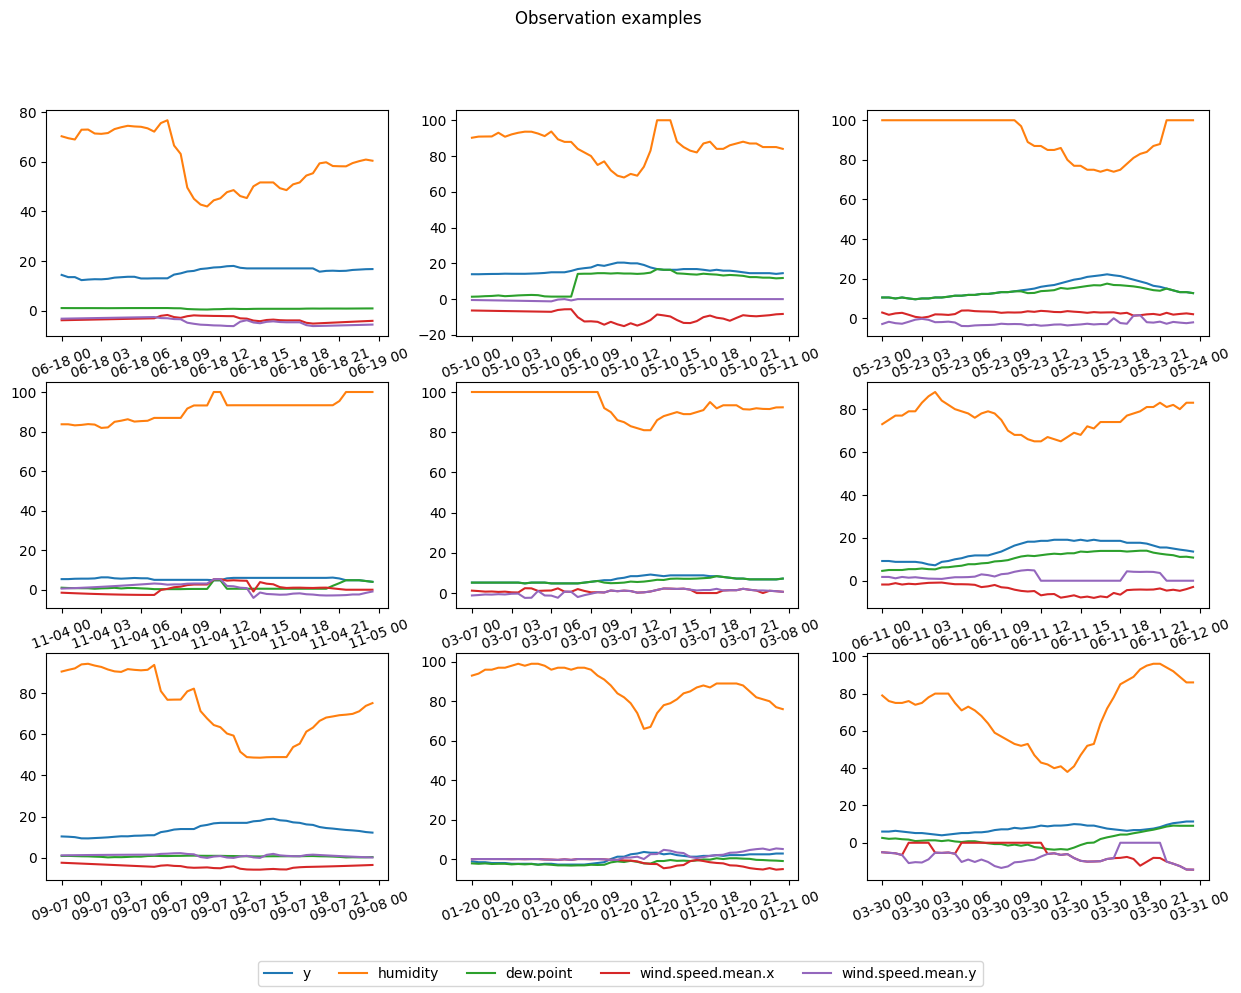

In [4]:
url_date_filex = "2023.08.08.csv"
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated" + \
                url_date_filex + ".xz?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated" + url_date_filex + '.xz'

df = pd.read_csv(data_url, parse_dates=['ds'], compression='xz')
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df.copy()

# Unusable - Mostly NAs
drop_cols = ['sunshine', 'ceil_hgt', 'visibility']
df.drop(drop_cols, axis=1, inplace=True)


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
df['rainfall'] /= 1000
for column in ['temperature', 'dew.point', 'wind.speed.mean', 'wind.speed.max']:
    df[column] /= 10

df['y'] = df['temperature']


df['rain_prev_6_hours']  = df['rainfall'].rolling(12, min_periods=1).sum()
df['rain_prev_12_hours'] = df['rainfall'].rolling(24, min_periods=1).sum()
df['rain_prev_24_hours'] = df['rainfall'].rolling(48, min_periods=1).sum()
df['rain_prev_48_hours'] = df['rainfall'].rolling(96, min_periods=1).sum()
df['rain_prev_24_hours_binary'] = (df['rain_prev_24_hours'] > 0.0) * 1
df['rain_prev_48_hours_binary'] = (df['rain_prev_48_hours'] > 0.0) * 1


# Faster than np.ptp - https://stackoverflow.com/a/40184053/100129
# df['y_window_48_min_max_diff'] required in add_transmit_heuristic_feature
df['y_window_48_min_max_diff'] = df['y'].rolling(48, min_periods=1).agg(['min', 'max']).diff(axis=1)['max']
df = add_transmit_heuristic_feature(df)

# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-12-31 23:30:00', :].copy(deep=True)


# Remove extreme outliers
humidity_min = 5.00
df.loc[df['humidity'] < humidity_min, 'humidity'] = humidity_min

pressure_min = 950
pressure_max = 1060
df.loc[df['pressure'] < pressure_min, 'pressure'] = pressure_min
df.loc[df['pressure'] > pressure_max, 'pressure'] = pressure_max


# Remove obviously bad temperature spike in '2016-01-08 23:00:00':'2016-01-09 07:30:00'
# display(df.loc['2016-01-08 21:00:00':'2016-01-09 12:00:00', ['y', 'missing']])
# display(df.loc['2016-01-08 23:00:00':'2016-01-09 07:30:00', 'y'])
df.loc['2016-01-08 23:00:00':'2016-01-09 07:30:00', 'y'] = np.linspace(3.7, 5.9, 18)


df['pressure.log'] = np.log(df['pressure'])
df['wind.speed.mean.sqrt'] = np.sqrt(df['wind.speed.mean'])
df['wind.speed.max.sqrt']  = np.sqrt(df['wind.speed.max'])


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.mean.sqrt', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.max', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.max.sqrt', 'wind.bearing.mean')


# df['rh'] = relative_humidity(df['dew.point'], df['y'])
df['ah'] = absolute_humidity(df['humidity'], df['y'])
df['mixing_ratio'] = mixing_ratio(df['humidity'], df['temperature'], df['pressure'])
df['svp'] = saturation_vapour_pressure(df['temperature'])

# actual water vapour pressure
df['vapour_pressure'] = saturation_vapour_pressure(df['dew.point'])

# vapour pressure deficit
#   https://en.wikipedia.org/wiki/Vapour-pressure_deficit
#   https://physics.stackexchange.com/a/4553/243807
#   TODO Check alt. vp_def calculation methods in above stackexchange question
df['vp_def'] = df['vapour_pressure'] - df['svp']

df['air_density'] = air_density(df['y'], df['pressure'], df['vapour_pressure'])
df['H2OC'] = water_vapour_concentration(df['humidity'], df['svp'], df['pressure'])
df['specific_humidity'] = specific_humidity(df['pressure'], df['vapour_pressure'])
df['t_pot'] = potential_temperature(df['y'], df['pressure'])

# df['dew.point_approx'] = dew_point_approx(df['y'], df['humidity'])
# df['y_approx'] = temperature_approx(df['dew.point'], df['humidity'])
# df['humidity_approx'] = humidity_approx(df['dew.point'], df['y'])

df['ground_hf'] = ground_heat_flux(df['y'])


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)


# ps - phase shift
for i, ps in enumerate([0, np.pi], start=1):
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, YEAR) + ps)
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, YEAR) + ps)


hour_df = pd.DataFrame(
    np.linspace(0, DAY, DAILY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

month_df = pd.DataFrame(
    np.linspace(0, YEAR, YEARLY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(DAY, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_splines_df['secs_since_midnight'] = range(0, DAY + DAY_SECS_STEP, DAY_SECS_STEP)


year_splines = periodic_spline_transformer(YEAR, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(YEAR), DAY_SECS_STEP)



# Add seasonal mean temperature (y_seasonal), humidity and dew.point
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * DAY

# NOTE: Potential data leak here
#       Seasonality should be calculated on train data only
#for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
#  df_seasonal_var = df[[var, 'secs_elapsed']].groupby('secs_elapsed').mean(var)
#  df_seasonal_var.rename(columns={var: var + '_seasonal'}, inplace=True)
#  df = pd.merge(df, df_seasonal_var,   on='secs_elapsed')
#  df[var + '_des'] = df[var] - df[var + '_seasonal']  # des - deseasonal

#df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
#df = pd.merge(df, year_splines_df, on='secs_elapsed')

# for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
#   df = simple_daily_yearly_res_decomp(df, var)
#   # display(df.info())


# TODO: Potential data leaks here?
# df['y_diff_1']  = df['y'].diff(1)
# df['dew.point_diff_1']  = df['dew.point'].diff(1)
# df['humidity_diff_1']   = df['humidity'].diff(1)
# df['pressure_diff_1'] = df['pressure'].diff(1)  # unusable

df['dT_dH'] = df['y'].diff(1) / df['humidity'].diff(1)
df['dT_dP'] = df['y'].diff(1) / df['pressure'].diff(1)
df['dT_dTdp'] = df['y'].diff(1) / df['dew.point'].diff(1)

# WARNING WARNING Danger Will Robinson! Definite data leak here :-(
# inf introduced due to diff(1) == 0 when no change
df = df.replace([np.inf, -np.inf], np.nan)
df['dT_dH']   = df['dT_dH'].interpolate(method='linear')
df['dT_dP']   = df['dT_dP'].interpolate(method='linear')
df['dT_dTdp'] = df['dT_dTdp'].interpolate(method='linear')



df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
inc_cols = ['ds', 'y', #'y_daily', 'y_yearly', 'y_res',
            'humidity', #'humidity_daily', 'humidity_yearly', 'humidity_res',
            'dew.point', #'dew.point_daily', 'dew.point_yearly', 'dew.point_res',
            'pressure', #'pressure_daily', 'pressure_yearly', 'pressure_res',
            'pressure.log', 'y_window_48_min_max_diff',
           #'humidity_diff_1',
           #'humidity_diff_48', 'pressure_diff_48', 'humidity_diff_1_48',
           #'wind.speed.mean_daily', 'wind.speed.mean_yearly', 'wind.speed.mean_res',
            'wind.speed.mean.sqrt', 'wind.speed.mean',
            'wind.bearing.mean', 'wind.speed.mean.x', 'wind.speed.mean.y',
            'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
            'wind.speed.max', 'wind.speed.max.sqrt',
            'wind.speed.max.sqrt.x', 'wind.speed.max.sqrt.y',
            'ground_hf', 'rainfall',
            'tau', 'rain_prev_6_hours', 'rain_prev_12_hours',
            'rain_prev_24_hours', 'rain_prev_24_hours_binary',
            'rain_prev_48_hours', 'rain_prev_48_hours_binary',
            'mixing_ratio', 'ah', 'specific_humidity', 'svp', 'vapour_pressure',
            'vp_def', 't_pot', 'air_density', 'H2OC',
            'dT_dH', 'dT_dP', 'dT_dTdp',
           #'y_approx', 'humidity_approx', 'dew.point_approx',
           #'y_seasonal', 'y_des',
           #'humidity_seasonal', 'humidity_des',
           #'dew.point_seasonal', 'dew.point_des',
           #'pressure_seasonal', 'pressure_des',
           #'wind.speed.mean_seasonal', 'wind.speed.mean_des',
            'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1',
           #'y_shadow', 'humidity_shadow', 'pressure_shadow', 'dew.point_shadow',
            'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike',
            'cooksd_out', 'isd_3_sigma', 'isd_filled', 'tsclean_filled',
            'tsclean_filled_temperature', 'tsclean_filled_dew.point',
            'tsclean_filled_humidity', 'tsclean_filled_pressure',
            'tsclean_filled_wind.speed.mean', 'tsclean_filled_wind.speed.max',
            'tsclean_filled_wind.bearing.mean', 'tsclean_filled_rainfall',
           #'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp'
           ]
df = df[inc_cols]

# df = df.loc[df['missing'] == 0.0, :]
# df = df.loc[(df['mi_filled'] != 1.0) & (df['hist_average'] != 1.0), :]



# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped" + url_date_filex
    df.to_csv(data_loc)


df = df.fillna(method='bfill')  # Small number of NAs in first row
print_df_summary(df)


plot_cols = ['y', 'humidity', 'dew.point', 'wind.speed.mean.x',
             'wind.speed.mean.y']  # 'pressure',
plot_observation_examples(df, plot_cols)


df_sanity = sanity_check_before_after_dfs(df_orig, df, 'df')
check_high_low_thresholds(df)

I didn't include `pressure` in example observation plots because those values are an order of magnitude higher than the other features.

A few other things to note:
 * features which did not prove useful this time
    * absolute humidity
    * mixing ratio
    * spline-based time components
    * higher frequency sinusoidal time components
    * phase-shifted sinusoidal time components
    * I leave the code for generating these features incase it is useful later
       * for example with the inclusion of the rainfall feature

---

### Calculate Solar Features

Irradiance, zenith angle, azimuth and declination:

[Solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) is the power per unit area (surface power density) received from the Sun.  Irradiance plays a part in weather forecasting.  I calculate solar irradiance for Cambridge using the python [solarpy](https://github.com/aqreed/solarpy) module.  I suspect forecasts could be substantially improved if solar irradiance could be combined with a measure of cloud cover.  It can also be used as a future covariate with models built with the darts package.

The [solar zenith angle](https://en.wikipedia.org/wiki/Solar_zenith_angle) is the angle between the sun's rays and the vertical direction.  I use the [pysolar](https://github.com/pingswept/pysolar) python package for zenith angle calculations.  Similarly to irradiance, it can be used as a future covariate.  See this [stackoverflow question](https://stackoverflow.com/questions/45238223/how-to-get-solar-zenith-angle-using-pysolar) and the [source code](https://github.com/pingswept/pysolar/blob/master/pysolar/solar.py) for calculation details.  There is a refraction correction term which assumes 'standard' pressure and temperature values.  Zenith angle is used to calculate solar irradiance.

[Solar azimuth angle](https://en.wikipedia.org/wiki/Solar_azimuth_angle) is the angle between the projection of sun rays and a line due south or north.  Again, I use the [pysolar](https://github.com/pingswept/pysolar) python package for azimuth angle calculations.  Similarly to irradiance and zenith angle, it can be used as a future covariate.

[Solar declination](https://www.sciencedirect.com/topics/engineering/solar-declination) is the angle between the equator and a line drawn from the centre of the Earth to the centre of the sun.  It can be calculated with the solarpy module.  It did not prove useful in the lightgbm models.
I've commented it out for now.

Calculations:
  * just calculate irradiance etc for a single year (arbitrarily 2020)
  * then repeat these values for the other years

Installing {'pysolar', 'solarpy'} ... Done
Zenith


Calculating zenith: 100%|██████████| 17568/17568 [00:16<00:00, 1058.57it/s]


count    17568.000000
mean        89.672425
std         29.857274
min         28.767886
25%         67.803213
50%         89.235373
75%        111.449144
max        151.223633
Name: za, dtype: float64

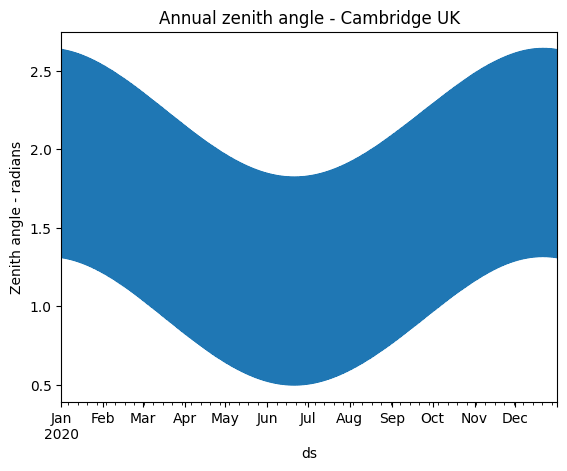

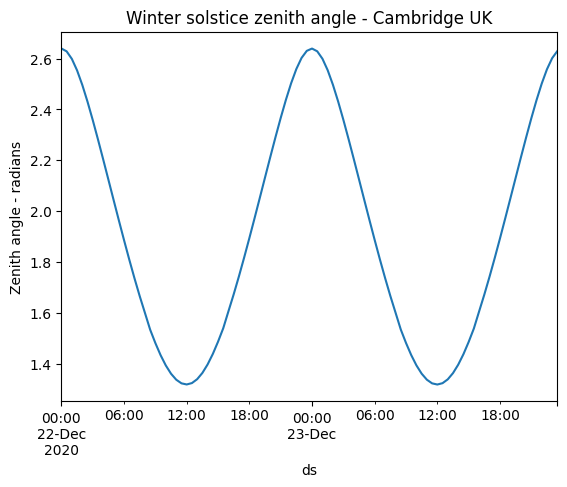

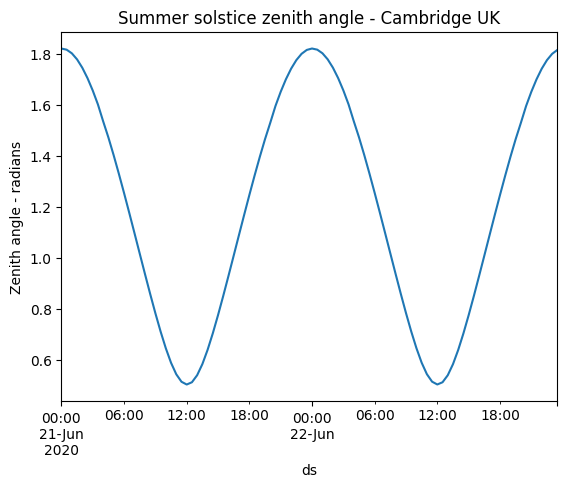

Irradiance


Calculating irradiance: 100%|██████████| 17568/17568 [00:03<00:00, 4517.15it/s]


count    17568.000000
mean       142.940765
std        226.586194
min          0.000000
25%          0.000000
50%          0.000137
75%        220.386913
max        805.382014
Name: irradiance, dtype: float64

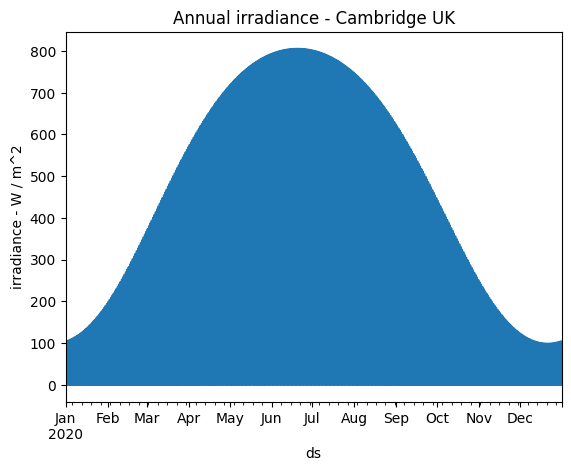

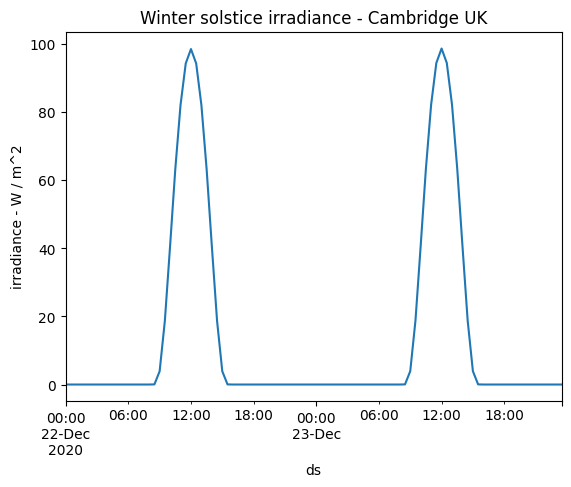

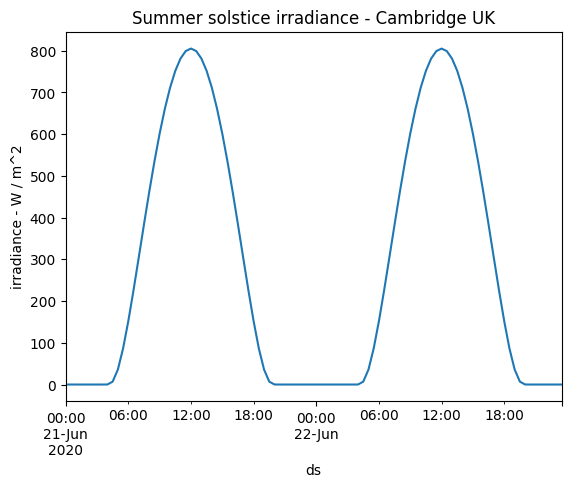

Azimuth


Calculating azimuth: 100%|██████████| 17568/17568 [00:15<00:00, 1104.47it/s]


count    17568.000000
mean         0.001957
std          0.588445
min         -0.841471
25%         -0.579791
50%          0.006409
75%          0.582247
max          0.841471
Name: azimuth, dtype: float64

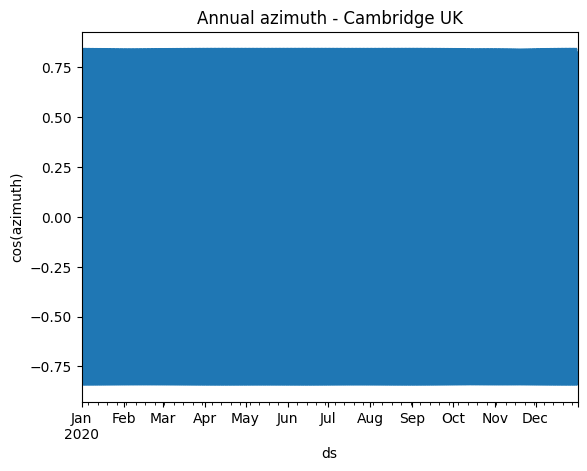

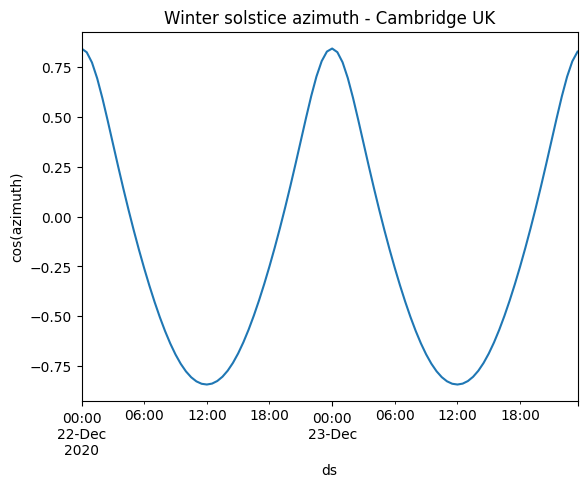

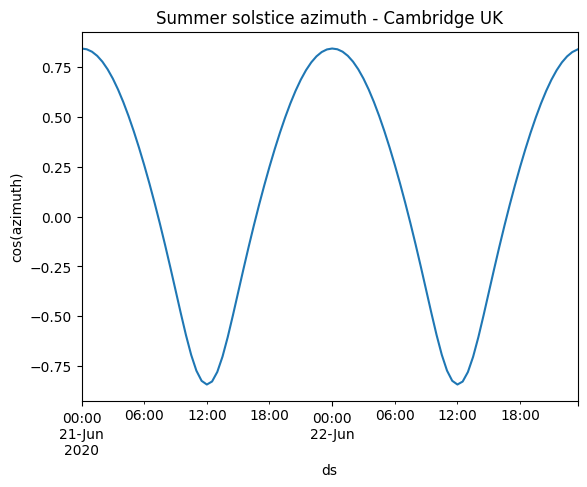

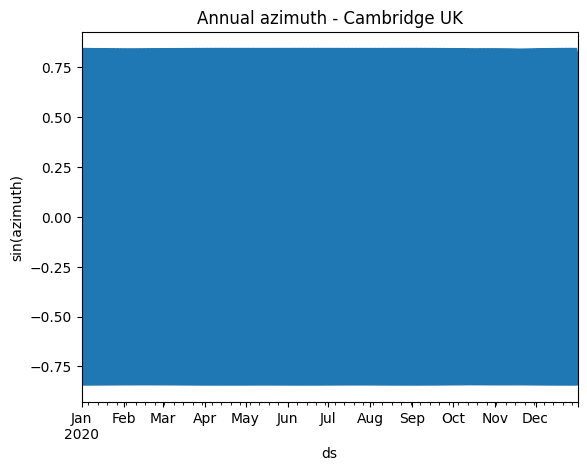

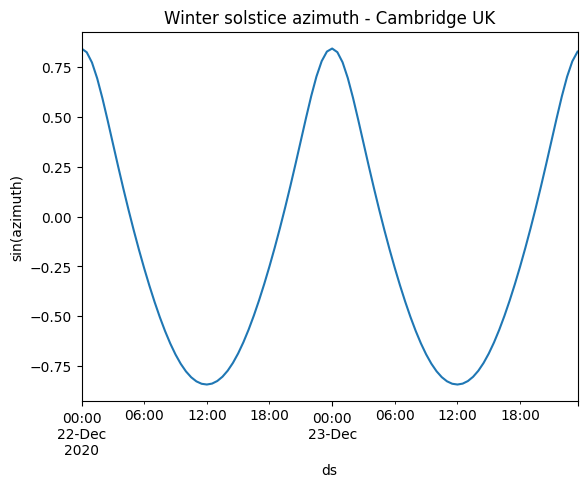

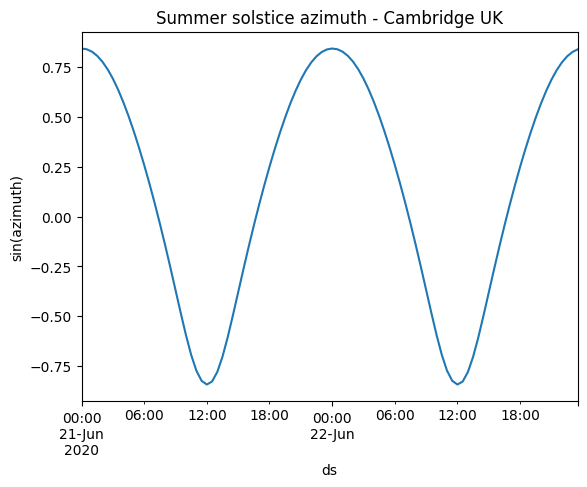

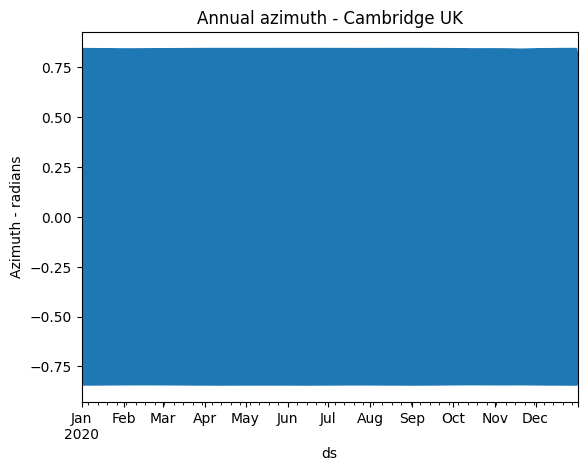

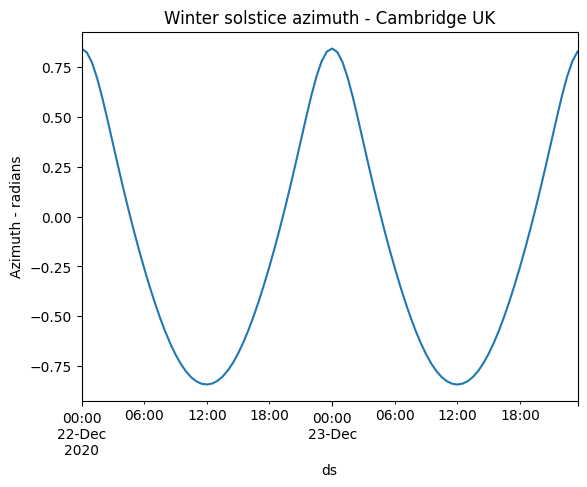

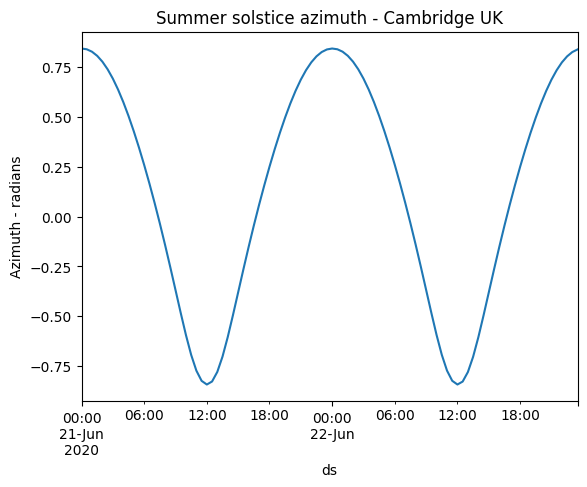

Declination


Calculating declination: 100%|██████████| 17568/17568 [00:00<00:00, 96581.03it/s]


count    17568.000000
mean         0.005800
std          0.287570
min         -0.408846
25%         -0.280364
50%          0.011877
75%          0.290560
max          0.409361
Name: declination, dtype: float64

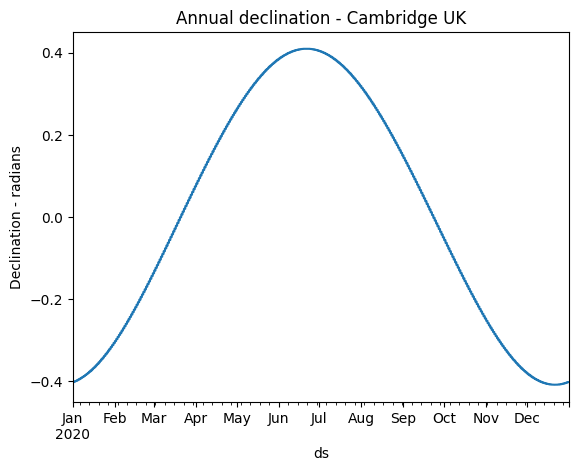

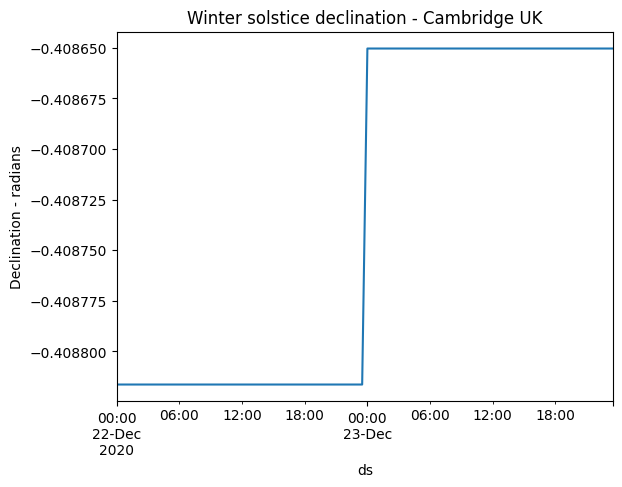

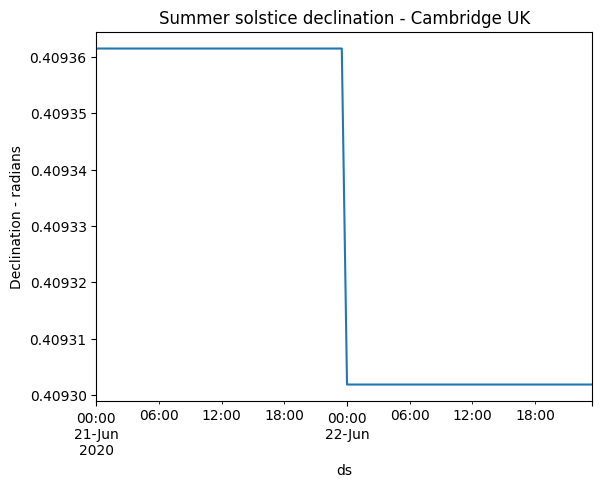


df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: 43.586
mean after feature redundancy:  63.164



before   after diff
rows                    252768  252768    0
cols                        60      77   17
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       0    0
low_var_rows                 0       0    0
low_var_cols                 6       7    1
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0

In [5]:
required  = {'pysolar', 'solarpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing   = required - installed

if missing == required:
    print('Installing', missing, '...', sep=' ', end='')
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing])  #, stdout=subprocess.DEVNULL)
    print(' Done')


from pysolar.solar import get_altitude, get_azimuth
from solarpy import irradiance_on_plane, declination


def calc_solar_data(df, solar_calc):
  IYEAR = 2020  # arbitrary year
  LAT   = 52.210922
  LON   =  0.091964

  df['year'] = df['ds'].dt.year
  data = pd.DataFrame()
  data.index = df.loc[df['year'] == IYEAR, 'ds']
  data.index = pd.to_datetime(data.index)

  print(solar_calc.title())

  if solar_calc == 'declination':
    declinations = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      declinations[i] = declination(d)
      i += 1

    data['declination'] = declinations
    display(data['declination'].describe())
  elif solar_calc == 'irradiance':
    HEIGHT = 6  # height above sea level
    VNORM  = np.array([0, 0, -1])  # plane pointing zenith
    irradiances  = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      irradiances[i] = irradiance_on_plane(VNORM, HEIGHT, d, LAT)
      i += 1

    data['irradiance'] = irradiances
    display(data['irradiance'].describe())
  elif solar_calc == 'zenith':
    za = [0] * len(data)
    za_rad = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      ts = pd.Timestamp(d, tz='UTC').to_pydatetime()
      za[i] = float(90) - get_altitude(LAT, LON, ts)
      za_rad[i] = np.radians(za[i])
      i += 1

    # TODO rename za to zenith
    data['za'] = za
    data['za_rad'] = za_rad
    display(data['za'].describe())
  elif solar_calc == 'azimuth':
    az = [0] * len(data)
    az_rad = az
    az_rad_cos = az
    az_rad_sin = az
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      ts = pd.Timestamp(d, tz='UTC').to_pydatetime()
      az[i] = get_azimuth(LAT, LON, ts)
      az_rad[i] = np.radians(az[i])
      az_rad_cos[i] = np.cos(az_rad[i])
      az_rad_sin[i] = np.sin(az_rad[i])
      i += 1

    data['azimuth'] = az
    data['azimuth_rad'] = az_rad
    data['azimuth_cos'] = az_rad_cos
    data['azimuth_sin'] = az_rad_sin
    display(data['azimuth'].describe())
  else:
    print("Unknown solar_calc parameter:", solar_calc,
          "\nUse 'declination', 'irradiance' or 'zenith'")

  print()
  data['month']  = data.index.month
  data['day']    = data.index.day
  data['hour']   = data.index.hour
  data['minute'] = data.index.minute

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute

  merge_cols = ['month', 'day', 'hour', 'minute']
  df = df.merge(data, on=merge_cols)
  df.drop(merge_cols, inplace=True, axis=1)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq(freq='30min')

  if solar_calc == 'declination':
    df['declination_diff_1'] = df['declination'].diff(1)
  elif solar_calc == 'irradiance':
    df['irradiance_diff_1'] = df['irradiance'].diff(1)
  elif solar_calc == 'zenith':
    df['za_diff_1'] = df['za'].diff(1)
    df['za_rad_diff_1'] = df['za_rad'].diff(1)
  elif solar_calc == 'azimuth':
    df['azimuth_diff_1'] = df['azimuth'].diff(1)
    df['azimuth_rad_diff_1'] = df['azimuth_rad'].diff(1)
    df['azimuth_cos_diff_1'] = df['azimuth_cos'].diff(1)
    df['azimuth_sin_diff_1'] = df['azimuth_sin'].diff(1)

  return df


def plot_solar(solar, title, ylab):
  solar.plot()
  plt.ylabel(ylab)
  plt.title(title)
  plt.show()


def plot_solar_annual_and_solstice(solar, var, title_var, ylab):
  title = 'Annual ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-01-01':'2020-12-31', var], title, ylab)

  title = 'Winter solstice ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-12-22':'2020-12-23', var], title, ylab)

  title = 'Summer solstice ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-06-21':'2020-06-22', var], title, ylab)


df_before_solar = df.copy()

za_lab = 'Zenith angle - radians'
za_title = 'zenith angle'
df = calc_solar_data(df, 'zenith')
plot_solar_annual_and_solstice(df, 'za_rad', za_title, za_lab)

irr_ylab = 'irradiance - W / m^2'
irr_title = 'irradiance'
df = calc_solar_data(df, irr_title)
plot_solar_annual_and_solstice(df, irr_title, irr_title, irr_ylab)

az_lab = 'Azimuth - radians'
az_title = 'azimuth'
df = calc_solar_data(df, az_title)
plot_solar_annual_and_solstice(df, 'azimuth_cos', az_title, 'cos(azimuth)')
plot_solar_annual_and_solstice(df, 'azimuth_sin', az_title, 'sin(azimuth)')
plot_solar_annual_and_solstice(df, 'azimuth_rad', az_title, az_lab)

dec_ylab = 'Declination - radians'
dec_title = 'declination'
df = calc_solar_data(df, dec_title)
plot_solar_annual_and_solstice(df, dec_title, dec_title, dec_ylab)

df = df.fillna(method='bfill')  # Small number of NAs in first row
df_solar_sanity = sanity_check_before_after_dfs(df_before_solar, df, 'df')
check_high_low_thresholds(df)

There is zero solar irradiance between sunset and sunrise. Hence the near zero median value for irradiance.

---


#### Unobserved components model

The unobserved components model (UCM) is an alternative to prophet decomposition.  It produces trend, cyclic, seasonal and residual terms which can be stochastic or deterministic.  The cyclic component of the unobserved components model can model the relatively long annual seasonality (48 * 365.2425 = 17,532 steps) using harmonic terms.

 * [statsmodels - unobserved components](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
 * [statsmodels - Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
 * [Daniel Toth - Multi seasonal time series analysis: decomposition and forecasting with Python](https://medium.com/analytics-vidhya/multi-seasonal-time-series-analysis-decomposition-and-forecasting-with-python-609409570007)


 Here, I run a few experiments using UCM for decomposition.
 There is some data leakage here but these features are not used in later modeling notebooks.  It may be worthwhile considering UCM models with exogenous data as an advanced baseline.


In [6]:
def get_uc_model(data, params, y_col='y'):
  ucm = sm.tsa.UnobservedComponents(data[y_col], #.dropna().values,
                                    **params)
  res_f = ucm.fit(method='powell', disp=False)

  return res_f


def check_uc_model(ucmodel, valid_data = None):
  print(ucmodel.summary())

  ucmodel.plot_components(figsize=(12, 12))
  plt.show()

  ucmodel.plot_diagnostics(figsize=(12, 12), lags=96)
  plt.show()

  if valid_data is not None:
    # model forecast
    steps_ = len(valid_data) #int(48 * 365.2425)
    test_df = valid_data[['y']].interpolate(method='linear')  #.head(steps_)
    forecast_ucm = ucmodel.forecast(steps=steps_, exog=test_df)

    # calculating mean absolute error and root mean squared error for out-of-sample prediction for model evaluation
    RMSE_ucm = np.sqrt(np.mean([(test_df.iloc[x, 0] - forecast_ucm[x]) ** 2 for x in range(len(test_df))]))
    MAE_ucm  = np.mean([np.abs(test_df.iloc[x, 0] - forecast_ucm[x]) for x in range(len(test_df))])

    print(f"\nOut-of-sample mean absolute error (MAE): {'%.2f' % MAE_ucm}")
    print(f"Out-of-sample root mean squared error (RMSE): {'%.2f' % RMSE_ucm}")


def add_ucm_decomposition(data_, ucm_mod, feat = 'y'):
  data = data_.copy(deep=True)

  level_name  = feat + '_ucm_' + 'level'
  yearly_name = feat + '_ucm_' + 'yearly'
  daily_name  = feat + '_ucm_' + 'daily'
  res_name    = feat + '_ucm_' + 'res'

  data.loc[:, level_name]  = getattr(ucm_mod, 'level')['smoothed']
  data.loc[:, yearly_name] = getattr(ucm_mod, 'cycle')['smoothed']
  data.loc[:, daily_name]  = getattr(ucm_mod, 'freq_seasonal')[0]['smoothed']

  data.loc[:, res_name] = data[feat] - data[level_name] - data[yearly_name] - data[daily_name]

  return data

Temperature first:

                          Unobserved Components Results                           
Dep. Variable:                          y   No. Observations:               252768
Model:                deterministic trend   Log Likelihood             -685947.598
                   + freq_seasonal(48(1))   AIC                        1371899.196
                                  + cycle   BIC                        1371920.076
Date:                    Tue, 06 Feb 2024   HQIC                       1371905.280
Time:                            14:45:25                                         
Sample:                        08-01-2008                                         
                             - 12-31-2022                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


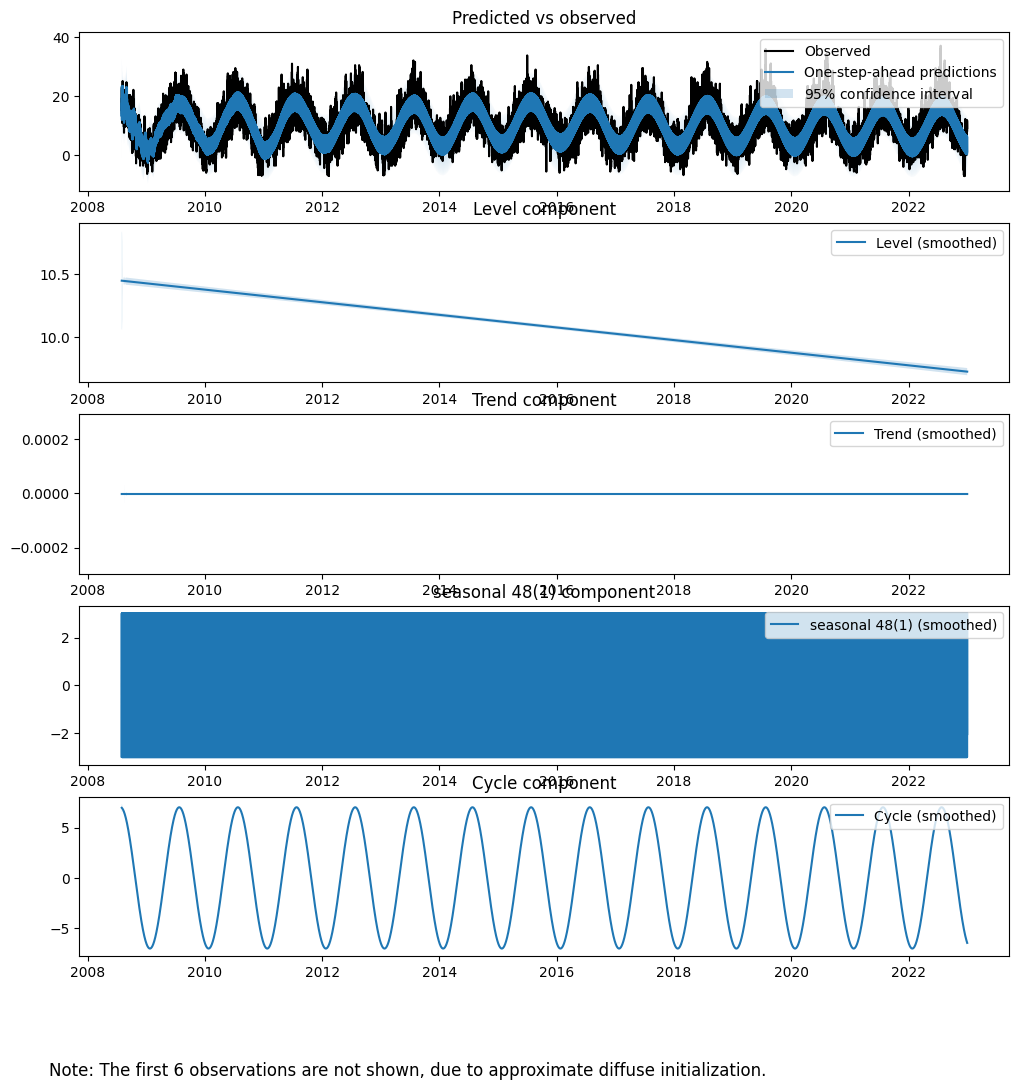

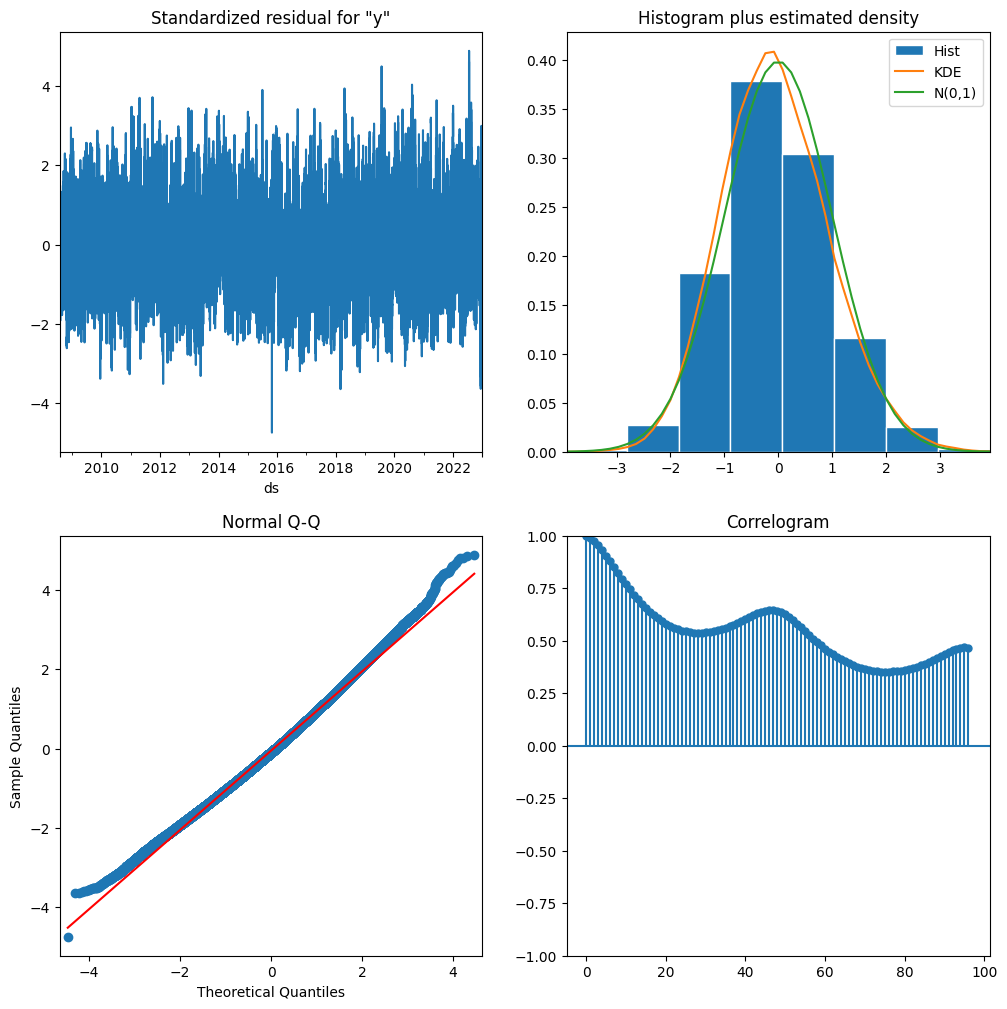


df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 63.164
mean after feature redundancy:  60.17



before   after diff
rows                    252768  252768    0
cols                        77      81    4
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       0    0
low_var_rows                 0       0    0
low_var_cols                 7       7    0
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0

In [7]:
df_before_ucm_y = df.copy()

uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             #'exog': train_df[['humidity','dew.point','irradiance']].interpolate(method='slinear'),
             #exog = data[['dew.point']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             #'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  1}]}

res_y = get_uc_model(df, uc_params)
check_uc_model(res_y)

# WARN: Proably data leakage here
df = add_ucm_decomposition(df, res_y)

df_sanity_ucm_y = sanity_check_before_after_dfs(df_before_ucm_y, df, 'df')
check_high_low_thresholds(df)

The temperature decomposition seemed acceptible.

Initial few months of decomposition show high variance.

---

`dew.point` second:

                          Unobserved Components Results                           
Dep. Variable:                  dew.point   No. Observations:               252768
Model:                deterministic trend   Log Likelihood             -685958.530
                   + freq_seasonal(48(2))   AIC                        1371921.060
                                  + cycle   BIC                        1371941.940
Date:                    Tue, 06 Feb 2024   HQIC                       1371927.144
Time:                            14:47:04                                         
Sample:                        08-01-2008                                         
                             - 12-31-2022                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


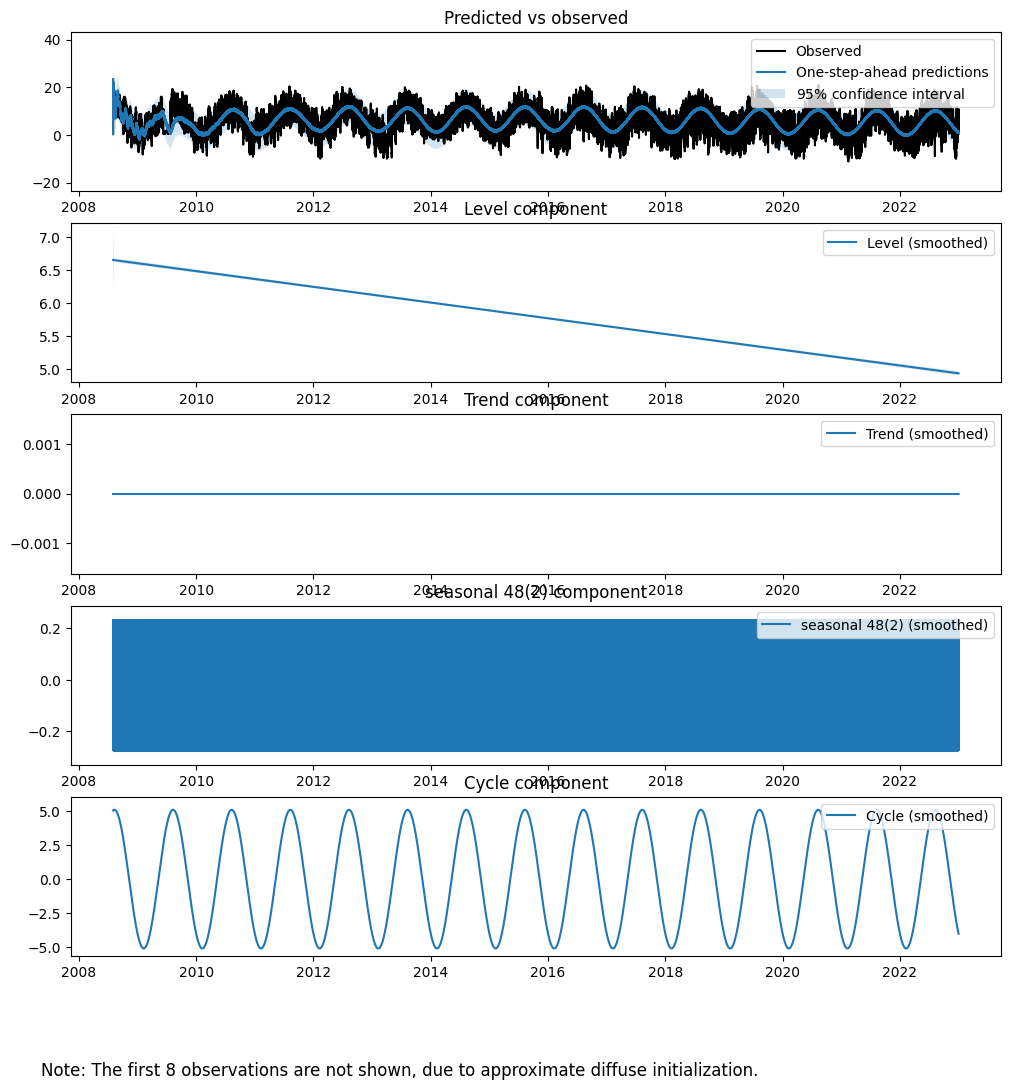

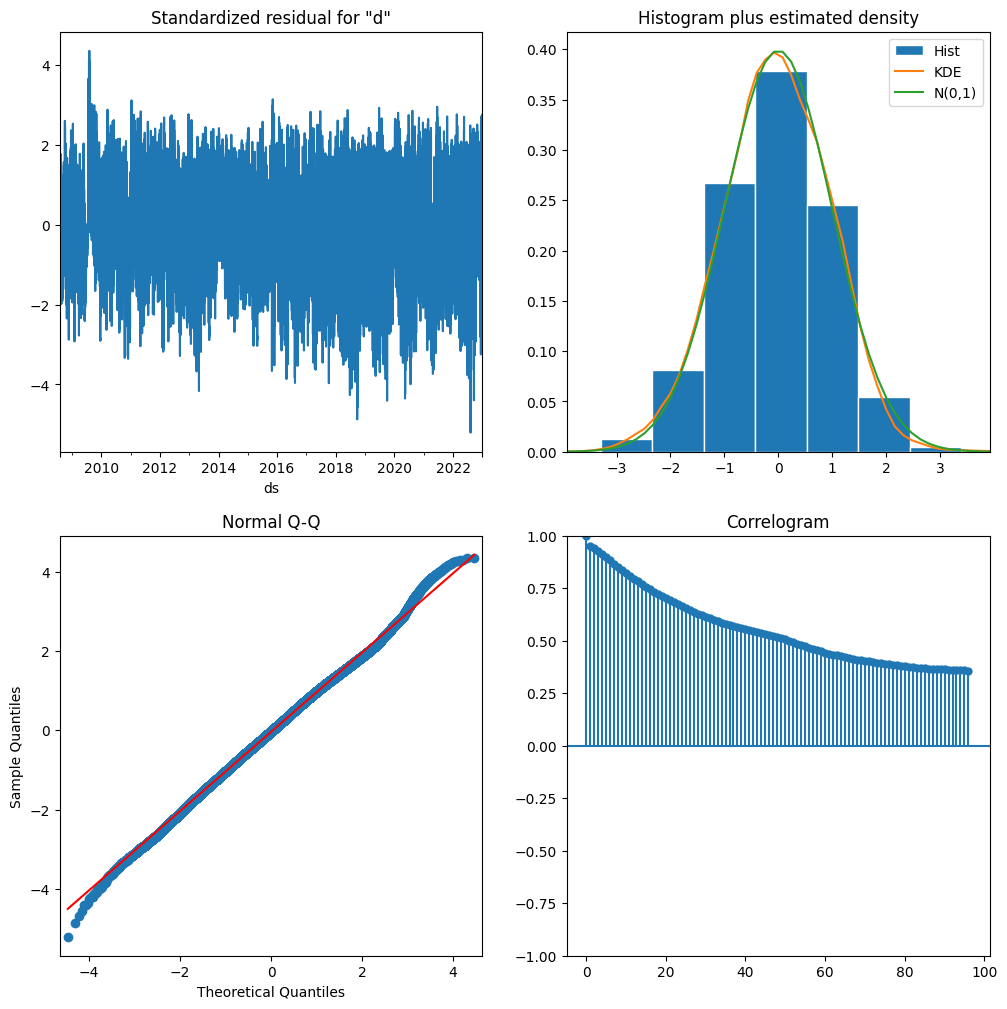

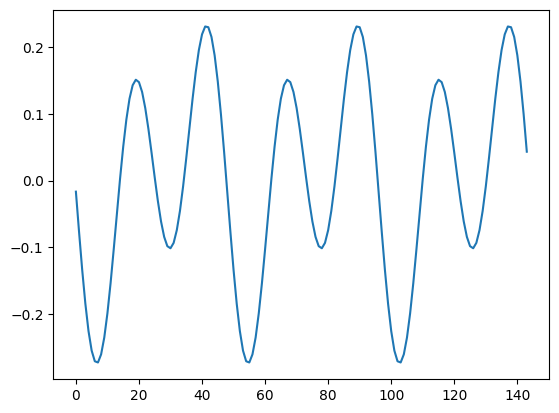


df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 60.17
mean after feature redundancy:  57.407



before   after diff
rows                    252768  252768    0
cols                        81      85    4
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       0    0
low_var_rows                 0       0    0
low_var_cols                 7       7    0
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0

In [8]:
df_before_ucm_dp = df.copy()

uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  2}]}

res_dp = get_uc_model(df, uc_params, 'dew.point')
check_uc_model(res_dp)

# WARN: Proably data leakage here
df = add_ucm_decomposition(df, res_dp, feat='dew.point')

plt.plot(res_dp.freq_seasonal[0]['smoothed'][:144])
plt.show()

df_sanity_ucm_dp = sanity_check_before_after_dfs(df_before_ucm_dp, df, 'df')
check_high_low_thresholds(df)

The due point decomposition seemed acceptible.
Note the daily bimodal peaks.

Initial few months of decomposition show high variance.

---

`humidity` third:

                          Unobserved Components Results                           
Dep. Variable:                   humidity   No. Observations:               252768
Model:                deterministic trend   Log Likelihood            -1011022.870
                   + freq_seasonal(48(1))   AIC                        2022049.740
                                  + cycle   BIC                        2022070.620
Date:                    Tue, 06 Feb 2024   HQIC                       2022055.824
Time:                            14:49:15                                         
Sample:                        08-01-2008                                         
                             - 12-31-2022                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


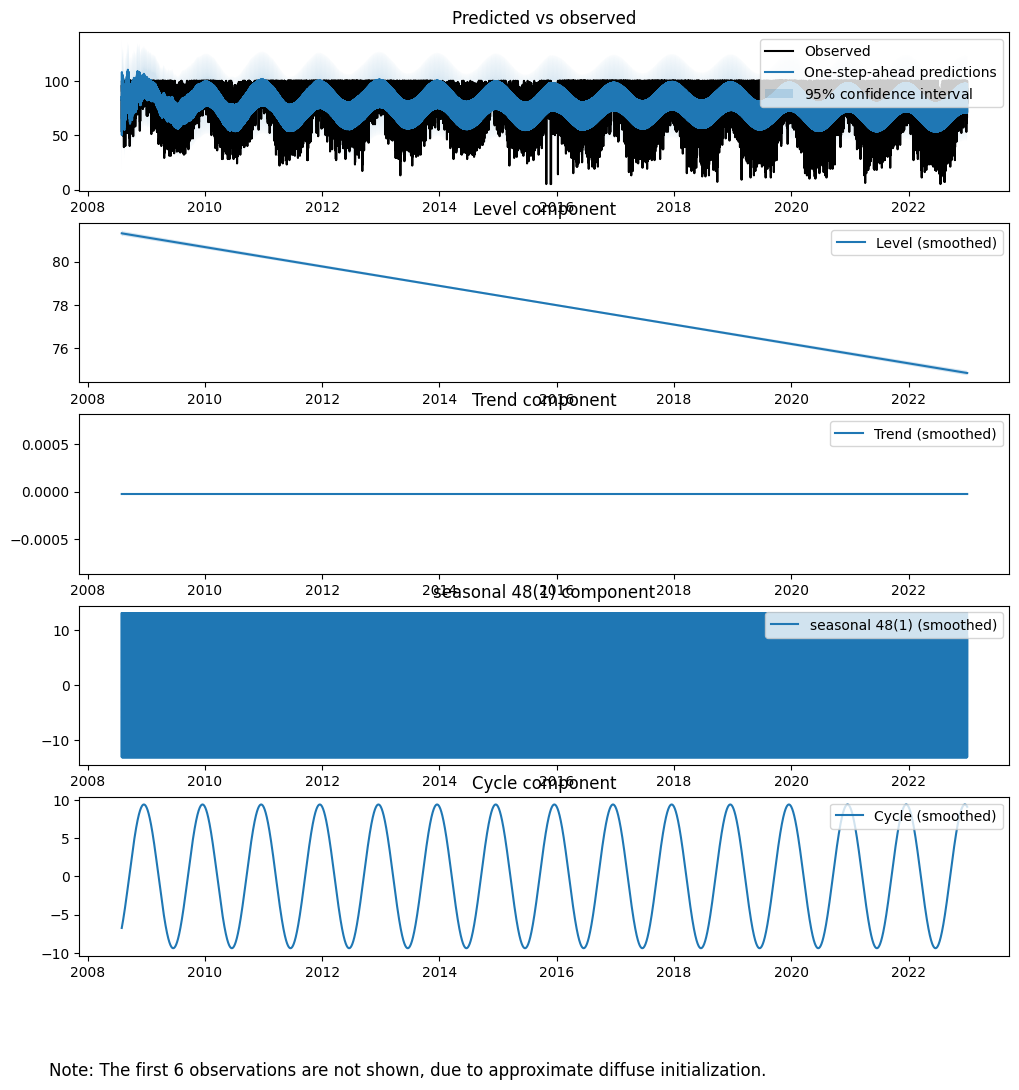

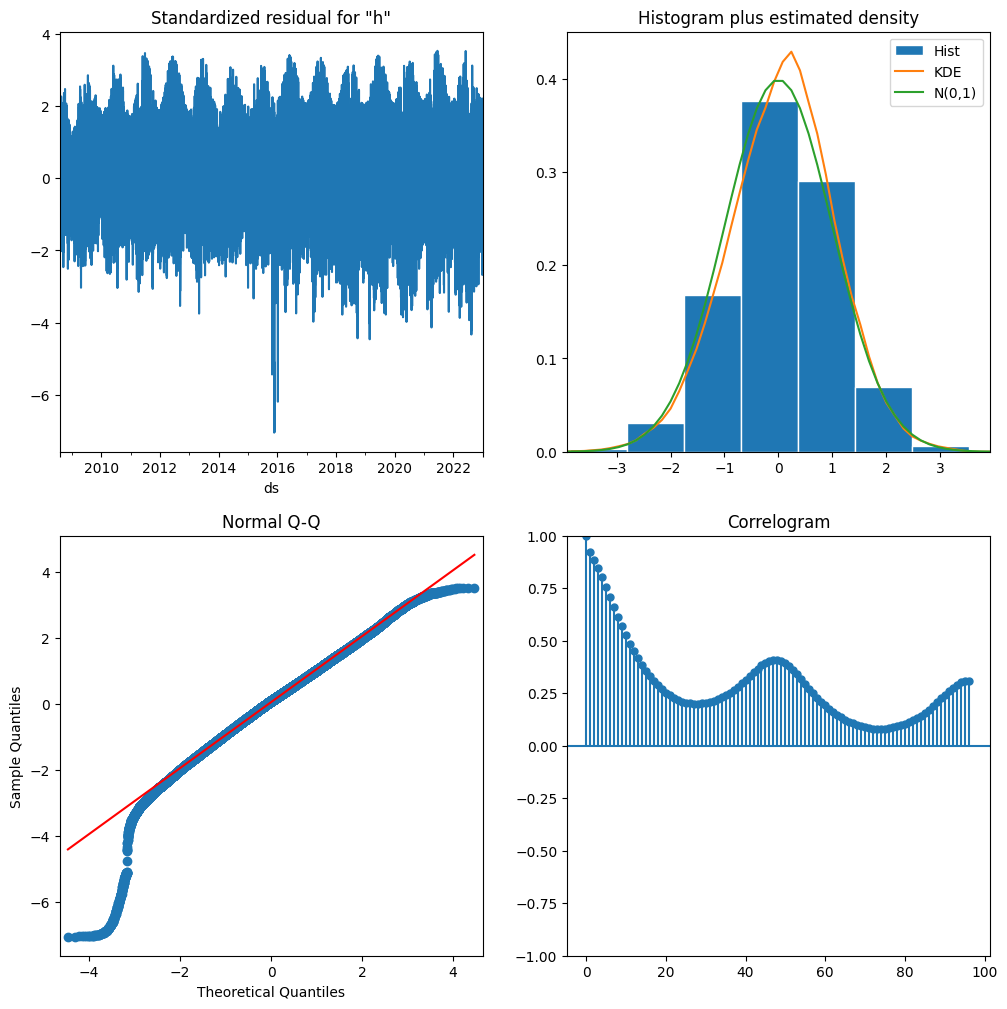

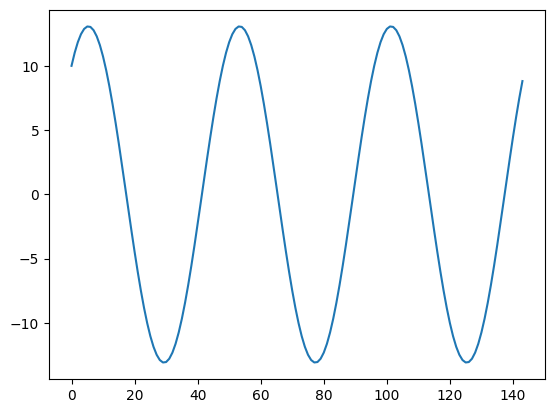

In [9]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  1}]}

res_hum = get_uc_model(df, uc_params, 'humidity')
check_uc_model(res_hum)

plt.plot(res_hum.freq_seasonal[0]['smoothed'][:144])
plt.show()

The `humidity` decomposition is problematic.

Initial few months of decomposition show high variance.

---

`pressure` fourth:

<ipython-input-10-73d5c880cf37>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  press_df['log_pressure'] = np.log(press_df['pressure'])


                          Unobserved Components Results                           
Dep. Variable:                   pressure   No. Observations:                87648
Model:                deterministic trend   Log Likelihood             -338229.536
                   + freq_seasonal(48(2))   AIC                         676463.072
                                  + cycle   BIC                         676481.834
Date:                    Tue, 06 Feb 2024   HQIC                        676468.800
Time:                            14:50:08                                         
Sample:                        01-01-2010                                         
                             - 12-31-2014                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


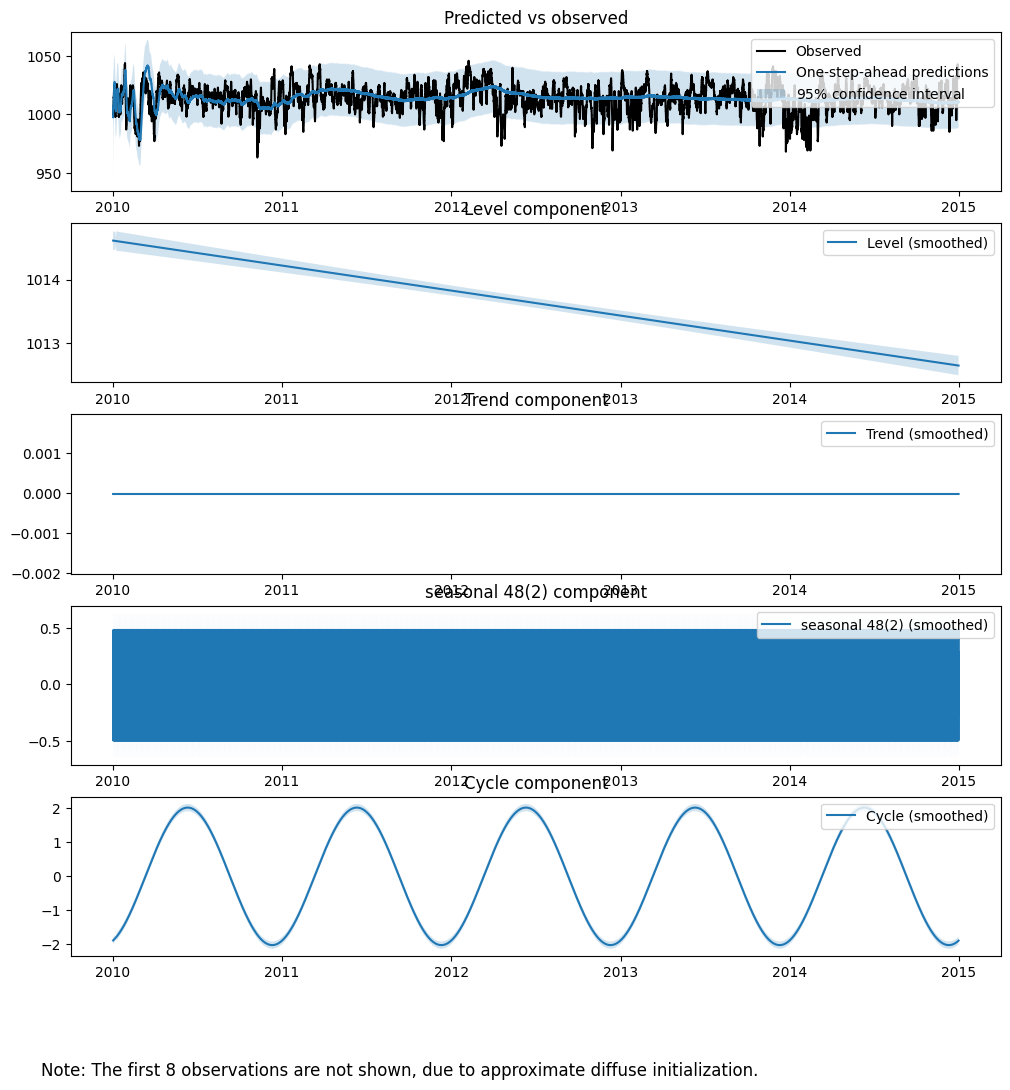

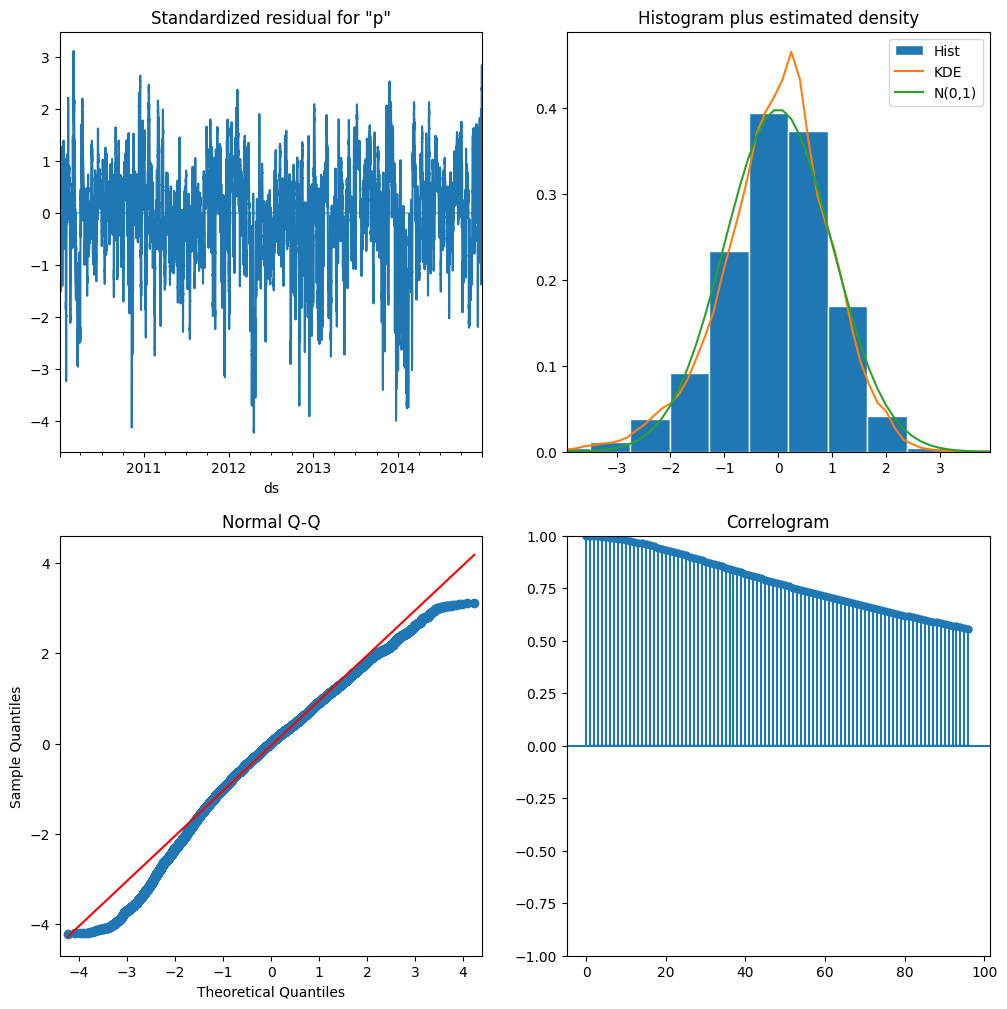

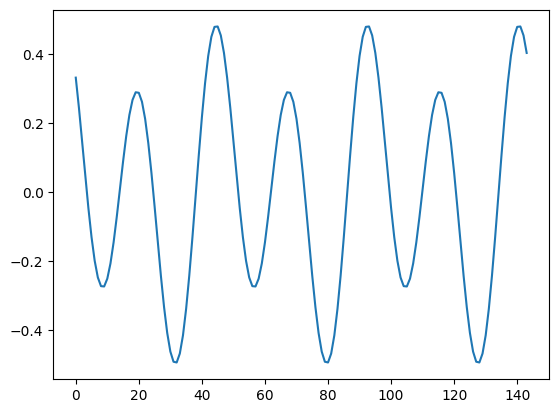

In [10]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             #'level': 'smooth trend',
             #'level': 'local linear trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  2}]}

press_df = df[(df.index.year >= 2010) & (df.index.year < 2015)]
press_df['log_pressure'] = np.log(press_df['pressure'])
res_press = get_uc_model(press_df, uc_params, 'pressure')
check_uc_model(res_press)

plt.plot(res_press.freq_seasonal[0]['smoothed'][:144])
plt.show()

The `pressure` decomposition is problematic.

Initial few months of decomposition show high variance.

---

Try building UCM for `pressure` without annual seasonal cycle:

                          Unobserved Components Results                           
Dep. Variable:                   pressure   No. Observations:                87648
Model:                deterministic trend   Log Likelihood             -338895.579
                   + freq_seasonal(48(2))   AIC                         677793.158
Date:                    Tue, 06 Feb 2024   BIC                         677802.539
Time:                            15:34:09   HQIC                        677796.022
Sample:                        01-01-2010                                         
                             - 12-31-2014                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   133.5580      0.556    240.276      0.000     132.469     134.64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


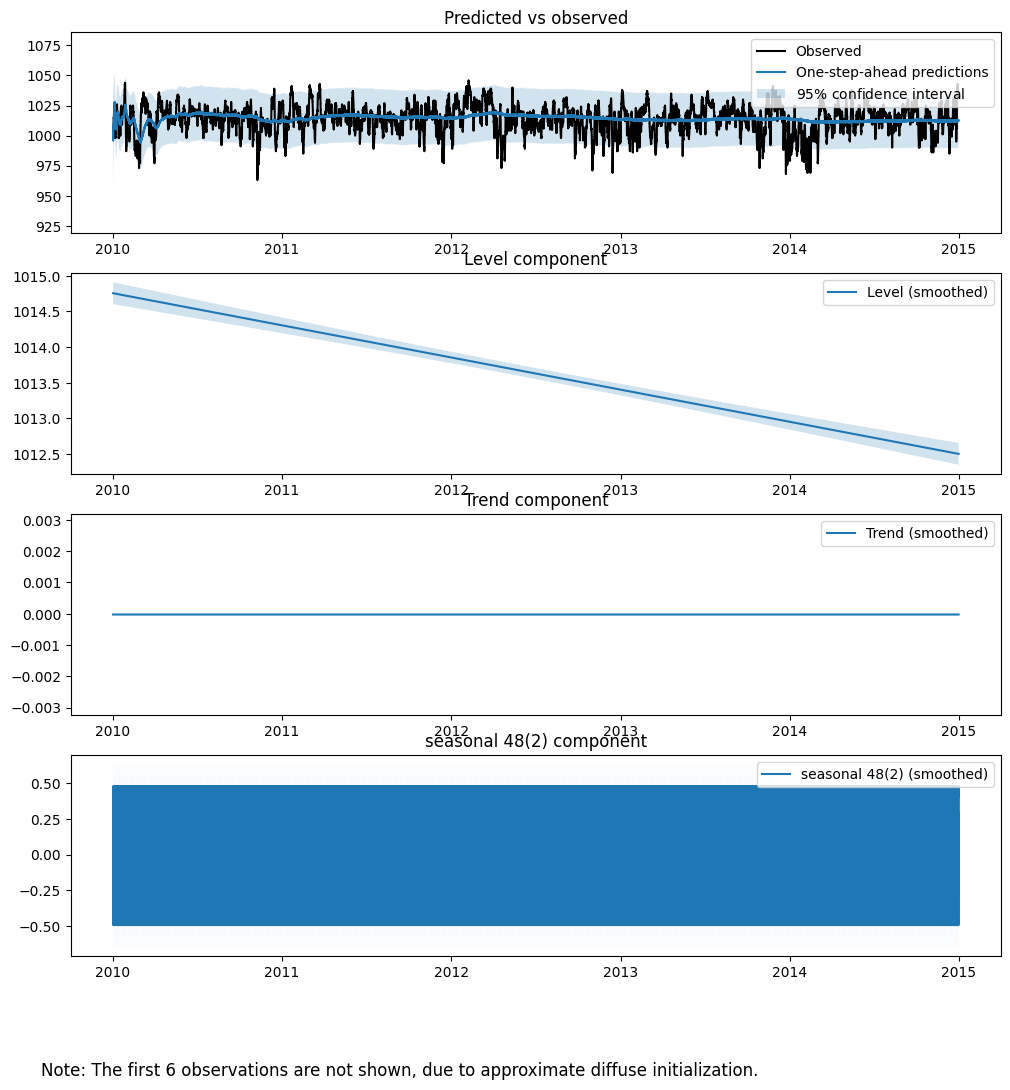

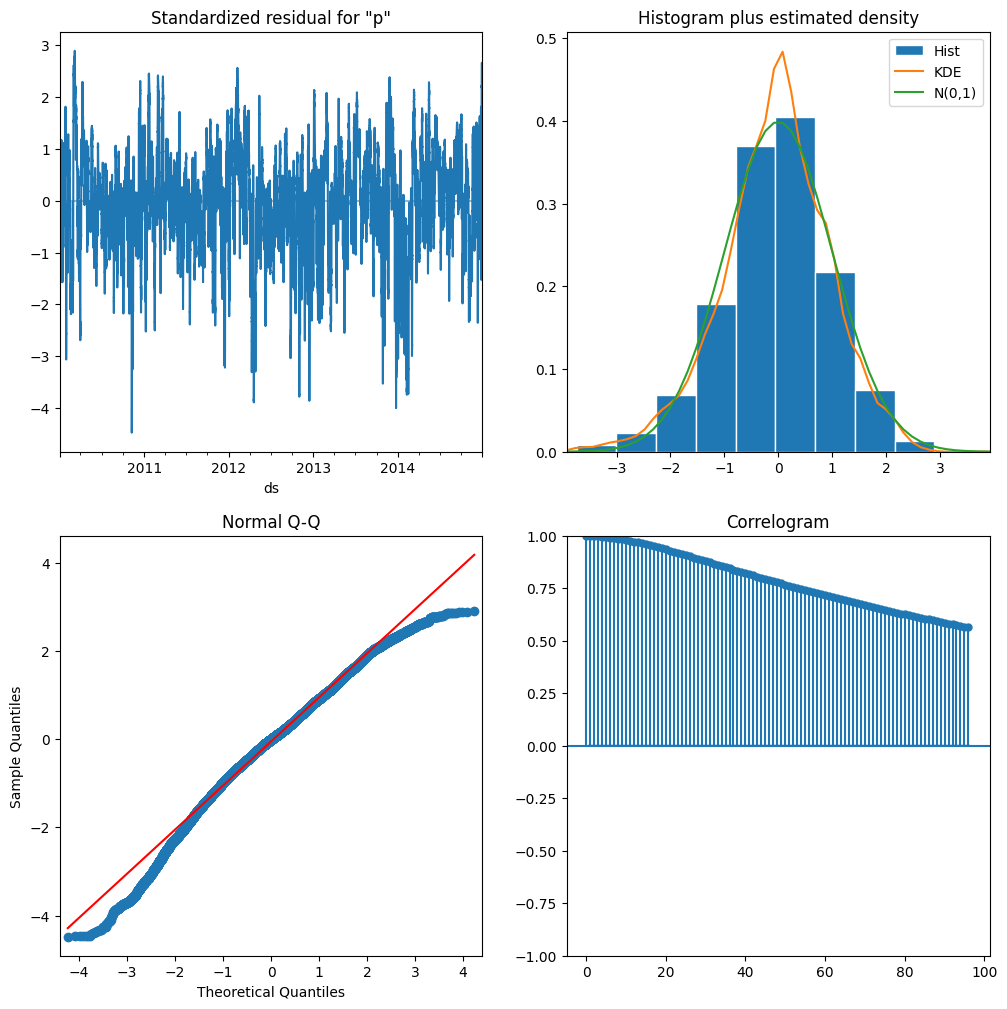

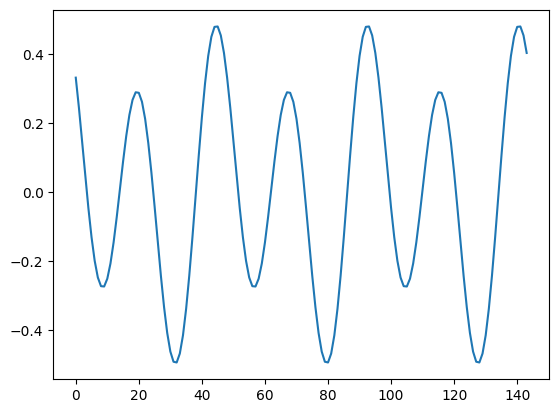

In [27]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             #'level': 'smooth trend',
             #'level': 'local linear trend',
             'cycle': False,
             # irregular = True,
             # 'autoregressive': 1,
             # 'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  2}]}

press_df = df[(df.index.year >= 2010) & (df.index.year < 2015)]
# press_df['log_pressure'] = np.log(press_df['pressure'])
res_press = get_uc_model(press_df, uc_params, 'pressure')
check_uc_model(res_press)

plt.plot(res_press.freq_seasonal[0]['smoothed'][:144])
plt.show()

This `pressure` decomposition without annual seasonal cycle is still problematic.  The daily seasonality does not capture much of the variance.

Initial few months of decomposition show high variance.

---

### Split Data

I use data from 2021 for validation, 2022 for testing and data before 2021 for training.  These are entirely arbitrary choices.  This results in an approximate 88%, 6%, 6% split for the training, validation, and test sets respectively.

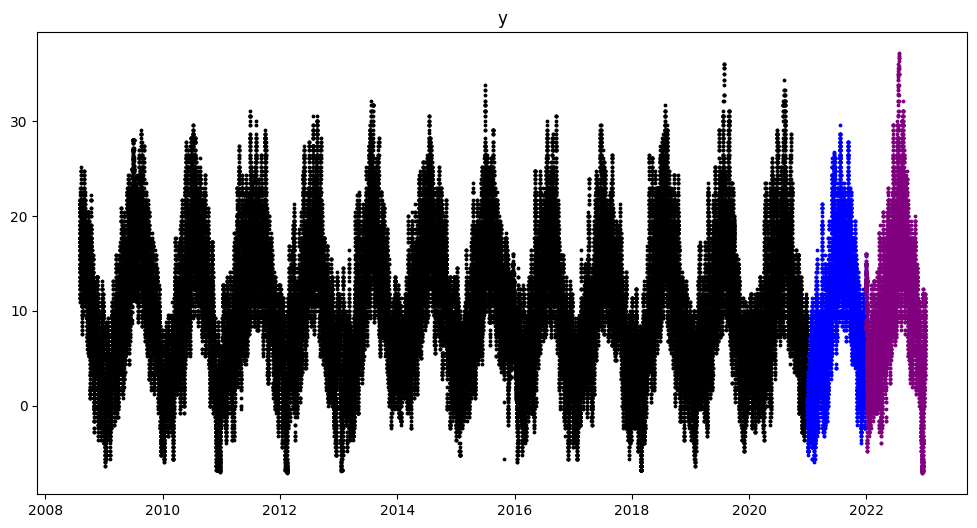

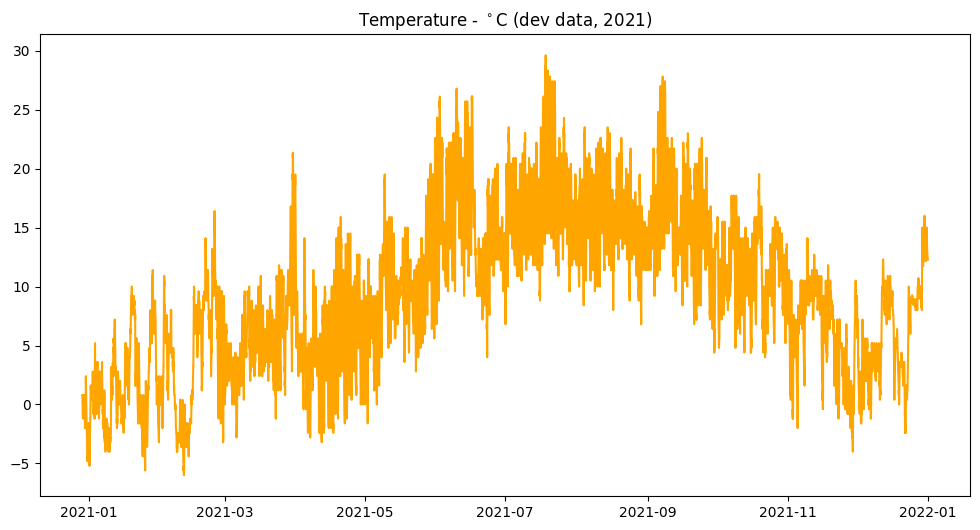

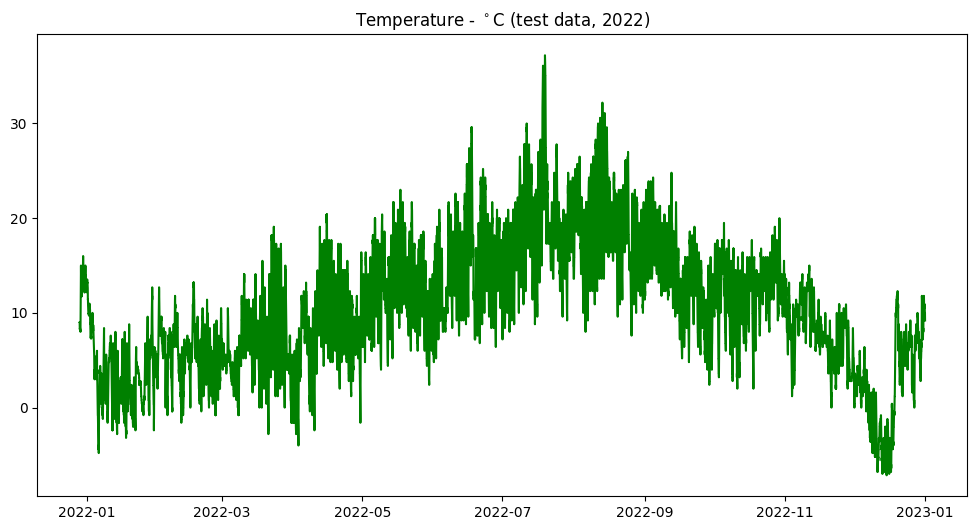

df shape:  (252768, 84)
train shape:    (217728, 84)
valid shape:    (17664, 84)
test shape:     (17664, 84)
ERROR: Overlap between train_df, valid_df indices!
max(train_df.index): 2020-12-31 23:30:00
min(valid_df.index): 2021-12-31 23:30:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_df.index: 2022-12-31 23:30:00 - 2022-12-31 23:30:00
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17664
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 17664

 train_df null columns:


Series([], dtype: float64)


 valid_df null columns:


Series([], dtype: float64)


 test_df null columns:


Series([], dtype: float64)

In [11]:
# df['year'] = df['ds'].dt.year
# WARN: Crucially important valid & test data are both after train data to
#       avoid data leakage
# train_df = df.loc[(df['year'] != VALID_YEAR) & (df['year'] != TEST_YEAR)]
train_df = df.loc[df['year'] < min(VALID_YEAR, TEST_YEAR)]
valid_df = df.loc[(df['ds'] >= '2020-12-29') & (df['ds'] < '2022-01-01')]
test_df  = df.loc[(df['ds'] >= '2021-12-29') & (df['ds'] < '2023-01-01')]
# valid_df = df.loc[df['year'] == VALID_YEAR]
# test_df  = df.loc[df['year'] == TEST_YEAR]

#train_df.loc[train_df['ds'].dt.year >= 2018, 'ds'] = train_df.loc[train_df['ds'].dt.year >= 2018, 'ds'] - pd.DateOffset(years=2)
#train_df.set_index('ds', drop=False, inplace=True)
#train_df = train_df[~train_df.index.duplicated(keep='first')]


plot_feature_history(train_df, valid_df, test_df, 'y')

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt_title = 'Temperature - $^\circ$C (dev data, ' + str(VALID_YEAR) + ')'
plt.title(plt_title)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt_title = 'Temperature - $^\circ$C (test data, ' + str(TEST_YEAR) + ')'
plt.title(plt_title)
plt.show()


del_cols = ['year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

# DO NOT USE ffill with train_df - ffills 2018 & 2019!
# train_df = train_df.asfreq(freq='30min', method='ffill')
train_df = train_df.asfreq(freq='30min', fill_value=np.nan)

# DO USE ffill with valid_df, test_df
# avoids missing value errors when calculating metrics etc
valid_df = valid_df.asfreq(freq='30min', fill_value=np.nan)
test_df  =  test_df.asfreq(freq='30min', fill_value=np.nan)
# valid_df = valid_df.asfreq(freq='30min', method='ffill')
# test_df  =  test_df.asfreq(freq='30min', method='ffill')

print_train_valid_test_shapes(df, train_df, valid_df, test_df)
sanity_check_train_valid_test(train_df, valid_df, test_df)
print_null_columns(train_df, 'train_df')
print_null_columns(valid_df, 'valid_df')
print_null_columns(test_df,  'test_df')




---

### Normalise Data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a useful sanity check to plot these values.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

<ipython-input-12-6bbf30968e11>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cols, rotation = 45)


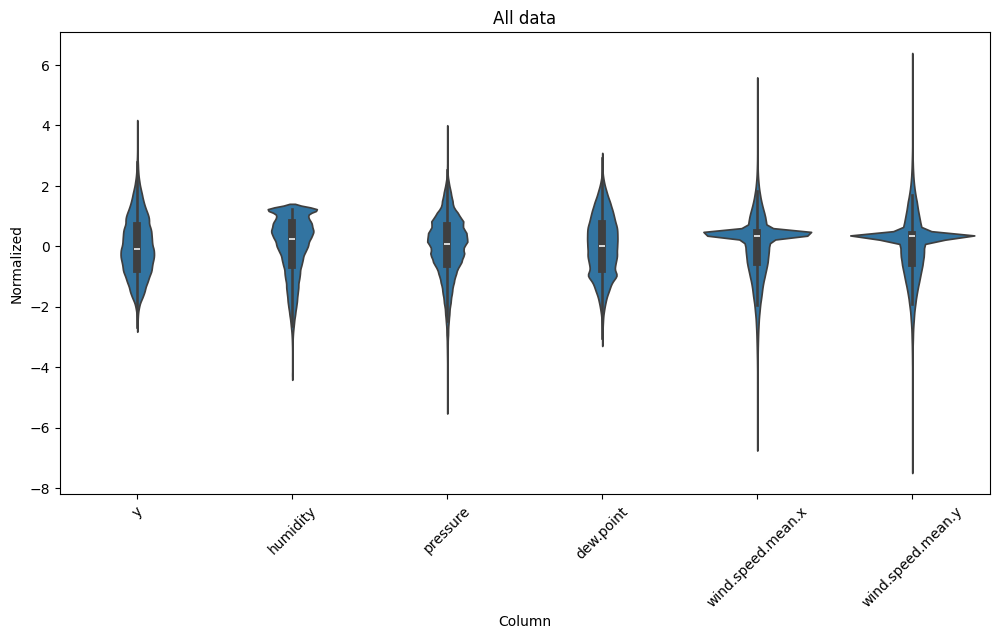

In [12]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals

    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)

    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.speed.mean.x',
        'wind.speed.mean.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');


Some features have long tails.


---

### Seasonal Decomposition

Time series decomposition with prophet.

Decomposition transforms time series into trend, seasonal and noise (residual) components.  These components are combined either additively or multiplicatively.  It is important to understand the time series components to better model and forecast future values.  In another notebook, I forecast the residual temperature components using lightgbm and add the trend and seasonal components to these forecasts to make the final predictions.

[Prophet](https://facebook.github.io/prophet/) is a python and R package for forecasting.  It is based on a model where non-linear trends are fit with yearly and daily seasonality but is quite flexible.  It works best with time series that have strong seasonal effects and several seasons of historical data.  In my experience it does not produce the best forecasts but I like its API and it can produce both additive and multiplicative multi-seasonal harmonic-based decompositions.  Like loess-based decompositions, a little parameter tuning is beneficial.  The details of how Prophet calculates multiplicative seasonality is outlined [here](https://github.com/facebook/prophet/issues/1245) and [here](https://www.kaggle.com/code/smakarychev/what-is-facebook-prophet-forecasting-model#Multiplicative-and-additive-terms).

The [Season-Trend decomposition using LOESS for multiple seasonalities](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html) from statsmodels is *currently* additive only.  Similarly, the unobserved components model (UCM) is additive only.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/qoqvw9zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/6cq6y3ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39667', 'data', 'file=/tmp/tmpj9nqec_z/qoqvw9zk.json', 'init=/tmp/tmpj9nqec_z/6cq6y3ns.json', 'output', 'file=/tmp/tmpj9nqec_z/prophet_modelv2uk82xh/prophet_model-20240206145038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


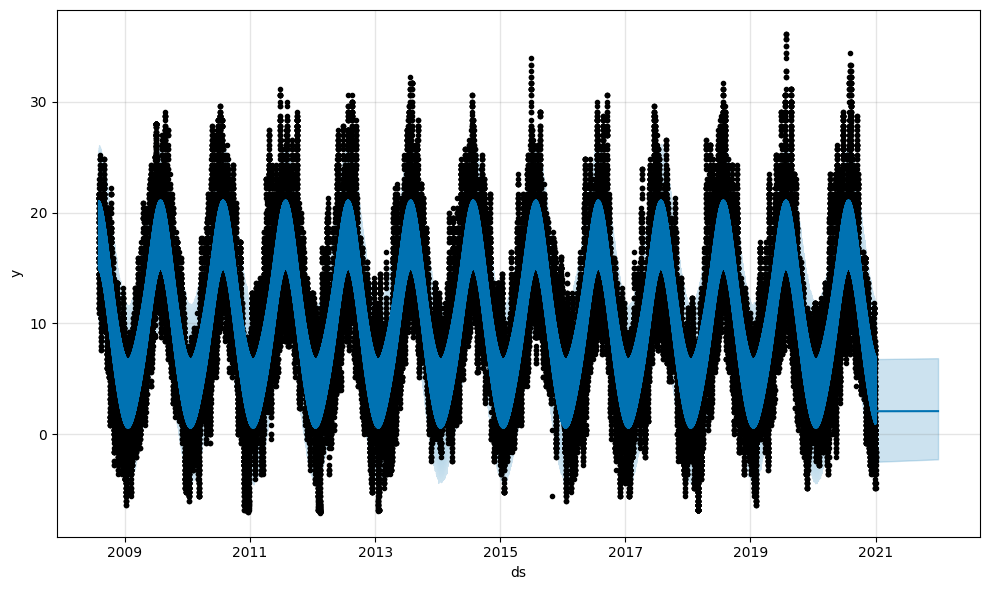

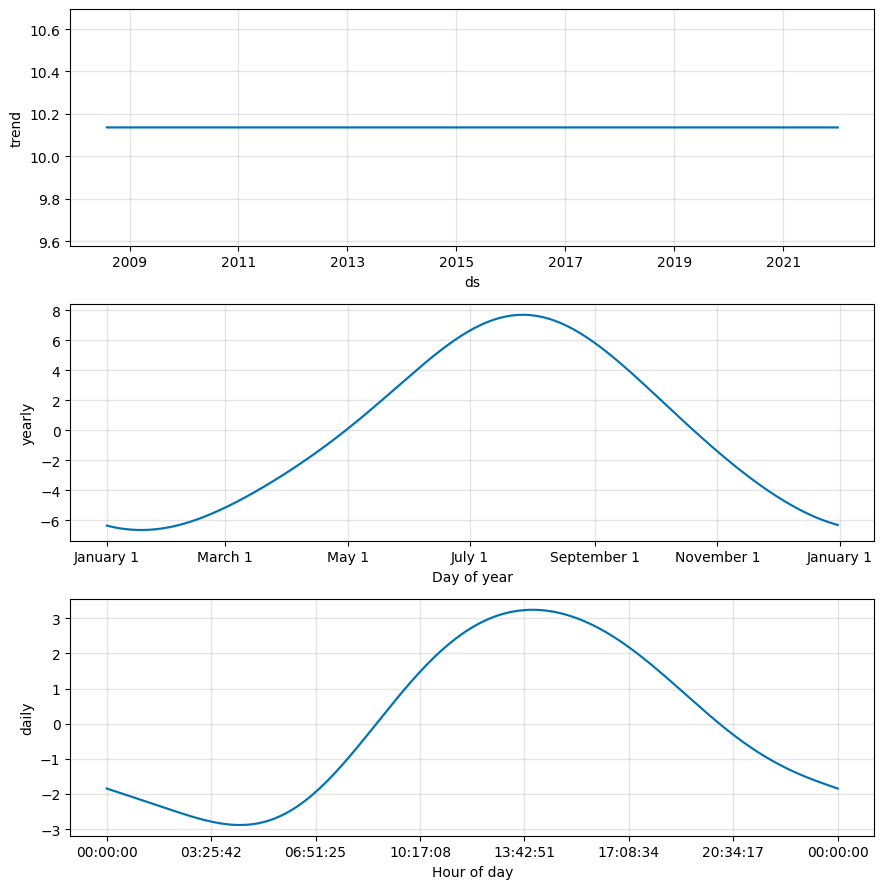

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  declination_diff_1  y_ucm_level  y_ucm_yearly  \
ds                   ...                                                  
2008-08-01 00:00:00  ...                 0.0    10.446489      6.976573   
2008-08-01 00:30:00  ...                 0.0    10.446486      6.976270   
2008-08-01 01:00:00  ...                 0.0    10.446484      6.975966   
2008-08-01 01:30:00  ...                 0.0    10.446481      6.975661   
2008-08-01 02:00:00  ...                 0.0    10.446478      6.975355   
...                  ...                 ...          ...           ...   
2020-12-31 21:30:00  ...                 0.0     9.829844     -6.485532   
2020-12-31 22:00:00  ...                 0.0     9.829841     -6.486502   
2020-12-31 22:30:00  ...                 0.0     9.829838     -6.487470   
2020-12-31 23:00:00  ...                 0.0     9.829835     -6.488438   
2020-12-31 23:30:00  ...                 0.0     9.829832     -6.489405   

                     y_ucm_daily  y_ucm_res  dew.point_ucm_level  \
ds           

<ipython-input-13-186207976926>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df[col_name]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/_hghy_r1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/y0f0dk4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33024', 'data', 'file=/tmp/tmpj9nqec_z/_hghy_r1.json', 'init=/tmp/tmpj9nqec_z/y0f0dk4d.json', 'output', 'file=/tmp/tmpj9nqec_z/prophet_modelzsivvmqa/prophet_model-20240206145148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start p

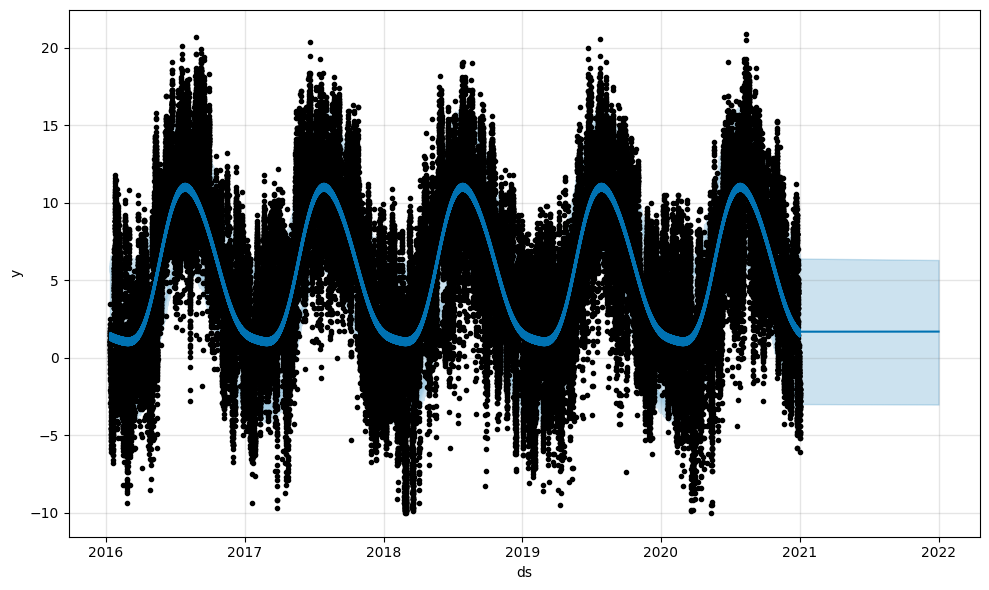

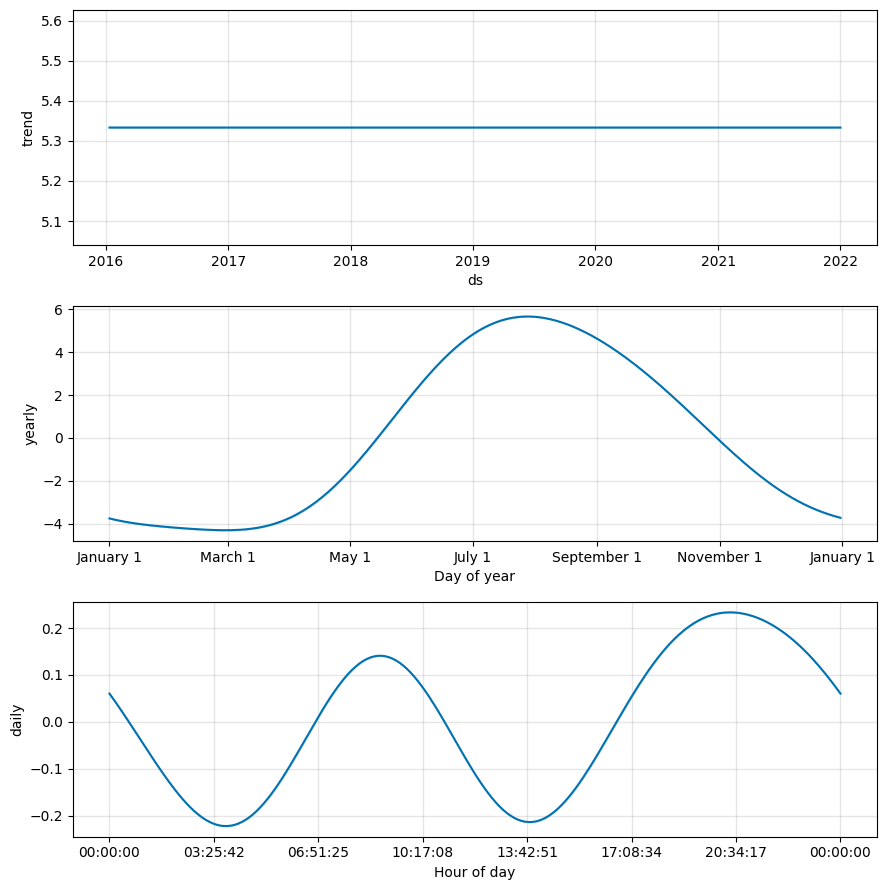

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  declination_diff_1  y_ucm_level  y_ucm_yearly  \
ds                   ...                                                  
2008-08-01 00:00:00  ...                 0.0    10.446489      6.976573   
2008-08-01 00:30:00  ...                 0.0    10.446486      6.976270   
2008-08-01 01:00:00  ...                 0.0    10.446484      6.975966   
2008-08-01 01:30:00  ...                 0.0    10.446481      6.975661   
2008-08-01 02:00:00  ...                 0.0    10.446478      6.975355   
...                  ...                 ...          ...           ...   
2020-12-31 21:30:00  ...                 0.0     9.829844     -6.485532   
2020-12-31 22:00:00  ...                 0.0     9.829841     -6.486502   
2020-12-31 22:30:00  ...                 0.0     9.829838     -6.487470   
2020-12-31 23:00:00  ...                 0.0     9.829835     -6.488438   
2020-12-31 23:30:00  ...                 0.0     9.829832     -6.489405   

                     y_ucm_daily  y_ucm_res  dew.point_ucm_level  \
ds           

<ipython-input-13-186207976926>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df[col_name]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/1mgmfl5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/vb41i1vw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40955', 'data', 'file=/tmp/tmpj9nqec_z/1mgmfl5e.json', 'init=/tmp/tmpj9nqec_z/vb41i1vw.json', 'output', 'file=/tmp/tmpj9nqec_z/prophet_modelkcpm7jq6/prophet_model-20240206145215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start p

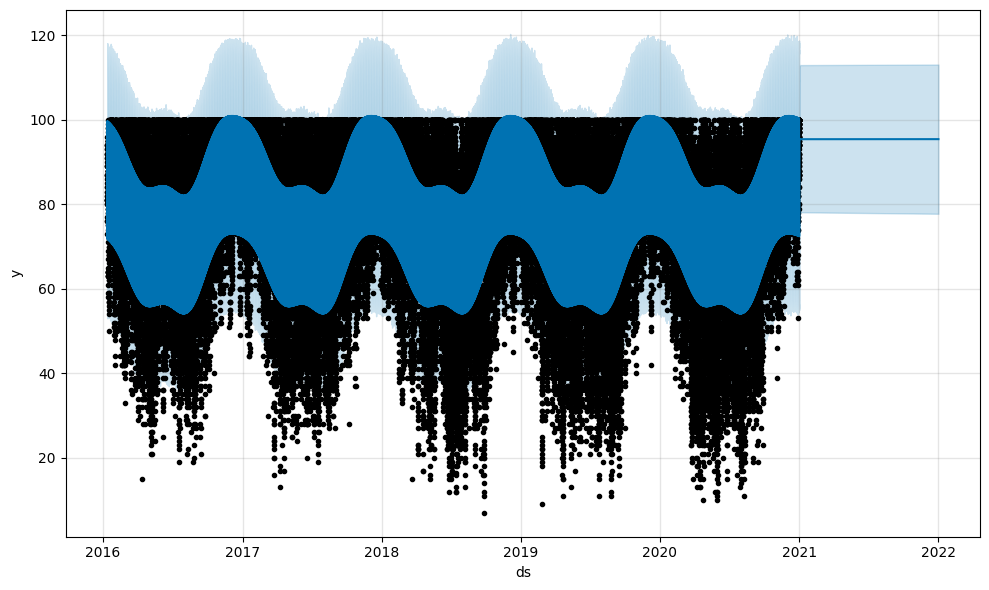

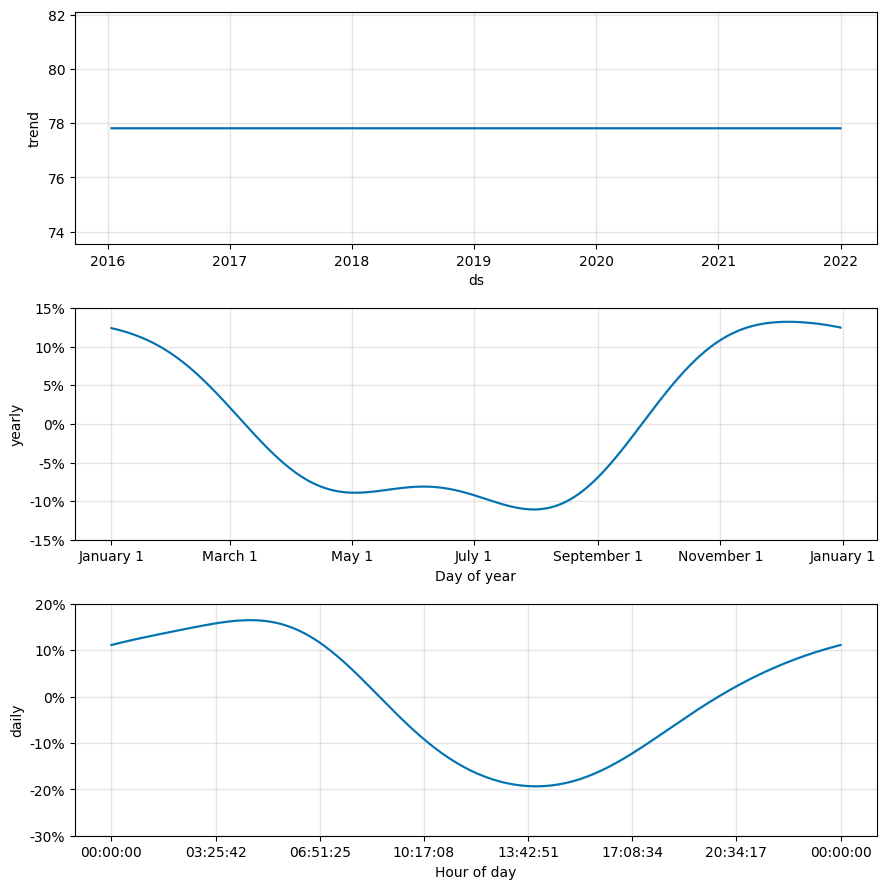

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  declination_diff_1  y_ucm_level  y_ucm_yearly  \
ds                   ...                                                  
2008-08-01 00:00:00  ...                 0.0    10.446489      6.976573   
2008-08-01 00:30:00  ...                 0.0    10.446486      6.976270   
2008-08-01 01:00:00  ...                 0.0    10.446484      6.975966   
2008-08-01 01:30:00  ...                 0.0    10.446481      6.975661   
2008-08-01 02:00:00  ...                 0.0    10.446478      6.975355   
...                  ...                 ...          ...           ...   
2020-12-31 21:30:00  ...                 0.0     9.829844     -6.485532   
2020-12-31 22:00:00  ...                 0.0     9.829841     -6.486502   
2020-12-31 22:30:00  ...                 0.0     9.829838     -6.487470   
2020-12-31 23:00:00  ...                 0.0     9.829835     -6.488438   
2020-12-31 23:30:00  ...                 0.0     9.829832     -6.489405   

                     y_ucm_daily  y_ucm_res  dew.point_ucm_level  \
ds           

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/d4hnwgvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj9nqec_z/pdq7wp10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86462', 'data', 'file=/tmp/tmpj9nqec_z/d4hnwgvk.json', 'init=/tmp/tmpj9nqec_z/pdq7wp10.json', 'output', 'file=/tmp/tmpj9nqec_z/prophet_model9hw45vyx/prophet_model-20240206145245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


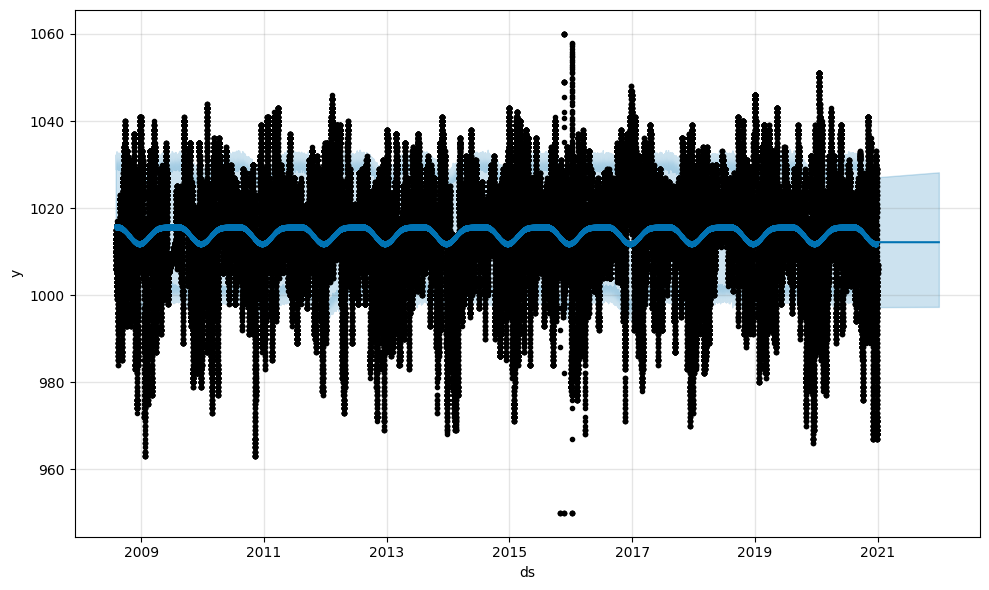

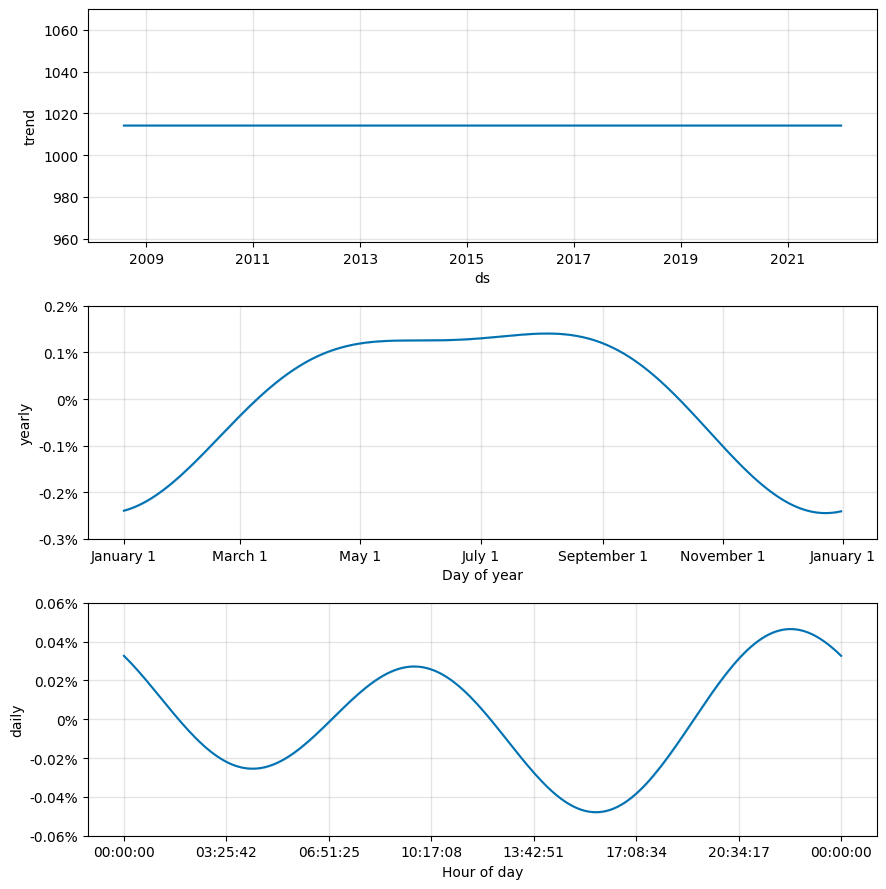

f_all:


y_trend   y_daily  y_yearly    y_yhat     y_des  \
key_0                                                                    
2016-01-12 00:00:00  10.136808 -1.843996 -6.607021  1.685791 -0.085791   
2016-01-12 00:30:00  10.136808 -1.987274 -6.607307  1.542227  0.457773   
2016-01-12 01:00:00  10.136808 -2.129682 -6.607593  1.399533  1.400467   
2016-01-12 01:30:00  10.136808 -2.274232 -6.607878  1.254698  0.745302   
2016-01-12 02:00:00  10.136808 -2.420156 -6.608162  1.108490  1.291510   
...                        ...       ...       ...       ...       ...   
2020-12-31 22:00:00  10.136808 -1.125864 -6.358769  2.652175 -5.852175   
2020-12-31 22:30:00  10.136808 -1.342326 -6.359480  2.435002 -6.035002   
2020-12-31 23:00:00  10.136808 -1.529351 -6.360190  2.247266 -6.647266   
2020-12-31 23:30:00  10.136808 -1.693909 -6.360900  2.081999 -6.881999   
2021-12-31 23:30:00  10.136808 -1.693909 -6.352330  2.090570       NaN   

                     dew.point_trend  dew.point_daily  dew.point_yearly  \
key_0                                                                     
2016-01-12 00:00:00         5.333283         0.060370         -3.945941   
2016-01-12 00:30:00         5.333283         0.013359         -3.946258   
2016-01-12 01:00:00         5.333283        -0.036143         -3.946576   
2016-01-12 01:30:00         5.333283        -0.085645         -3.946893   
2016-01-12 02:00:00         5.333283        -0.132068         -3.947210   
...                              ...              ...               ...   
2020-12-31 22:00:00         5.333283         0.196876         -3.748773   
2020-12-31 22:30:00         5.333283         0.171743         -3.749262   
2020-12-31 23:00:00         5.333283         0.140407         -3.749750   
2020-12-31 23:30:00         5.333283         0.103092         -3.750238   
2021-12-31 23:30:00         5.333283         0.103092         -3.744356   

                     dew.point_yhat  dew.point_des  humidity_trend  \
key_0                                                                
2016-01-12 00:00:00        1.447712      -0.447712         77.8159   
2016-01-12 00:30:00        1.400384      -0.300384         77.8159   
2016-01-12 01:00:00        1.350564      -0.450564         77.8159   
2016-01-12 01:30:00        1.300745      -0.300745         77.8159   
2016-01-12 02:00:00        1.254005      -0.454005         77.8159   
...                             ...            ...             ...   
2020-12-31 22:00:00        1.781385      -4.981385         77.8159   
2020-12-31 22:30:00        1.755764      -5.355764         77.8159   
2020-12-31 23:00:00        1.723939      -6.523939         77.8159   
2020-12-31 23:30:00        1.686136      -6.586136         77.8159   
2021-12-31 23:30:00        1.692018            NaN         77.8159   

                     humidity_daily  humidity_yearly  humidity_yhat  \
key_0                                                                 
2016-01-12 00:00:00        0.111100         0.116510      95.527529   
2016-01-12 00:30:00        0.119144         0.116491      96.152057   
2016-01-12 01:00:00        0.126462         0.116473      96.720031   
2016-01-12 01:30:00        0.133337         0.116454      97.253634   
2016-01-12 02:00:00        0.140003         0.116435      97.770871   
...                             ...              ...            ...   
2020-12-31 22:00:00        0.067262         0.124059      92.703760   
2020-12-31 22:30:00        0.080249         0.124047      93.713368   
2020-12-31 23:00:00        0.091823         0.124035      94.613064   
2020-12-31 23:30:00        0.102061         0.124023      95.408836   
2021-12-31 23:30:00        0.102061         0.124169      95.420204   

                     humidity_des  pressure_trend  pressure_daily  \
key_0                                                               
2016-01-12 00:00:00      1.004946      1014.18468        0.000326   
2016-01-12 00:30:00      0.977618      101

valid_df:


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  pressure_yearly  pressure_yhat      y_des  \
ds                   ...                                              
2020-12-29 00:00:00  ...        -0.002423    1012.058556  -1.241838   
2020-12-29 00:30:00  ...        -0.002423    1011.975801  -1.097733   
2020-12-29 01:00:00  ...        -0.002422    1011.883645  -1.354498   
2020-12-29 01:30:00  ...        -0.002422    1011.788527  -1.209122   
2020-12-29 02:00:00  ...        -0.002422    1011.696956  -1.462373   
...                  ...              ...            ...        ...   
2021-12-31 21:30:00  ...        -0.002396    1012.190999   9.535192   
2021-12-31 22:00:00  ...        -0.002395    1012.221113   9.821263   
2021-12-31 22:30:00  ...        -0.002395    1012.224442  10.005328   
2021-12-31 23:00:00  ...        -0.002395    1012.201496  10.015910   
2021-12-31 23:30:00  ...        -0.002395    1012.154480  10.187498   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds     

test_df:


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  pressure_yearly  pressure_yhat     y_des  \
ds                   ...                                             
2021-12-29 00:00:00  ...        -0.002423    1012.058556  6.976174   
2021-12-29 00:30:00  ...        -0.002423    1011.975801  7.126902   
2021-12-29 01:00:00  ...        -0.002422    1011.883645  7.037005   
2021-12-29 01:30:00  ...        -0.002422    1011.788527  6.662353   
2021-12-29 02:00:00  ...        -0.002422    1011.696956  6.809332   
...                  ...              ...            ...       ...   
2022-12-31 21:30:00  ...        -0.002396    1012.190999  6.696449   
2022-12-31 22:00:00  ...        -0.002395    1012.221113  7.347825   
2022-12-31 22:30:00  ...        -0.002395    1012.224442  7.564998   
2022-12-31 23:00:00  ...        -0.002395    1012.201496  7.352734   
2022-12-31 23:30:00  ...        -0.002395    1012.154480  7.118001   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds                  

train_df:


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  pressure_yearly  pressure_yhat     y_des  \
ds                   ...                                             
2008-08-01 00:00:00  ...         0.001405    1015.940620  4.048311   
2008-08-01 00:30:00  ...         0.001405    1015.857724  3.691924   
2008-08-01 01:00:00  ...         0.001405    1015.765425  3.434669   
2008-08-01 01:30:00  ...         0.001405    1015.670164  3.579557   
2008-08-01 02:00:00  ...         0.001405    1015.578450  3.725821   
...                  ...              ...            ...       ...   
2020-12-31 21:30:00  ...        -0.002396    1012.190999 -5.703551   
2020-12-31 22:00:00  ...        -0.002395    1012.221113 -5.852175   
2020-12-31 22:30:00  ...        -0.002395    1012.224442 -6.035002   
2020-12-31 23:00:00  ...        -0.002395    1012.201496 -6.647266   
2020-12-31 23:30:00  ...        -0.002395    1012.154480 -6.881999   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds                                                                      

df shape:  (252768, 84)
train shape:    (217728, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
ERROR: Overlap between train_df, valid_df indices!
max(train_df.index): 2020-12-31 23:30:00
min(valid_df.index): 2021-12-31 23:30:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_df.index: 2022-12-31 23:30:00 - 2022-12-31 23:30:00
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17664
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 17664

train_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: 34.237
mean after feature redundancy:  46.731



before   after diff
rows                    217728  217728    0
cols                        84     109   25
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       4    4
low_var_rows                 0       0    0
low_var_cols                 8      16    8
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: 33.227
mean after feature redundancy:  45.924



before  after diff
rows                    17664  17664    0
cols                       84    109   25
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   0      0    0
rows_with_nas               0      0    0
cols_with_nas               0      0    0
single_value_cols           0      4    4
low_var_rows                0      0    0
low_var_cols               10     18    8
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0


test_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: 33.222
mean after feature redundancy:  45.942



before  after diff
rows                    17664  17664    0
cols                       84    109   25
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   0      0    0
rows_with_nas               0      0    0
cols_with_nas               0      0    0
single_value_cols           1      5    4
low_var_rows                0      0    0
low_var_cols                9     17    8
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0

WARN: train_sanity != valid_sanity


before after diff
low_var_cols      8    16    8
low_var_cols     10    18    8

WARN: train_sanity != test_sanity


before after diff
single_value_cols      0     4    4
low_var_cols           8    16    8
single_value_cols      1     5    4
low_var_cols           9    17    8

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      1     5    4
low_var_cols           9    17    8
single_value_cols      0     4    4
low_var_cols          10    18    8

In [13]:
def merge_decompositions(df, decomps):
  '''NOTE: changes made here may also need to be made in add_prophet_components function'''

  decomp_cols  = ['y', 'dew.point', 'humidity', 'pressure']#, 'wind.speed.mean']
  decomp_terms = ['daily', 'yearly', 'des']

  # df_drop_cols = [j + '_' + i for i in decomp_terms for j in decomp_cols]
  # df.drop(df_drop_cols, axis=1, inplace=True)

  # decomps_drop_cols = [j + '_des' for j in decomp_cols]
  # decomps.drop(decomps_drop_cols, axis=1, inplace=True)

  df = df[~df.index.duplicated(keep='first')]
  decomps = decomps[~decomps.index.duplicated(keep='first')]

  # Merge on month, day, time

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute
  decomps['month']  = decomps.index.month
  decomps['day']    = decomps.index.day
  decomps['hour']   = decomps.index.hour
  decomps['minute'] = decomps.index.minute

  merge_cols = ['month','day','hour','minute']
  df = df.merge(decomps, on=merge_cols)
  # df = pd.merge(df, decomps, left_on=df.index, right_on=decomps.index)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  # df.drop('key_0', axis=1, inplace=True)
  df.drop(merge_cols, axis=1, inplace=True)

  for j in decomp_cols:
    if j in ['y', 'dew.point']:
      df[j + '_des'] = df[j] - df[j + '_yhat']
    elif j in ['humidity', 'pressure']:
      df[j + '_des'] = df[j] / df[j + '_yhat']
      # df[j + '_des'] = df[j] - df[j + '_yhat']
      # df[j + '_des'] = np.log(df[j]) / df[j + '_yhat']
    #elif j in ['wind.speed.mean']:
    #  df[j + '_des'] = np.sqrt(df[j]) / df[j + '_yhat']
    #
    #  for var in ['_daily', '_yearly', '_des', '_yhat']:
    #    df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean', var)
    df[j + '_des_diff_1'] = df[j + '_des'].diff(1)

  # df = df.dropna()
  df = df.asfreq(freq='30min', fill_value=np.nan)

  return df


def add_prophet_components(df, m, col_name):  #, l_frac = 3000):
  '''NOTE: changes made here may also need to be made in merge_decompositions function'''

  # lmbda = 0.0

  if col_name == 'y':
    df['y'] = df['y_orig']
  elif col_name == 'dew.point':
    df['y'] = df[col_name]
  elif col_name == 'pressure':
    df['y'] = df[col_name]
    # x = np.log(df[col_name])
    # df['y'] = x
  elif col_name ==  'humidity':
    df['y'] = df[col_name]
    # x = np.log(df[col_name])
    # df['y'] = x
    # x, lmbda = stats.boxcox(df[col_name])
    # df['y'] = x
    # print('lambda:', lmbda)
  elif col_name == 'wind.speed.mean':
    x = np.sqrt(df[col_name])
    df['y'] = x

  m.fit(df)
  future = m.make_future_dataframe(periods=1, freq='Y').dropna()
  forecast = m.predict(future)
  m.plot(forecast)
  m.plot_components(forecast)
  plt.show()

  # year_ex = 2018
  # n = YEARLY_OBS
  # df['year'] = df['ds'].dt.year
  # y_l = lowess(df.loc[df.year == year_ex, col_name + '_yearly'], df.loc[df.year == year_ex, 'ds'], frac=l_frac / YEARLY_OBS)
  # df.loc[df.year == year_ex, col_name + '_yearly'].head(n).plot()
  # plt.plot(df.loc[df.year == year_ex, 'ds'].head(n), y_l[:n, 1], 'blue', label='lowess fit')
  # plt.title(col_name + ' yearly')
  # plt.show()

  # n = DAILY_OBS * 2 + 1
  # n = DAILY_OBS + 1
  # df.loc[df.year == year_ex, col_name + '_daily'].head(n).plot()
  # plt.axvline(x=pd.to_datetime('2018-01-01 00:00:00'), color='black', lw=1)  # why did this line suddenly stop working!
  # plt.axvline(x=pd.to_datetime('00:00 02-Jan-2018'), color='black', lw=1)
  # plt.axvline(x=pd.Timestamp('00:00 02-Jan-2018'), color='black', lw=1)
  # plt.axvline(x=df.index.values[48], color='black', lw=1)
  # somewhere someone is watching the world burn
  # plt.title(col_name + ' daily')
  # plt.show()

  forecast.set_index('ds', drop=False, inplace=True)
  f_cols_old = ['trend', 'daily', 'yearly', 'yhat']
  forecast.rename(columns={f_col: col_name + '_' + f_col for f_col in f_cols_old},
                  inplace=True)

  if col_name in ['y', 'dew.point']:
    forecast[col_name + '_des'] = df['y'] - forecast[col_name + '_yhat']
  elif col_name in ['humidity', 'pressure', 'wind.speed.mean']:
    # forecast[col_name + '_des'] = df['y'] - forecast[col_name + '_yhat']
    forecast[col_name + '_des'] = df['y'] / forecast[col_name + '_yhat']
  #if col_name in ['y', 'dew.point', 'wind.speed.mean']:
  #  forecast[col_name + '_des'] = df['y'] - forecast['yhat']
  #else:
  #  forecast[col_name + '_des'] = df['y'] - special.inv_boxcox(forecast['yhat'], lmbda)

  f_cols_new = [col_name + '_' + f_col for f_col in f_cols_old]
  f_cols_new.append(col_name + '_des')

  forecast = forecast[f_cols_new]
  # print('df:', df.shape)
  # print('forecast:', forecast.shape)

  ## drop_cols = [col_name + '_' + i for i in ['daily', 'yearly', 'des']]
  ## df.drop(drop_cols, axis=1, inplace=True)
  # df = pd.merge(df, forecast, left_on=df.index, right_on=forecast.index)
  # df.set_index('ds', drop=False, inplace=True)
  # df.drop(['key_0'], axis=1, inplace=True)
  ## df = df.dropna()
  # df = df.asfreq(freq='30min', fill_value=np.nan)
  # return df, forecast

  return forecast


train_df_orig = train_df.copy()
valid_df_orig = valid_df.copy()
test_df_orig  = test_df.copy()

train_df['y_orig'] = train_df['y']
col_name = 'y'
m1 = Prophet(yearly_seasonality = 3,
             daily_seasonality  = 3,
             weekly_seasonality = False,
             growth = 'flat')
f1 = add_prophet_components(train_df, m1, col_name)
display(train_df)

col_name = 'dew.point'
m2 = Prophet(yearly_seasonality = 3,
             daily_seasonality  = 3,
             weekly_seasonality = False,
             growth = 'flat')
f2 = add_prophet_components(train_df.loc['2016-01-12':,], m2, col_name)
display(train_df)

col_name = 'humidity'
m3 = Prophet(yearly_seasonality = 3,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             seasonality_prior_scale = 100,
             growth = 'flat')
f3 = add_prophet_components(train_df.loc['2016-01-12':,], m3, col_name)
display(train_df)

col_name = 'pressure'
m4 = Prophet(yearly_seasonality = 2,
             daily_seasonality  = 2,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             seasonality_prior_scale = 100,
             growth = 'flat')
f4 = add_prophet_components(train_df, m4, col_name)

#col_name = 'wind.speed.mean'
#m5 = Prophet(yearly_seasonality = 2,
#             daily_seasonality  = True,
#             weekly_seasonality = False,
#             seasonality_mode   = 'multiplicative',
#             growth = 'flat')
#train_df, f5 = add_prophet_components(train_df, m5, col_name, 6000)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
#wd_rad = train_df['wind.bearing.mean'] * np.pi / 180  # Convert to radians
#
#for var in ['_daily', '_yearly', '_des', '_yhat']:
#  wv = train_df['wind.speed.mean' + var]
#
#  # Calculate the wind x and y components
#  train_df['wind.speed.mean.x' + var] = wv * np.cos(wd_rad)
#  train_df['wind.speed.mean.y' + var] = wv * np.sin(wd_rad)

#for var in ['_daily', '_yearly', '_des', '_yhat']:
#  train_df = convert_wind_to_xy(train_df, 'wind.speed.mean', 'wind.bearing.mean', var)

train_df['y'] = train_df['y_orig']
train_df.drop('y_orig', inplace=True, axis=1)
# display(train_df)


f_all = pd.merge(f1, f2, left_on=f1.index, right_on=f2.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f3, left_on=f_all.index, right_on=f3.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f4, left_on=f_all.index, right_on=f4.index)
f_all.set_index('key_0', inplace=True)
#f_all = pd.merge(f_all, f5, left_on=f_all.index, right_on=f5.index)
#f_all.set_index('key_0', inplace=True)
print('f_all:')
display(f_all)


decomps_drop_cols = [j + '_des' for j in ['y', 'dew.point', 'humidity', 'pressure']]
f_all.drop(decomps_drop_cols, axis=1, inplace=True)

valid_df = merge_decompositions(valid_df, f_all)
print('valid_df:')
display(valid_df)
valid_df = valid_df.fillna(method='bfill')  # Small number of NAs in 1st row

test_df  = merge_decompositions(test_df,  f_all)
print('test_df:')
display(test_df)
test_df = test_df.fillna(method='bfill')  # Small number of NAs in 1st row

train_df  = merge_decompositions(train_df,  f_all)
print('train_df:')
display(train_df)
train_df = train_df.fillna(method='bfill')  # Small number of NAs in 1st row

# Add Boruta-style "shadow" variables for feature selection
train_df['y_des_shadow'] = np.random.permutation(train_df['y_des'])
valid_df['y_des_shadow'] = np.random.permutation(valid_df['y_des'])
test_df['y_des_shadow']  = np.random.permutation( test_df['y_des'])


#merge_cols = ['month', 'day', 'hour', 'minute']
#train_df.drop(merge_cols, inplace=True, axis=1)

#del_cols = ['ds']
#train_df = train_df.drop(del_cols, axis = 1)
#valid_df = valid_df.drop(del_cols, axis = 1)
#test_df  = test_df.drop(del_cols,  axis = 1)
print_train_valid_test_shapes(df, train_df, valid_df, test_df)
sanity_check_train_valid_test(train_df, valid_df, test_df)

train_des_sanity = sanity_check_before_after_dfs(train_df_orig, train_df, 'train_df')
valid_des_sanity = sanity_check_before_after_dfs(valid_df_orig, valid_df, 'valid_df')
test_des_sanity  = sanity_check_before_after_dfs(test_df_orig,  test_df,  'test_df')
compare_train_valid_test_sanity_dfs(train_des_sanity, valid_des_sanity, test_des_sanity)
check_high_low_thresholds(train_df)
check_high_low_thresholds(valid_df)
check_high_low_thresholds(test_df)


The prophet seasonal decompositions take quite a while to run.
Similar to the UCM decomposition, temperature and dew point seem to be acceptbible but humidity and pressure are questionable and the `wind.speed.mean` decomposition is unusable.  I've removed the `wind.speed.mean` decomposition.

---

#### Calculate simple rolling statistics

Add simple and fast to calculate rolling statistics.

Features:
 * `y`
 * `dew.point`
 * `y_des`
 * `dew.point_des`
 * `pressure`
 * `humidity`

Functions:
 * minimum
 * maximum
 * mean
 * standard deviation
 * skew
 * kurtosis
 * auto-correlation

Windows:
 * 12, 24, 48, 96


In [14]:
def get_rolling_stat_features(data, feat_cols, windows, aggs, verbose=False, shift_=1):

  aggs_l = []  # Prevents highly fragmented dataframes

  for feat_col in feat_cols:
    agg = pd.DataFrame(index=data.index)  # Prevents highly fragmented dataframes
    for window in windows:
      rol = data[feat_col].shift(shift_).rolling(window=window, min_periods=1,)
      new_col_name = feat_col + '_window_' + str(window) + '_'

      agg[new_col_name + 'min']  = rol.min()
      agg[new_col_name + 'max']  = rol.max()
      agg[new_col_name + 'std']  = rol.std()
      agg[new_col_name + 'mean'] = rol.mean()
      agg[new_col_name + 'skew'] = rol.skew()
      agg[new_col_name + 'kurt'] = rol.kurt()
      agg[new_col_name + 'quantile_25'] = rol.quantile(.25)
      agg[new_col_name + 'quantile_75'] = rol.quantile(.75)

      # faster than np.p2p
      agg[new_col_name + 'peak2peak'] = rol.agg(['min', 'max']).diff(axis=1)['max']

      # Slow  Doubt if its worth it :-(
      # TODO https://stackoverflow.com/questions/46470743/how-to-efficiently-compute-a-rolling-unique-count-in-a-pandas-time-series
      # agg[new_col_name + 'nunique'] = rol.apply(lambda x: np.unique(x).shape[0])

    # From https://stackoverflow.com/a/43748653/100129
    #data[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))
    # data[new_col_name + 'autocorr'] = rol.corr(data[feat_col].shift(1)) # NOPE
    #if feat_col in ['humidity', 'pressure']:
    #  # inf values with window = 48 - probably long sequences of equal values
    #  window = 96
    #else:
    #  window = 48

    agg[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))
    # Doubt if it's worth it
    # agg[new_col_name + 'autocorr_48'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(48))

    aggs_l.append(agg)  # Prevents highly fragmented dataframes

  aggs = pd.concat(aggs_l, axis=1)  # Prevents highly fragmented dataframes
  aggs = drop_problem_cols(aggs, window)
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


windows = [12, 24, 48, 96]
roll_cols = ['y', 'dew.point', 'y_des', 'dew.point_des', 'humidity', 'pressure']
stat_aggs = ['min', 'max', 'mean', 'std', 'skew', 'kurt', 'quantile', 'corr']
params_stat = {'windows':    windows,
               'feat_cols':  roll_cols,
               'aggs':       stat_aggs,
               'agg_func':   get_rolling_stat_features,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'roll_stats_',
               'date_str':   '.2022.09.20',
               'save_and_download': False,
               'save_to_gdrive': True,
              }

train_df_stat, valid_df_stat, test_df_stat = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_stat)


###############################################################################
# approx. 1 min - mostly dataframe checks
#           for dataframe statistics functions on valid_df, test_df & train_df
# 111 features added - 0 NAs
#
# windows = [12, 24, 48, 96]
# roll_cols = ['y', 'dew.point', 'y_des', 'dew.point_des', 'humidity', 'pressure']
# stat_aggs = ['min', 'max', 'mean', 'std', 'skew', 'kurt', 'corr']
# params_stat = {'windows':    windows,
#                'feat_cols':  roll_cols,
#                'aggs':       stat_aggs,
#                'agg_func':   get_rolling_stat_features,
#                'verbose':    True,
#                'dataset':    'valid',
#                'regenerate': True,
#                'feat_name':  'df_stats_',
#                'date_str':   '.2022.09.20',
#               }

dataset: valid
columns with null values:


y_window_12_min                1
y_window_12_max                1
y_window_12_std                2
y_window_12_skew               3
y_window_12_kurt               4
                              ..
pressure_window_96_max         1
pressure_window_96_std         2
pressure_window_96_skew        3
pressure_window_96_kurt        4
pressure_window_96_autocorr    2
Length: 120, dtype: int64

before: (17664, 109)
after:  (17664, 227)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  pressure_window_48_max  pressure_window_48_std  \
ds                   ...                                                   
2020-12-29 00:00:00  ...                     NaN                     NaN   
2020-12-29 00:30:00  ...              979.000000                     NaN   
2020-12-29 01:00:00  ...              979.000000                0.707107   
2020-12-29 01:30:00  ...              979.000000                0.577350   
2020-12-29 02:00:00  ...              979.000000                0.500000   
...                  ...                     ...                     ...   
2021-12-31 21:30:00  ...             1010.034567                0.197401   
2021-12-31 22:00:00  ...             1010.049436                0.198224   
2021-12-31 22:30:00  ...             1010.064737                0.199230   
2021-12-31 23:00:00  ...             1010.082097                0.200443   
2021-12-31 23:30:00  ...             1010.095954                0.201687   

                

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  pressure_window_48_max  \
count       17664.000000       1.766400e+04  ...            17663.000000   
mean          189.498771      -1.128775e+00  ...             1018.965266   
std            91.928312       3.704728e+00  ...               10.883479   
min             0.000000      -2.030000e+01  ...              979.000000   
25%           135.000000      -2.474874e+00  ...             1011.000000   
50%           225.000000      -2.204364e-16  ...             1020.000000   
75%           270.000000       1.000000e-01  ...             1027.000000   
max           360.000000       1.393000e+01  ...             1044.000000   

       pressure_window_48_std  pressure_window_48_skew  \
count            17662.000000             17661.000000   
mean                 2.081005                -0.063686   
std                  1.630390                 0.605678   
min                  0.000000                -2.396417   
25%                  0.921570                -0.448625   
50%                  1.543546                -0.062581   
75%                  2.781652                 0.300147   
max                 11.260436                 6.928203   

       pressure_window_48_kurt  pressure_window_96_min  \
count             17660.000000            17663.000000   
mean                 -0.634024             1009.505534   
std                   1.073339               13.391237   
min                  -3.000000              968.000000   
25%                  -1.209390             1001.886870   
50%                  -0.863472             1012.000000   
75%                  -0.331889             1019.000000   
max                  48.000000             1041.000000   

       pressure_window_96_max  pressure_window_96_std  \
count            17663.000000            17662.000000   
mean              1021.072191                3.476138   
std                 10.251291                2.347588   
min                979.000000                0.364866   
25%               1015.000000                1.716886   
50%               1022.000000                2.926952   
75%               1029.000000                4.638491   
max               1044.000000               14.994370   

       pressure_window_96_skew  pressure_window_96_kurt  \
count             17661.000000             17660.000000   
mean                 -0.130711                -0.722954   
std                   0.595416                 0.811323   
min                  -2.431871                -1.831184   
25%                  -0.532635                -1.264887   
50%                  -0.126800          

na_feats:


Series([], dtype: int64)

dataset: test
columns with null values:


y_window_12_min            1
y_window_12_max            1
y_window_12_std            2
y_window_12_skew           3
y_window_12_kurt           4
                          ..
pressure_window_96_max     1
pressure_window_96_std     2
pressure_window_96_mean    1
pressure_window_96_skew    3
pressure_window_96_kurt    4
Length: 123, dtype: int64

before: (17664, 109)
after:  (17664, 231)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  pressure_window_48_max  pressure_window_48_std  \
ds                   ...                                                   
2021-12-29 00:00:00  ...                     NaN                     NaN   
2021-12-29 00:30:00  ...             1007.854619                     NaN   
2021-12-29 01:00:00  ...             1007.871259                0.011766   
2021-12-29 01:30:00  ...             1007.888116                0.016748   
2021-12-29 02:00:00  ...             1007.904126                0.021351   
...                  ...                     ...                     ...   
2022-12-31 21:30:00  ...              998.000000                0.966642   
2022-12-31 22:00:00  ...              998.000000                1.021055   
2022-12-31 22:30:00  ...              998.000000                1.071057   
2022-12-31 23:00:00  ...              999.000000                1.166730   
2022-12-31 23:30:00  ...             1000.000000                1.311265   

                

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  pressure_window_48_max  \
count       17664.000000       1.766400e+04  ...            17663.000000   
mean          192.755036      -1.576942e+00  ...             1019.837080   
std            83.065626       3.535051e+00  ...                9.898514   
min             0.000000      -2.480000e+01  ...              983.000000   
25%           135.000000      -3.300000e+00  ...             1013.000000   
50%           224.440299      -1.010334e-15  ...             1020.000000   
75%           270.000000       0.000000e+00  ...             1026.000000   
max           350.000000       1.202082e+01  ...             1047.000000   

       pressure_window_48_std  pressure_window_48_skew  \
count            17662.000000             17661.000000   
mean                 2.233083                -0.060628   
std                  1.627751                 0.590659   
min                  0.011766                -2.005098   
25%                  1.071057                -0.451726   
50%                  1.746196                -0.069184   
75%                  2.946328                 0.286625   
max                 11.551227                 6.928203   

       pressure_window_48_kurt  pressure_window_96_min  \
count             17660.000000            17663.000000   
mean                 -0.674076             1009.996590   
std                   1.100429               11.948892   
min                  -2.088889              972.000000   
25%                  -1.233596             1003.000000   
50%                  -0.895601             1011.000000   
75%                  -0.377344             1018.000000   
max                  48.000000             1039.000000   

       pressure_window_96_max  pressure_window_96_std  \
count            17663.000000            17662.000000   
mean              1022.093775                3.629518   
std                  9.146677                2.342105   
min                991.000000                0.011766   
25%               1017.000000                1.809848   
50%               1022.000000                3.056199   
75%               1028.000000                4.950146   
max               1047.000000               12.811997   

       pressure_window_96_mean  pressure_window_96_skew  \
count             17663.000000             17661.000000   
mean               1016.324935                -0.067206   
std                  10.131158                 0.550980   
min                 982.375000                -2.347432   
25%                1009.818097                -0.409418   
50%                1016.760417          

na_feats:


Series([], dtype: int64)

dataset: train
columns with null values:


y_window_12_min            1
y_window_12_max            1
y_window_12_std            2
y_window_12_skew           3
y_window_12_kurt           4
                          ..
pressure_window_96_max     1
pressure_window_96_std     2
pressure_window_96_mean    1
pressure_window_96_skew    3
pressure_window_96_kurt    4
Length: 123, dtype: int64

before: (87696, 109)
after:  (87696, 231)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  pressure_window_48_max  pressure_window_48_std  \
ds                   ...                                                   
2016-01-01 00:00:00  ...                     NaN                     NaN   
2016-01-01 00:30:00  ...                  1019.0                     NaN   
2016-01-01 01:00:00  ...                  1020.0                0.707107   
2016-01-01 01:30:00  ...                  1021.0                1.000000   
2016-01-01 02:00:00  ...                  1021.0                0.957427   
...                  ...                     ...                     ...   
2020-12-31 21:30:00  ...                  1006.0                1.588969   
2020-12-31 22:00:00  ...                  1006.0                1.629597   
2020-12-31 22:30:00  ...                  1007.0                1.706137   
2020-12-31 23:00:00  ...                  1007.0                1.770398   
2020-12-31 23:30:00  ...                  1007.0                1.823677   

                     pressure_window_48_skew  pressure_window_48_kur

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  pressure_window_48_max  \
count       87696.000000       8.769600e+04  ...            87695.000000   
mean          196.378501      -1.587145e+00  ...             1018.437847   
std            82.781282       3.948823e+00  ...               11.020687   
min             0.000000      -2.880000e+01  ...              970.000000   
25%           135.000000      -3.464823e+00  ...             1012.000000   
50%           225.000000      -1.000000e-01  ...             1020.000000   
75%           270.000000       2.449294e-17  ...             1026.000000   
max           360.000000       2.050610e+01  ...             1058.000000   

       pressure_window_48_std  pressure_window_48_skew  \
count            87694.000000             87693.000000   
mean                 2.342829                -0.080749   
std                  1.862302                 0.600770   
min                  0.000000                -6.928203   
25%                  1.084219                -0.468624   
50%                  1.814051                -0.080332   
75%                  3.015842                 0.295446   
max                 35.909303                 6.928203   

       pressure_window_48_kurt  pressure_window_96_min  \
count             87692.000000            87695.000000   
mean                 -0.644981             1008.064131   
std                   1.011909               13.282759   
min                  -3.000000              950.000000   
25%                  -1.219290             1001.000000   
50%                  -0.875853             1010.000000   
75%                  -0.345799             1017.000000   
max                  48.000000             1044.000000   

       pressure_window_96_max  pressure_window_96_std  \
count            87695.000000            87694.000000   
mean              1020.828643                3.841444   
std                 10.120015                2.663698   
min                979.000000                0.298734   
25%               1015.000000                1.946629   
50%               1022.000000                3.175288   
75%               1027.000000                5.073106   
max               1058.000000               29.137051   

       pressure_window_96_mean  pressure_window_96_skew  \
count             87695.000000             87693.000000   
mean               1014.755927                -0.111416   
std                  11.312914                 0.605039   
min                 971.072917                -3.912115   
25%                1007.697917                -0.507445   
50%                1016.239583                -0.

na_feats:


Series([], dtype: int64)

r_test    f_test        mi
y_des_window_12_max                  0.042134  0.133039  0.042570
y_des_window_12_min                  0.041644  0.118076  0.042128
y_des_window_24_max                  0.038643  0.066194  0.034513
y_des_window_24_mean                 0.038580  0.065519  0.024267
y_des_window_24_min                  0.037396  0.054505  0.032091
y_des_window_48_mean                 0.036730  0.049467  0.022064
y_des_window_48_max                  0.036007  0.044722  0.028959
y_des_window_48_min                  0.035093  0.039582  0.027378
dew.point_des_window_12_max          0.034653  0.037390  0.021900
dew.point_des_window_24_max          0.033575  0.032657  0.021935
dew.point_des_window_12_quantile_25  0.032396  0.028317  0.017220
dew.point_des                        0.032145  0.027489  0.015490
y_des_window_96_mean                 0.031800  0.026396  0.016065
dew.point_des_window_48_mean         0.031717  0.026141  0.015616
dew.point_des_window_48_max          0.031391  0.025167  0.020721
y_des_window_96_min                  0.030141  0.021802  0.023115
y_des_window_96_max                  0.029859  0.021117  0.023832
dew.point_des_window_12_min          0.028342  0.017807  0.017216
dew.point_des_window_96_mean         0.028053  0.017244  0.013561
dew.point_des_window_24_min          0.027481  0.016179  0.017461
dew.point_des_window_96_max          0.026930  0.015218  0.018976
dew.point_des_window_48_min          0.024628  0.011770  0.016662
y_window_12_min                      0.021573  0.008288  0.009977
dew.point_window_12_max              0.020503  0.007296  0.013471
dew.point_des_window_96_min          0.020307  0.007125  0.016481
y_window_12_max                      0.020193  0.007027  0.009628
y_window_24_min                      0.019480  0.006436  0.009952
dew.point_window_12_min              0.018343  0.005574  0.012213
dew.point_window_48_max              0.017465  0.004969  0.015230
dew.point_window_48_quantile_25      0.017372  0.004907  0.011333
y_window_48_min                      0.016822  0.004556  0.009366
y_window_48_max                      0.016238  0.004203  0.010552
dew.point_window_48_min              0.015908  0.004012  0.014963
dew.point_window_96_max              0.013702  0.002879  0.015721
dew.point_window_96_quantile_25      0.013382  0.002734  0.010809
y_window_96_min                      0.012251  0.002258  0.008927
dew.point_window_96_min              0.012092  0.002196  0.015608
humidity                            -0.011791  0.002081  0.002765
y_window_96_std                      0.009464  0.001309  0.006208
pressure_window_96_skew             -0.008396  0.001021  0.002742

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 232)
valid shape:    (17520, 227)
test shape:     (17520, 231)
df shape:  (252768, 84)
train shape:    (87168, 220)
valid shape:    (17520, 220)
test shape:     (17520, 220)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  42.4



before  after  diff
rows                    87696  87168  -528
cols                      109    220   111
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  42.201



before  after  diff
rows                    17664  17520  -144
cols                      109    220   111
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  42.045



before  after  diff
rows                    17664  17520  -144
cols                      109    220   111
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0

111 features added (0 NAs) in approximately 1 min.

This is a huge number of features.  All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive which is not publicly shared.

---

#### Calculate cross-correlation statistics

Calculate bivariate correlation between core features:

bivariate features:
 * `y`, `dew.point`
 * `y`, `pressure`
 * `y_des`, `dew.point_des`
 * `humidity`, `pressure`
 * `pressure`, `dew.point`

windows:
 * 48
 * 96

In [15]:


def get_rolling_cross_corr_stats(data, feat_cols, windows, aggs, verbose=False, shift_=1):
  '''Cross-correlation between features'''

  aggs = pd.DataFrame(index=data.index)

  inf_val_cols = ['humidity', 'pressure']

  for feat1, feat2 in feat_cols:
    # print('feats:', feat1, feat2)
    #if feat1 in inf_val_cols or feat2 in inf_val_cols:
    #  # inf values with window = 48 - probably long sequences of equal values
    #  window = 96
    #else:
    #  window = 48
    # print('window:', window)
    for window in windows:

      # rol = data[feat1].shift(shift_).rolling(window=window, min_periods=1,)
      new_col_name_12 = feat1 + '_' + feat2 + '_window_' + str(window) + '_ccorr'
      new_col_name_21 = feat2 + '_' + feat1 + '_window_' + str(window) + '_ccorr'

      # From https://stackoverflow.com/a/43748653/100129
      # data[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))
      # data[new_col_name + 'autocorr'] = rol.corr(data[feat_col].shift(1)) # NOPE
      aggs[new_col_name_12] = data[feat1].rolling(window=window, min_periods=window,).corr(data[feat2].shift(1))
      aggs[new_col_name_21] = data[feat2].rolling(window=window, min_periods=window,).corr(data[feat1].shift(1))

  aggs = drop_problem_cols(aggs, window)
  keep_cols = ['y_des', 'dew.point_des', 'pressure', 'humidity']
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[keep_cols])

  return aggs


windows = [48, 96, 144]
ccor_cols = [['y', 'dew.point'],
             ['y', 'pressure'],
             ['y', 'humidity'],  # inf values
             ['y', 'irradiance'],
             ['y_des', 'dew.point_des'],
             ['y_des', 'humidity'],  # inf values
             ['y_des', 'pressure'],
             ['y_des', 'irradiance'],
             ['dew.point_des', 'humidity'],
             ['dew.point_des', 'pressure'],
             ['humidity', 'dew.point'],  # inf values
             ['humidity', 'pressure'],
             ['pressure', 'dew.point'],
            ]
ccor_aggs = ['corr']
params_ccor = {'windows':    windows,
               'feat_cols':  ccor_cols,
               'aggs':       ccor_aggs,
               'agg_func':   get_rolling_cross_corr_stats,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'cross_corr_',
               'date_str':   '.2022.09.20',
               'save_and_download': True,
               'save_to_gdrive': False,
              }

train_df_ccor, valid_df_ccor, test_df_ccor = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_ccor)


###############################################################################
# 30 secs - mostly dataframe checks
#           for dataframe statistics functions on valid_df, test_df & train_df
# 29 features added - 0 NAs
#
# windows = [48, 96, 144]
# ccor_cols = [['y', 'dew.point'],
#              ['y', 'pressure'],
#              ['y', 'humidity'],  # inf values
#              ['y', 'irradiance'],
#              ['y_des', 'dew.point_des'],
#              ['y_des', 'humidity'],  # inf values
#              ['y_des', 'pressure'],
#              ['y_des', 'irradiance'],
#              ['dew.point_des', 'humidity'],
#              ['dew.point_des', 'pressure'],
#              ['humidity', 'dew.point'],  # inf values
#              ['humidity', 'pressure'],
#              ['pressure', 'dew.point'],]
# ccor_aggs = ['corr']
# params_stat = {'windows':    windows,
#                'feat_cols':  ccor_cols,
#                'aggs':       ccor_aggs,
#                'agg_func':   get_rolling_cross_corr_stats,
#                'verbose':    True,
#                'dataset':    'valid',
#                'regenerate': True,
#                'feat_name':  'cross_corr_',
#                'date_str':   '.2022.09.20', }

dataset: valid
columns with null values:


y_dew.point_window_48_ccorr                 48
y_dew.point_window_96_ccorr                 96
y_dew.point_window_144_ccorr               144
y_pressure_window_96_ccorr                  96
y_pressure_window_144_ccorr                144
y_humidity_window_48_ccorr                  48
y_humidity_window_96_ccorr                  96
y_humidity_window_144_ccorr                144
y_irradiance_window_48_ccorr                48
y_irradiance_window_96_ccorr                96
y_irradiance_window_144_ccorr              144
y_des_dew.point_des_window_48_ccorr         48
y_des_dew.point_des_window_96_ccorr         96
y_des_dew.point_des_window_144_ccorr       144
y_des_humidity_window_48_ccorr              48
y_des_humidity_window_96_ccorr              96
y_des_humidity_window_144_ccorr            144
y_des_pressure_window_96_ccorr              96
y_des_pressure_window_144_ccorr            144
y_des_irradiance_window_48_ccorr            48
y_des_irradiance_window_96_ccorr            96
y_des_irradia

before: (17664, 109)
after:  (17664, 139)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  y_des_irradiance_window_96_ccorr  \
ds                   ...                                     
2020-12-29 00:00:00  ...                               NaN   
2020-12-29 00:30:00  ...                               NaN   
2020-12-29 01:00:00  ...                               NaN   
2020-12-29 01:30:00  ...                               NaN   
2020-12-29 02:00:00  ...                               NaN   
...                  ...                               ...   
2021-12-31 21:30:00  ...                         -0.404113   
2021-12-31 22:00:00  ...                         -0.407104   
2021-12-31 22:30:00  ...                         -0.409394   
2021-12-31 23:00:00  ...                         -0.410560   
2021-12-31 23:30:00  ...                         -0.411333   

                     y_des_irradiance_window_144_ccorr  \
ds                                                       
2020-12-29 00:00:00                                NaN   
2020-12-29 00:30:00     

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          189.498771      -1.128775e+00  ...   
std            91.928312       3.704728e+00  ...   
min             0.000000      -2.030000e+01  ...   
25%           135.000000      -2.474874e+00  ...   
50%           225.000000      -2.204364e-16  ...   
75%           270.000000       1.000000e-01  ...   
max           360.000000       1.393000e+01  ...   

       y_des_irradiance_window_96_ccorr  y_des_irradiance_window_144_ccorr  \
count                      17568.000000                       17520.000000   
mean                          -0.007584                           0.000525   
std                            0.430345                           0.370648   
min                           -0.826841                          -0.774325   
25%                           -0.384757                          -0.298737   
50%                           -0.058802                          -0.056887   
75%                            0.382335                           0.316605   
max                            0.853556                           0.792928   

       dew.point_des_humidity_window_48_ccorr  \
count                            17616.000000   
mean                                 0.202168   
std                                  0.399223   
min                                 -0.850154   
25%                                 -0.090990   
50%                                  0.228463   
75%                                  0.536190   
max                                  0.944630   

       dew.point_des_humidity_window_96_ccorr  \
count                            17568.000000   
mean                                 0.264222   
std                                  0.339805   
min                                 -0.797892   
25%                                  0.033684   
50%                                  0.315277   
75%                                  0.535253   
max                                  0.942191   

       dew.point_des_humidity_window_144_ccorr  \
count                             17520.000000   
mean                                  0.289026   
std                                   0.301836   
min                                  -0.803789   
25%                                   0.090785   
50%                                   0.345997   
75%                                   0.526701   
max                                   0.906979   

       dew.point_des_pressure_window_96_ccorr  \
count                            17568.000000   
mean                              

na_feats:


humidity_pressure_window_48_ccorr    9
dtype: int64

interpolate: humidity_pressure_window_48_ccorr
dataset: test
columns with null values:


y_dew.point_window_48_ccorr                 48
y_dew.point_window_96_ccorr                 96
y_dew.point_window_144_ccorr               144
y_pressure_window_48_ccorr                  48
y_pressure_window_96_ccorr                  96
y_pressure_window_144_ccorr                144
y_humidity_window_48_ccorr                  48
y_humidity_window_96_ccorr                  96
y_humidity_window_144_ccorr                144
y_irradiance_window_48_ccorr                48
y_irradiance_window_96_ccorr                96
y_irradiance_window_144_ccorr              144
y_des_dew.point_des_window_48_ccorr         48
y_des_dew.point_des_window_96_ccorr         96
y_des_dew.point_des_window_144_ccorr       144
y_des_humidity_window_48_ccorr              48
y_des_humidity_window_96_ccorr              96
y_des_humidity_window_144_ccorr            144
y_des_pressure_window_48_ccorr              48
y_des_pressure_window_96_ccorr              96
y_des_pressure_window_144_ccorr            144
y_des_irradia

before: (17664, 109)
after:  (17664, 142)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  y_des_irradiance_window_144_ccorr  \
ds                   ...                                      
2021-12-29 00:00:00  ...                                NaN   
2021-12-29 00:30:00  ...                                NaN   
2021-12-29 01:00:00  ...                                NaN   
2021-12-29 01:30:00  ...                                NaN   
2021-12-29 02:00:00  ...                                NaN   
...                  ...                                ...   
2022-12-31 21:30:00  ...                          -0.296156   
2022-12-31 22:00:00  ...                          -0.297025   
2022-12-31 22:30:00  ...                          -0.297785   
2022-12-31 23:00:00  ...                          -0.298662   
2022-12-31 23:30:00  ...                          -0.299084   

                     dew.point_des_humidity_window_48_ccorr  \
ds                                                            
2021-12-29 00:00:00                                     NaN

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          192.755036      -1.576942e+00  ...   
std            83.065626       3.535051e+00  ...   
min             0.000000      -2.480000e+01  ...   
25%           135.000000      -3.300000e+00  ...   
50%           224.440299      -1.010334e-15  ...   
75%           270.000000       0.000000e+00  ...   
max           350.000000       1.202082e+01  ...   

       y_des_irradiance_window_144_ccorr  \
count                       17520.000000   
mean                            0.150810   
std                             0.373381   
min                            -0.682214   
25%                            -0.172848   
50%                             0.175949   
75%                             0.471541   
max                             0.846298   

       dew.point_des_humidity_window_48_ccorr  \
count                            17616.000000   
mean                                 0.217174   
std                                  0.398052   
min                                 -0.876245   
25%                                 -0.072751   
50%                                  0.277949   
75%                                  0.542533   
max                                  0.933835   

       dew.point_des_humidity_window_96_ccorr  \
count                            17568.000000   
mean                                 0.273669   
std                                  0.310824   
min                                 -0.697611   
25%                                  0.069781   
50%                                  0.339936   
75%                                  0.512589   
max                                  0.887919   

       dew.point_des_humidity_window_144_ccorr  \
count                             17520.000000   
mean                                  0.298361   
std                                   0.262827   
min                                  -0.534666   
25%                                   0.133298   
50%                                   0.346994   
75%                                   0.491715   
max                                   0.879494   

       dew.point_des_pressure_window_48_ccorr  \
count                            17616.000000   
mean                                -0.128145   
std                                  0.450188   
min                                 -0.971519   
25%                                 -0.503124   
50%                                 -0.134700   
75%                                  0.220570   
max                                  0.968070 

na_feats:


Series([], dtype: int64)

dataset: train
columns with null values:


y_dew.point_window_48_ccorr                 48
y_dew.point_window_96_ccorr                 96
y_dew.point_window_144_ccorr               144
y_pressure_window_96_ccorr                  96
y_pressure_window_144_ccorr                144
y_humidity_window_48_ccorr                  48
y_humidity_window_96_ccorr                  96
y_humidity_window_144_ccorr                144
y_irradiance_window_48_ccorr                48
y_irradiance_window_96_ccorr                96
y_irradiance_window_144_ccorr              144
y_des_dew.point_des_window_48_ccorr         48
y_des_dew.point_des_window_96_ccorr         96
y_des_dew.point_des_window_144_ccorr       144
y_des_humidity_window_48_ccorr              48
y_des_humidity_window_96_ccorr              96
y_des_humidity_window_144_ccorr            144
y_des_pressure_window_96_ccorr              96
y_des_pressure_window_144_ccorr            144
y_des_irradiance_window_48_ccorr            48
y_des_irradiance_window_96_ccorr            96
y_des_irradia

before: (87696, 109)
after:  (87696, 138)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  y_des_irradiance_window_48_ccorr  \
ds                   ...                                     
2016-01-01 00:00:00  ...                               NaN   
2016-01-01 00:30:00  ...                               NaN   
2016-01-01 01:00:00  ...                               NaN   
2016-01-01 01:30:00  ...                               NaN   
2016-01-01 02:00:00  ...                               NaN   
...                  ...                               ...   
2020-12-31 21:30:00  ...                         -0.599930   
2020-12-31 22:00:00  ...                         -0.599667   
2020-12-31 22:30:00  ...                         -0.599767   
2020-12-31 23:00:00  ...                         -0.596593   
2020-12-31 23:30:00  ...                         -0.591613   

                     y_des_irradiance_window_96_ccorr  \
ds                                                      
2016-01-01 00:00:00                               NaN   
2016-01-01 00:30:00                               NaN   
2016-01-01 01:00:00   

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       87696.000000       8.769600e+04  ...   
mean          196.378501      -1.587145e+00  ...   
std            82.781282       3.948823e+00  ...   
min             0.000000      -2.880000e+01  ...   
25%           135.000000      -3.464823e+00  ...   
50%           225.000000      -1.000000e-01  ...   
75%           270.000000       2.449294e-17  ...   
max           360.000000       2.050610e+01  ...   

       y_des_irradiance_window_48_ccorr  y_des_irradiance_window_96_ccorr  \
count                      87648.000000                      87600.000000   
mean                           0.052832                          0.052066   
std                            0.537875                          0.416768   
min                           -0.983516                         -0.899264   
25%                           -0.440728                         -0.291025   
50%                            0.036030                          0.001956   
75%                            0.580043                          0.414134   
max                            0.990122                          0.926566   

       y_des_irradiance_window_144_ccorr  \
count                       87552.000000   
mean                            0.051615   
std                             0.357601   
min                            -0.834171   
25%                            -0.241847   
50%                             0.008814   
75%                             0.344053   
max                             0.908576   

       dew.point_des_humidity_window_48_ccorr  \
count                            87648.000000   
mean                                 0.174987   
std                                  0.423562   
min                                 -0.953680   
25%                                 -0.148439   
50%                                  0.228591   
75%                                  0.527053   
max                                  0.964920   

       dew.point_des_humidity_window_96_ccorr  \
count                            87600.000000   
mean                                 0.251569   
std                                  0.341654   
min                                 -0.934124   
25%                                  0.019224   
50%                                  0.301514   
75%                                  0.521357   
max                                  0.915993   

       dew.point_des_humidity_window_144_ccorr  \
count                             87552.000000   
mean                                  0.280511   
std                                   0.297619   
min 

na_feats:


Series([], dtype: int64)

r_test    f_test        mi
dew.point_des                            0.722249  0.715602  0.105804
humidity                                -0.264918  0.054168  0.018893
humidity_pressure_window_144_ccorr       0.204525  0.031423  0.025915
y_des_irradiance_window_144_ccorr        0.180396  0.024234  0.036872
y_des_irradiance_window_96_ccorr         0.172805  0.022181  0.030719
humidity_pressure_window_96_ccorr        0.171657  0.021879  0.022719
y_window_48_min_max_diff                 0.150924  0.016809  0.063681
dew.point_des_humidity_window_144_ccorr -0.125474  0.011543  0.028030
y_des_irradiance_window_48_ccorr         0.125238  0.011499  0.027746
y_des_humidity_window_96_ccorr          -0.117426  0.010091  0.029304
irradiance                               0.107402  0.008424  0.006899
y_des_humidity_window_144_ccorr         -0.100703  0.007397  0.035064
y_des_humidity_window_48_ccorr          -0.099326  0.007194  0.024381
dew.point_des_pressure_window_144_ccorr  0.096525  0.006791  0.031852
dew.point_des_pressure_window_96_ccorr   0.090555  0.005971  0.022965
dew.point_des_humidity_window_96_ccorr  -0.090224  0.005927  0.022541
y_des_dew.point_des_window_144_ccorr     0.084118  0.005147  0.035063
y_pressure_window_96_ccorr              -0.080124  0.004667  0.020544
y_humidity_window_96_ccorr              -0.079489  0.004593  0.025828
y_pressure_window_144_ccorr             -0.070568  0.003615  0.027591
y_des_pressure_window_96_ccorr          -0.064438  0.003012  0.016665
y_des_dew.point_des_window_96_ccorr      0.062188  0.002805  0.027116
y_humidity_window_48_ccorr              -0.061906  0.002779  0.018470
y_humidity_window_144_ccorr             -0.056944  0.002350  0.038919
y_des_dew.point_des_window_48_ccorr      0.056067  0.002278  0.012426
y_des_pressure_window_144_ccorr         -0.051861  0.001948  0.024941
y_irradiance_window_144_ccorr            0.048143  0.001679  0.034182
y_irradiance_window_96_ccorr             0.035859  0.000930  0.027531
y_dew.point_window_48_ccorr             -0.034105  0.000841  0.015410
za_rad                                  -0.032450  0.000762  0.009355
dew.point_des_humidity_window_48_ccorr  -0.027833  0.000560  0.021017
y_dew.point_window_144_ccorr             0.023532  0.000400  0.033279
azimuth                                  0.019298  0.000269  0.005675
pressure                                 0.013164  0.000125  0.024380
y_dew.point_window_96_ccorr             -0.011320  0.000093  0.024433
y_irradiance_window_48_ccorr             0.004464  0.000014  0.023790

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 139)
valid shape:    (17520, 139)
test shape:     (17520, 142)
df shape:  (252768, 84)
train shape:    (87168, 138)
valid shape:    (17520, 138)
test shape:     (17520, 138)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  36.504



before  after  diff
rows                    87696  87168  -528
cols                      109    138    29
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  36.315



before  after  diff
rows                    17664  17520  -144
cols                      109    138    29
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  36.275



before  after  diff
rows                    17664  17520  -144
cols                      109    138    29
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

29 features added (0 NAs) in approximately 1 min.

Files are saved in Apache parquet format and are available on github:
 * https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/tree/main/data/features

---

#### Plot short term autocorrelations

Correlation measures the linear relationship between two variables. Autocorrelation measures the linear relationship between lagged values of a time series.

Compare main features
 * past covariates
 * future covariates

Short term autocorrelations first.

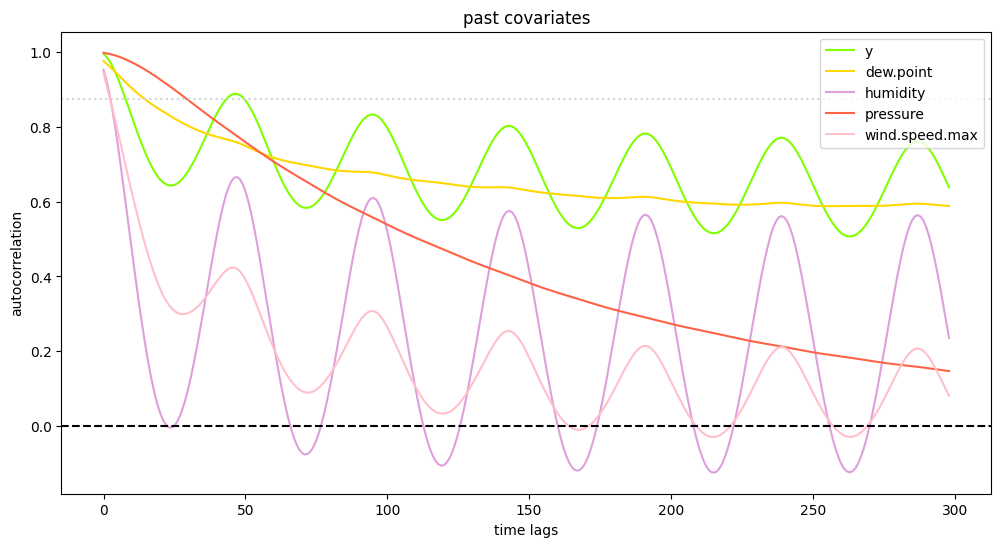

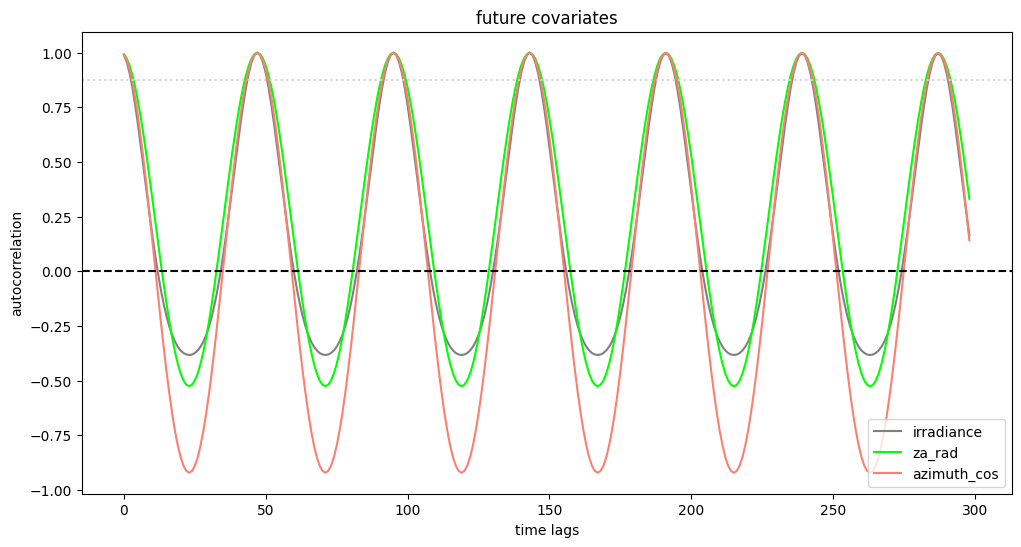

In [16]:
pc_feats = ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.max']
pc_cols  = ['chartreuse', 'gold', 'plum', 'tomato', 'pink']
plot_short_term_acf(df, pc_feats, pc_cols, 'past covariates')

fc_feats = ['irradiance', 'za_rad', 'azimuth_cos']
fc_cols  = ['grey', 'lime', 'salmon']
plot_short_term_acf(df, fc_feats, fc_cols, 'future covariates')

`y`, `humidity`, `wind.speed.max`, `irradiance`, `za_rad` (zenith angle) and `azimuth_cos` have strong daily seasonality.

Autocorrelation of `pressure` and `dew.point` are notably different.

`pressure` has surprisinly high initial autocorrelation.

---

#### Compare core and deseasonalised features

Compare UCM and prophet decompositions.


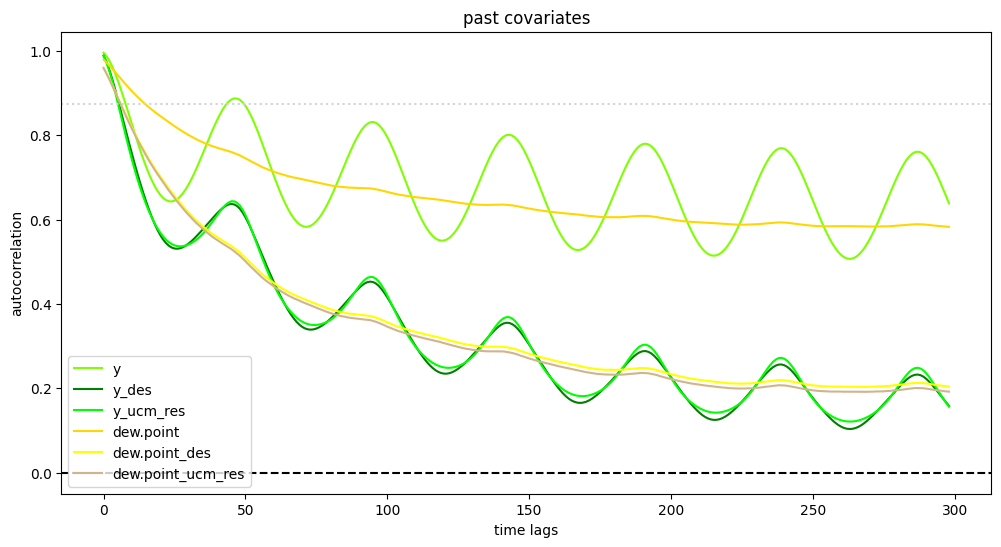

In [17]:
pc_feats = ['y', 'y_des', 'y_ucm_res', 'dew.point', 'dew.point_des',
            'dew.point_ucm_res']
pc_cols  = ['chartreuse', 'green', 'lime', 'gold', 'yellow', 'tan']
plot_short_term_acf(train_df, pc_feats, pc_cols, 'past covariates')


The prophet and UCM decompositions are remarkably similar.
Both decomposition approaches removed a substantial amount of seasonality.


---

#### Plot partial autocorrelations

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Here I plot both the autocorrelation and partial autocorrelations for:
 * core features
 * future covariates

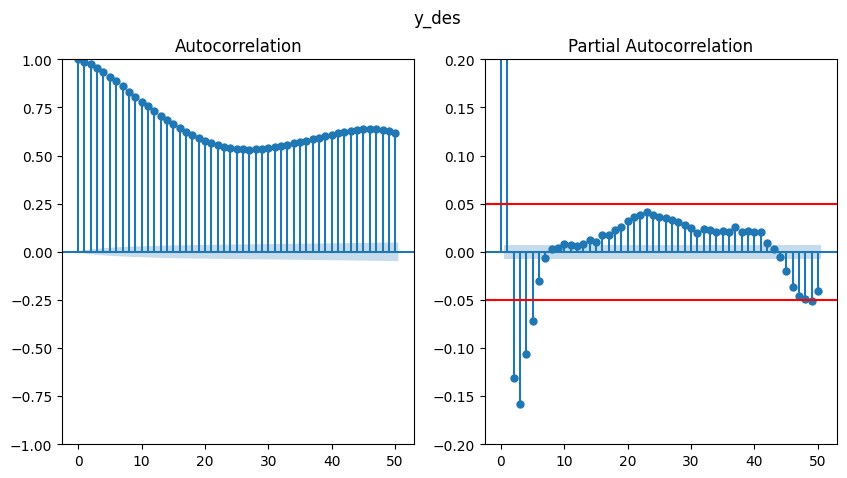

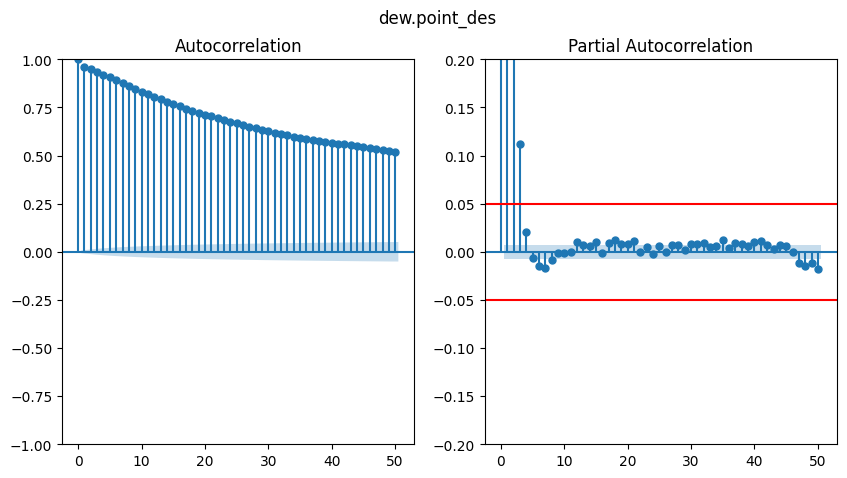

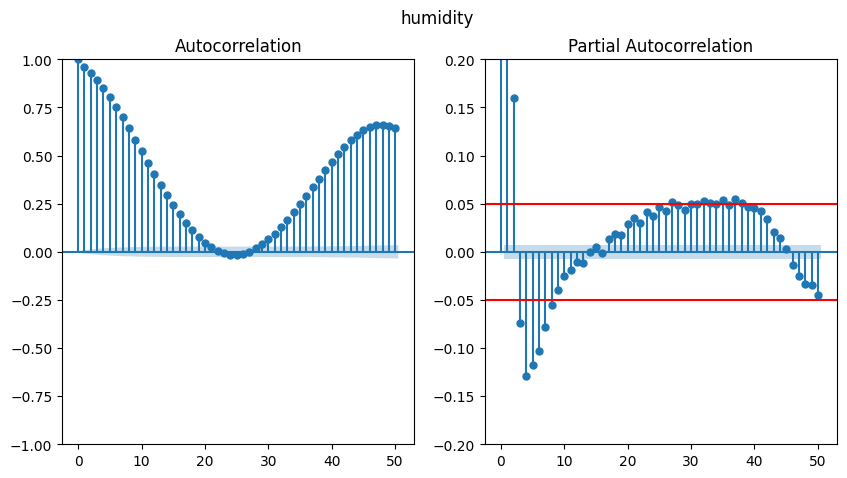

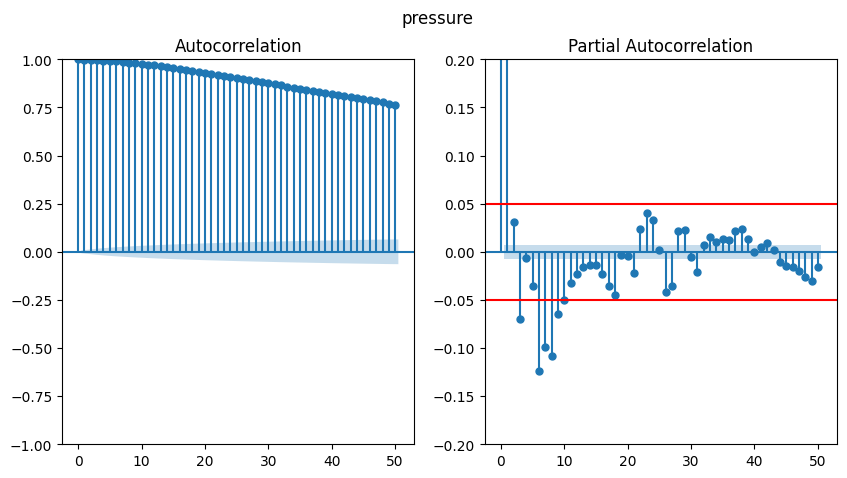

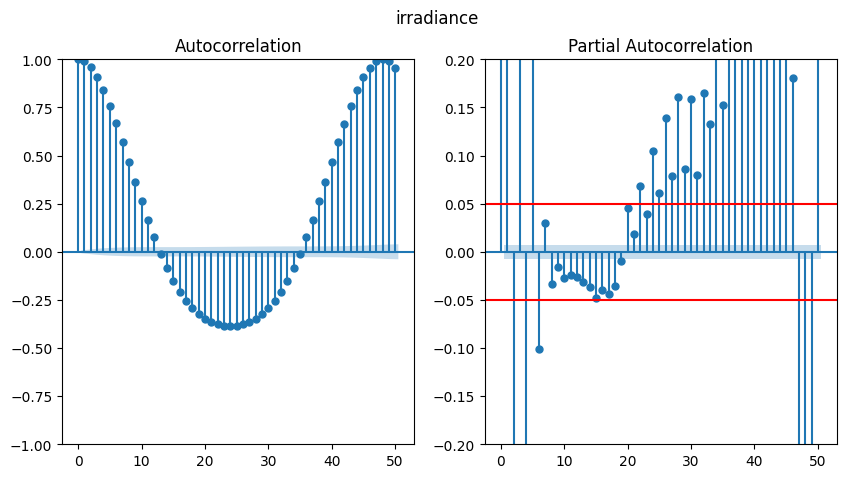

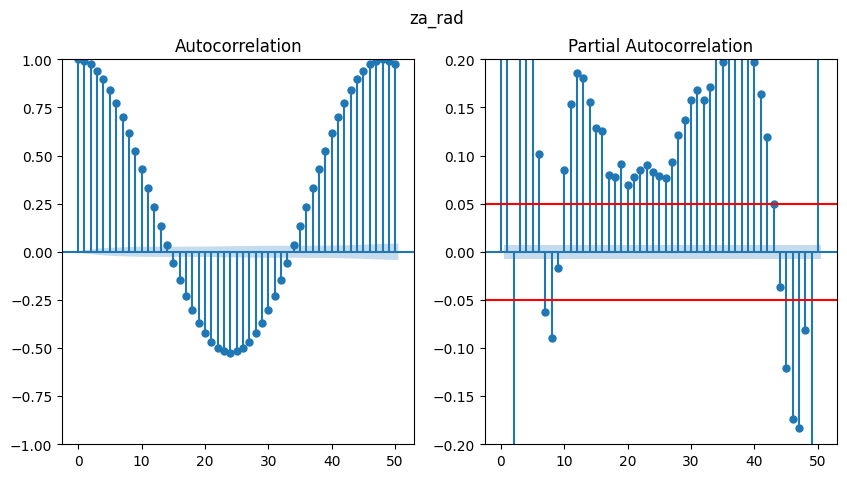

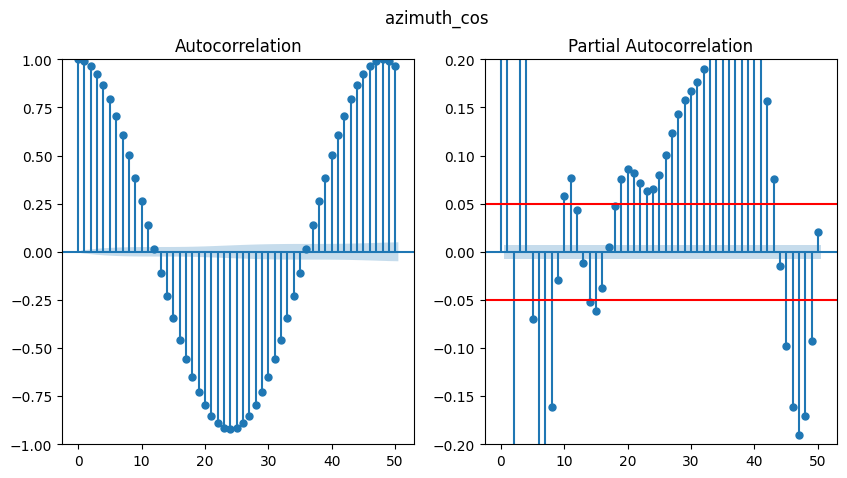

In [18]:
n = int(365.2425 * 48) * 12
max_lag = 50
pc_feats = ['y_des', 'dew.point_des', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']
pacf_lim = 0.05
alpha = 0.001

for pc_feat in pc_feats:
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  sm.graphics.tsa.plot_acf(train_df[pc_feat].head(n),  alpha=alpha, lags=max_lag, ax=ax[0])
  sm.graphics.tsa.plot_pacf(train_df[pc_feat].head(n), alpha=alpha, lags=max_lag, ax=ax[1])
  plt.axhline(y=pacf_lim,  color='r', linestyle='-')
  plt.axhline(y=-pacf_lim, color='r', linestyle='-')
  ax[1].set_ylim((-0.2, 0.2))
  plt.suptitle(pc_feat)
  plt.show()

In general, the future covariates (`irradiance`, `za_rad`, `azimuth_cos`) have similar autocorrelation and partial autocorrelations functions.

---

#### Plot longer term autocorrelations

Compare base and deseasonalised features over 3 year time spans.

There are 17532 = 48 * 365.25 half hour steps or lags in one year.

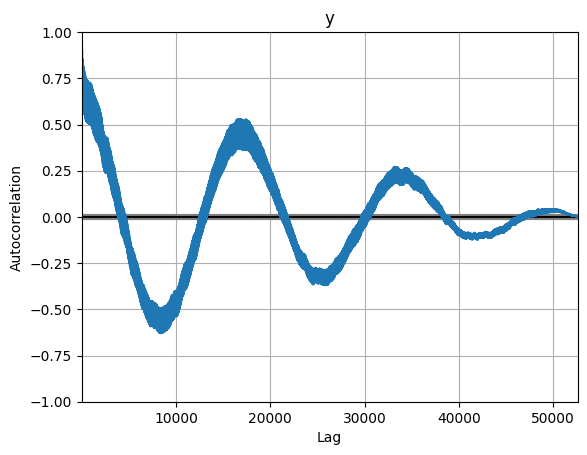

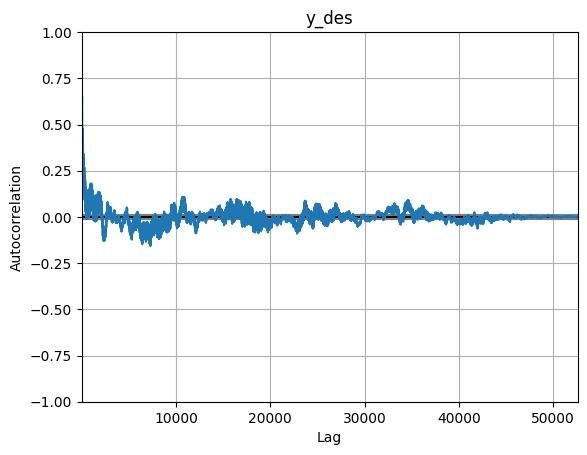

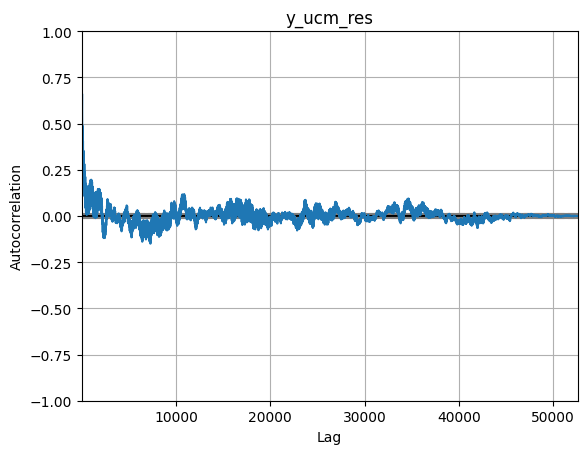

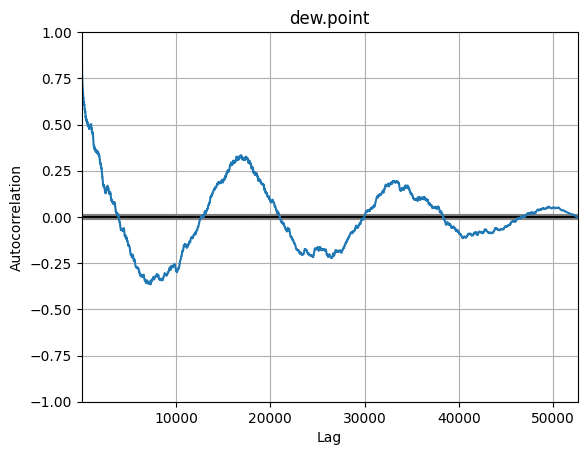

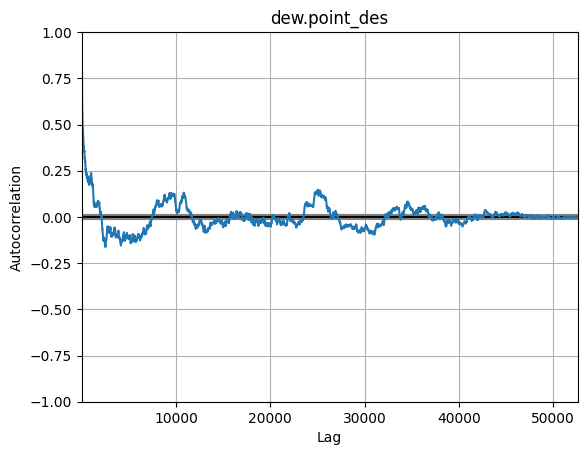

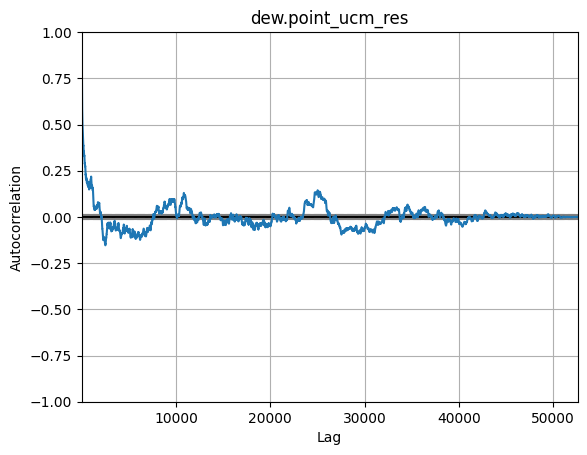

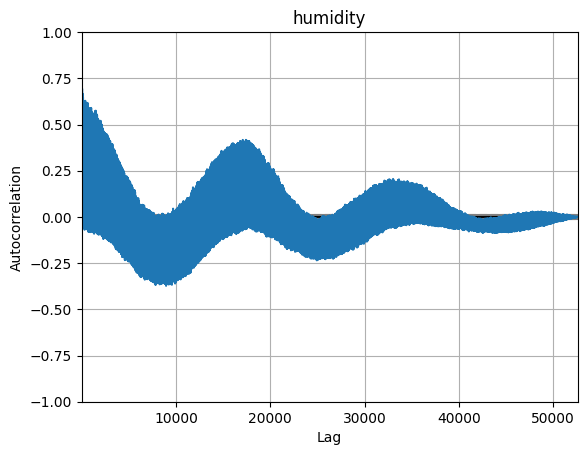

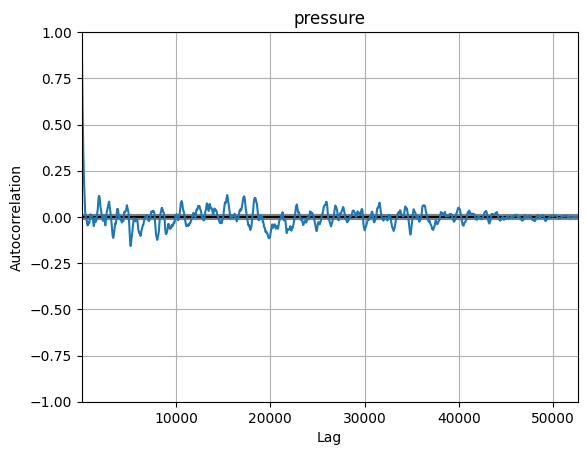

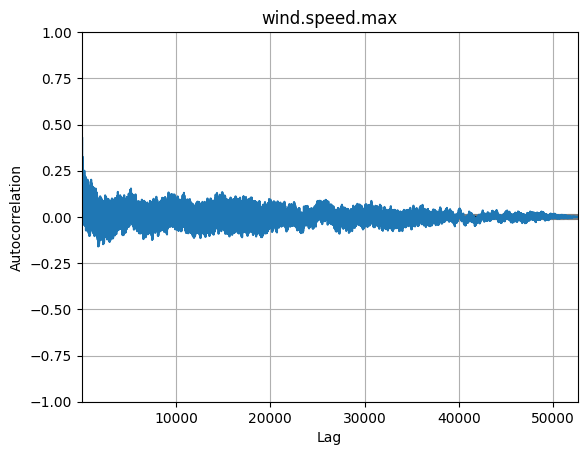

In [19]:
plot_long_term_acf(train_df, 'y')
plot_long_term_acf(train_df, 'y_des')
plot_long_term_acf(train_df, 'y_ucm_res')
plot_long_term_acf(train_df, 'dew.point')
plot_long_term_acf(train_df, 'dew.point_des')
plot_long_term_acf(train_df, 'dew.point_ucm_res')
plot_long_term_acf(train_df, 'humidity')
plot_long_term_acf(train_df, 'pressure')
plot_long_term_acf(train_df, 'wind.speed.max')

There is clear long term seasonality present for `y`, `dew.point` and `humidity`.  This long term seasonality is removed in the deseasonalised features: `y_des`, `y_ucm_res`, `dew.point_des` and `dew.point_ucm_res`.

There is remarkably low daily seasonality present for `dew.point` and remarkably high daily seasonality for `humidity`.  The daily seasonality for `humidity` also is not smoothly decreasing like daily seasonality of `y` and `dew.point`.  This may be related to the right censoring at 100 %.

There is little obvious long term autocorrelation for `pressure` or `wind.speed.max`, meaning fitting annual seasonality may not be justified.

---

Compare long term autocorrelations for wind speed features.


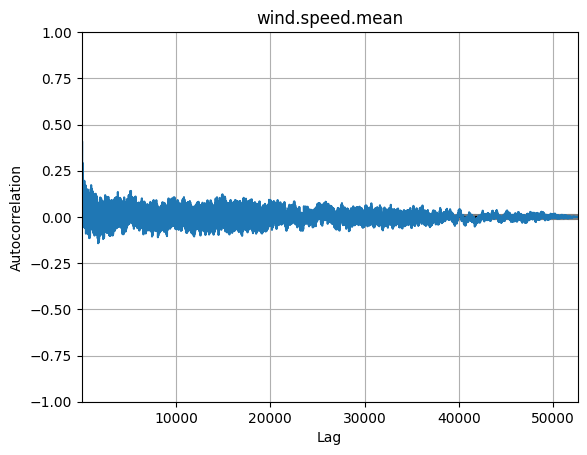

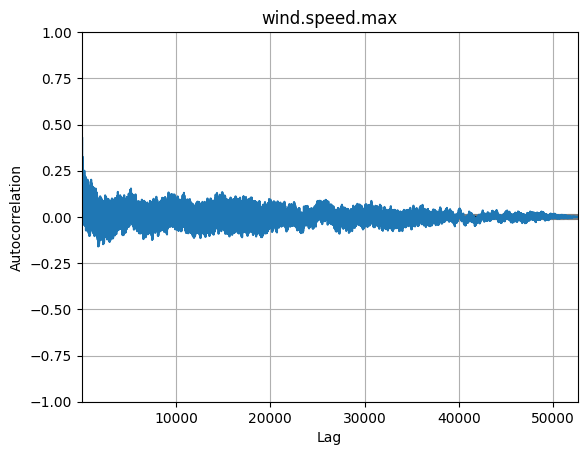

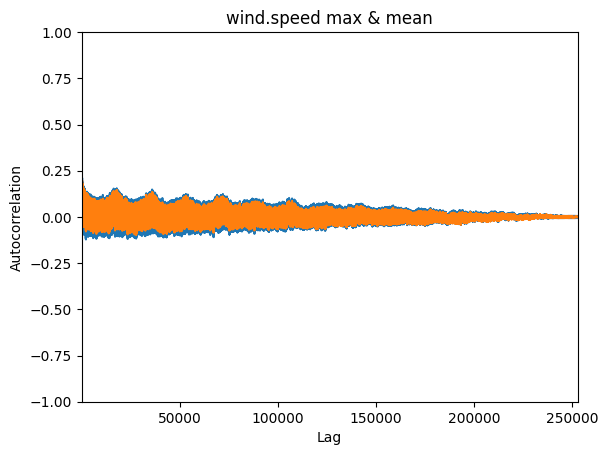

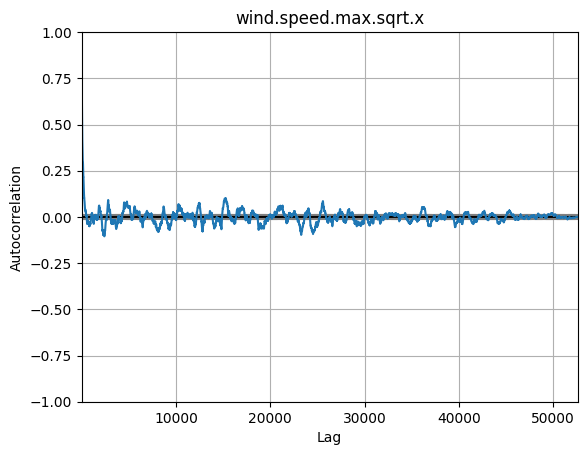

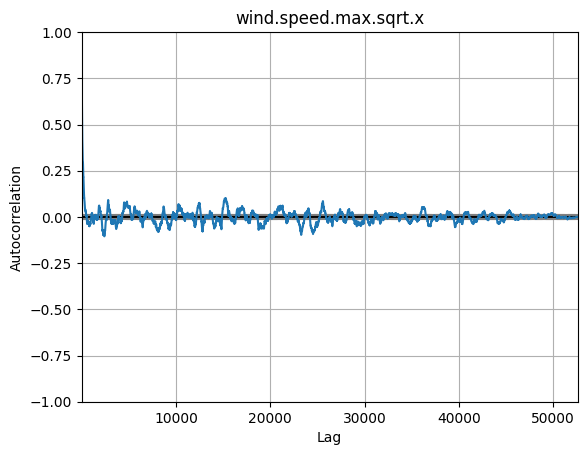

In [20]:
plot_long_term_acf(df, 'wind.speed.mean')
plot_long_term_acf(df, 'wind.speed.max')

# overlay 'wind.speed.main' on 'wind.speed.max'
pd.plotting.autocorrelation_plot(df['wind.speed.max'])
pd.plotting.autocorrelation_plot(df['wind.speed.mean'])
plt.title('wind.speed max & mean')
plt.show()

plot_long_term_acf(df, 'wind.speed.max.sqrt.x')
plot_long_term_acf(df, 'wind.speed.max.sqrt.x')

Little difference between `wind.speed.mean` and `wind.speed.max`.

---

#### Feature specific lags with PACF

Get feature-specific lags based on pacf:

In [21]:
def get_feature_specific_lags(data, feat, threshold = 0.05, nlags = 50):
  pacf_ = pacf(data[feat])
  pacf_ = np.abs(pacf_)

  pacf_indices = np.where(pacf_ >= threshold)[0][1:]

  return pacf_indices


pc_feats = ['y_des', 'dew.point_des', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']
thresholds = {'y_des': 0.05, 'dew.point_des': 0.15, 'humidity': 0.15,
              'pressure': 0.15, 'irradiance': 0.2, 'za_rad': 0.2,
              'azimuth_cos': 0.2,}

for pc_feat in pc_feats:
  lags_ = get_feature_specific_lags(train_df, pc_feat, thresholds[pc_feat])
  print(pc_feat, '\t', lags_)

y_des 	 [ 1  2  3  4  5 49]
dew.point_des 	 [1 2]
humidity 	 [1 2]
pressure 	 [1]
irradiance 	 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
za_rad 	 [ 1  2  3  4  5 34 36 37 38 39 40 41 42 43 49]
azimuth_cos 	 [ 1  2  3  4  6  7 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53]



...

---

#### Plot and check prophet components

The yearly prophet components have `_yearly` appended to feature names.  Similarly, `_daily` is used for daily components and `_des` (for deseasonalised) is used for residuals.

I used flat trends for simplicity and tweaked the transformation, seasonality mode, daily harmonics and yearly harmonics.

The final decomposition parameters:

|  Feature   |       Mode     | Transform | Daily | Yearly |
|------------|----------------|-----------|-------|--------|
| y          | Additive       | None      |   3   |   3    |
| dew.point  | Additive       | None      |   3   |   3    |
| humidity   | Multiplicative | log       |   2   |  Auto  |
| pressure   | Multiplicative | log       |   2   |   2    |

The mode and transforms agree with [work elsewhere](https://www.researchgate.net/figure/Time-series-decomposition-A-Sea-surface-temperature-C-additive-decomposition_fig2_332292752).

I tried log, square root and Box-Cox transformations and tried to keep the daily and yearly harmonics reasonably low.

Using a flat trend may not be appropriate for humidity.

The daily seasonalities for `dew.point` and `pressure` each have two peaks.
There is some [supporting evidence for two daily peaks for atmospheric pressure](https://www.sciencedaily.com/releases/2008/12/081203092437.htm), but I'm not aware of any similar evidence for dew point.

The `humidity` and `pressure` decompositions would benefit from further attention.  The daily and yearly components are hundreths of a percent!

The `wind.speed.mean` decomposition was unacceptible.  I've commented it out for now.
Wind speed may require more sophisticated decomposition techniques like [wavelets](https://en.wikipedia.org/wiki/Wavelet) for example.  Surprisingly, others have successfully used [multiplicative decomposition with smoothed wind speed data](https://files.core.ac.uk/pdf/2612/81865532.pdf).

We now have a richer set of features for lightgbm to choose from.  Also, we can model the deseasonalised temperatures, `y_des`, instead of the more complicated multi-seasonal temperatures `y`.  To make forecasts for `y`, `y_yearly` and `y_daily` must be added to the `y_des` predictions.


---

Finally, plot the historic values for the original and decomposed residual features:

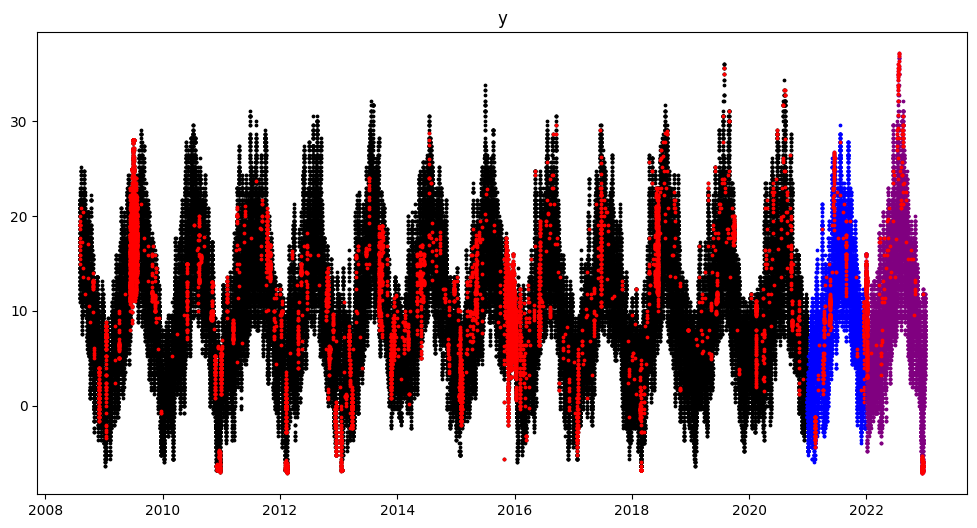

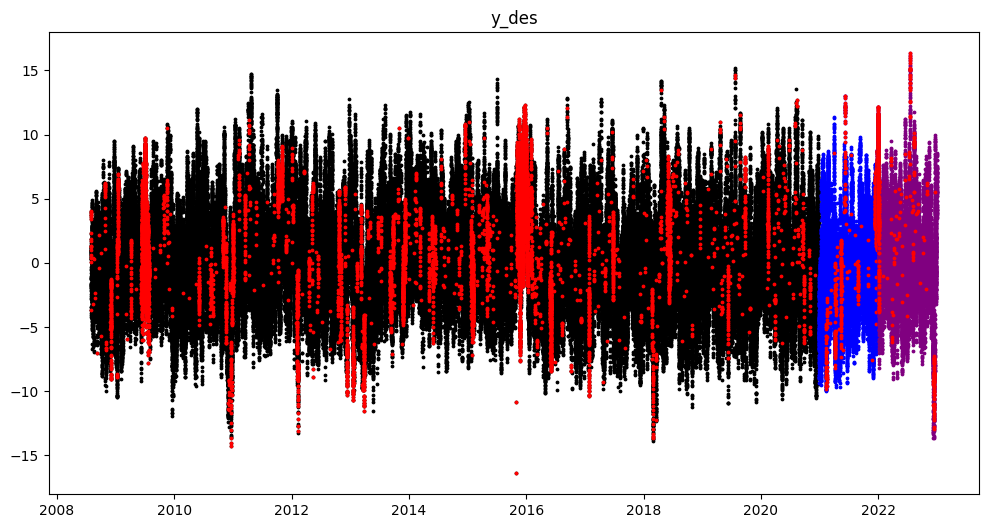

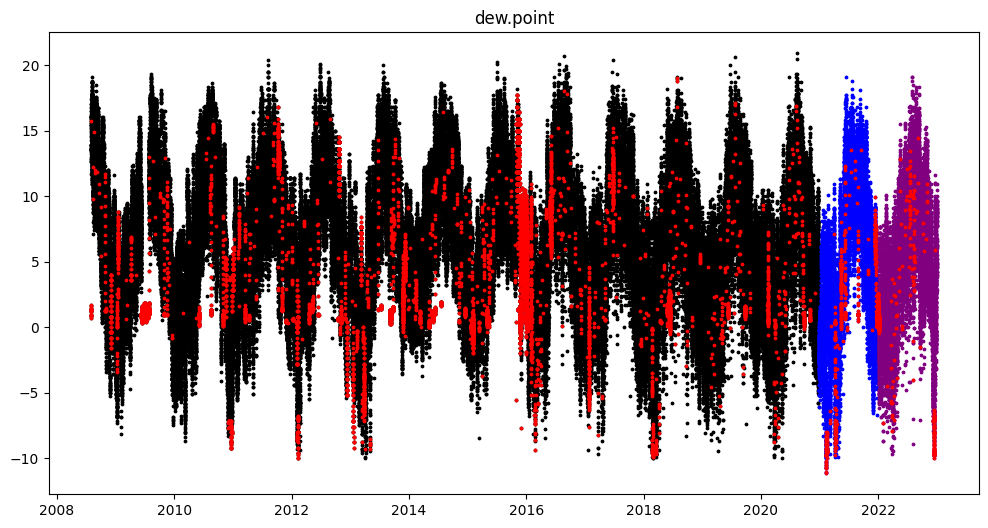

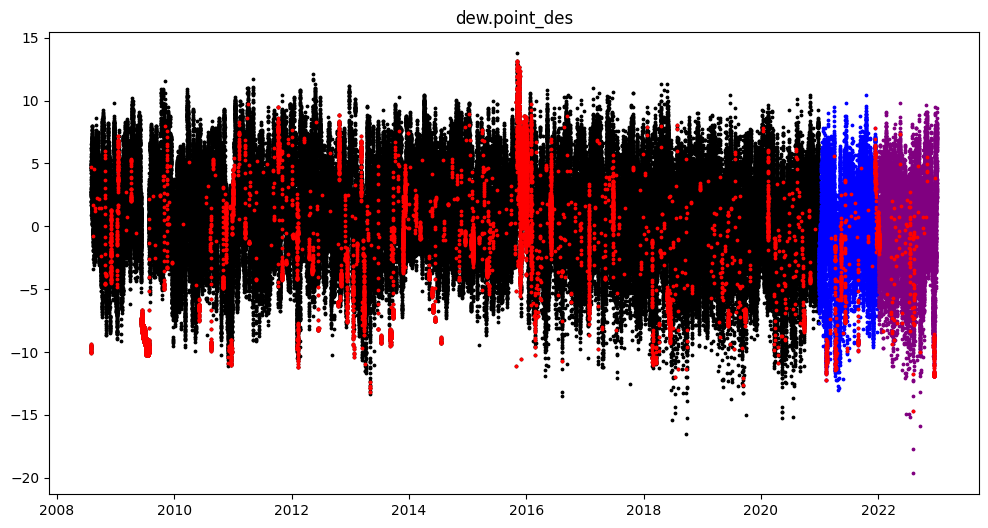

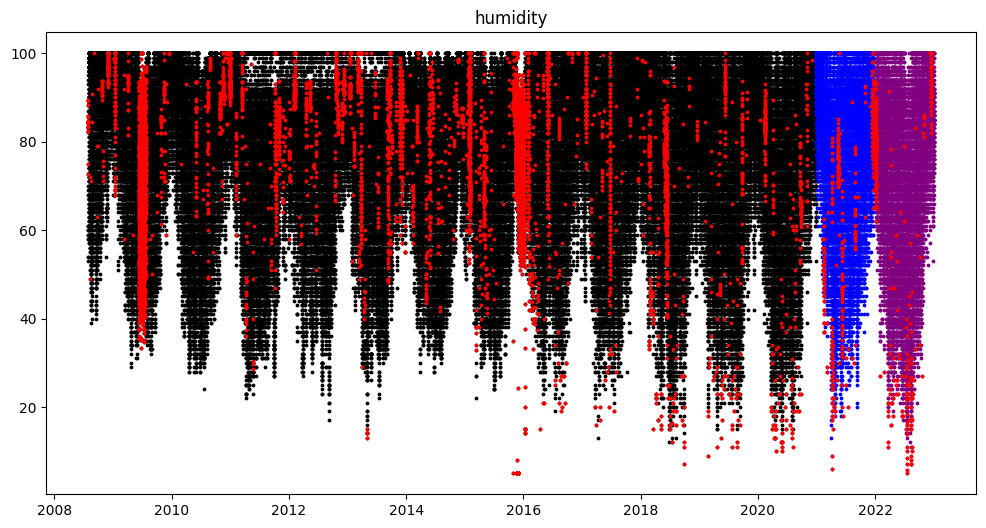

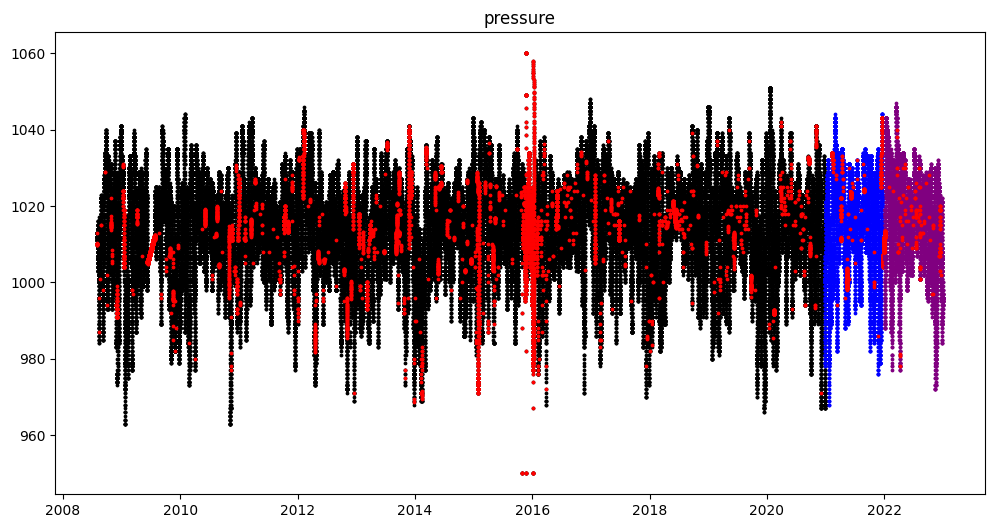

In [22]:
vars = ['y', 'dew.point', 'humidity', 'pressure',
       #'irradiance', 'za_rad', 'azimuth_cos',
       ]

for var in vars:
  var_des = var + '_des'
  if var in ['irradiance', 'za_rad', 'azimuth_cos']:
    plot_feature_history(train_df, valid_df, test_df, var)
  else:
    plot_feature_history(train_df, valid_df, test_df, var, missing=True)

  if var in ['y', 'dew.point']:
    plot_feature_history(train_df, valid_df, test_df, var_des, missing=True)

A visual comparison of the original and residual features indicates:
  * unfortunately `missing` label is not feature specific
  * possible longer than annual signal in `y_des`
  * possible annual signal remaining in `dew.point_des`
  * increasing heteroscadicity in `humidity` and `humidity_des`
  * decreasing trend in `humidity` and `humidity_des`
  * possible annual signal remaining in `humidity_des`
  * `pressure` and `pressure_des` appear similar
  * possible annual signal remaining in `pressure_des`

---

### Stationarity Tests

It is worthwhile looking at the stationarity of these time series after decomposition.

A stationary time series should have mean, variance and autocorrelation that do not change over time.  This means a flat series, without trend, constant variance, constant autocorrelation structure and no periodic fluctuations (seasonalities).

In [23]:
def adf_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      dftest = adfuller(timeseries, maxlag = NLAGS)
    else:
      dftest = adfuller(timeseries, autolag="AIC")

    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic",
               "p-value",
               "#Lags Used",
               "Number of Observations Used",
        ],
    )

    print("Results of Dickey-Fuller Test:")
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    print(dfoutput)


def kpss_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      kpsstest = kpss(timeseries, regression="c", nlags=NLAGS)
    else:
      kpsstest = kpss(timeseries, regression="c", nlags="auto")

    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )

    print("\nResults of KPSS Test:")
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)


def stationarity_tests(df, var, NLAGS=None):
    print(var)
    adf_test(df[var], NLAGS)
    kpss_test(df[var], NLAGS)
    print('\n')


for var in ['y', 'dew.point', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']:
    stationarity_tests(train_df, var)
    if var in ['y', 'dew.point']:
        stationarity_tests(train_df.loc['2016-01-12':, :], var + '_des')

y
Results of Dickey-Fuller Test:
Test Statistic                -1.221669e+01
p-value                        1.131383e-22
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.24991
p-value                    0.10000
Lags Used                259.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


y_des


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                   -20.515403
p-value                            0.000000
#Lags Used                        66.000000
Number of Observations Used    87101.000000
Critical Value (1%)               -3.430425
Critical Value (5%)               -2.861573
Critical Value (10%)              -2.566788
dtype: float64

Results of KPSS Test:
Test Statistic             0.234886
p-value                    0.100000
Lags Used                165.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


dew.point


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -1.708259e+01
p-value                        7.688411e-30
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.754355
p-value                    0.010000
Lags Used                265.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


dew.point_des


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                   -21.831844
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    87105.000000
Critical Value (1%)               -3.430425
Critical Value (5%)               -2.861573
Critical Value (10%)              -2.566788
dtype: float64

Results of KPSS Test:
Test Statistic             0.982338
p-value                    0.010000
Lags Used                167.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


humidity


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                    -24.464915
p-value                             0.000000
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64

Results of KPSS Test:
Test Statistic             2.81579
p-value                    0.01000
Lags Used                229.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


pressure


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                    -23.070965
p-value                             0.000000
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64

Results of KPSS Test:
Test Statistic             0.359213
p-value                    0.094736
Lags Used                268.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


irradiance
Results of Dickey-Fuller Test:
Test Statistic                     -1.358900
p-value                             0.601814
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               

<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -6.456925e+00
p-value                        1.475549e-08
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.209458
p-value                    0.100000
Lags Used                203.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


azimuth_cos


<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -6.085027e+00
p-value                        1.069501e-07
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.236941
p-value                    0.100000
Lags Used                155.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64




<ipython-input-23-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


The relevant [statsmodels docs](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) explain the [ADF](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) and [KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) tests plus provide help with interpretation of the p-values.

ADF:
 * <u>Null hypothesis</u>: the dataset is non-stationary and therefore differencing must be carried out.
 * <u>Alternative hypothesis</u>: the dataset has no unit root and is therefore stationary.
 * If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

KPSS:
 * <u>Null hypothesis</u>: the series is trend stationary.
 * <u>Alternative hypothesis</u>: the series is not stationary.
 * The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

A Bonferroni-corrected p-value threshold of 0.005 (0.05 / 10) is used.


|   Feature       | ADF      | KPSS |   Result   |
|-----------------|----------|------|------------|
| y               | 3.35e-23 | 0.1  | Stationary |
| y_des           | 0.0      | 0.01 | Stationary |
| dew.point       | 4.6e-29  | 0.01 | Stationary |
| dew.point_des   | 0.0      | 0.01 | Stationary |
| humidity        | 0.0      | 0.01 | Stationary |
| humidity_des    | 0.0      | 0.01 | Stationary |
| pressure        | 0.0      | 0.01 | Stationary |
| pressure_des    | 0.0      | 0.01 | Stationary |
| irradiance      | 0.0      | 0.01 | Stationary |
| zenith angle    | 0.0      | 0.01 | Stationary |
| azimuth_cos     | ...      | ...  | ...        |

For all features tested, the ADF null hypothesis is rejected and the KPSS null hypothesis is accepted at the Bonferroni-corrected p-value threshold.
All of the features were stationary before and after transformation.

---

#### Save default feature sets

Save default train, valid and test data sets for use in main modeling notebook(s).

The graphs above show their are quite a few missing values around the beginning of 2016.  Earlier work calculating first differences for the core features showed there was substantial differences before early 2016 and afterwards.  So, training data starts after early 2016.

In [24]:


params_def = {'verbose':   True,
              'feat_name': 'default_',
              'date_str':  '.2022.09.20',
              'save_and_download': False,
              'save_to_gdrive': False,
             }


train_mask = (train_df.index >= '2016-01-12')
valid_mask = valid_df.index.year == VALID_YEAR
test_mask  = test_df.index.year  == TEST_YEAR
save_data_and_download_files(train_df.loc[train_mask], 'train', params_def)
save_data_and_download_files(valid_df.loc[valid_mask], 'valid', params_def)
save_data_and_download_files(test_df.loc[test_mask],   'test',  params_def)

yyy

Files are saved in Apache parquet format and are available on github:
 * https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/tree/main/data/features

---


### Feature Engineering

Feature engineering, or feature extraction, transforms raw data into features for forecasting.  It includes the following packages and approaches:

 * catch22
 * tsfeatures
 * bivariate
   * numpy
   * scipy
   * statsmodels
   * dynamic time warping
   * distances
   * kernels


#### catch22

[catch22](https://github.com/DynamicsAndNeuralSystems/catch22) is a collection of 22 time-series features which were selected based on their *classification* performance across a collection of 93 real-world time-series classification problems.

 * [pycatch22](https://github.com/DynamicsAndNeuralSystems/pycatch22)
 * [short feature descriptions](https://github.com/DynamicsAndNeuralSystems/catch22/wiki/Feature-Descriptions)
 * [detailed descriptions with visual depictions of the behavior of features](https://feature-based-time-series-analys.gitbook.io/catch22-features/)

The `get_feature_selection_scores` function calculates [F-statistic tests](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), [Pearson correlation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html) and [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) between the calculated features and the target variable.
These tests assume a linear model.  This is not optimal.
Don't draw any hasty conclusions from these scores.

Lags considered:
 * [6, 12, 24, 48, 96]

Features considered:
 * `y_des`
 * `dew.point_des`
 * `humidity`

`pressure` has some long sequences of single values which produce many NAs. A better deseasonalised `pressure` feature would be worthwhile trying.

catch22 installation is straight-forward:

In [26]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 967.9 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.4-cp310-cp310-linux_x86_64.whl size=113403 sha256=28e00baf798bacb3e9296275a720a59c9ba244f6d7001a3ee8a9d38e5298e9f4
  Stored in directory: /root/.cache/pip/wheels/10/67/84/cdce1a956aa218fd5ce5b5fa6773219f42780b1fac77889c57
Successfully built pycatch22


In [28]:


from pycatch22 import catch22_all, DN_HistogramMode_5, DN_HistogramMode_10, \
                      CO_f1ecac, CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
                      CO_trev_1_num, MD_hrv_classic_pnn40, \
                      SB_BinaryStats_mean_longstretch1, \
                      SB_TransitionMatrix_3ac_sumdiagcov, \
                      PD_PeriodicityWang_th0_01, \
                      CO_Embed2_Dist_tau_d_expfit_meandiff, \
                      IN_AutoMutualInfoStats_40_gaussian_fmmi, \
                      FC_LocalSimple_mean1_tauresrat, \
                      DN_OutlierInclude_p_001_mdrmd, \
                      DN_OutlierInclude_n_001_mdrmd, \
                      SP_Summaries_welch_rect_area_5_1, \
                      SB_BinaryStats_diff_longstretch0, \
                      SB_MotifThree_quantile_hh, \
                      SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
                      SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
                      SP_Summaries_welch_rect_centroid, \
                      FC_LocalSimple_mean3_stderr


def c22_call(ser, func):
  '''The pd.Series.to_list() call is necessary.
     Otherwise rol.apply(how) may work.
     Also, np.ndarray.tolist() is necessary.
     Otherwise c22 returns null exception.
     Or, maybe rol.apply(lambda shenanigans with AGGS array)'''
  # return func(data.loc[ser.index, feat_col].to_list())
  return func(ser.tolist())


def get_rolling_catch22_features(data, feat_cols, windows, AGGS, verbose=False):
  '''Probably can't add norm and scale options due to compute time issues'''

  aggs_l = []

  for feat_col in feat_cols:
    print(feat_col)
    for window in windows:
      print('\t', window)

      #if feat_col == 'humidity':
      #  continue
      #elif window == 24 and feat_col == 'pressure':
      #if window == 24 and feat_col == 'pressure':
      #  continue

      rol = data[feat_col].shift(1).rolling(window=window, min_periods=1,)

      for how in AGGS:
        start_time = timeit.default_timer()
        if verbose:
          print('\t\t', how.__name__, end='')

        c22args = {'func': how}

        agg_ = rol.apply(c22_call, kwargs=c22args, raw=True)
        agg = agg_.copy()
        agg = agg.rename(f'{feat_col}_window_{window}_{how.__name__}')
        aggs_l.append(agg)

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))

  aggs = pd.concat(aggs_l, axis=1)
  aggs = drop_problem_cols(aggs, window)
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


# feat_cols = [Y_COL]
# windows = [48]
#
# many problems with humidity and train_df - do not use humidity feature
windows = [6, 12, 24, 48, 96]
feat_cols = [Y_COL, 'dew.point_des', 'pressure', 'humidity']
c22_aggs = [DN_HistogramMode_5, DN_HistogramMode_10, CO_f1ecac, \
            CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
            CO_trev_1_num, MD_hrv_classic_pnn40, \
            SB_BinaryStats_mean_longstretch1, \
            SB_TransitionMatrix_3ac_sumdiagcov, PD_PeriodicityWang_th0_01, \
            CO_Embed2_Dist_tau_d_expfit_meandiff, \
            IN_AutoMutualInfoStats_40_gaussian_fmmi, \
            FC_LocalSimple_mean1_tauresrat, DN_OutlierInclude_p_001_mdrmd, \
            DN_OutlierInclude_n_001_mdrmd, SP_Summaries_welch_rect_area_5_1, \
            SB_BinaryStats_diff_longstretch0, SB_MotifThree_quantile_hh, \
            SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
            SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
            SP_Summaries_welch_rect_centroid, FC_LocalSimple_mean3_stderr]
params_c22 = {'windows':    windows,
              'feat_cols':  feat_cols,
              'aggs':       c22_aggs,
              'agg_func':   get_rolling_catch22_features,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'catch22_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
              'save_to_gdrive': True,
             }

train_df_c22, valid_df_c22, test_df_c22 = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_c22)


##############################################################################
# 12 mins for all 22 catch22 functions on valid_df, test_df & train_df
# 305 features added - 0 NAs
#
# windows = [6, 12, 24, 48, 96]
# feat_cols = [Y_COL, 'dew.point_des', 'pressure', 'humidity']
# c22_aggs = [DN_HistogramMode_5, DN_HistogramMode_10, CO_f1ecac, \
#             CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
#             CO_trev_1_num, MD_hrv_classic_pnn40, \
#             SB_BinaryStats_mean_longstretch1, \
#             SB_TransitionMatrix_3ac_sumdiagcov, PD_PeriodicityWang_th0_01, \
#             CO_Embed2_Dist_tau_d_expfit_meandiff, \
#             IN_AutoMutualInfoStats_40_gaussian_fmmi, \
#             FC_LocalSimple_mean1_tauresrat, DN_OutlierInclude_p_001_mdrmd, \
#             DN_OutlierInclude_n_001_mdrmd, SP_Summaries_welch_rect_area_5_1, \
#             SB_BinaryStats_diff_longstretch0, SB_MotifThree_quantile_hh, \
#             SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
#             SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
#             SP_Summaries_welch_rect_centroid, FC_LocalSimple_mean3_stderr]
# params = {'windows':    windows,
#           'feat_cols':  feat_cols,
#           'aggs':       c22_aggs,
#           'agg_func':   get_rolling_catch22_features,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'catch22_',
#           'date_str':   '.2022.09.20', }

dataset: valid
y_des
	 6
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.04
		 CO_FirstMin_ac	 0.04
		 CO_HistogramAMI_even_2_5	 0.03
		 CO_trev_1_num	 0.02
		 MD_hrv_classic_pnn40	 0.02
		 SB_BinaryStats_mean_longstretch1	 0.02
		 SB_TransitionMatrix_3ac_sumdiagcov	 0.06
		 PD_PeriodicityWang_th0_01	 0.07
		 CO_Embed2_Dist_tau_d_expfit_meandiff	 0.05
		 IN_AutoMutualInfoStats_40_gaussian_fmmi	 0.02
		 FC_LocalSimple_mean1_tauresrat	 0.07
		 DN_OutlierInclude_p_001_mdrmd	 0.22
		 DN_OutlierInclude_n_001_mdrmd	 0.23
		 SP_Summaries_welch_rect_area_5_1	 0.03
		 SB_BinaryStats_diff_longstretch0	 0.02
		 SB_MotifThree_quantile_hh	 0.05
		 SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1	 0.04
		 SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1	 0.04
		 SP_Summaries_welch_rect_centroid	 0.03
		 FC_LocalSimple_mean3_stderr	 0.02
	 12
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.08
		 CO_FirstMin_ac	 0.09
		 CO_HistogramAMI_even_2_5	 0.04
		 CO_trev_1_num

y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
humidity_window_96_SB_MotifThree_quantile_hh                      96
humidity_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
humidity_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
humidity_window_96_SP_Summaries_welch_rect_centroid               96
humidity_window_96_FC_LocalSimple_mean3_stderr                    96
Length: 392, dtype: int64

before: (17664, 109)
after:  (17664, 469)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  humidity_window_96_FC_LocalSimple_mean1_tauresrat  \
ds                   ...                                                      
2020-12-29 00:00:00  ...                                                NaN   
2020-12-29 00:30:00  ...                                                NaN   
2020-12-29 01:00:00  ...                                                NaN   
2020-12-29 01:30:00  ...                                                NaN   
2020-12-29 02:00:00  ...                                                NaN   
...                  ...                                                ...   
2021-12-31 21:30:00  ...                                           0.142857   
2021-12-31 22:00:00  ...                                           0.142857   
2021-12-31 22:30:00  ...                                           0.142857   
2021-12-31 23:00:00  ...                                           0.133333   
2021-12-31 23:30:00  ...                                 

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          189.498771      -1.128775e+00  ...   
std            91.928312       3.704728e+00  ...   
min             0.000000      -2.030000e+01  ...   
25%           135.000000      -2.474874e+00  ...   
50%           225.000000      -2.204364e-16  ...   
75%           270.000000       1.000000e-01  ...   
max           360.000000       1.393000e+01  ...   

       humidity_window_96_FC_LocalSimple_mean1_tauresrat  \
count                                       17568.000000   
mean                                            0.080897   
std                                             0.060535   
min                                             0.022727   
25%                                             0.066667   
50%                                             0.076923   
75%                                             0.083333   
max                                             1.000000   

       humidity_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                      17568.000000   
mean                                          -0.001565   
std                                            0.417650   
min                                           -0.947917   
25%                                           -0.322917   
50%                                            0.000000   
75%                                            0.312500   
max                                            0.937500   

       humidity_window_96_DN_OutlierInclude_n_001_mdrmd  \
count                                      17568.000000   
mean                                           0.029794   
std                                            0.477299   
min                                           -0.958333   
25%                                           -0.343750   
50%                                            0.041667   
75%                                            0.416667   
max                                            0.989583   

       humidity_window_96_SP_Summaries_welch_rect_area_5_1  \
count                                       17568.000000     
mean                                            0.848639     
std                                             0.098558     
min                                             0.151325     
25%                                             0.824453     
50%                                             0.876563     
75%                                             0.909187     
max                                             0.969818     

      

na_feats:


pressure_window_24_DN_HistogramMode_5                  33
pressure_window_24_DN_HistogramMode_10                 33
pressure_window_24_CO_HistogramAMI_even_2_5            33
pressure_window_24_CO_trev_1_num                       33
pressure_window_24_MD_hrv_classic_pnn40                33
                                                       ..
humidity_window_12_DN_OutlierInclude_n_001_mdrmd        4
humidity_window_12_SB_BinaryStats_diff_longstretch0     4
humidity_window_12_SB_MotifThree_quantile_hh            4
humidity_window_12_SP_Summaries_welch_rect_centroid     4
humidity_window_12_FC_LocalSimple_mean3_stderr          4
Length: 67, dtype: int64

drop: pressure_window_24_DN_HistogramMode_5
drop: pressure_window_24_DN_HistogramMode_10
drop: pressure_window_24_CO_HistogramAMI_even_2_5
drop: pressure_window_24_CO_trev_1_num
drop: pressure_window_24_MD_hrv_classic_pnn40
drop: pressure_window_24_SB_BinaryStats_mean_longstretch1
drop: pressure_window_24_SB_TransitionMatrix_3ac_sumdiagcov
drop: pressure_window_24_CO_Embed2_Dist_tau_d_expfit_meandiff
drop: pressure_window_24_IN_AutoMutualInfoStats_40_gaussian_fmmi
drop: pressure_window_24_FC_LocalSimple_mean1_tauresrat
drop: pressure_window_24_DN_OutlierInclude_p_001_mdrmd
drop: pressure_window_24_DN_OutlierInclude_n_001_mdrmd
drop: pressure_window_24_SP_Summaries_welch_rect_area_5_1
drop: pressure_window_24_SB_BinaryStats_diff_longstretch0
drop: pressure_window_24_SB_MotifThree_quantile_hh
drop: pressure_window_24_SP_Summaries_welch_rect_centroid
drop: pressure_window_24_FC_LocalSimple_mean3_stderr
interpolate: pressure_window_48_DN_HistogramMode_5
interpolate: pressure_window_48_DN_H

y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
humidity_window_96_SB_BinaryStats_diff_longstretch0               96
humidity_window_96_SB_MotifThree_quantile_hh                      96
humidity_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
humidity_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
humidity_window_96_SP_Summaries_welch_rect_centroid               96
Length: 387, dtype: int64

before: (17664, 109)
after:  (17664, 464)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  \
ds                   ...   
2021-12-29 00:00:00  ...   
2021-12-29 00:30:00  ...   
2021-12-29 01:00:00  ...   
2021-12-29 01:30:00  ...   
2021-12-29 02:00:00  ...   
...                  ...   
2022-12-31 21:30:00  ...   
2022-12-31 22:00:00  ...   
2022-12-31 22:30:00  ...   
2022-12-31 23:00:00  ...   
2022-12-31 23:30:00  ...   

                     humidity_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
ds                                                                             
2021-12-29 00:00:00                                                NaN         
2021-12-29 00:30:00                                                NaN         
2021-12-29 01:00:00                                                NaN         
2021-12-29 01:30:00                                                NaN         
2021-12-29 02:00:00                                                NaN         
...                                                                ...         


y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          192.755036      -1.576942e+00  ...   
std            83.065626       3.535051e+00  ...   
min             0.000000      -2.480000e+01  ...   
25%           135.000000      -3.300000e+00  ...   
50%           224.440299      -1.010334e-15  ...   
75%           270.000000       0.000000e+00  ...   
max           350.000000       1.202082e+01  ...   

       humidity_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
count                                       17568.000000         
mean                                            0.375504         
std                                             0.156445         
min                                             0.018754         
25%                                             0.258536         
50%                                             0.370609         
75%                                             0.487779         
max                                             0.955413         

       humidity_window_96_IN_AutoMutualInfoStats_40_gaussian_fmmi  \
count                                       17568.000000            
mean                                           10.653859            
std                                             3.794368            
min                                             1.000000            
25%                                             9.000000            
50%                                            11.000000            
75%                                            12.000000            
max                                            35.000000            

       humidity_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                      17568.000000   
mean                                           0.018179   
std                                            0.406037   
min                                           -0.958333   
25%                                           -0.270833   
50%                                            0.020833   
75%                                            0.312500   
max                                            0.937500   

       humidity_window_96_DN_OutlierInclude_n_001_mdrmd  \
count                                      17568.000000   
mean                                           0.031415   
std                                            0.459577   
min                                           -0.947917   
25%                                           -0.312500   
50%                                            0.041667   
75%     

na_feats:


pressure_window_24_DN_HistogramMode_5                  17
pressure_window_24_DN_HistogramMode_10                 17
pressure_window_24_CO_HistogramAMI_even_2_5            17
pressure_window_24_CO_trev_1_num                       17
pressure_window_24_MD_hrv_classic_pnn40                17
                                                       ..
humidity_window_24_SP_Summaries_welch_rect_area_5_1     2
humidity_window_24_SB_BinaryStats_diff_longstretch0     2
humidity_window_24_SB_MotifThree_quantile_hh            2
humidity_window_24_SP_Summaries_welch_rect_centroid     2
humidity_window_24_FC_LocalSimple_mean3_stderr          2
Length: 66, dtype: int64

drop: pressure_window_24_DN_HistogramMode_5
drop: pressure_window_24_DN_HistogramMode_10
drop: pressure_window_24_CO_HistogramAMI_even_2_5
drop: pressure_window_24_CO_trev_1_num
drop: pressure_window_24_MD_hrv_classic_pnn40
drop: pressure_window_24_SB_BinaryStats_mean_longstretch1
drop: pressure_window_24_SB_TransitionMatrix_3ac_sumdiagcov
drop: pressure_window_24_CO_Embed2_Dist_tau_d_expfit_meandiff
drop: pressure_window_24_IN_AutoMutualInfoStats_40_gaussian_fmmi
drop: pressure_window_24_FC_LocalSimple_mean1_tauresrat
drop: pressure_window_24_DN_OutlierInclude_p_001_mdrmd
drop: pressure_window_24_DN_OutlierInclude_n_001_mdrmd
drop: pressure_window_24_SP_Summaries_welch_rect_area_5_1
drop: pressure_window_24_SB_BinaryStats_diff_longstretch0
drop: pressure_window_24_SB_MotifThree_quantile_hh
drop: pressure_window_24_SP_Summaries_welch_rect_centroid
drop: pressure_window_24_FC_LocalSimple_mean3_stderr
drop: humidity_window_6_DN_HistogramMode_5
drop: humidity_window_6_DN_HistogramMode_10


y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
humidity_window_96_SB_MotifThree_quantile_hh                      96
humidity_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
humidity_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
humidity_window_96_SP_Summaries_welch_rect_centroid               96
humidity_window_96_FC_LocalSimple_mean3_stderr                    96
Length: 390, dtype: int64

before: (87696, 109)
after:  (87696, 468)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  humidity_window_96_FC_LocalSimple_mean1_tauresrat  \
ds                   ...                                                      
2016-01-01 00:00:00  ...                                                NaN   
2016-01-01 00:30:00  ...                                                NaN   
2016-01-01 01:00:00  ...                                                NaN   
2016-01-01 01:30:00  ...                                                NaN   
2016-01-01 02:00:00  ...                                                NaN   
...                  ...                                                ...   
2020-12-31 21:30:00  ...                                           0.030303   
2020-12-31 22:00:00  ...                                           0.030303   
2020-12-31 22:30:00  ...                                           0.030303   
2020-12-31 23:00:00  ...                                           0.030303   
2020-12-31 23:30:00  ...                                           0.030303   

                     humidity

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       87696.000000       8.769600e+04  ...   
mean          196.378501      -1.587145e+00  ...   
std            82.781282       3.948823e+00  ...   
min             0.000000      -2.880000e+01  ...   
25%           135.000000      -3.464823e+00  ...   
50%           225.000000      -1.000000e-01  ...   
75%           270.000000       2.449294e-17  ...   
max           360.000000       2.050610e+01  ...   

       humidity_window_96_FC_LocalSimple_mean1_tauresrat  \
count                                       87600.000000   
mean                                            0.081181   
std                                             0.056285   
min                                             0.020408   
25%                                             0.066667   
50%                                             0.076923   
75%                                             0.083333   
max                                             1.285714   

       humidity_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                      87600.000000   
mean                                           0.008134   
std                                            0.392524   
min                                           -0.916667   
25%                                           -0.281250   
50%                                            0.000000   
75%                                            0.302083   
max                                            0.979167   

       humidity_window_96_DN_OutlierInclude_n_001_mdrmd  \
count                                      87600.000000   
mean                                           0.020775   
std                                            0.478016   
min                                           -0.958333   
25%                                           -0.354167   
50%                                            0.020833   
75%                                            0.395833   
max                                            0.989583   

       humidity_window_96_SP_Summaries_welch_rect_area_5_1  \
count                                       87600.000000     
mean                                            0.851116     
std                                             0.100607     
min                                             0.138843     
25%                                             0.820865     
50%                                             0.883916     
75%                                             0.915649     
max                                             0.968186     

       humidity

na_feats:


pressure_window_24_DN_HistogramMode_5                  29
pressure_window_24_DN_HistogramMode_10                 29
pressure_window_24_CO_HistogramAMI_even_2_5            29
pressure_window_24_CO_trev_1_num                       29
pressure_window_24_MD_hrv_classic_pnn40                29
                                                       ..
humidity_window_24_SP_Summaries_welch_rect_area_5_1     4
humidity_window_24_SB_BinaryStats_diff_longstretch0     4
humidity_window_24_SB_MotifThree_quantile_hh            4
humidity_window_24_SP_Summaries_welch_rect_centroid     4
humidity_window_24_FC_LocalSimple_mean3_stderr          4
Length: 84, dtype: int64

drop: pressure_window_24_DN_HistogramMode_5
drop: pressure_window_24_DN_HistogramMode_10
drop: pressure_window_24_CO_HistogramAMI_even_2_5
drop: pressure_window_24_CO_trev_1_num
drop: pressure_window_24_MD_hrv_classic_pnn40
drop: pressure_window_24_SB_BinaryStats_mean_longstretch1
drop: pressure_window_24_SB_TransitionMatrix_3ac_sumdiagcov
drop: pressure_window_24_CO_Embed2_Dist_tau_d_expfit_meandiff
drop: pressure_window_24_IN_AutoMutualInfoStats_40_gaussian_fmmi
drop: pressure_window_24_FC_LocalSimple_mean1_tauresrat
drop: pressure_window_24_DN_OutlierInclude_p_001_mdrmd
drop: pressure_window_24_DN_OutlierInclude_n_001_mdrmd
drop: pressure_window_24_SP_Summaries_welch_rect_area_5_1
drop: pressure_window_24_SB_BinaryStats_diff_longstretch0
drop: pressure_window_24_SB_MotifThree_quantile_hh
drop: pressure_window_24_SP_Summaries_welch_rect_centroid
drop: pressure_window_24_FC_LocalSimple_mean3_stderr
interpolate: pressure_window_48_DN_HistogramMode_5
interpolate: pressure_window_48_DN_H

r_test    f_test  \
dew.point_des                                      -1.031022  0.231556   
y_des_window_96_DN_OutlierInclude_p_001_mdrmd      -0.545053  0.039287   
y_des_window_96_DN_OutlierInclude_n_001_mdrmd       0.497365  0.031900   
y_des_window_24_DN_OutlierInclude_p_001_mdrmd      -0.485632  0.030238   
y_des_window_24_DN_OutlierInclude_n_001_mdrmd       0.478462  0.029251   
pressure_window_48_DN_OutlierInclude_n_001_mdrmd   -0.418119  0.021755   
y_des_window_12_DN_OutlierInclude_n_001_mdrmd       0.416606  0.021585   
y_des_window_12_DN_OutlierInclude_p_001_mdrmd      -0.415607  0.021473   
y_des_window_24_SB_BinaryStats_diff_longstretch0    0.399050  0.019668   
dew.point_des_window_96_DN_OutlierInclude_p_001... -0.395346  0.019277   
y_des_window_48_DN_OutlierInclude_p_001_mdrmd      -0.394849  0.019225   
humidity                                            0.378175  0.017528   
pressure_window_48_DN_OutlierInclude_p_001_mdrmd    0.376017  0.017315   
y_des_window_48_DN_OutlierInclude_n_001_mdrmd       0.371525  0.016877   
y_des_window_12_SB_BinaryStats_diff_longstretch0    0.368617  0.016597   
dew.point_des_window_96_DN_OutlierInclude_n_001...  0.346924  0.014593   
y_des_window_96_CO_trev_1_num                      -0.332367  0.013332   
dew.point_des_window_96_SB_BinaryStats_diff_lon...  0.312530  0.011718   
y_des_window_6_DN_OutlierInclude_n_001_mdrmd        0.295926  0.010457   
y_des_window_48_CO_trev_1_num                      -0.293465  0.010277   
dew.point_des_window_48_DN_OutlierInclude_p_001... -0.292661  0.010218   
y_des_window_96_CO_Embed2_Dist_tau_d_expfit_mea... -0.292421  0.010201   
y_des_window_6_DN_OutlierInclude_p_001_mdrmd       -0.291274  0.010118   
dew.point_des_window_48_DN_OutlierInclude_n_001...  0.269922  0.008641   
dew.point_des_window_48_SB_BinaryStats_diff_lon...  0.269244  0.008596   
pressure_window_96_DN_OutlierInclude_n_001_mdrmd   -0.262055  0.008129   
y_des_window_6_SB_BinaryStats_diff_longstretch0     0.255542  0.007718   
pressure_window_96_DN_OutlierInclude_p_001_mdrmd    0.253839  0.007613   
y_des_window_48_CO_Embed2_Dist_tau_d_expfit_mea... -0.245717  0.007120   
y_des_window_96_FC_LocalSimple_mean3_stderr         0.242840  0.006950   
y_des_window_48_FC_LocalSimple_mean3_stderr         0.241640  0.006879   
humidity_window_96_DN_HistogramMode_10              0.232033  0.006330   
y_des_window_48_CO_FirstMin_ac                     -0.224390  0.005910   
pressure_window_96_CO_Embed2_Dist_tau_d_expfit_...  0.217085  0.005524   
y_window_48_min_max_diff                           -0.215447  0.005439   
y_des_window_48_CO_f1ecac                          -0.214099  0.005370   
y_des_window_48_SP_Summaries_welch_rect_area_5_1   -0.208594  0.005092   
y_des_window_48_IN_AutoMutualInfoStats_40_gauss... -0.208535  0.005089   
pressure_window_48_CO_Embed2_Dist_tau_d_expfit_...  0.200779  0.004711   
y_des_window_24_CO_trev_1_num                      -0.199440  0.004647   

                                                          mi  
dew.point_des                                       0.031658  
y_des_window_96_DN_OutlierInclude_p_001_mdrmd       0.009435  
y_des_window_96_DN_OutlierInclude_n_001_mdrmd       0.008686  
y_des_window_24_DN_OutlierInclude_p_001_mdrmd       0.005757  
y_des_window_24_DN_OutlierInclude_n_001_mdrmd       0.004717  
pressure_window_48_DN_OutlierInclude_n_001_mdrmd    0.004135  
y_des_window_12_DN_OutlierInclude_n_001_mdrmd       0.004570  
y_des_window_12_DN_OutlierInclude_p_001_mdrmd       0.004139  
y_des_window_24_SB_BinaryStats_diff_longstretch0    0.006166  
dew.point_des_window_96_DN_OutlierInclude_p_001...  0.005699  
y_des_window_48_DN_OutlierInclude_p_001_mdrmd       0.006664  
humidity                                            0.005695  
pressure_window_48_DN_OutlierInclude_p_001_mdrmd    0.004701  
y_des_window_48_DN_OutlierInclude_n_001_mdrmd       0.006649  
y_des_window_12_SB_BinaryStats_diff_longstretch0    0.004274  
dew.point_d

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 420)
valid shape:    (17520, 452)
test shape:     (17520, 415)
df shape:  (252768, 84)
train shape:    (87168, 414)
valid shape:    (17520, 414)
test shape:     (17520, 414)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  14.377



before  after  diff
rows                    87696  87168  -528
cols                      109    414   305
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  14.29



before  after  diff
rows                    17664  17520  -144
cols                      109    414   305
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  14.272



before  after  diff
rows                    17664  17520  -144
cols                      109    414   305
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0


305 additional features were added in approximately 12 minutes (0 NAs).

The DN_OutlierInclude_p_001_mdrmd	and DN_OutlierInclude_n_001_mdrmd features may prove useful.

This is a huge number of features.  All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive which is not publicly shared.

---

#### tsfeatures

[Python implementation](https://github.com/Nixtla/tsfeatures) of the [R package tsfeatures](https://github.com/robjhyndman/tsfeatures) (originally by [Hyndman](https://robjhyndman.com/) and co).

List of available features:

| Features        |                 |               |
|:----------------|:----------------|:--------------|
| acf_features    | heterogeneity   | series_length |
| arch_stat       | holt_parameters | sparsity      |
| count_entropy   | hurst           | stability     |
| crossing_points | hw_parameters   | stl_features  |
| entropy         | intervals       | unitroot_kpss |
| flat_spots      | lumpiness       | unitroot_pp   |
| frequency       | nonlinearity    |               |
| guerrero        | pacf_features   |               |

[Description of features](http://pkg.robjhyndman.com/tsfeatures/articles/tsfeatures.html#list-of-features).


Features considered:
 * `y_des`
 * `dew.point_des`
 * `humidity`

`pressure` has some long sequences of single values which produce many NAs.
A better deseasonalised `pressure` feature would be worthwhile trying.

Lags considered:
 * [6, 12, 24, 48]


In [ ]:
!pip install tsfeatures

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 41.3 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16878 sha256=aa4bc5031f8a1e8e02030a07f7ac5e2474ce3f34d2fc757656f5c1f4f7a80532
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
  Created wheel for supersmoother: filename=supersmoother-0.4-py3-none-any.whl size=16145 sha256=92ea261523d2247171421b5dc65ecab0180dbe3ca6fc10a53e1dfcafe4d198b7
 

In [ ]:


from tsfeatures import entropy, unitroot_kpss, unitroot_pp, stability,     \
                       sparsity, nonlinearity, lumpiness, hurst, guerrero, \
                       flat_spots, crossing_points, arch_stat, \
                       holt_parameters, acf_features, heterogeneity, \
                       hw_parameters, intervals, pacf_features, stl_features
from scipy.signal import periodogram, welch
from multiprocessing import Pool, cpu_count
from numba import jit


# NOTE: Tried using functools.partial to create 4 spectral_moment functions
#       Problems with missing __name__ attribute with partial functions :-(
#       Additionally, there are alternatives to using signal.welch -
#       FFT for one - there pros and cons should be considered
# @jit(forceobj=True)
def spectral_moment_1(y):
    f, Pxx_den = welch(y)
    sm = 0
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i]

    return sm


# @jit(forceobj=True)
def spectral_moment_2(y):
    sm = 0
    order = 2
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# @jit(forceobj=True)
def spectral_moment_3(y):
    sm = 0
    order = 3
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# @jit(forceobj=True)
def spectral_moment_4(y):
    sm = 0
    order = 4
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# TOO SLOW - DO NOT USE!
# Use spectral_moment_{1,2,3,4} instead
# @jit(forceobj=True)
#def spectral_moments(y):
#    sm_1 = sm_2 = sm_3 = sm_4 = 0
#    f, Pxx_den = welch(y)
#    n = len(f)
#
#    for i in range(0, n):
#        sm_1 += Pxx_den[i] * f[i] ** 1
#        sm_2 += Pxx_den[i] * f[i] ** 2
#        sm_3 += Pxx_den[i] * f[i] ** 3
#        sm_4 += Pxx_den[i] * f[i] ** 4
#
#    return {'1': sm_1, '2': sm_2, '3': sm_3, '4': sm_4}


@jit
def peak2peak(y):
    return np.ptp(y)


@jit
def peak_location(y):
    return np.argmax(y)


@jit
def trough_location(y):
    return np.argmin(y)


@jit(forceobj=True)
def spectral_entropy(x, freq = 1):
    """
    Getting normalized Shannon entropy of power spectral density.
    PSD is calculated using scipy's periodogram.

    Args:
        x: The univariate time series array in the form of 1d numpy array.
        freq: int; Frequency for calculating the PSD via scipy periodogram.
              Default value is 1.

    Returns:
        Normalized Shannon entropy.
    """

    # calculate periodogram
    _, psd = periodogram(x, freq)

    # calculate shannon entropy of normalized psd
    psd_norm = psd / np.sum(psd)
    entropy = np.nansum(psd_norm * np.log2(psd_norm))

    return -(entropy / np.log2(psd_norm.size))


@jit(forceobj=True)
def std1st_der(x):
    """
    Calculating std1st_der: the standard deviation of the first derivative of the time series.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.

    Returns:
        The standard deviation of the first derivative of the time series.
    """

    std1st_der = np.std(np.gradient(x))
    return std1st_der


@jit(nopython=True)
def histogram_mode(x, nbins = 10):
    """
    Measures the mode of the data vector using histograms with a given number of bins.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.
        nbins: int; Number of bins to get the histograms. Default value is 10.

    Returns:
        Mode of the data vector using histograms.
    """

    cnt, val = np.histogram(x, bins=nbins)
    return val[cnt.argmax()]


@jit(nopython=True)
def binarize_mean(x):
    """
    Converts time series array into a binarized version.
    Time-series values above its mean are given 1, and those below the mean are 0.
    Return the average value of the binarized vector.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.

    Returns:
        The binarized version of time series array.
    """

    return np.mean(np.asarray(x) > np.mean(x))


@jit
def zero_proportion(x):
  return np.count_nonzero(x == 0) / len(x)


# \@jit Fails :-(
@jit(nopython=True)
def binned_entropy(x, max_bins=30):
    hist, _ = np.histogram(x, bins=max_bins)
    probs = hist / len(x)
    # binned_entropy = - sum(p * np.math.log(p) for p in probs if p != 0)
    binned_entropy = 0.0
    for p in probs:
      if p != 0:
        binned_entropy += p * np.math.log(p)

    return - binned_entropy


def tsf_call(ser, func, data, feat_col):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    tsf_dict = func(ser)
    return list(tsf_dict.values())[0]


def tsf_call_mv(ser, func, data, feat_col, window, agg):
    '''Last line adapted from https://stackoverflow.com/a/62717384/100129

    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''

    tsf_dict = func(data.loc[ser.index, feat_col])

    tsf_cols = [feat_col + '_window_' + str(window) + '_' + func.__name__ +
                  '_' + tsf_key for tsf_key in tsf_dict.keys()]

    agg.loc[ser.index, tsf_cols] = list(tsf_dict.values())

    return 1


def get_tsf_agg(*args):
    (data, rol, feat_col, window, verbose, how) = args

    if verbose:
      print('\t\t', how.__name__)

    mv_funcs = ['acf_features', 'heterogeneity', 'holt_parameters',
                'hw_parameters', 'intervals', 'pacf_features', 'stl_features']
    np_funcs = ['binned_entropy', 'spectral_moment', 'spectral_moment_1',
                'spectral_moment_2', 'spectral_moment_3', 'spectral_moment_4',
                'peak2peak',
                'peak_location', 'trough_location', 'spectral_entropy',
                'std1st_der', 'histogram_mode', 'binarize_mean',
                'zero_proportion']

    tsfargs = {'func':     how,
               'data':     data,
               'feat_col': feat_col,
              #'window':   window
              }

    if how.__name__ in mv_funcs:
        agg = pd.DataFrame(index=data.index)
        tsfargs['agg']    = agg
        tsfargs['window'] = window
        rol.apply(tsf_call_mv, kwargs=tsfargs, raw=False)
    elif how.__name__ in np_funcs:
        agg = rol.apply(how, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)
    else:
        agg = rol.apply(tsf_call, kwargs=tsfargs, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)

    return agg


def get_tsf_feat_name(tsfargs):
    feat_col = tsfargs['feat_col']
    window   = tsfargs['window']
    how      = tsfargs['func']

    feat_name = f'{feat_col}_window_{window}_{how.__name__}'

    return feat_name


def get_rolling_tsfeatures(data, feat_cols, windows, AGGS, shifts = None, verbose=False):
  aggs_l = []

  pool_args = []

  for feat_col in feat_cols:
    if verbose:
      print(feat_col)

    for window in windows:
      if verbose:
        print('\twindow =', window)

      rol = data[feat_col].shift(1).rolling(window=window, min_periods=1,)

      start_time = timeit.default_timer()

      N_CORES = cpu_count()
      num_cores = np.min([N_CORES, len(AGGS)])
      pool = Pool(num_cores)

      #pool_args = []
      for agg in AGGS:
        pool_args.append([data, rol, feat_col, window, verbose, agg])

      # approx 10m 30s - pool.starmap_async very similar runtime
      # 22m 41s without multiprocessing
      # aggs = pd.concat([aggs, pool.starmap(get_tsf_agg, tuple(pool_args))], axis=1)
      # aggs = pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1)
      # aggs_l.append(pool.starmap(get_tsf_agg, tuple(pool_args)))
      #aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
      #pool.close()
      #pool.join()

      #if verbose:
      #  print('\t', round(timeit.default_timer() - start_time, 2))

  aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
  pool.close()
  pool.join()

  aggs = pd.concat(aggs_l, axis=1)
  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)
  aggs = drop_problem_cols(aggs, window, drop_cor=False)

  # WARN: shifted features will be highly correlated with underlying features!
  for agg_name in aggs.columns:
    for shift_ in shifts:
      if shift_ == 0:
        continue
      else:
        new_name = agg_name + '_shift_' + str(shift_)
      # if verbose:
      #   print('\t', new_name)

      aggs[new_name] = aggs[agg_name].shift(shift_)

  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)

  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


windows = [6, 12, 24, 48]
feat_cols = [Y_COL, 'dew.point_des', 'humidity',]
shifts = [0]
# tsf_aggs = [unitroot_kpss, entropy]  # fast and usually included after filtering
# functions roughly ordered by runtime
# hurst, guerrero, holt_parameters are too slow
# sparsity, crossing_points did not work up to window = 144
# stability, lumpiness work with window >= 24
tsf_aggs = [intervals,
            acf_features,
            pacf_features,
            stl_features,
            hw_parameters, arch_stat, heterogeneity,
            nonlinearity,
            unitroot_pp, lumpiness,
            ## spectral_moment_1, spectral_moment_2,
            ## spectral_moment_3, spectral_moment_4,
            flat_spots, stability, entropy,
            binned_entropy,
            unitroot_kpss,
            peak2peak,
            peak_location, trough_location, spectral_entropy, std1st_der,
            histogram_mode, binarize_mean, zero_proportion
            ]
params_tsf = {'windows':    windows,
              'shifts':     shifts,
              'feat_cols':  feat_cols,
              'aggs':       tsf_aggs,
              'agg_func':   get_rolling_tsfeatures,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'tsfeatures_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
              'save_to_gdrive': True,
             }

train_df_tsf, valid_df_tsf, test_df_tsf = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_tsf)


##############################################################################
# approx 1 hr 30 mins - added 246 features - 0 NAs
#
# windows = [6, 12, 24, 48]
# feat_cols = [Y_COL, 'dew.point_des', 'humidity',]
# shifts = [0]
# tsf_aggs = [intervals,
#             acf_features,
#             pacf_features,
#             stl_features,
#             hw_parameters, arch_stat, heterogeneity,
#             nonlinearity,
#             unitroot_pp, lumpiness,
#             flat_spots, stability, entropy,
#             binned_entropy,
#             unitroot_kpss,
#             peak2peak,
#             peak_location, trough_location, spectral_entropy, std1st_der,
#             histogram_mode, binarize_mean, zero_proportion]
# params_tsf = {'windows':    windows,
#               'shifts':     shifts,
#               'feat_cols':  feat_cols,
#               'aggs':       tsf_aggs,
#               'agg_func':   get_rolling_tsfeatures,
#               'verbose':    True,
#               'dataset':    'valid',
#               'regenerate': True,
#               'feat_name':  'tsfeatures_',
#               'date_str':   '.2022.09.20',
#               'save_and_download': True,}

dataset: valid
y_des
	window = 6
	window = 12
	window = 24
	window = 48
dew.point_des
	window = 6
	window = 12
	window = 24
	window = 48
humidity
	window = 6
	window = 12
	window = 24
	window = 48
		 intervals
		 lumpiness
		 spectral_entropy
		 flat_spots
		 hw_parameters
		 binned_entropy
		 zero_proportion
		 unitroot_pp
		 trough_location
		 spectral_entropy
		 intervals
		 unitroot_kpss
		 peak2peak
		 peak_location
		 trough_location
		 spectral_entropy
		 std1st_der
		 stability
		 entropy
		 std1st_der
		 histogram_mode
		 histogram_mode
		 binarize_mean
		 binned_entropy
		 zero_proportion
		 lumpiness
		 binarize_mean
		 intervals
		 zero_proportion
		 unitroot_kpss
		 intervals
		 std1st_der
		 peak2peak
		 peak_location
		 histogram_mode
		 trough_location
		 stl_features
		 binarize_mean
		 flat_spots
		 entropy
		 binned_entropy
		 unitroot_kpss		 
stability
		 peak2peak
		 peak_location
		 trough_location
		 spectral_entropy
		 entropy
		 binned_entropy
		 std1st_der
		 

y_des_window_6_intervals_intervals_mean     0
y_des_window_6_acf_features_x_acf1          0
y_des_window_6_nonlinearity                 6
y_des_window_6_unitroot_pp                  6
y_des_window_6_flat_spots                   1
                                           ..
humidity_window_48_trough_location          1
humidity_window_48_spectral_entropy         1
humidity_window_48_std1st_der              48
humidity_window_48_histogram_mode           1
humidity_window_48_binarize_mean            1
Length: 263, dtype: int64

aggs_nas: 3318
before: (17664, 109)
after:  (17664, 372)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  humidity_window_48_entropy  \
ds                   ...                               
2020-12-29 00:00:00  ...                         NaN   
2020-12-29 00:30:00  ...                   -0.000000   
2020-12-29 01:00:00  ...                   -0.000000   
2020-12-29 01:30:00  ...                   -0.000000   
2020-12-29 02:00:00  ...                   -0.000000   
...                  ...                         ...   
2021-12-31 21:30:00  ...                    0.132597   
2021-12-31 22:00:00  ...                    0.121760   
2021-12-31 22:30:00  ...                    0.128730   
2021-12-31 23:00:00  ...                    0.137435   
2021-12-31 23:30:00  ...                    0.139168   

                     humidity_window_48_binned_entropy  \
ds                                                       
2020-12-29 00:00:00                                NaN   
2020-12-29 00:30:00                          -0.000000   
2020-12-29 01:00:00                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  humidity_window_48_entropy  \
count       17664.000000       1.766400e+04  ...                17663.000000   
mean          189.498771      -1.128775e+00  ...                    0.427289   
std            91.928312       3.704728e+00  ...                    0.195214   
min             0.000000      -2.030000e+01  ...                   -0.000000   
25%           135.000000      -2.474874e+00  ...                    0.269593   
50%           225.000000      -2.204364e-16  ...                    0.393372   
75%           270.000000       1.000000e-01  ...                    0.562061   
max           360.000000       1.393000e+01  ...                    0.927150   

       humidity_window_48_binned_entropy  humidity_window_48_unitroot_kpss  \
count                       17663.000000                      17616.000000   
mean                            2.765109                          0.570293   
std                             0.350419                          0.273934   
min                            -0.000000                          0.044893   
25%                             2.688305                          0.331371   
50%                             2.848684                          0.531427   
75%                             2.966196                          0.787137   
max                             3.242895                          1.252160   

       humidity_window_48_peak2peak  humidity_window_48_peak_location  \
count                  17616.000000                      17663.000000   
mean                      45.083676                         19.373266   
std                       16.943771                         14.819718   
min                        3.477451                          0.000000   
25%                       33.000000                          5.000000   
50%                       46.000000                         18.000000   
75%                       58.000000                         32.000000   
max                       84.000000                         47.000000   

       humidity_window_48_trough_location  \
count                        17663.000000   
mean                            22.992414   
std                             14.608120   
min                              0.000000   
25%                             10.000000   
50%                             23.000000   
75%                             36.000000   
max                             47.000000   

       humidity_window_48_spectral_entropy  humidity_window_48_std1st_der  \
count                         17663.000000                   17616.000000 

na_feats:


humidity_window_6_acf_features_x_acf1            10
humidity_window_6_nonlinearity                   11
humidity_window_6_unitroot_pp                    12
humidity_window_6_unitroot_kpss                  10
humidity_window_12_acf_features_x_acf1            4
humidity_window_12_acf_features_x_acf10           4
humidity_window_12_acf_features_diff1_acf1        4
humidity_window_12_acf_features_diff1_acf10       4
humidity_window_12_acf_features_diff2_acf1        4
humidity_window_12_acf_features_diff2_acf10       4
humidity_window_12_pacf_features_x_pacf5          4
humidity_window_12_pacf_features_diff1x_pacf5     4
humidity_window_12_pacf_features_diff2x_pacf5     4
humidity_window_12_nonlinearity                   5
humidity_window_12_unitroot_pp                    6
humidity_window_12_unitroot_kpss                  4
dtype: int64

interpolate: humidity_window_6_acf_features_x_acf1
interpolate: humidity_window_6_nonlinearity
interpolate: humidity_window_6_unitroot_pp
interpolate: humidity_window_6_unitroot_kpss
interpolate: humidity_window_12_acf_features_x_acf1
interpolate: humidity_window_12_acf_features_x_acf10
interpolate: humidity_window_12_acf_features_diff1_acf1
interpolate: humidity_window_12_acf_features_diff1_acf10
interpolate: humidity_window_12_acf_features_diff2_acf1
interpolate: humidity_window_12_acf_features_diff2_acf10
interpolate: humidity_window_12_pacf_features_x_pacf5
interpolate: humidity_window_12_pacf_features_diff1x_pacf5
interpolate: humidity_window_12_pacf_features_diff2x_pacf5
interpolate: humidity_window_12_nonlinearity
interpolate: humidity_window_12_unitroot_pp
interpolate: humidity_window_12_unitroot_kpss
dataset: test
y_des
	window = 6
	window = 12
	window = 24
	window = 48
dew.point_des
	window = 6
	window = 12
	window = 24
	window = 48
humidity
	window = 6
	window = 12
	window =

y_des_window_6_intervals_intervals_mean     0
y_des_window_6_acf_features_x_acf1          0
y_des_window_6_nonlinearity                 6
y_des_window_6_unitroot_pp                  6
y_des_window_6_flat_spots                   1
                                           ..
humidity_window_48_trough_location          1
humidity_window_48_spectral_entropy         1
humidity_window_48_std1st_der              48
humidity_window_48_histogram_mode           1
humidity_window_48_binarize_mean            1
Length: 264, dtype: int64

aggs_nas: 4780
before: (17664, 109)
after:  (17664, 373)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  humidity_window_48_entropy  \
ds                   ...                               
2021-12-29 00:00:00  ...                         NaN   
2021-12-29 00:30:00  ...                   -0.000000   
2021-12-29 01:00:00  ...                   -0.000000   
2021-12-29 01:30:00  ...                   -0.000000   
2021-12-29 02:00:00  ...                   -0.000000   
...                  ...                         ...   
2022-12-31 21:30:00  ...                    0.716623   
2022-12-31 22:00:00  ...                    0.710381   
2022-12-31 22:30:00  ...                    0.721008   
2022-12-31 23:00:00  ...                    0.712379   
2022-12-31 23:30:00  ...                    0.712379   

                     humidity_window_48_binned_entropy  \
ds                                                       
2021-12-29 00:00:00                                NaN   
2021-12-29 00:30:00                          -0.000000   
2021-12-29 01:00:00                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  humidity_window_48_entropy  \
count       17664.000000       1.766400e+04  ...                17663.000000   
mean          192.755036      -1.576942e+00  ...                    0.402439   
std            83.065626       3.535051e+00  ...                    0.199181   
min             0.000000      -2.480000e+01  ...                   -0.000000   
25%           135.000000      -3.300000e+00  ...                    0.242010   
50%           224.440299      -1.010334e-15  ...                    0.353230   
75%           270.000000       0.000000e+00  ...                    0.536702   
max           350.000000       1.202082e+01  ...                    0.934786   

       humidity_window_48_binned_entropy  humidity_window_48_unitroot_kpss  \
count                       17663.000000                      17616.000000   
mean                            2.783741                          0.560382   
std                             0.397091                          0.264588   
min                            -0.000000                          0.048536   
25%                             2.741388                          0.333277   
50%                             2.896695                          0.520992   
75%                             2.994239                          0.769702   
max                             3.253796                          1.234973   

       humidity_window_48_peak2peak  humidity_window_48_peak_location  \
count                  17616.000000                      17663.000000   
mean                      48.901862                         19.922380   
std                       17.945621                         14.839065   
min                        3.000000                          0.000000   
25%                       35.000000                          6.000000   
50%                       51.000000                         19.000000   
75%                       63.000000                         33.000000   
max                       93.000000                         47.000000   

       humidity_window_48_trough_location  \
count                        17663.000000   
mean                            22.862707   
std                             14.446674   
min                              0.000000   
25%                             10.000000   
50%                             23.000000   
75%                             35.000000   
max                             47.000000   

       humidity_window_48_spectral_entropy  humidity_window_48_std1st_der  \
count                         17663.000000                   17616.000000 

na_feats:


humidity_window_6_acf_features_x_acf1            20
humidity_window_6_nonlinearity                   21
humidity_window_6_unitroot_pp                    22
humidity_window_6_unitroot_kpss                  20
humidity_window_12_acf_features_x_acf1           14
humidity_window_12_acf_features_x_acf10          14
humidity_window_12_acf_features_diff1_acf1       14
humidity_window_12_acf_features_diff1_acf10      14
humidity_window_12_acf_features_diff2_acf1       14
humidity_window_12_acf_features_diff2_acf10      14
humidity_window_12_pacf_features_x_pacf5         14
humidity_window_12_pacf_features_diff1x_pacf5    14
humidity_window_12_pacf_features_diff2x_pacf5    14
humidity_window_12_nonlinearity                  15
humidity_window_12_unitroot_pp                   16
humidity_window_12_unitroot_kpss                 14
humidity_window_24_acf_features_x_acf1            2
humidity_window_24_acf_features_x_acf10           2
humidity_window_24_acf_features_diff1_acf1        2
humidity_win

drop: humidity_window_6_acf_features_x_acf1
drop: humidity_window_6_nonlinearity
drop: humidity_window_6_unitroot_pp
drop: humidity_window_6_unitroot_kpss
drop: humidity_window_12_acf_features_x_acf1
drop: humidity_window_12_acf_features_x_acf10
drop: humidity_window_12_acf_features_diff1_acf1
drop: humidity_window_12_acf_features_diff1_acf10
drop: humidity_window_12_acf_features_diff2_acf1
drop: humidity_window_12_acf_features_diff2_acf10
drop: humidity_window_12_pacf_features_x_pacf5
drop: humidity_window_12_pacf_features_diff1x_pacf5
drop: humidity_window_12_pacf_features_diff2x_pacf5
drop: humidity_window_12_nonlinearity
drop: humidity_window_12_unitroot_pp
drop: humidity_window_12_unitroot_kpss
interpolate: humidity_window_24_acf_features_x_acf1
interpolate: humidity_window_24_acf_features_x_acf10
interpolate: humidity_window_24_acf_features_diff1_acf1
interpolate: humidity_window_24_acf_features_diff1_acf10
interpolate: humidity_window_24_acf_features_diff2_acf1
interpolate: humi

y_des_window_6_intervals_intervals_mean     0
y_des_window_6_acf_features_x_acf1          0
y_des_window_6_nonlinearity                 6
y_des_window_6_unitroot_pp                  6
y_des_window_6_flat_spots                   1
                                           ..
humidity_window_48_trough_location          1
humidity_window_48_spectral_entropy         1
humidity_window_48_std1st_der              48
humidity_window_48_histogram_mode           1
humidity_window_48_binarize_mean            1
Length: 262, dtype: int64

aggs_nas: 9022
before: (87696, 109)
after:  (87696, 371)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  humidity_window_48_entropy  \
ds                   ...                               
2016-01-01 00:00:00  ...                         NaN   
2016-01-01 00:30:00  ...                   -0.000000   
2016-01-01 01:00:00  ...                   -0.000000   
2016-01-01 01:30:00  ...                   -0.000000   
2016-01-01 02:00:00  ...                   -0.000000   
...                  ...                         ...   
2020-12-31 21:30:00  ...                    0.896759   
2020-12-31 22:00:00  ...                    0.896378   
2020-12-31 22:30:00  ...                    0.904206   
2020-12-31 23:00:00  ...                    0.906501   
2020-12-31 23:30:00  ...                    0.908621   

                     humidity_window_48_binned_entropy  \
ds                                                       
2016-01-01 00:00:00                                NaN   
2016-01-01 00:30:00                          -0.000000   
2016-01-01 01:00:00                           0.732408   
2016-01-01 01:30:00                   

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  humidity_window_48_entropy  \
count       87696.000000       8.769600e+04  ...                87695.000000   
mean          196.378501      -1.587145e+00  ...                    0.423045   
std            82.781282       3.948823e+00  ...                    0.202734   
min             0.000000      -2.880000e+01  ...                   -0.000000   
25%           135.000000      -3.464823e+00  ...                    0.251826   
50%           225.000000      -1.000000e-01  ...                    0.388994   
75%           270.000000       2.449294e-17  ...                    0.572353   
max           360.000000       2.050610e+01  ...                    0.974517   

       humidity_window_48_binned_entropy  humidity_window_48_unitroot_kpss  \
count                       87695.000000                      87648.000000   
mean                            2.789067                          0.559986   
std                             0.332254                          0.270816   
min                            -0.000000                          0.036339   
25%                             2.718144                          0.327050   
50%                             2.876335                          0.515110   
75%                             2.983338                          0.775320   
max                             3.271776                          1.278731   

       humidity_window_48_peak2peak  humidity_window_48_peak_location  \
count                  87648.000000                      87695.000000   
mean                      46.276121                         18.666651   
std                       17.402514                         14.569247   
min                        1.000000                          0.000000   
25%                       33.000000                          5.000000   
50%                       46.000000                         17.000000   
75%                       60.000000                         31.000000   
max                       93.000000                         47.000000   

       humidity_window_48_trough_location  \
count                        87695.000000   
mean                            23.041040   
std                             14.548874   
min                              0.000000   
25%                             10.000000   
50%                             23.000000   
75%                             36.000000   
max                             47.000000   

       humidity_window_48_spectral_entropy  humidity_window_48_std1st_der  \
count                         87695.000000                   87648.000000   
mean  

na_feats:


humidity_window_6_acf_features_x_acf1            22
humidity_window_6_nonlinearity                   23
humidity_window_6_unitroot_pp                    24
humidity_window_6_unitroot_kpss                  22
humidity_window_12_acf_features_x_acf1           16
humidity_window_12_acf_features_x_acf10          16
humidity_window_12_acf_features_diff1_acf1       16
humidity_window_12_acf_features_diff1_acf10      16
humidity_window_12_acf_features_diff2_acf1       16
humidity_window_12_acf_features_diff2_acf10      16
humidity_window_12_pacf_features_x_pacf5         16
humidity_window_12_pacf_features_diff1x_pacf5    16
humidity_window_12_pacf_features_diff2x_pacf5    16
humidity_window_12_nonlinearity                  17
humidity_window_12_unitroot_pp                   18
humidity_window_12_unitroot_kpss                 16
humidity_window_24_acf_features_x_acf1            4
humidity_window_24_acf_features_x_acf10           4
humidity_window_24_acf_features_diff1_acf1        4
humidity_win

drop: humidity_window_6_acf_features_x_acf1
drop: humidity_window_6_nonlinearity
drop: humidity_window_6_unitroot_pp
drop: humidity_window_6_unitroot_kpss
drop: humidity_window_12_acf_features_x_acf1
drop: humidity_window_12_acf_features_x_acf10
drop: humidity_window_12_acf_features_diff1_acf1
drop: humidity_window_12_acf_features_diff1_acf10
drop: humidity_window_12_acf_features_diff2_acf1
drop: humidity_window_12_acf_features_diff2_acf10
drop: humidity_window_12_pacf_features_x_pacf5
drop: humidity_window_12_pacf_features_diff1x_pacf5
drop: humidity_window_12_pacf_features_diff2x_pacf5
drop: humidity_window_12_nonlinearity
drop: humidity_window_12_unitroot_pp
drop: humidity_window_12_unitroot_kpss
interpolate: humidity_window_24_acf_features_x_acf1
interpolate: humidity_window_24_acf_features_x_acf10
interpolate: humidity_window_24_acf_features_diff1_acf1
interpolate: humidity_window_24_acf_features_diff1_acf10
interpolate: humidity_window_24_acf_features_diff2_acf1
interpolate: humi

r_test    f_test        mi
y_des_window_6_histogram_mode                     0.065416  0.258559  0.071417
y_des_window_6_intervals_intervals_mean           0.061417  0.120861  0.073493
y_des_window_12_histogram_mode                    0.060101  0.100799  0.048321
y_des_window_12_intervals_intervals_mean          0.058921  0.087024  0.052752
y_des_window_24_intervals_intervals_mean          0.054604  0.055151  0.038080
y_des_window_48_intervals_intervals_mean          0.051754  0.042631  0.032463
y_des_window_24_histogram_mode                    0.050638  0.038775  0.031928
dew.point_des                                     0.047914  0.031070  0.022519
dew.point_des_window_12_histogram_mode            0.047795  0.030777  0.025255
dew.point_des_window_6_histogram_mode             0.047510  0.030094  0.024144
dew.point_des_window_24_histogram_mode            0.046400  0.027596  0.025225
y_des_window_48_histogram_mode                    0.045932  0.026616  0.027481
dew.point_des_window_48_histogram_mode            0.043502  0.022121  0.023927
dew.point_des_window_24_intervals_intervals_mean  0.041336  0.018805  0.018908
dew.point_des_window_12_intervals_intervals_mean  0.040435  0.017582  0.017497
dew.point_des_window_48_intervals_intervals_mean  0.039857  0.016840  0.019049
dew.point_des_window_6_intervals_intervals_mean   0.039794  0.016761  0.017146
y_des_window_24_trough_location                  -0.022367  0.003977  0.003869
y_des_window_24_peak_location                     0.022353  0.003971  0.003541
y_des_window_48_peak_location                     0.020060  0.003129  0.004335
y_des_window_12_trough_location                  -0.019263  0.002865  0.002126
y_des_window_12_peak_location                     0.018795  0.002716  0.002199
humidity                                         -0.017575  0.002352  0.004072
y_des_window_48_trough_location                  -0.017516  0.002335  0.003774
dew.point_des_window_48_peak_location             0.013969  0.001450  0.002110
humidity_window_6_histogram_mode                 -0.013834  0.001420  0.005515
y_des_window_6_trough_location                   -0.013437  0.001337  0.001161
y_des_window_6_peak_location                      0.012651  0.001180  0.001305
dew.point_des_window_6_std1st_der                 0.012064  0.001070  0.001009
dew.point_des_window_12_std1st_der                0.011827  0.001027  0.001578
dew.point_des_window_6_peak2peak                  0.011820  0.001026  0.003970
humidity_window_48_binarize_mean                 -0.011448  0.000960  0.002974
y_des_window_48_entropy                          -0.011298  0.000935  0.004803
y_des_window_48_spectral_entropy                 -0.011298  0.000935  0.004803
dew.point_des_window_12_peak2peak                 0.010908  0.000870  0.006904
y_des_window_48_stability                         0.010762  0.000846  0.003090
y_des_window_48_unitroot_pp                       0.010688  0.000834  0.004829
humidity_window_48_histogram_mode                -0.010418  0.000792  0.011130
humidity_window_12_histogram_mode                -0.010314  0.000775  0.007218
y_window_48_min_max_diff                          0.010012  0.000730  0.013500

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 356)
valid shape:    (17520, 372)
test shape:     (17520, 357)
df shape:  (252768, 84)
train shape:    (87168, 355)
valid shape:    (17520, 355)
test shape:     (17520, 355)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  38.873



before  after  diff
rows                    87696  87168  -528
cols                      109    355   246
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  36.717



before  after  diff
rows                    17664  17520  -144
cols                      109    355   246
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  41.31



before  after  diff
rows                    17664  17520  -144
cols                      109    355   246
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0

262 additional features were added in approximately 2 hours.

The intervals_mean and histogram_mode features appear promising.

This is a huge number of features.  All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive which is not publicly shared.

**TODO** Add `pressure` to `feat_cols` - run time is already too long :-(

**TODO** Add 96 to `windows` - run time is already too long :-(

---

#### Expansion of intervals_mean and pacf features

The intervals_mean and some of the pacf features from the tsfeatures package are highly beneficial to the lightgbm models.  Here I expand their use over a wider range of window values.

In [ ]:


from tsfeatures import intervals, pacf_features  # acf_features
from multiprocessing import Pool, cpu_count


def tsf_call_mv(ser, func, data, feat_col, window, agg):
    '''Last line adapted from https://stackoverflow.com/a/62717384/100129

    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''

    tsf_dict = func(data.loc[ser.index, feat_col])

    tsf_cols = [feat_col + '_window_' + str(window) + '_' + func.__name__ +
                  '_' + tsf_key for tsf_key in tsf_dict.keys()]

    agg.loc[ser.index, tsf_cols] = list(tsf_dict.values())

    return 1


def get_tsf_agg(*args):
    (data, rol, feat_col, window, verbose, how) = args

    if verbose:
      print('\t\t', how.__name__)

    mv_funcs = ['acf_features', 'heterogeneity', 'holt_parameters',
                'hw_parameters', 'intervals', 'pacf_features', 'stl_features']
    np_funcs = ['binned_entropy', 'spectral_moment', 'spectral_moment_1',
                'spectral_moment_2', 'spectral_moment_3', 'spectral_moment_4',
                'peak2peak',
                'peak_location', 'trough_location', 'spectral_entropy',
                'std1st_der', 'histogram_mode', 'binarize_mean',
                'zero_proportion']

    tsfargs = {'func':     how,
               'data':     data,
               'feat_col': feat_col,
              #'window':   window
              }

    if how.__name__ in mv_funcs:
        agg = pd.DataFrame(index=data.index)
        tsfargs['agg']    = agg
        tsfargs['window'] = window
        rol.apply(tsf_call_mv, kwargs=tsfargs, raw=False)
    elif how.__name__ in np_funcs:
        agg = rol.apply(how, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)
    else:
        agg = rol.apply(tsf_call, kwargs=tsfargs, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)

    return agg


def get_tsf_feat_name(tsfargs):
    feat_col = tsfargs['feat_col']
    window   = tsfargs['window']
    how      = tsfargs['func']

    feat_name = f'{feat_col}_window_{window}_{how.__name__}'

    return feat_name


def get_rolling_tsfeatures(data, feat_cols, windows, AGGS, shifts = None, verbose=False):
  aggs_l = []

  pool_args = []

  for feat_col in feat_cols:
    if verbose:
      print(feat_col)

    for window in windows:
      if verbose:
        print('\twindow =', window)

      rol = data[feat_col].shift(1).rolling(window=window, min_periods=1,)

      start_time = timeit.default_timer()

      N_CORES = cpu_count()
      num_cores = np.min([N_CORES, len(AGGS)])
      pool = Pool(num_cores)

      #pool_args = []
      for agg in AGGS:
        pool_args.append([data, rol, feat_col, window, verbose, agg])

      # approx 10m 30s - pool.starmap_async very similar runtime
      # 22m 41s without multiprocessing
      # aggs = pd.concat([aggs, pool.starmap(get_tsf_agg, tuple(pool_args))], axis=1)
      # aggs = pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1)
      # aggs_l.append(pool.starmap(get_tsf_agg, tuple(pool_args)))
      #aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
      #pool.close()
      #pool.join()

      #if verbose:
      #  print('\t', round(timeit.default_timer() - start_time, 2))

  aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
  pool.close()
  pool.join()

  aggs = pd.concat(aggs_l, axis=1)
  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)
  aggs = drop_problem_cols(aggs, window, drop_cor=False)

  # WARN: shifted features will be highly correlated with underlying features!
  for agg_name in aggs.columns:
    for shift_ in shifts:
      if shift_ == 0:
        continue
      else:
        new_name = agg_name + '_shift_' + str(shift_)
      # if verbose:
      #   print('\t', new_name)

      aggs[new_name] = aggs[agg_name].shift(shift_)

  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)

  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


windows = [12, 18, 24, 30, 36, 42, 48, 54, 60, 96]
# shifts = [6, 12, 24, 48, 60, 96]
shifts = []
feat_cols = [Y_COL]
tsf_aggs = [intervals,
           #acf_features,
            pacf_features,
           ]
params_int = {'windows':    windows,
              'shifts':     shifts,
              'feat_cols':  feat_cols,
              'aggs':       tsf_aggs,
              'agg_func':   get_rolling_tsfeatures,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'intervals_etc_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
              'save_to_gdrive': False,
             }

train_df_int, valid_df_int, test_df_int = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_int)


##############################################################################
# approx 50 mins - added 40 features - 0 NAs
#
# windows = [12, 18, 24, 30, 36, 42, 48, 54, 60, 96]
# shift   = []
# feat_cols = [Y_COL]
# tsf_aggs = [intervals, pacf_features]
# params_int = {'windows':    windows,
#               'shifts':     shifts,
#               'feat_cols':  feat_cols,
#               'aggs':       tsf_aggs,
#               'agg_func':   get_rolling_tsfeatures,
#               'verbose':    True,
#               'dataset':    'valid',
#               'regenerate': True,
#               'feat_name':  'intervals_etc_',
#               'date_str':   '.2022.09.20',
#               'save_and_download': True,}

dataset: valid
y_des
	window = 12
	window = 18
	window = 24
	window = 30
	window = 36
	window = 42
	window = 48
	window = 54
	window = 60
	window = 96
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
aggs_nas: 176640
columns with null values:


y_des_window_12_intervals_intervals_mean      0
y_des_window_12_pacf_features_x_pacf5         0
y_des_window_12_pacf_features_diff1x_pacf5    0
y_des_window_12_pacf_features_diff2x_pacf5    0
y_des_window_18_intervals_intervals_mean      0
y_des_window_18_pacf_features_x_pacf5         0
y_des_window_18_pacf_features_diff1x_pacf5    0
y_des_window_18_pacf_features_diff2x_pacf5    0
y_des_window_24_intervals_intervals_mean      0
y_des_window_24_pacf_features_x_pacf5         0
y_des_window_24_pacf_features_diff1x_pacf5    0
y_des_window_24_pacf_features_diff2x_pacf5    0
y_des_window_30_intervals_intervals_mean      0
y_des_window_30_pacf_features_x_pacf5         0
y_des_window_30_pacf_features_diff1x_pacf5    0
y_des_window_30_pacf_features_diff2x_pacf5    0
y_des_window_36_intervals_intervals_mean      0
y_des_window_36_pacf_features_x_pacf5         0
y_des_window_36_pacf_features_diff1x_pacf5    0
y_des_window_36_pacf_features_diff2x_pacf5    0
y_des_window_42_intervals_intervals_mean

aggs_nas: 0
before: (17664, 109)
after:  (17664, 149)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  y_des_window_54_pacf_features_diff1x_pacf5  \
ds                   ...                                               
2020-12-29 00:00:00  ...                                    0.430997   
2020-12-29 00:30:00  ...                                    0.347570   
2020-12-29 01:00:00  ...                                    0.303723   
2020-12-29 01:30:00  ...                                    0.313105   
2020-12-29 02:00:00  ...                                    0.317644   
...                  ...                                         ...   
2021-12-31 21:30:00  ...                                    0.310798   
2021-12-31 22:00:00  ...                                    0.310798   
2021-12-31 22:30:00  ...                                    0.310798   
2021-12-31 23:00:00  ...                                    0.310798   
2021-12-31 23:30:00  ...                                    0.310798   

                     y_des_window_54_pacf_features_diff2x_pacf5  \
d

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          189.498771      -1.128775e+00  ...   
std            91.928312       3.704728e+00  ...   
min             0.000000      -2.030000e+01  ...   
25%           135.000000      -2.474874e+00  ...   
50%           225.000000      -2.204364e-16  ...   
75%           270.000000       1.000000e-01  ...   
max           360.000000       1.393000e+01  ...   

       y_des_window_54_pacf_features_diff1x_pacf5  \
count                                17664.000000   
mean                                     0.195323   
std                                      0.155850   
min                                      0.001802   
25%                                      0.085918   
50%                                      0.156365   
75%                                      0.255893   
max                                      1.093966   

       y_des_window_54_pacf_features_diff2x_pacf5  \
count                                17664.000000   
mean                                     0.479043   
std                                      0.163668   
min                                      0.013629   
25%                                      0.360156   
50%                                      0.464905   
75%                                      0.580540   
max                                      1.171240   

       y_des_window_60_intervals_intervals_mean  \
count                              17664.000000   
mean                                 -96.174743   
std                                  127.374516   
min                                 -455.770739   
25%                                 -184.809157   
50%                                  -78.857533   
75%                                   16.991400   
max                                   60.000000   

       y_des_window_60_pacf_features_x_pacf5  \
count                           17664.000000   
mean                                0.948693   
std                                 0.161721   
min                                 0.164466   
25%                                 0.855015   
50%                                 0.943348   
75%                                 1.035396   
max                                 1.695838   

       y_des_window_60_pacf_features_diff1x_pacf5  \
count                                17664.000000   
mean                                     0.186834   
std                                      0.153285   
min                                      0.002921   
25%                                      0.080518   
50%

dataset: test
y_des
	window = 12
	window = 18
	window = 24
	window = 30
	window = 36
	window = 42
	window = 48
	window = 54
	window = 60
	window = 96
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
aggs_nas: 176640
columns with null values:


y_des_window_12_intervals_intervals_mean      0
y_des_window_12_pacf_features_x_pacf5         0
y_des_window_12_pacf_features_diff1x_pacf5    0
y_des_window_12_pacf_features_diff2x_pacf5    0
y_des_window_18_intervals_intervals_mean      0
y_des_window_18_pacf_features_x_pacf5         0
y_des_window_18_pacf_features_diff1x_pacf5    0
y_des_window_18_pacf_features_diff2x_pacf5    0
y_des_window_24_intervals_intervals_mean      0
y_des_window_24_pacf_features_x_pacf5         0
y_des_window_24_pacf_features_diff1x_pacf5    0
y_des_window_24_pacf_features_diff2x_pacf5    0
y_des_window_30_intervals_intervals_mean      0
y_des_window_30_pacf_features_x_pacf5         0
y_des_window_30_pacf_features_diff1x_pacf5    0
y_des_window_30_pacf_features_diff2x_pacf5    0
y_des_window_36_intervals_intervals_mean      0
y_des_window_36_pacf_features_x_pacf5         0
y_des_window_36_pacf_features_diff1x_pacf5    0
y_des_window_36_pacf_features_diff2x_pacf5    0
y_des_window_42_intervals_intervals_mean

aggs_nas: 0
before: (17664, 109)
after:  (17664, 149)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  y_des_window_54_pacf_features_diff1x_pacf5  \
ds                   ...                                               
2021-12-29 00:00:00  ...                                    0.250649   
2021-12-29 00:30:00  ...                                    0.257085   
2021-12-29 01:00:00  ...                                    0.255756   
2021-12-29 01:30:00  ...                                    0.274171   
2021-12-29 02:00:00  ...                                    0.273361   
...                  ...                                         ...   
2022-12-31 21:30:00  ...                                    0.154329   
2022-12-31 22:00:00  ...                                    0.154329   
2022-12-31 22:30:00  ...                                    0.154329   
2022-12-31 23:00:00  ...                                    0.154329   
2022-12-31 23:30:00  ...                                    0.154329   

                     y_des_window_54_pacf_features_diff2x_pacf5  \
d

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          192.755036      -1.576942e+00  ...   
std            83.065626       3.535051e+00  ...   
min             0.000000      -2.480000e+01  ...   
25%           135.000000      -3.300000e+00  ...   
50%           224.440299      -1.010334e-15  ...   
75%           270.000000       0.000000e+00  ...   
max           350.000000       1.202082e+01  ...   

       y_des_window_54_pacf_features_diff1x_pacf5  \
count                                17664.000000   
mean                                     0.206856   
std                                      0.142125   
min                                      0.001455   
25%                                      0.102944   
50%                                      0.170422   
75%                                      0.276448   
max                                      0.968186   

       y_des_window_54_pacf_features_diff2x_pacf5  \
count                                17664.000000   
mean                                     0.477865   
std                                      0.170839   
min                                      0.013920   
25%                                      0.358270   
50%                                      0.461250   
75%                                      0.581502   
max                                      1.263708   

       y_des_window_60_intervals_intervals_mean  \
count                              17664.000000   
mean                                 -46.839079   
std                                  122.198923   
min                                 -600.430496   
25%                                  -98.156409   
50%                                   -6.048109   
75%                                   41.498051   
max                                   60.000000   

       y_des_window_60_pacf_features_x_pacf5  \
count                           17664.000000   
mean                                0.953816   
std                                 0.163658   
min                                 0.268006   
25%                                 0.859177   
50%                                 0.952194   
75%                                 1.047187   
max                                 1.871596   

       y_des_window_60_pacf_features_diff1x_pacf5  \
count                                17664.000000   
mean                                     0.199468   
std                                      0.138585   
min                                      0.001687   
25%                                      0.097630   
50%

dataset: train
y_des
	window = 12
	window = 18
	window = 24
	window = 30
	window = 36
	window = 42
	window = 48
	window = 54
	window = 60
	window = 96
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
aggs_nas: 876960
columns with null values:


y_des_window_12_intervals_intervals_mean      0
y_des_window_12_pacf_features_x_pacf5         0
y_des_window_12_pacf_features_diff1x_pacf5    0
y_des_window_12_pacf_features_diff2x_pacf5    0
y_des_window_18_intervals_intervals_mean      0
y_des_window_18_pacf_features_x_pacf5         0
y_des_window_18_pacf_features_diff1x_pacf5    0
y_des_window_18_pacf_features_diff2x_pacf5    0
y_des_window_24_intervals_intervals_mean      0
y_des_window_24_pacf_features_x_pacf5         0
y_des_window_24_pacf_features_diff1x_pacf5    0
y_des_window_24_pacf_features_diff2x_pacf5    0
y_des_window_30_intervals_intervals_mean      0
y_des_window_30_pacf_features_x_pacf5         0
y_des_window_30_pacf_features_diff1x_pacf5    0
y_des_window_30_pacf_features_diff2x_pacf5    0
y_des_window_36_intervals_intervals_mean      0
y_des_window_36_pacf_features_x_pacf5         0
y_des_window_36_pacf_features_diff1x_pacf5    0
y_des_window_36_pacf_features_diff2x_pacf5    0
y_des_window_42_intervals_intervals_mean

aggs_nas: 0
before: (87696, 109)
after:  (87696, 149)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  y_des_window_54_pacf_features_diff1x_pacf5  \
ds                   ...                                               
2016-01-01 00:00:00  ...                                    0.689163   
2016-01-01 00:30:00  ...                                    0.684394   
2016-01-01 01:00:00  ...                                    0.685164   
2016-01-01 01:30:00  ...                                    0.685246   
2016-01-01 02:00:00  ...                                    0.684562   
...                  ...                                         ...   
2020-12-31 21:30:00  ...                                    0.212095   
2020-12-31 22:00:00  ...                                    0.212095   
2020-12-31 22:30:00  ...                                    0.212095   
2020-12-31 23:00:00  ...                                    0.212095   
2020-12-31 23:30:00  ...                                    0.212095   

                     y_des_window_54_pacf_features_diff2x_pacf5  \
ds                                                   

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       87696.000000       8.769600e+04  ...   
mean          196.378501      -1.587145e+00  ...   
std            82.781282       3.948823e+00  ...   
min             0.000000      -2.880000e+01  ...   
25%           135.000000      -3.464823e+00  ...   
50%           225.000000      -1.000000e-01  ...   
75%           270.000000       2.449294e-17  ...   
max           360.000000       2.050610e+01  ...   

       y_des_window_54_pacf_features_diff1x_pacf5  \
count                                87696.000000   
mean                                     0.204047   
std                                      0.142089   
min                                      0.000775   
25%                                      0.097620   
50%                                      0.170016   
75%                                      0.275471   
max                                      0.946856   

       y_des_window_54_pacf_features_diff2x_pacf5  \
count                                87696.000000   
mean                                     0.473269   
std                                      0.165219   
min                                      0.019477   
25%                                      0.354808   
50%                                      0.458912   
75%                                      0.575953   
max                                      1.220616   

       y_des_window_60_intervals_intervals_mean  \
count                              87696.000000   
mean                                 -75.839451   
std                                  120.185766   
min                                 -686.212606   
25%                                 -155.161739   
50%                                  -48.604714   
75%                                   28.574886   
max                                   60.000000   

       y_des_window_60_pacf_features_x_pacf5  \
count                           87696.000000   
mean                                0.957791   
std                                 0.164383   
min                                 0.149242   
25%                                 0.864301   
50%                                 0.953069   
75%                                 1.050558   
max                                 1.784305   

       y_des_window_60_pacf_features_diff1x_pacf5  \
count                                87696.000000   
mean                                     0.195733   
std                                      0.137760   
min                                      0.001056   
25%                                      0.092577   
50%         

r_test    f_test        mi
y_des_window_12_intervals_intervals_mean    0.104096  0.164152  0.115077
y_des_window_18_intervals_intervals_mean    0.099871  0.125907  0.094359
y_des_window_24_intervals_intervals_mean    0.096469  0.104031  0.083078
y_des_window_30_intervals_intervals_mean    0.094139  0.092058  0.073711
y_des_window_36_intervals_intervals_mean    0.092750  0.085819  0.071853
y_des_window_42_intervals_intervals_mean    0.091939  0.082437  0.071014
y_des_window_48_intervals_intervals_mean    0.091433  0.080415  0.070814
y_des_window_54_intervals_intervals_mean    0.090623  0.077316  0.067414
y_des_window_60_intervals_intervals_mean    0.089120  0.071966  0.062783
dew.point_des                               0.084650  0.058608  0.049124
y_des_window_96_intervals_intervals_mean    0.079806  0.047363  0.053693
humidity                                   -0.031049  0.004436  0.008748
y_window_48_min_max_diff                    0.017689  0.001377  0.029674
irradiance                                  0.012588  0.000690  0.003280
y_des_window_96_pacf_features_diff1x_pacf5 -0.009108  0.000359  0.013395
y_des_window_54_pacf_features_diff1x_pacf5 -0.008949  0.000347  0.008227
y_des_window_48_pacf_features_diff1x_pacf5 -0.008776  0.000334  0.008974
y_des_window_60_pacf_features_diff1x_pacf5 -0.008440  0.000308  0.009682
y_des_window_42_pacf_features_diff1x_pacf5 -0.007952  0.000274  0.007035
y_des_window_60_pacf_features_x_pacf5       0.007318  0.000232  0.004312
y_des_window_54_pacf_features_x_pacf5       0.006942  0.000208  0.003382
y_des_window_42_pacf_features_x_pacf5       0.006651  0.000191  0.001601
y_des_window_48_pacf_features_x_pacf5       0.006424  0.000178  0.003090
y_des_window_36_pacf_features_x_pacf5       0.006001  0.000156  0.003873
y_des_window_36_pacf_features_diff1x_pacf5 -0.005894  0.000150  0.005179
y_des_window_96_pacf_features_x_pacf5       0.005308  0.000122  0.004624
y_des_window_12_pacf_features_diff2x_pacf5  0.005047  0.000110  0.000000
y_des_window_30_pacf_features_diff1x_pacf5 -0.004143  0.000074  0.004539
y_des_window_12_pacf_features_x_pacf5      -0.004049  0.000071  0.000957
za_rad                                     -0.003803  0.000062  0.004344
y_des_window_30_pacf_features_x_pacf5       0.003289  0.000047  0.002111
y_des_window_24_pacf_features_diff1x_pacf5 -0.003115  0.000042  0.002202
y_des_window_18_pacf_features_diff2x_pacf5  0.003009  0.000039  0.001062
y_des_window_18_pacf_features_x_pacf5      -0.002899  0.000036  0.002122
azimuth                                     0.002262  0.000022  0.002635
y_des_window_18_pacf_features_diff1x_pacf5 -0.002200  0.000021  0.000475
y_des_window_24_pacf_features_diff2x_pacf5  0.001523  0.000010  0.000344
pressure                                    0.001543  0.000010  0.011328
y_des_window_96_pacf_features_diff2x_pacf5  0.001281  0.000007  0.008283
y_des_window_36_pacf_features_diff2x_pacf5 -0.000775  0.000003  0.003179

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 150)
valid shape:    (17520, 149)
test shape:     (17520, 149)
df shape:  (252768, 84)
train shape:    (87168, 149)
valid shape:    (17520, 149)
test shape:     (17520, 149)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  30.314



before  after  diff
rows                    87696  87168  -528
cols                      109    149    40
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  29.302



before  after  diff
rows                    17664  17520  -144
cols                      109    149    40
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  31.458



before  after  diff
rows                    17664  17520  -144
cols                      109    149    40
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

40 additional features were added in approximately 50 mins.

All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive  which is not publicly shared.

---

#### Permutation importance experiments

Permutation feature importance measures the increase in the prediction error of the model after we shuffle the feature values.  It can be used for feature selection.

 * [sklearn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
 * [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
 * [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

Here I run some permutation importance experiments with a simple and fast ridge regression model.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance


def get_pi_data(train_df, valid_df, pi_cols, pi_lags, pred_step, y_col=Y_COL):
  all_cols = pi_cols + [y_col]
  train = train_df[all_cols].dropna()
  valid = valid_df[all_cols].dropna()

  # Add lagged features
  train = train.assign(**{
    f'{col}_lag_{lag}': train[col].shift(lag)
    for lag in pi_lags
    for col in all_cols
  })
  valid = valid.assign(**{
    f'{col}_lag_{lag}': valid[col].shift(lag)
    for lag in pi_lags
    for col in all_cols
  })

  train = train.dropna()
  valid = valid.dropna()

  y_train = train[y_col].shift(-pred_step).dropna()
  X_train = train.head(y_train.shape[0])
  # X_train = train[pi_cols + [y_col]].tail(y_train.shape[0])

  y_val = valid[y_col].shift(-pred_step).dropna()
  X_val = valid.head(y_val.shape[0])
  # X_val = valid[pi_cols + [y_col]].tail(y_val.shape[0])

  return X_train, y_train, X_val, y_val


def print_permuation_importances(model, train, X_val, y_val):
  scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
  r_multi = permutation_importance(model, X_val, y_val,
                                   n_repeats = 30,
                                   random_state = 0,
                                   scoring = scoring)

  for metric in r_multi:
    print(f"\n{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"    {train.columns[i]:<20}"
              f"\t{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


# pred_step = 48
pi_lags = [1, 2, 3, 48]
pi_cols = ['dew.point_des', 'humidity', 'pressure', 'irradiance',
          #'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
          #'dT_dH', 'dT_dP', 'dT_dTdp', 'y_des_shadow'
          ]

for pred_step in range(1, 4):
  X_train, y_train, X_val, y_val = get_pi_data(train_df,
                                               valid_df,
                                               pi_cols,
                                               pi_lags,
                                               pred_step)

  model = Ridge(alpha=1e2).fit(X_train, y_train)
  r2s = round(model.score(X_val, y_val), 6)
  preds = model.predict(X_val)
  rmses = round(rmse_(y_val, preds), 6)
  maes  = round(mae_(y_val, preds), 6)
  print('\n\n', pred_step, r2s, rmses, maes)

  print_permuation_importances(model, X_train, X_val, y_val)



 1 0.981094 0.501796 0.357047

r2
    y_des               	2.338 +/- 0.021
    irradiance_lag_1    	0.345 +/- 0.002
    irradiance          	0.165 +/- 0.001
    irradiance_lag_2    	0.081 +/- 0.001
    y_des_lag_3         	0.040 +/- 0.000
    pressure_lag_1      	0.026 +/- 0.000
    pressure            	0.024 +/- 0.000
    y_des_lag_1         	0.010 +/- 0.000
    pressure_lag_3      	0.006 +/- 0.000
    pressure_lag_2      	0.006 +/- 0.000
    irradiance_lag_48   	0.005 +/- 0.000
    humidity_lag_3      	0.003 +/- 0.000
    y_des_lag_2         	0.002 +/- 0.000
    humidity            	0.002 +/- 0.000
    dew.point_des_lag_3 	0.001 +/- 0.000
    humidity_lag_1      	0.001 +/- 0.000
    irradiance_lag_3    	0.000 +/- 0.000
    dew.point_des       	0.000 +/- 0.000
    dew.point_des_lag_2 	0.000 +/- 0.000
    y_des_lag_48        	0.000 +/- 0.000
    humidity_lag_2      	0.000 +/- 0.000
    dew.point_des_lag_48	0.000 +/- 0.000

neg_mean_absolute_error
    y_des               	4.086 +/- 0.


...

---

#### Bivariate features

Features from catch22 and tsfeatures are derived from single variables.  Features can also be extracted from two or more variables.  Here I consider only two variables.
Initially based on, https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f,
by Vitor Cerqueira, but greatly expanded.

Bivariate feature types considered here include:
correlations, distances, dynamic time warping, cross power spectral density moments and custom features.

correlations:
 * Pearson - np_corr custom function using [np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)
 * ccf
   * [cross-correlation from statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.ccf.html)
 * ccovf
   * [cross covariance from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.ccovf.html)

distances:
 * [energy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.energy_distance.html)
 * [wasserstein](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) aka earth mover's distance

dynamic time warping:
 * [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping)
 * [dtaidistance](https://github.com/wannesm/dtaidistance)
   * Time series distances: Dynamic Time Warping (fast DTW implementation in C)

cross power spectral density moments:
 * [what is cross spectral density](https://resources.system-analysis.cadence.com/blog/msa2021-what-is-cross-spectral-density-and-when-should-you-use-it)
 * [csd from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html)
   * cross spectral density is a spectrum
 * tells you how two signals are roughly correlated in time through their respective power spectra
 * only considering first moment (corresponds to the mean) for now
 * **TODO** consider higher moments

custom features:
 * `seasonal_strength`
   * [seasonal strength in Forecasting Principles and Practice](https://otexts.com/fpp2/seasonal-strength.html)
 * `signaltonoise`
   * [signal-to-noise statistic](https://en.wikipedia.org/wiki/Signal-to-noise_statistic)
   * difference in mean of features over sum of standard deviations
   * not to be confused with signal to noise ratio

The [numba](https://numba.readthedocs.io/en/stable/) [jit decorator](https://numba.readthedocs.io/en/stable/user/jit.html) is used to compile the `signal_strength`, `signaltonoise` and `np_corr` custom functions.  This greatly reduces their run time.

Additional pairwise distance measures from sklearn are calculated in the next sub-section.

Features considered:
 * all bivariate combinations from
   * `y_des`
   * `dew.point_des`
   * `humidity`
   * `pressure`

Lags considered:
 * [6, 12, 24, 48]

Bivariate functions considered:
 * signaltonoise
 * seasonalstrength
 * np_corr
 * ccf
 * ccovf
 * energy_distance
 * wasserstein_distance
 * csd_moment
 * dtw_dist

In [30]:
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.7 MB/s eta 0:00:00


In [41]:
from scipy.signal import csd
from scipy.stats import pearsonr, spearmanr, kendalltau, energy_distance, \
                        wasserstein_distance
from statsmodels.tsa.stattools import ccf, ccovf
from dtaidistance import dtw
from numba import jit


def dtw_dist(x, y):
    '''Dynamic time warping distance

    dtw.distance_fast call means cannot be used with numba :-(

    https://github.com/wannesm/dtaidistance
    '''

    # distance_fast requires an array as input with the double type
    s1 = np.array(x, dtype=np.double)
    s2 = np.array(y, dtype=np.double)

    return dtw.distance_fast(s1, s2, use_pruning=True)


# TODO: Consider higher moments
def csd_moment(x, y, order=1):
    '''Cross power spectral density, Pxy, using Welch's method

    csd call means cannot be used with numba :-(

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html
    '''

    f, Pxy_den = csd(x, y, nperseg=len(x))
    csd_ = 0
    n = len(f)

    for i in range(0, n):
        csd_ += Pxy_den[i] * f[i] ** order

    return np.abs(csd_)


@jit(nopython=True)
def signaltonoise(arr, min_window=6):
    '''Not to be confused with signal to noise ratio'''
    a = arr[:, 0]
    b = arr[:, 1]

    if len(arr) < min_window:
        return np.nan
    else:
        return np.abs(np.mean(a) - np.mean(b)) / (np.std(a) + np.std(b))


@jit(nopython=True)
def seasonal_strength(arr, min_window=6):
  '''res_var - residual variable, seas_var - seasonal
  https://otexts.com/fpp2/seasonal-strength.html
  '''
  res_var  = arr[:, 0]
  seas_var = arr[:, 1]

  if len(arr) < min_window:
    return np.nan
  else:
    return 1 - np.var(res_var) / (np.var(seas_var + res_var))


@jit(nopython=True)
def np_corr(arr):
    '''...'''
    a = arr[:, 0]
    b = arr[:, 1]
    return np.corrcoef(a, b)[0, 1]


def biv_call(ser, func, data, col1, col2):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    return func(data.loc[ser.index, col1], data.loc[ser.index, col2])


# TODO: Investigate taking min, max, range, mean, std ... instead of first element
def biv_call_cc(ser, func, data, col1, col2):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    return func(data.loc[ser.index, col1], data.loc[ser.index, col2])[0]


def biv_call_sci_stats(ser, func, data, col1, col2, window, agg):
    '''Last line adapted from https://stackoverflow.com/a/62717384/100129

    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    biv_vals = func(data.loc[ser.index, col1], data.loc[ser.index, col2])
    biv_cols = [col1 + '_' + col2 + '_window_' + str(window) + '_' + func.__name__]
    agg.loc[ser.index, biv_cols] = biv_vals.statistic
    return 1


def get_rolling_bivariate_features(data, feat_cols, windows, AGGS, verbose=False):

  stats_cc  = ['ccf', 'ccovf']
  sci_stats = ['pearsonr', 'spearmanr', 'kendalltau']
  np_numba  = ['signaltonoise', 'seasonal_strength', 'np_corr']
  col_combs = list(itertools.combinations(feat_cols, 2))
  aggs = pd.DataFrame(index=data.index)

  for col1, col2 in col_combs:
    if verbose:
      print(col1, '-', col2, end='')

    for window in windows:
      if verbose:
        print('\t', window)

      # Should use data[[col1, col2]]... but
      # if use data[col1]... then can rougly HALVE run time but
      # must adapt biv_call... functions to use
      # func(data.loc[ser.index, col1], data.loc[ser.index, col2]) and
      # use agg = agg.rename(...) instead of agg = agg[col1].rename(...)
      # rol = data[[col1, col2]].shift(1).rolling(window=window, min_periods=1)
      rol = data[col1].shift(1).rolling(window=window, min_periods=1)

      for how in AGGS:
        #if (col1 == 'irradiance' or col2 == 'irradiance') and \
        #   how.__name__ == 'pearsonr':
        #  continue

        # Avoid division by zero errors
        if (col1 in ['humidity', 'pressure'] and \
            col2 in ['humidity', 'pressure'] and \
            how.__name__ == 'signaltonoise' and \
            window < 24):
          continue

        if verbose:
          print('\t\t', how.__name__, end='')

        bivargs = {'func': how, 'data': data, 'col1': col1, 'col2': col2}
        start_time = timeit.default_timer()

        if how.__name__ in sci_stats:
          agg = pd.DataFrame(index=data.index)
          bivargs['window'] = window
          bivargs['agg'] = agg
          rol.apply(biv_call_sci_stats, kwargs=bivargs, raw=False)
        # elif how.__name__ in stats_cc or how.__name__ in sci_sig:
        elif how.__name__ in stats_cc:
          agg = rol.apply(biv_call_cc, kwargs=bivargs)
          agg = agg.rename(f'{col1}_{col2}_window_{window}_{how.__name__}_0')
          # agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}_0')
        elif how.__name__ in np_numba:
          # WARN: Do not overwrite rol here - use rol_numba instead
          rol_numba = data[[col1, col2]].shift(1).rolling(window=window, min_periods=1, method='table')
          agg = rol_numba.apply(how, engine='numba', raw=True)
          agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}')
        else:
          agg = rol.apply(biv_call, kwargs=bivargs)
          agg = agg.rename(f'{col1}_{col2}_window_{window}_{how.__name__}')
          # agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}')

        aggs = aggs.join(agg)
        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))


  # TODO Move this immediately after the deseasonalisation
  # bivariate eg feat_col - seas_col

  windows = [48, 96]

  for feat_col in feat_cols:
    if '_des' in feat_col:
      if verbose:
        print(feat_col, end='')

      how = seasonal_strength
      seas_col = feat_col.replace('_des', '_yhat')
      bivargs = {'func': how, 'data': data, 'col1': feat_col, 'col2': seas_col}

      for window in windows:
        # Division by zero with seasonal_strength when window =  6 on valid_df
        # Division by zero with seasonal_strength when window = 12,24 on train_df
        if window < 48:
          continue

        if verbose:
          print('\t', window, '\t', how.__name__, end='')

        start_time = timeit.default_timer()

        rol = data[[feat_col, seas_col]].shift(1).rolling(window=window, min_periods=1, method='table')
        agg = rol.apply(how, raw=True, engine='numba')

        agg = agg[feat_col].rename(f'{feat_col}_window_{window}_{how.__name__}')
        aggs = aggs.join(agg)

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))


  aggs = drop_problem_cols(aggs, window)
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


# Division by zero with seasonal_strength when window =  6 on valid_df
# Division by zero with seasonal_strength when window = 12 on train_df
# feat_cols = [Y_COL, 'dew.point_des']
# windows = [6, 48]
# feat_cols = [Y_COL, 'dew.point_des', 'humidity_des', 'pressure',
#              'irradiance']
# biv_aggs = [signaltonoise]
feat_cols = [Y_COL, 'dew.point_des', 'humidity', 'pressure']
# feat_cols = ['humidity', 'pressure']
windows = [6, 12, 24, 48]
biv_aggs = [signaltonoise,
            np_corr,
            ccf, ccovf,
            energy_distance,
            wasserstein_distance,
            # spearmanr, kendalltau
            csd_moment,
            dtw_dist,
           ]
params_biv = {'windows':    windows,
              'feat_cols':  feat_cols,
              'aggs':       biv_aggs,
              'agg_func':   get_rolling_bivariate_features,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'bivariate_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
              'save_to_gdrive': True,
             }

train_df_biv, valid_df_biv, test_df_biv = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_biv)


##############################################################################
# approx 7 hours - added 62 features (1,506 NAs)
#
# feat_cols = [Y_COL, 'dew.point_des', 'humidity_des']#, 'irradiance']
# windows = [6, 12, 24, 48]
# biv_aggs = [signaltonoise,
#             np_corr,
#             ccf, ccovf,
#             energy_distance,
#             wasserstein_distance,
#             # spearmanr, kendalltau
#             csd_moment,
#             dtw_dist,]
# params = {'windows':    windows,
#           'feat_cols':  feat_cols,
#           'aggs':       biv_aggs,
#           'agg_func':   get_rolling_bivariate_features,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'bivariate_',
#           'date_str':   '.2022.09.20',}

dataset: valid
y_des - dew.point_des	 6
		 signaltonoise	 1.66
		 np_corr	 4.69
		 ccf	 25.03
		 ccovf	 23.54
		 energy_distance	 20.59
		 wasserstein_distance	 20.64
		 csd_moment	 26.51
		 dtw_dist	 20.56
	 12
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 25.14
		 ccovf	 23.41
		 energy_distance	 20.57
		 wasserstein_distance	 20.47
		 csd_moment	 26.49
		 dtw_dist	 20.66
	 24
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 25.18
		 ccovf	 23.46
		 energy_distance	 20.6
		 wasserstein_distance	 20.32
		 csd_moment	 26.6
		 dtw_dist	 20.47
	 48
		 signaltonoise	 0.03
		 np_corr	 0.06
		 ccf	 25.26
		 ccovf	 23.48
		 energy_distance	 20.75
		 wasserstein_distance	 20.7
		 csd_moment	 26.66
		 dtw_dist	 20.93
y_des - humidity	 6
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 24.85
		 ccovf	 23.43
		 energy_distance	 20.53
		 wasserstein_distance	 20.24
		 csd_moment	 26.18
		 dtw_dist	 20.21
	 12
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 25.05
		 ccovf	 23.21
		 energy_distance

y_des_dew.point_des_window_6_signaltonoise       6
y_des_dew.point_des_window_6_np_corr             6
y_des_dew.point_des_window_6_ccf_0               1
y_des_dew.point_des_window_6_ccovf_0             1
y_des_dew.point_des_window_6_energy_distance     1
                                                ..
humidity_pressure_window_48_energy_distance      1
humidity_pressure_window_48_csd_moment           1
humidity_pressure_window_48_dtw_dist             1
y_des_window_48_seasonal_strength               48
dew.point_des_window_48_seasonal_strength       48
Length: 132, dtype: int64

before: (17664, 109)
after:  (17664, 229)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  humidity_pressure_window_24_csd_moment  \
ds                   ...                                           
2020-12-29 00:00:00  ...                                     NaN   
2020-12-29 00:30:00  ...                                0.500000   
2020-12-29 01:00:00  ...                                1.281396   
2020-12-29 01:30:00  ...                                1.458333   
2020-12-29 02:00:00  ...                                1.366848   
...                  ...                                     ...   
2021-12-31 21:30:00  ...                                0.064673   
2021-12-31 22:00:00  ...                                0.057057   
2021-12-31 22:30:00  ...                                0.049788   
2021-12-31 23:00:00  ...                                0.043822   
2021-12-31 23:30:00  ...                                0.037315   

                     humidity_pressure_window_24_dtw_dist  \
ds                                                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          189.498771      -1.128775e+00  ...   
std            91.928312       3.704728e+00  ...   
min             0.000000      -2.030000e+01  ...   
25%           135.000000      -2.474874e+00  ...   
50%           225.000000      -2.204364e-16  ...   
75%           270.000000       1.000000e-01  ...   
max           360.000000       1.393000e+01  ...   

       humidity_pressure_window_24_csd_moment  \
count                            17663.000000   
mean                                 5.290871   
std                                  4.889349   
min                                  0.000000   
25%                                  1.949911   
50%                                  4.135639   
75%                                  7.241832   
max                                 71.785324   

       humidity_pressure_window_24_dtw_dist  \
count                          17663.000000   
mean                            4595.465355   
std                              114.354529   
min                             1253.705308   
25%                             4530.748062   
50%                             4594.455463   
75%                             4659.654762   
max                             4903.378937   

       humidity_pressure_window_48_signaltonoise  \
count                               17616.000000   
mean                                   80.987529   
std                                    57.581720   
min                                    30.580174   
25%                                    50.792257   
50%                                    65.568602   
75%                                    88.819684   
max                                   990.934419   

       humidity_pressure_window_48_np_corr  \
count                         17607.000000   
mean                              0.010354   
std                               0.466998   
min                              -0.922947   
25%                              -0.389750   
50%                               0.030800   
75%                               0.412034   
max                               0.939079   

       humidity_pressure_window_48_ccovf_0  \
count                         17663.000000   
mean                             -1.067923   
std                              16.564951   
min                            -157.112413   
25%                              -6.284071   
50%                               0.225260   
75%                               6.457682   
max                              79.838542   

     

na_feats:


y_des_humidity_window_6_np_corr             10
y_des_humidity_window_6_ccf_0               10
y_des_humidity_window_12_np_corr             4
y_des_humidity_window_12_ccf_0               4
y_des_pressure_window_24_np_corr            33
y_des_pressure_window_48_np_corr             9
dew.point_des_humidity_window_6_np_corr     10
dew.point_des_humidity_window_6_ccf_0       10
dew.point_des_humidity_window_12_np_corr     4
dew.point_des_humidity_window_12_ccf_0       4
dew.point_des_pressure_window_24_np_corr    33
dew.point_des_pressure_window_48_np_corr     9
humidity_pressure_window_24_np_corr         33
humidity_pressure_window_48_np_corr          9
dtype: int64

interpolate: y_des_humidity_window_6_np_corr
interpolate: y_des_humidity_window_6_ccf_0
interpolate: y_des_humidity_window_12_np_corr
interpolate: y_des_humidity_window_12_ccf_0
drop: y_des_pressure_window_24_np_corr
interpolate: y_des_pressure_window_48_np_corr
interpolate: dew.point_des_humidity_window_6_np_corr
interpolate: dew.point_des_humidity_window_6_ccf_0
interpolate: dew.point_des_humidity_window_12_np_corr
interpolate: dew.point_des_humidity_window_12_ccf_0
drop: dew.point_des_pressure_window_24_np_corr
interpolate: dew.point_des_pressure_window_48_np_corr
drop: humidity_pressure_window_24_np_corr
interpolate: humidity_pressure_window_48_np_corr
dataset: test
y_des - dew.point_des	 6
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 24.91
		 ccovf	 22.99
		 energy_distance	 20.19
		 wasserstein_distance	 19.98
		 csd_moment	 26.04
		 dtw_dist	 20.25
	 12
		 signaltonoise	 0.02
		 np_corr	 0.05
		 ccf	 24.8
		 ccovf	 23.1
		 energy_distance	 20.23
		 wasserstein_distance	 20.93

y_des_dew.point_des_window_6_signaltonoise       6
y_des_dew.point_des_window_6_np_corr             6
y_des_dew.point_des_window_6_ccf_0               1
y_des_dew.point_des_window_6_ccovf_0             1
y_des_dew.point_des_window_6_energy_distance     1
                                                ..
humidity_pressure_window_48_energy_distance      1
humidity_pressure_window_48_csd_moment           1
humidity_pressure_window_48_dtw_dist             1
y_des_window_48_seasonal_strength               48
dew.point_des_window_48_seasonal_strength       48
Length: 131, dtype: int64

before: (17664, 109)
after:  (17664, 228)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  humidity_pressure_window_24_csd_moment  \
ds                   ...                                           
2021-12-29 00:00:00  ...                                     NaN   
2021-12-29 00:30:00  ...                                0.000152   
2021-12-29 01:00:00  ...                                0.011445   
2021-12-29 01:30:00  ...                                0.009859   
2021-12-29 02:00:00  ...                                0.007809   
...                  ...                                     ...   
2022-12-31 21:30:00  ...                                6.666840   
2022-12-31 22:00:00  ...                                6.586607   
2022-12-31 22:30:00  ...                                6.095446   
2022-12-31 23:00:00  ...                                5.298851   
2022-12-31 23:30:00  ...                                4.325290   

                     humidity_pressure_window_24_dtw_dist  \
ds                                                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          192.755036      -1.576942e+00  ...   
std            83.065626       3.535051e+00  ...   
min             0.000000      -2.480000e+01  ...   
25%           135.000000      -3.300000e+00  ...   
50%           224.440299      -1.010334e-15  ...   
75%           270.000000       0.000000e+00  ...   
max           350.000000       1.202082e+01  ...   

       humidity_pressure_window_24_csd_moment  \
count                            17663.000000   
mean                                 6.010379   
std                                  5.205873   
min                                  0.000000   
25%                                  2.329794   
50%                                  4.676294   
75%                                  8.285758   
max                                 56.716824   

       humidity_pressure_window_24_dtw_dist  \
count                          17663.000000   
mean                            4619.371938   
std                              118.210410   
min                             1311.137596   
25%                             4547.345599   
50%                             4620.367410   
75%                             4694.762880   
max                             4897.338155   

       humidity_pressure_window_48_signaltonoise  \
count                               17616.000000   
mean                                   76.062700   
std                                    66.114643   
min                                    29.252094   
25%                                    47.785665   
50%                                    58.864924   
75%                                    80.754623   
max                                   901.339200   

       humidity_pressure_window_48_np_corr  \
count                         17616.000000   
mean                              0.080122   
std                               0.468631   
min                              -0.969010   
25%                              -0.304266   
50%                               0.109593   
75%                               0.486178   
max                               0.934123   

       humidity_pressure_window_48_ccovf_0  \
count                         17663.000000   
mean                              1.566507   
std                              18.481736   
min                            -150.639323   
25%                              -5.643880   
50%                               1.223958   
75%                              10.468316   
max                              89.197917   

     

na_feats:


y_des_humidity_window_6_np_corr             20
y_des_humidity_window_6_ccf_0               20
y_des_humidity_window_12_np_corr            14
y_des_humidity_window_12_ccf_0              14
y_des_humidity_window_24_np_corr             2
y_des_pressure_window_24_np_corr            17
dew.point_des_humidity_window_6_np_corr     20
dew.point_des_humidity_window_6_ccf_0       20
dew.point_des_humidity_window_12_np_corr    14
dew.point_des_humidity_window_12_ccf_0      14
dew.point_des_humidity_window_24_np_corr     2
dew.point_des_pressure_window_24_np_corr    17
humidity_pressure_window_24_np_corr         17
dtype: int64

drop: y_des_humidity_window_6_np_corr
drop: y_des_humidity_window_6_ccf_0
drop: y_des_humidity_window_12_np_corr
drop: y_des_humidity_window_12_ccf_0
interpolate: y_des_humidity_window_24_np_corr
drop: y_des_pressure_window_24_np_corr
drop: dew.point_des_humidity_window_6_np_corr
drop: dew.point_des_humidity_window_6_ccf_0
drop: dew.point_des_humidity_window_12_np_corr
drop: dew.point_des_humidity_window_12_ccf_0
interpolate: dew.point_des_humidity_window_24_np_corr
drop: dew.point_des_pressure_window_24_np_corr
drop: humidity_pressure_window_24_np_corr
dataset: train
y_des - dew.point_des	 6
		 signaltonoise	 0.07
		 np_corr	 0.21
		 ccf	 121.91
		 ccovf	 113.28
		 energy_distance	 99.92
		 wasserstein_distance	 99.01
		 csd_moment	 129.47
		 dtw_dist	 99.63
	 12
		 signaltonoise	 0.07
		 np_corr	 0.22
		 ccf	 123.27
		 ccovf	 113.92
		 energy_distance	 100.0
		 wasserstein_distance	 99.07
		 csd_moment	 128.99
		 dtw_dist	 100.08
	 24
		 signaltonoise	 0.09
		 np_corr	 0.24
		 ccf	 1

KeyboardInterrupt: 


62 additional features (1,506 NAs) were added in approximately 7 hours.

All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive  which is not publicly shared.

**TODO** add 96 to `windows` - run time is already way too long :-(
  * consider swapping with one of the existing `windows` values

**TODO** add `irradiance` to `feat_cols` - run time is already way too long :-(
  * consider swapping with one of the existing `feat_cols` values

**TODO** consider adding later

 * acovf [autocovariance from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acovf.html)

---

#### Bivariate features - sklearn distances and kernels

[sklearn](https://scikit-learn.org/stable/) provides [pairwise distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) and [pairwise kernels](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html#sklearn.metrics.pairwise.pairwise_kernels):

 * [pairwise metrics](https://scikit-learn.org/stable/modules/metrics.html)
 * [kernel approximation](https://scikit-learn.org/stable/modules/kernel_approximation.html)

The [joblib](https://joblib.readthedocs.io/en/latest/index.html) package is used to run some feature calculations in [parrallel](https://joblib.readthedocs.io/en/latest/parallel.html).  This reduces run time but not as much as I hoped.

Pre-processing functions transform raw features into a representation that may be more suitable for forecasting.

Pre-processing considered:
 * Z-score (mean and deviation scaling)

[Min max scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) is implemented but not used.
Earlier experiments with Box-Cox transformations were not beneficial.

Distances considered:
 * euclidean
 * canberra
 * cosine
 * hamming
 * sqeuclidean

Kernels considered:
 * linear
 * rbf
 * sigmoid
 * poly - 2 and 3

Features considered:
 * all bivariate combinations from
    * `y_des`
    * `humidity`
    * `dew.point_des`
    * `pressure`


In [29]:
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from multiprocessing import cpu_count


def get_bivariate_poly_kern(x, Y, deg, verbose=False):
  print('\t poly_', deg, sep='', end='')

  N_CORES = cpu_count()
  bs = int(np.ceil(len(x) / N_CORES))

  start_time = timeit.default_timer()

  poly_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                       delayed(pairwise_kernels)(x[i].reshape(-1, 1),
                                                 Y[i].reshape(-1, 1),
                                                 metric='poly',
                                                 degree=deg)
                       for i in range(len(x))
  )

  if verbose:
    print('\t', round(timeit.default_timer() - start_time, 2))

  return np.concatenate(poly_vals, axis=1)[0]


def get_bivariate_feature_name(x_col, y_col, func, scale, z_score):
  fn = f'{y_col}_{x_col}'

  if scale is True:
    fn += f'_scaled'
  elif z_score is True:
    fn += f'_zscore'

  fn += f'_{func}'

  return fn


def get_scaled_values(X, col, scale, z_score):
  if scale is True:
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(X[[col]])
  elif z_score is True:
    vals = zscore(X[col])
  else:
    vals = X[col].values

  return vals


def get_bivariate_dists_kerns(data, x_cols, aggs,
                              y_col=Y_COL,
                              scale=False, z_score=False,
                              verbose=True):

  colnames = [y_col, *x_cols]
  X = data[colnames].dropna()
  col_combs = list(itertools.combinations(colnames, 2))
  feat_set = {}

  all_dists = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'canberra',
              'chebyshev', 'correlation', 'cosine', 'hamming', 'minkowski',
              'sqeuclidean']
  all_kerns = ['linear', 'poly', 'rbf', 'laplacian', 'sigmoid'] #, 'cosine']

  pw_dists = [agg for agg in aggs if agg in all_dists]
  pw_kerns = [agg for agg in aggs if agg in all_kerns]

  for col1, col2 in col_combs:
    if verbose:
      print(col1, '-', col2)
    Y = get_scaled_values(X, col1, scale, z_score)
    x = get_scaled_values(X, col2, scale, z_score)

    for pw_dist in pw_dists:
      start_time = timeit.default_timer()
      if verbose:
        print('\t', pw_dist, end='')

      # slightly faster than for loop
      # slower than cdist but it OOM crashes :-(
      N_CORES = cpu_count()
      bs = int(np.ceil(len(x) / N_CORES))
      dist_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                             delayed(pairwise_distances)(x[i].reshape(-1, 1),
                                                         Y[i].reshape(-1, 1),
                                                         metric=pw_dist)
                             for i in range(len(x))
      )

      feat_name = get_bivariate_feature_name(col2, col1, pw_dist, scale, z_score)
      feat_set[feat_name] = np.concatenate(dist_vals, axis=1)[0]

      if verbose:
        print('\t', round(timeit.default_timer() - start_time, 2))

    for pw_kern in pw_kerns:
      if pw_kern == 'poly':
        feat_name = get_bivariate_feature_name(col2, col1, pw_kern + '_2', scale, z_score)
        feat_set[feat_name] = get_bivariate_poly_kern(x, Y, 2, verbose)
        feat_name = get_bivariate_feature_name(col2, col1, pw_kern + '_3', scale, z_score)
        feat_set[feat_name] = get_bivariate_poly_kern(x, Y, 3, verbose)
      else:
        start_time = timeit.default_timer()
        if verbose:
          print('\t', pw_kern, end='')

        kern_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                             delayed(pairwise_kernels)(x[i].reshape(-1, 1),
                                                       Y[i].reshape(-1, 1),
                                                       metric=pw_kern)
                             for i in range(len(x))
        )

        feat_name = get_bivariate_feature_name(col2, col1, pw_kern, scale, z_score)
        feat_set[feat_name] = np.concatenate(kern_vals, axis=1)[0]

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))

  bivar_feats = pd.DataFrame(feat_set, index=X.index)
  del feat_set

  bivar_feats = drop_problem_cols(bivar_feats, 0)
  bivar_feats = drop_cols_correlated_with_feat_cols(bivar_feats, data[colnames])

  return bivar_feats


# pw_dists = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
# pw_dists = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'canberra',
#             'chebyshev', 'correlation', 'cosine', 'hamming', 'minkowski',
#             'sqeuclidean']
# pw_kerns = ['linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine']
# pw_dists = ['cosine',]
# pw_kerns = ['rbf',]
# feat_cols = ['humidity_des']
pw_dists  = ['euclidean',	'canberra',	'cosine',	'hamming', 'sqeuclidean']
pw_kerns  = ['linear',	'rbf', 'sigmoid', 'poly']
feat_cols = ['humidity', 'dew.point_des', 'pressure', 'irradiance']
params_pair = {'windows':    [],
               'feat_cols':  feat_cols,
               'aggs':       pw_dists + pw_kerns,
               'agg_func':   get_bivariate_dists_kerns,
               'scale':      False,
               'z_score':    True,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'pairwise_',
               'date_str':   '.2022.09.20',
               'save_and_download': False,
               'save_to_gdrive': True,
              }

train_df_pair, valid_df_pair, test_df_pair = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_pair)


##############################################################################
# approx 18 mins - added 88 features (0 NAs)
#
# pw_dists  = ['euclidean',	'canberra',	'cosine',	'hamming', 'sqeuclidean']
# pw_kerns  = ['linear',	'rbf', 'sigmoid', 'poly']
# feat_cols = ['humidity', 'dew.point_des', 'pressure']
# params = {'windows':    [],
#           'feat_cols':  feat_cols,
#           'aggs':       pw_dists + pw_kerns,
#           'agg_func':   get_bivariate_dists_kerns,
#           'scale':      False,
#           'z_score':    True,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'pairwise_',
#           'date_str':   '.2022.09.20', }

dataset: valid
y_des - humidity
	 euclidean	 3.13
	 canberra	 1.54
	 cosine	 2.24
	 hamming	 1.45
	 sqeuclidean	 1.46
	 linear	 1.46
	 rbf	 1.99
	 sigmoid	 1.36
	 poly_2	 1.29
	 poly_3	 1.59
y_des - dew.point_des
	 euclidean	 1.45
	 canberra	 1.48
	 cosine	 2.29
	 hamming	 1.52
	 sqeuclidean	 1.35
	 linear	 1.49
	 rbf	 1.71
	 sigmoid	 1.32
	 poly_2	 1.64
	 poly_3	 1.63
y_des - pressure
	 euclidean	 1.8
	 canberra	 1.3
	 cosine	 2.11
	 hamming	 1.32
	 sqeuclidean	 1.55
	 linear	 1.33
	 rbf	 2.04
	 sigmoid	 1.55
	 poly_2	 1.37
	 poly_3	 1.49
y_des - irradiance
	 euclidean	 1.38
	 canberra	 1.45
	 cosine	 1.99
	 hamming	 1.52
	 sqeuclidean	 1.4
	 linear	 1.47
	 rbf	 1.72
	 sigmoid	 1.35
	 poly_2	 1.46
	 poly_3	 1.31
humidity - dew.point_des
	 euclidean	 1.56
	 canberra	 1.36
	 cosine	 2.3
	 hamming	 1.44
	 sqeuclidean	 1.49
	 linear	 1.28
	 rbf	 1.75
	 sigmoid	 1.3
	 poly_2	 1.5
	 poly_3	 1.27
humidity - pressure
	 euclidean	 1.39
	 canberra	 1.66
	 cosine	 1.91
	 hamming	 1.5
	 sqeuclide

y_des_humidity_zscore_euclidean       0
y_des_humidity_zscore_canberra        0
y_des_humidity_zscore_cosine          0
y_des_humidity_zscore_sqeuclidean     0
y_des_humidity_zscore_linear          0
                                     ..
pressure_irradiance_zscore_linear     0
pressure_irradiance_zscore_rbf        0
pressure_irradiance_zscore_sigmoid    0
pressure_irradiance_zscore_poly_2     0
pressure_irradiance_zscore_poly_3     0
Length: 89, dtype: int64

before: (17664, 109)
after:  (17664, 198)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743  76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437  76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330  76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176  77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498  77.802763   1.113068   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-31 21:30:00  1010.049436      6.917755                  2.849791   
2021-12-31 22:00:00  1010.064737      6.917770                  2.849791   
2021-12-31 22:30:00  1010.082097      6.917787                  2.849791   
2021-12-31 23:00:00  1010.095954      6.917801                  2.849791   
2021-12-31 23:30:00  1010.110135      6.917815                  2.849791   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000         270.000000   
2020-12-29 00:30:00              2.097618         4.400000         270.000000   
2020-12-29 01:00:00              1.788854         3.200000         270.000000   
2020-12-29 01:30:00              1.449138         2.100000         270.000000   
2020-12-29 02:00:00              1.516575         2.300000         270.000000   
...                                   ...              ...                ...   
2021-12-31 21:30:00              2.608968         6.806716         228.731343   
2021-12-31 22:00:00              2.604531         6.783582         228.656716   
2021-12-31 22:30:00              2.600086         6.760448         228.582090   
2021-12-31 23:00:00              2.595634         6.737313         228.507463   
2021-12-31 23:30:00              2.591173         6.714179         228.432836   

                     ...  dew.point_des_irradiance_zscore_poly_3  \
ds                   ...                                           
2020-12-29 00:00:00  ...                                2.348457   
2020-12-29 00:30:00  ...                                1.802951   
2020-12-29 01:00:00  ...                                2.737387   
2020-12-29 01:30:00  ...                                1.444913   
2020-12-29 02:00:00  ...                                3.057001   
...                  ...                                     ...   
2021-12-31 21:30:00  ...                                0.934312   
2021-12-31 22:00:00  ...                                0.949782   
2021-12-31 22:30:00  ...                                0.938312   
2021-12-31 23:00:00  ...                                1.039516   
2021-12-31 23:30:00  ...                                1.029988   

                     pressure_irradiance_zscore_euclidean  \
ds                                                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean       9.196032     77.371524      4.790745   1015.718777      6.923282   
std        6.546011     17.357854      5.708252     12.011594      0.011864   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.525000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   7.837277              1.497788         3.386800   
std                    3.549208              1.069343         3.626008   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.319751         5.381250   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          189.498771      -1.128775e+00  ...   
std            91.928312       3.704728e+00  ...   
min             0.000000      -2.030000e+01  ...   
25%           135.000000      -2.474874e+00  ...   
50%           225.000000      -2.204364e-16  ...   
75%           270.000000       1.000000e-01  ...   
max           360.000000       1.393000e+01  ...   

       dew.point_des_irradiance_zscore_poly_3  \
count                            17664.000000   
mean                                 2.782914   
std                                 16.229238   
min                               -258.477814   
25%                                  0.197039   
50%                                  1.032093   
75%                                  2.897648   
max                                482.301589   

       pressure_irradiance_zscore_euclidean  \
count                          17664.000000   
mean                               1.117115   
std                                0.803646   
min                                0.000247   
25%                                0.485070   
50%                                0.984601   
75%                                1.596311   
max                                4.943983   

       pressure_irradiance_zscore_canberra  pressure_irradiance_zscore_cosine  \
count                         17664.000000                       17664.000000   
mean                              0.711378                           0.996037   
std                               0.345716                           1.000020   
min                               0.000204                           0.000000   
25%                               0.414998                           0.000000   
50%                               0.983609                           0.000000   
75%                               1.000000                           2.000000   
max                               1.000000                           2.000000   

       pressure_irradiance_zscore_sqeuclidean  \
count                            1.766400e+04   
mean                             1.893755e+00   
std                              2.550620e+00   
min                              6.103180e-08   
25%                              2.352927e-01   
50%                              9.694398e-01   
75%                              2.548210e+00   
max                              2.444297e+01   

       pressure_irradiance_zscore_linear  pressure_irradiance_zscore_rbf  \
count                       17664.000000                

na_feats:


Series([], dtype: int64)

dataset: test
y_des - humidity
	 euclidean	 1.41
	 canberra	 1.47
	 cosine	 2.1
	 hamming	 1.48
	 sqeuclidean	 1.4
	 linear	 1.63
	 rbf	 2.14
	 sigmoid	 1.46
	 poly_2	 1.39
	 poly_3	 1.45
y_des - dew.point_des
	 euclidean	 1.69
	 canberra	 1.69
	 cosine	 2.53
	 hamming	 1.58
	 sqeuclidean	 1.45
	 linear	 1.44
	 rbf	 2.04
	 sigmoid	 1.49
	 poly_2	 1.51
	 poly_3	 1.73
y_des - pressure
	 euclidean	 1.72
	 canberra	 1.54
	 cosine	 2.13
	 hamming	 1.58
	 sqeuclidean	 1.46
	 linear	 1.44
	 rbf	 1.88
	 sigmoid	 1.51
	 poly_2	 1.52
	 poly_3	 1.32
y_des - irradiance
	 euclidean	 1.57
	 canberra	 1.31
	 cosine	 2.25
	 hamming	 1.35
	 sqeuclidean	 1.41
	 linear	 1.38
	 rbf	 1.67
	 sigmoid	 1.39
	 poly_2	 1.35
	 poly_3	 1.53
humidity - dew.point_des
	 euclidean	 1.41
	 canberra	 1.44
	 cosine	 2.05
	 hamming	 1.59
	 sqeuclidean	 1.32
	 linear	 1.47
	 rbf	 1.67
	 sigmoid	 1.35
	 poly_2	 1.35
	 poly_3	 1.29
humidity - pressure
	 euclidean	 1.57
	 canberra	 1.47
	 cosine	 2.31
	 hamming	 1.35
	 sqeuc

y_des_humidity_zscore_euclidean       0
y_des_humidity_zscore_canberra        0
y_des_humidity_zscore_cosine          0
y_des_humidity_zscore_sqeuclidean     0
y_des_humidity_zscore_linear          0
                                     ..
pressure_irradiance_zscore_linear     0
pressure_irradiance_zscore_rbf        0
pressure_irradiance_zscore_sigmoid    0
pressure_irradiance_zscore_poly_2     0
pressure_irradiance_zscore_poly_3     0
Length: 89, dtype: int64

before: (17664, 109)
after:  (17664, 198)


ds          y   humidity  dew.point  \
ds                                                                         
2021-12-29 00:00:00 2021-12-29 00:00:00   9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00   9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00   8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00   8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00   8.271705  82.324921   1.633612   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                  4.600000   
2022-12-31 22:00:00   998.000000      6.905753                  4.600000   
2022-12-31 22:30:00   999.000000      6.906755                  4.600000   
2022-12-31 23:00:00  1000.000000      6.907755                  4.600000   
2022-12-31 23:30:00  1000.000000      6.907755                  4.600000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764            10.60           225.0000   
2022-12-31 22:00:00              2.792848             7.80           225.0000   
2022-12-31 22:30:00              2.792848             7.80           225.0000   
2022-12-31 23:00:00              3.301515            10.90           225.0000   
2022-12-31 23:30:00              2.738613             7.50           225.0000   

                     ...  dew.point_des_irradiance_zscore_poly_3  \
ds                   ...                                           
2021-12-29 00:00:00  ...                                0.955073   
2021-12-29 00:30:00  ...                                0.944039   
2021-12-29 01:00:00  ...                                0.901915   
2021-12-29 01:30:00  ...                                0.769905   
2021-12-29 02:00:00  ...                                0.763228   
...                  ...                                     ...   
2022-12-31 21:30:00  ...                                0.002973   
2022-12-31 22:00:00  ...                               -0.005401   
2022-12-31 22:30:00  ...                                0.000284   
2022-12-31 23:00:00  ...                                0.004526   
2022-12-31 23:30:00  ...                                0.001892   

                     pressure_irradiance_zscore_euclidean  \
ds                                                         

y      humidity     dew.point      pressure  pressure.log  \
count  17664.000000  17664.000000  17664.000000  17664.000000  17664.000000   
mean      10.370738     73.094140      4.926538   1016.288722      6.923853   
std        6.887136     19.453441      4.919329     11.053516      0.010903   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17664.000000          17664.000000     17664.000000   
mean                   9.030538              1.474031         3.360449   
std                    3.763568              1.089839         3.655624   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.522595         0.275000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.329833         5.428125   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       17664.000000       1.766400e+04  ...   
mean          192.755036      -1.576942e+00  ...   
std            83.065626       3.535051e+00  ...   
min             0.000000      -2.480000e+01  ...   
25%           135.000000      -3.300000e+00  ...   
50%           224.440299      -1.010334e-15  ...   
75%           270.000000       0.000000e+00  ...   
max           350.000000       1.202082e+01  ...   

       dew.point_des_irradiance_zscore_poly_3  \
count                            17664.000000   
mean                                 1.973788   
std                                 25.694199   
min                              -2116.039528   
25%                                  0.157915   
50%                                  0.950747   
75%                                  2.642912   
max                                457.774575   

       pressure_irradiance_zscore_euclidean  \
count                          17664.000000   
mean                               1.096164   
std                                0.802309   
min                                0.000173   
25%                                0.438775   
50%                                0.961040   
75%                                1.597233   
max                                5.257882   

       pressure_irradiance_zscore_canberra  pressure_irradiance_zscore_cosine  \
count                         17664.000000                       17664.000000   
mean                              0.699641                           0.958673   
std                               0.348602                           0.999174   
min                               0.000124                           0.000000   
25%                               0.362561                           0.000000   
50%                               0.920154                           0.000000   
75%                               1.000000                           2.000000   
max                               1.000000                           2.000000   

       pressure_irradiance_zscore_sqeuclidean  \
count                            1.766400e+04   
mean                             1.845239e+00   
std                              2.455668e+00   
min                              3.006731e-08   
25%                              1.925233e-01   
50%                              9.235976e-01   
75%                              2.551152e+00   
max                              2.764533e+01   

       pressure_irradiance_zscore_linear  pressure_irradiance_zscore_rbf  \
count                       17664.000000                

na_feats:


Series([], dtype: int64)

dataset: train
y_des - humidity
	 euclidean	 7.25
	 canberra	 6.68
	 cosine	 10.34
	 hamming	 6.36
	 sqeuclidean	 6.94
	 linear	 6.3
	 rbf	 8.77
	 sigmoid	 7.0
	 poly_2	 6.24
	 poly_3	 7.12
y_des - dew.point_des
	 euclidean	 7.05
	 canberra	 6.86
	 cosine	 10.25
	 hamming	 6.28
	 sqeuclidean	 6.93
	 linear	 6.36
	 rbf	 8.87
	 sigmoid	 7.39
	 poly_2	 6.65
	 poly_3	 7.41
y_des - pressure
	 euclidean	 7.0
	 canberra	 6.84
	 cosine	 10.75
	 hamming	 6.4
	 sqeuclidean	 7.26
	 linear	 6.36
	 rbf	 8.83
	 sigmoid	 6.9
	 poly_2	 7.49
	 poly_3	 7.29
y_des - irradiance
	 euclidean	 7.03
	 canberra	 6.81
	 cosine	 10.49
	 hamming	 6.42
	 sqeuclidean	 6.95
	 linear	 6.27
	 rbf	 9.54
	 sigmoid	 6.96
	 poly_2	 7.01
	 poly_3	 6.96
humidity - dew.point_des
	 euclidean	 6.88
	 canberra	 6.5
	 cosine	 10.46
	 hamming	 6.65
	 sqeuclidean	 6.79
	 linear	 6.4
	 rbf	 8.99
	 sigmoid	 6.99
	 poly_2	 6.54
	 poly_3	 7.14
humidity - pressure
	 euclidean	 6.7
	 canberra	 6.83
	 cosine	 10.45
	 hamming	 6.89
	 sqeu

y_des_humidity_zscore_euclidean       0
y_des_humidity_zscore_canberra        0
y_des_humidity_zscore_cosine          0
y_des_humidity_zscore_sqeuclidean     0
y_des_humidity_zscore_linear          0
                                     ..
pressure_irradiance_zscore_linear     0
pressure_irradiance_zscore_rbf        0
pressure_irradiance_zscore_sigmoid    0
pressure_irradiance_zscore_poly_2     0
pressure_irradiance_zscore_poly_3     0
Length: 90, dtype: int64

before: (87696, 109)
after:  (87696, 199)


ds          y  humidity  dew.point  \
ds                                                                        
2016-01-01 00:00:00 2016-01-01 00:00:00  10.087433      57.0        3.2   
2016-01-01 00:30:00 2016-01-01 00:30:00  10.088860      72.0        6.5   
2016-01-01 01:00:00 2016-01-01 01:00:00  10.084001      83.0        8.6   
2016-01-01 01:30:00 2016-01-01 01:30:00  10.004534      88.0        9.5   
2016-01-01 02:00:00 2016-01-01 02:00:00  10.008839      91.0       10.0   
...                                 ...        ...       ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.800000      96.0       -3.3   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.200000     100.0       -3.2   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.600000     100.0       -3.6   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.400000      97.0       -4.8   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.800000      99.0       -4.9   

                     pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                      
2016-01-01 00:00:00    1019.0      6.926577                  3.275848   
2016-01-01 00:30:00    1020.0      6.927558                  3.275848   
2016-01-01 01:00:00    1021.0      6.928538                  3.275848   
2016-01-01 01:30:00    1021.0      6.928538                  3.275848   
2016-01-01 02:00:00    1021.0      6.928538                  3.275848   
...                       ...           ...                       ...   
2020-12-31 21:30:00    1006.0      6.913737                  3.200000   
2020-12-31 22:00:00    1007.0      6.914731                  3.200000   
2020-12-31 22:30:00    1007.0      6.914731                  3.200000   
2020-12-31 23:00:00    1007.0      6.914731                  3.200000   
2020-12-31 23:30:00    1007.0      6.914731                  3.200000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2016-01-01 00:00:00              2.144761              4.6              225.0   
2016-01-01 00:30:00              1.843909              3.4              225.0   
2016-01-01 01:00:00              1.095445              1.2              225.0   
2016-01-01 01:30:00              1.974842              3.9              225.0   
2016-01-01 02:00:00              1.378405              1.9              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  dew.point_des_irradiance_zscore_poly_3  \
ds                   ...                                           
2016-01-01 00:00:00  ...                                0.386249   
2016-01-01 00:30:00  ...                                0.002630   
2016-01-01 01:00:00  ...                               -0.014005   
2016-01-01 01:30:00  ...                               -0.068188   
2016-01-01 02:00:00  ...                               -0.128765   
...                  ...                                     ...   
2020-12-31 21:30:00  ...                                6.882294   
2020-12-31 22:00:00  ...                                6.656466   
2020-12-31 22:30:00  ...                                7.382086   
2020-12-31 23:00:00  ...                                9.981309   
2020-12-31 23:30:00  ...                               10.134602   

                     pressure_irradiance_zscore_euclidean  \
ds                                                          
2016-01-01 00:00:00                              0

y      humidity    dew.point      pressure  pressure.log  \
count  87696.000000  87696.000000  87696.00000  87696.000000  87696.000000   
mean       9.635242     77.750276      5.34814   1014.747182      6.922322   
std        6.489911     18.112267      5.09842     12.233392      0.012099   
min       -6.800000      7.000000    -10.00000    950.000000      6.856462   
25%        4.800000     67.000000      1.50000   1008.000000      6.915723   
50%        8.800000     82.000000      5.30000   1016.000000      6.923629   
75%       14.100000     92.000000      9.10000   1023.000000      6.930495   
max       36.100000    100.000000     20.90000   1058.000000      6.964136   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              87696.000000          87696.000000     87696.000000   
mean                   8.424681              1.710958         4.075988   
std                    3.713984              1.071738         3.992949   
min                    0.800000              0.000000         0.000000   
25%                    5.600000              0.836660         0.700000   
50%                    8.000000              1.732051         3.000000   
75%                   10.800000              2.509980         6.300000   
max                   35.006311              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  ...  \
count       87696.000000       8.769600e+04  ...   
mean          196.378501      -1.587145e+00  ...   
std            82.781282       3.948823e+00  ...   
min             0.000000      -2.880000e+01  ...   
25%           135.000000      -3.464823e+00  ...   
50%           225.000000      -1.000000e-01  ...   
75%           270.000000       2.449294e-17  ...   
max           360.000000       2.050610e+01  ...   

       dew.point_des_irradiance_zscore_poly_3  \
count                            87696.000000   
mean                                 3.103867   
std                                 26.177928   
min                              -1232.061511   
25%                                  0.189328   
50%                                  1.001377   
75%                                  2.896440   
max                                783.742140   

       pressure_irradiance_zscore_euclidean  \
count                          87696.000000   
mean                               1.129945   
std                                0.790777   
min                                0.000029   
25%                                0.492779   
50%                                0.998502   
75%                                1.621744   
max                                4.893346   

       pressure_irradiance_zscore_canberra  pressure_irradiance_zscore_cosine  \
count                         87696.000000                       87696.000000   
mean                              0.721217                           1.021027   
std                               0.339219                           0.999785   
min                               0.000126                           0.000000   
25%                               0.434066                           0.000000   
50%                               1.000000                           2.000000   
75%                               1.000000                           2.000000   
max                               1.000000                           2.000000   

       pressure_irradiance_zscore_sqeuclidean  \
count                            8.769600e+04   
mean                             1.902097e+00   
std                              2.434294e+00   
min                              8.630568e-10   
25%                              2.428310e-01   
50%                              9.970064e-01   
75%                              2.630054e+00   
max                              2.394484e+01   

       pressure_irradiance_zscore_linear  pressure_irradiance_zscore_rbf  \
count                       87696.000000                    8.769

na_feats:


Series([], dtype: int64)

r_test    f_test        mi
dew.point_des                                0.198982  0.254676  0.007778
dew.point_des_irradiance_zscore_rbf         -0.111355  0.049328  0.003274
y_des_humidity_zscore_poly_2                 0.108074  0.045999  0.016023
dew.point_des_irradiance_zscore_euclidean    0.099721  0.038242  0.003289
dew.point_des_irradiance_zscore_cosine       0.097486  0.036329  0.001855
y_des_irradiance_zscore_cosine               0.095544  0.034721  0.001968
dew.point_des_irradiance_zscore_sigmoid     -0.091689  0.031669  0.005591
dew.point_des_irradiance_zscore_canberra     0.089192  0.029789  0.002202
y_des_dew.point_des_zscore_poly_2            0.084428  0.026403  0.014584
y_des_irradiance_zscore_canberra             0.083394  0.025702  0.036672
y_des_irradiance_zscore_rbf                 -0.080219  0.023622  0.063050
y_des_irradiance_zscore_poly_3               0.079904  0.023422  0.051358
y_des_dew.point_des_zscore_linear            0.077277  0.021790  0.014986
y_des_dew.point_des_zscore_poly_3            0.077104  0.021686  0.014500
y_des_humidity_zscore_canberra              -0.073993  0.019851  0.009487
dew.point_des_irradiance_zscore_sqeuclidean  0.073473  0.019554  0.003251
humidity                                    -0.072986  0.019278  0.001401
y_des_humidity_zscore_cosine                -0.072326  0.018908  0.001138
humidity_irradiance_zscore_linear           -0.060175  0.012825  0.001093
humidity_irradiance_zscore_sqeuclidean       0.055415  0.010802  0.000609
y_des_irradiance_zscore_euclidean            0.054407  0.010399  0.070151
humidity_irradiance_zscore_sigmoid          -0.053800  0.010159  0.000985
humidity_dew.point_des_zscore_cosine        -0.053559  0.010065  0.001148
y_des_humidity_zscore_rbf                    0.052408  0.009623  0.015996
y_des_irradiance_zscore_poly_2               0.051954  0.009451  0.065171
y_des_irradiance_zscore_sigmoid             -0.051058  0.009118  0.076618
y_des_pressure_zscore_cosine                -0.048165  0.008085  0.000542
humidity_irradiance_zscore_euclidean         0.047789  0.007956  0.000675
humidity_irradiance_zscore_poly_3           -0.047739  0.007939  0.001007
dew.point_des_pressure_zscore_cosine        -0.047026  0.007697  0.000441
humidity_dew.point_des_zscore_canberra      -0.046961  0.007675  0.001558
humidity_dew.point_des_zscore_linear         0.042969  0.006397  0.004436
y_window_48_min_max_diff                     0.041580  0.005982  0.004670
y_des_dew.point_des_zscore_canberra         -0.041506  0.005960  0.004836
dew.point_des_pressure_zscore_canberra      -0.041046  0.005826  0.000774
pressure_irradiance_zscore_linear            0.039124  0.005283  0.001613
dew.point_des_irradiance_zscore_poly_3       0.037864  0.004943  0.005338
humidity_dew.point_des_zscore_poly_2         0.037413  0.004824  0.002814
humidity_dew.point_des_zscore_sqeuclidean    0.036635  0.004622  0.004939
humidity_irradiance_zscore_poly_2            0.035946  0.004447  0.000587

df shape:  (252768, 84)
train shape:    (87696, 109)
valid shape:    (17664, 109)
test shape:     (17664, 109)
df shape:  (252768, 84)
train shape:    (87168, 200)
valid shape:    (17520, 198)
test shape:     (17520, 198)
df shape:  (252768, 84)
train shape:    (87168, 197)
valid shape:    (17520, 197)
test shape:     (17520, 197)

train_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 46.191
mean after feature redundancy:  26.137



before  after  diff
rows                    87696  87168  -528
cols                      109    197    88
missing_rows                0    528   528
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.924
mean after feature redundancy:  26.0



before  after  diff
rows                    17664  17520  -144
cols                      109    197    88
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               18     18     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 45.942
mean after feature redundancy:  25.975



before  after  diff
rows                    17664  17520  -144
cols                      109    197    88
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               17     17     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before after diff
missing_rows      0   528  528
low_var_cols     17    17    0
missing_rows      0   144  144
low_var_cols     18    18    0

WARN: train_sanity != test_sanity


before after diff
missing_rows           0   528  528
single_value_cols      4     4    0
missing_rows           0   144  144
single_value_cols      5     5    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          17    17    0
single_value_cols      4     4    0
low_var_cols          18    18    0


88 additional features were added in approximately 18 minutes (0 NAs).

All the feature files combined are too large for the [git LFS](https://git-lfs.com/) free-usage tier.  These files are stored on my google drive which is not publicly shared.

**TODO** It may be worthwhile comparing the [paired_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_distances.html#sklearn.metrics.pairwise.paired_distances) function from sklearn against the [pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) function used above.
`paired_distances` computes the paired distances between X and Y and `pairwise_distances` compute the distance matrix from vector arrays X and Y.

**TODO** Compare zscore and min-max scaling.  Potentially expand scaling usage to other feature engineering work.


---


## Conclusion


The conclusion is separated into the following sections:
 1. Feature sets summary
 2. What worked
 3. What didn't work
 4. Rejected ideas
 5. Future work

The commit history for
 * [gradient_boosting.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/commits/main/notebooks/gradient_boosting.ipynb)
 * [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb)
 * [feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/feature_engineering.ipynb)

provides details for some of the points summarised below.

**Note** There are some TODOs scattered throughout the main text.

---

### 1. Feature Sets Summary

Summary of runtime and number of features in each feature set.

|   Feature set   |   Run time   | Features | NAs     |
|-----------------|--------------|----------|---------|
|meteorology-based|       0 mins |        9 |       0 |
| solar-based     |       2 mins |        4 |       0 |
| default         |       0 mins |      109 |       0 |
| roll_stats      |       1 min  |      111 |       0 |
| cross_corr      |       1 min  |       29 |       0 |
| catch22         |      12 mins |      305 |       0 |
| tsfeatures      |1 hour 30 mins|      246 |       0 |
| intervals_etc   |      50 mins |       40 |       0 |
| bivariate       |      7 hours |       62 |     ... |
| pairwise        |      18 mins |       88 |       0 |

Linear interpolation was used to fill sequences of 12 (6 hours) or less consecutive NAs.  Some features were removed due to longer sequences of NAs.  12 is a somewhat arbitrary cutoff.

So far, the meteorology-based features have not proven useful.  This is a bit surprising.  The solar-based calculated features (`irradiance`, `za_rad`, `azimuth_cos`) used as future covariates in the darts lightgbm notebook proved beneficial.  The meteorology-based and solar-based features are included in the default feature set which also includes seasonal decompositions, wind related features and some other experiments.  The meteorology-based and solar-based features are not available separately.

The intervals_mean, and to a lesser extent pacf, features from the tsfeatures package (intervals_etc feature set) were very useful in the darts lightgbm notebook.  pacf-based features are not that surprising.  Further investigation may be justified for the intervals-based features.  It seems to be an indication of positive demand.

The `get_feature_selection_scores` function calculates F-statistic tests, Pearson correlation and mutual information between the calculated features and the target variable:
 * these tests assume a linear model
 * only for single step ahead target variable
   * future work: multi-step target variable forecasts
 * lagged features not considered
 * intervals_mean features from tsfeatures were highly ranked
 * what is the multiple testing corrected threshold value?

Compare with permutation importance experiments ...

Unfortunately, when combined these features sets exceed the [git LFS](https://git-lfs.com/) free usage tier.  The default and cross_corr datasets are available on [github repo](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/tree/main/data/features) because they are below the 50 MB limit.  The other feature sets are stored on google drive, which is not publicly shared.



---

2. What worked:
   * switching to forecasting deseasonalised temperature instead of temperature
      * and adding yearly, daily and trend component to forecast
   * adding solar future covariate features
      * irradiance - beneficial
      * zenith angle - beneficial
      * azimuth angle - beneficial
   * plotting temperature, humidity, dew point and pressure in [phase space](https://en.wikipedia.org/wiki/Phase_space)
     * interactive plotly express [scatter3d](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html) plots worked very well
     * still some obvious outliers present :-(  
     * otherwise, these features look periodic and deterministic
     * nothing obviously chaotic, such as the lobe switching seen in the [Lorenz attractor](https://en.wikipedia.org/wiki/Lorenz_system)
     * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/91b5927df436246c96f05ed414e64b8ef4478716/notebooks/gradient_boosting.ipynb)
   * missing data annotation
     * particularly `missing` feature for plots
     * and `mi_filled` (multiple imputation filled) feature for models
        * perhaps this indicates the multiple imputation is problematic
     * `hist_average` (historic average) also appeared in a few models
        * again this may indicate problems
     * this is less of an issue after most recent data cleaning
   * decomposing temperature and dew.point
      * into constant mean, daily seasonality, yearly seasonality plus residuals
      * prophet is overkill for this and too slow
         * could be replaced with some Fourier terms and scipy optimisation code
   * decomposing temperature and dew.point with [UnobservedComponents](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
      * note that it supports additive seasonality only
      * this worked well but I didn't use it
         * decompositions were very similar to prophet decompositions
         * apart from a couple of high variance months at the start of decompositons
         * like prophet, pressure and humidity decompositions were questionable
      * it was probably fast enough but almost exceeded available RAM on Colab
         * **update** switching to method='powell' appears to fix this
      * see last [relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/ddc35e3c8fcb91da49d8b24df240e3e484029ea1/notebooks/gradient_boosting.ipynb)
      * see also
         * [Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
         * [Seasonality in time series data](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_seasonal.html)
   * Fourier-based seasonal decomposition
      * *daily* autocorrelation plots comparing `y` with `y_des` and `dew.point` with `dew.point_des` indicate remaining seasonality
      * possibly some winter versus summer daily variation remains
        * neither prophet or [statsmodels UCM](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html) multi-seasonal decompositions capture this seasonal variation
      * Fourier-based daily and yearly decomposition including phase and amplitude changes on averaged data managed to capture increased variation in summer but less so in winter
        * yielding the deseasonalised `y_des_fft` and `dew.point_des_fft` features
        * lightgbm models built with `y_des_fft` and `dew.point_des_fft` produced results which are statistically indistinguishable from models built with `y_des` and `dew.point_des`
        * Fourier-based decomposition was much faster than Prophet decomposition
        * despite the longer run time I decided to use only the Prophet decomposition due to it's relative simplicity
        * Fourier-based decomposition across the entire time series (non-averaged data) gave poor results
          * bad qq plot and other diagnostics
          * this approach also requires constantly updating the decomposition before forecasting to avoid data leakage
        * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/84e6804e1fd8666cccd7b92ae5d8766ff4e49457/notebooks/gradient_boosting.ipynb)
   * joblib and numba
      * joblib parallelisation reduced run time
      * numba jit compilation reduced run time
      * cacheing (memoization) experiments may prove worthwhile
   * apache parquet files
      * substantially reduced file size compared to compressed csv






---

3. What didn't work:
   * plotting Takens's embedding
     * [Takens's theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)
     * no insight gained
     * didn't try to optimise delay setting
     * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/91b5927df436246c96f05ed414e64b8ef4478716/notebooks/gradient_boosting.ipynb)
   * spline-based time components
   * higher frequency sinusoidal time components
   * phase-shifted sinusoidal time components
   * unsurprisingly, given the above, [darts future cyclic encoders](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html)
      * [last relevant commit](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/5db169d82ed04e316da8bb30e757ceaa4aade027/notebooks/gradient_boosting.ipynb)
   * calculated meterology-based features
      * mixing ratio and absolute humidity - not beneficial
         * both have high correlation with dew point
            * absolute humidity 0.962
            * mixing ratio 0.96
      * vapour pressure - not beneficial
      * vapour pressure deficit - not beneficial
      * air density - not beneficial
      * water vapour concentration - not beneficial
      * specific humidity - not beneficial
      * potential temperature - not beneficial
   * smoothing `humidity` with simple moving average
   * tsfresh features
      * some subset of these features may be useful
      * tsfresh feature extraction was ran early on in the process
      * it is probably worthwhile re-examining these features
      * [last commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/cdad6453bc00978ec96ce6eb3283ff2ac467dec6/notebooks/gradient_boosting.ipynb)
      * see also:
         * tsfresh sub-section in Future Work section below
         * Conclusion in the [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) notebook
   * simple rolling statistical features
      * rolling min, max, mean, standard deviation, skew and kurtosis over 12 and 48 step windows
      * mercifully fast to compute though
   * mixup
      * darts TimeSeries requires `freq` be specified
      * won't work with irregularly time spaced mixup data augmentation
      * should work between years or days though
   * seasonal decomposition
     * `humidity`, `pressure`, `wind.x` and `wind.y`
        * using simple additive daily mean plus residuals
        * relative humidity, by definition, is right-censored at 100 %
        * still surprised I couldn't generate a decent `pressure` decomposition
        * wind is caused by pressure differences
     * `pressure`
       * EMD - empirical mode decomposition
         * Similar to the Fourier transform, empirical mode decomposition (EMD) can be used to decompose signals into a finite number of components
         * [Empirical mode decomposition](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)
         * [EMD-signal package](https://github.com/laszukdawid/PyEMD)
         * Disappointing results for `pressure`  
         * The components (IMFs or intrinsic mode functions) seem highly irregular
         * Perhaps it is necessary to average the annual measurements first or scale and center the data or tune some hyperparameter or there are tricks unknown to me
           * See this paper: [New insights and best practices for the successful use of Empirical Mode Decomposition, Iterative Filtering and derived algorithms](https://www.nature.com/articles/s41598-020-72193-2)
         * Wind speed may have been a better choice to decompose because it is nonstationary and nonlinear which EMD is designed to work with
         * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)

       * SSA - singular spectral analysis
         * [Singular spectrum analysis](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) (SSA) can help with the decomposition of time series  
         * Implemented in the [pyts package](https://pyts.readthedocs.io/)
         * Used the [SingularSpectrumAnalysis](https://pyts.readthedocs.io/en/stable/generated/pyts.decomposition.SingularSpectrumAnalysis.html#pyts.decomposition.SingularSpectrumAnalysis) function to decompose `pressure`
         * Again, disappointing results for `pressure`
         * The components (SSAs) seem highly irregular
         * Perhaps it is necessary to average the annual measurements first or scale and center the data or tune some hyperparameter or there are tricks unknown to me
         * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)

       * statsmodels STL and MSTL
         * The [statsmodels package](https://www.statsmodels.org/) has two LOESS (locally estimated scatterplot smoothing) based functions to extract smooth estimates of three components (season, trend and residuals)
           * [STL - Season-Trend decomposition using LOESS](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html)
           * [MSTL - Season-Trend decomposition using LOESS for multiple seasonalities](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html)
         * first STL run and MSTL run
           * I tried seasonal decomposition with MSTL once and STL once
              * MSTL was horrendously slow due to the long annual seasonality (17,532)
           * Again, disappointing results for `pressure`
           * The trend and seasonal components seem irregular
           * Perhaps it is necessary to average the annual measurements first and/or more hyperparameter tuning is required
           * [last relevant commit before removal of MSTL run and first STL run](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)
        * second STL run
          * this [notebook example](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#Performance) shows using the trend to capture a cycle and the seasonality to capture a sinusoidal pattern with some amplitude change
          * I created an annual temperature average series but the trend was still irregualr
          * unfortunately no alpha smoothing parameter to tune and no window length parameter to tune
          * exponential smoothing did not help smooth the irregularity in the annual cycle
          * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/80d906b2b32f7ca010728866b6869d9aa1cc77da/notebooks/gradient_boosting.ipynb)

   * adding ground heat flux
      * may have high feature importance due to being co-linear with `y` target variable
      * for simplicity I ignored daily and yearly ground reservoir temperature variations
      * along with solar irradiance it is part of the radiative flux balance equation at the surface of the earth
      * see
         * [surface energy balance](https://en.wikipedia.org/wiki/Earth%27s_energy_budget)
         * my [ParametricWeatherModel](https://github.com/makeyourownmaker/ParametricWeatherModel) repository
         * [lecture notes summary](http://www.met.reading.ac.uk/~swrhgnrj/teaching/MT23E/mt23e_notes.pdf) including daily ground reservoir temperature variations
   * wind features
      * none of the wind features were beneficial
      * wind is caused by differences in atmospheric pressure
         * I presume this is a process that is downstream from temperature changes
      * autocorrelation plots indicated
         * relatively weak short term seasonality
         * almost no long term seasonality - similar to `pressure`
         * `wind.speed.max` has slightly stronger seasonality than `wind.speed.mean`
         * wind `x` components had stronger seasonality than the `y` components
   * declination angle
      * [from solarpy](https://github.com/aqreed/solarpy/blob/master/examples/g_eq-of-time_declination.ipynb)
      * not useful in lightgbm models
   * adding climate indices from NOAA
      * North atlantic oscillation - `nao-monthly` monthly and `nao-daily` daily
      * Multivariate ENSO Index (`mei`)
      * neither feature proved beneficial
      * complex non-linear interactions between climate indices
      * if one or more are leading indicators then leading by how much?
        * almost certainly varys
      * [last commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/d5f495693205fffe28776b617ffcd4e91f423d71/notebooks/feature_engineering.ipynb)
   * multi-dimensional similarity between years
      * calculated using both [Procrustes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.procrustes.html#scipy.spatial.procrustes) and [Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html) methods
      * also included color-coded rmse between annual temperature distributions
      * worked without problem but not that insightful
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/bc454abb2f7864233f92afa2191cc2a9ade85412/notebooks/gradient_boosting.ipynb)
   * range blending from [Forecasting with gradient boosted trees: augmentation, tuning, and cross-validation strategies: Winning solution to the M5 Uncertainty competition](https://www.sciencedirect.com/science/article/pii/S0169207021002090)
      * with temperature, dew point and relative humidity approximation formulas
      * assumed zero wind change
      * [Compute dew point from relative humidity & temperature](https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/)
      * early experiments didn't show any improvement
      * possibly worth revisiting
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/c50fa6bcbc54a0bead735f948a10772e8f56a882/notebooks/gradient_boosting.ipynb)
   * rainfall and sunshine observations
      * previously excluded due to noise
      * sunshine had too many missing values to be useful
      * rainfall did not prove useful in lightgbm models
         * sum of rainfall over previous 6, 12, 24, 48 hours slightly better
   * [atmospheric transmittance](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/transmittance) heuristic feature
      * see implementation in `add_transmit_heuristic_feature` function
      * based on Table 1 and Equation 10 from
         * [Estimating Hourly Incoming Solar Radiation from Limited Meteorological Data by Kurt Spokas, Frank Forcella](https://www.jstor.org/stable/4539375?seq=2)
         * based on the concept that wet and dry days affect solar radiation through influences on cloud cover
         * **a good proxy variable for cloud cover could potentially be an extremely valuable addition**
         * see [Earth's energy budget](https://en.wikipedia.org/wiki/Earth%27s_energy_budget) for cloud cover contribution to climate
      * small simple decision tree but parameters probably need tuning for Cambridge UK
      * showed some promise
      * care should be taken when adding heuristics and approximations like this
         * the uncertainty they add may outweigh any benefits
         * parameterisation schemes like this are always a bit questionable
      * the diffuse radiation approximation in the same article may or may not have been a better choice to implement
   * data from NASA POWER project
      * [Prediction of Worldwide Energy Resources](https://power.larc.nasa.gov/)
      * download code based on [nasa-power-api](https://github.com/kdmayer/nasa-power-api)
      * hourly data - resampled and linearly interpolated to every 30 mins
      * good correlations for temperature, pressure (0.96, 0.97) and reasonable correlations for dew point and humidity (0.8, 0.82)
         * NASA POWER may be useful for filling missing values
      * data from 2008 to 2020 inclusive were downloaded and prepended to existing data
      * `pressure` had to be converted to appropriate units
      * tested with both lightgbm and TiDE models
         * no future covariates were used
      * neither model benefited from NASA POWER data
      * may have been worthwhile building model on only NASA POWER data then testing on Cambridge `valid_df`
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/d9ec66ac70a948d73569bddb7a3265854139d131/notebooks/gradient_boosting.ipynb)



---

4. Rejected ideas:
   * [calculating wind chill index](https://en.wikipedia.org/wiki/Wind_chill#North_American_and_United_Kingdom_wind_chill_index)
      * makes sense for electricity load forecasting but not for temperature forecasting

---

5. Future work:
   * finish permutation importance experiments
      * expand to multi-step forecasts
      * switch to [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
      * adapt multi-step lightgbm feature importance plots to work with permutation importance
   * adapt `get_feature_selection_scores` function
      * expand to multi-step forecasts
      * adapt multi-step lightgbm feature importance plots to work with permutation importance
   * data processing
      * rename wind `x` and `y` components
         * use cardinal compass directions instead
      * improve imputation
         * [missForest](https://github.com/stekhoven/missForest) seems to [perform reasonably well](https://arxiv.org/pdf/2309.09968.pdf)
            * [see table 3](https://arxiv.org/pdf/2309.09968.pdf)
            * should be straight-forward to setup :-)
         * see also the [hyperimpute](https://github.com/vanderschaarlab/hyperimpute) framework
            * supports missForest and other methods
         * alternatively, just use KNN
      * double check units used in following calculated values
         * potential temperature
         * saturation water vapor pressure
         * actual water vapor pressure
         * specific humidity
         * water vapor concentration
         * air density
         * compare by rerunning calculations on [Jena weather data](https://www.bgc-jena.mpg.de/wetter/)
         * [Documentation of the Jena weather station](https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf)
      * focus on data leakage
         * cleaning based imputation model(s) built on train set years
         * remove Dec 31st 2017, 2018, 2019 or similar
         * consider removing duplicates across train, test, valid splits
         * see also: Leakage and the Reproducibility Crisis in ML-based Science
            * [paper](https://arxiv.org/pdf/2207.07048.pdf)
            * [web site](https://reproducible.cs.princeton.edu/)
   * use the temperature, dew point and relative humidity approximations to fill missing values instead of imputation, historic values etc
      * could improve multiple imputation and historic averages issues
      * [Compute dew point from relative humidity & temperature](https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/)
         * ensure calculated dew point does not exceed temperature
      * very few cases where this could be useful
         * most missing values occur with missing values from other features
      * alternatively, use approximations to find outliers
      * worth bearing in mind for the future
   * seasonal components
      * transform `humidity` before decomposition
         * relative humidity is both right and left censored
         * explore transformations
            * the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) in sklearn may be worthwhile exploring
              * it transforms the features to follow a uniform or a normal distribution
              * tends to spread out the most frequent values
              * it may distort linear correlations though
      * alternatively decompose calculated absolute humidity values
         * the raw calculated absolute humidity did not prove to be beneficial but perhaps a decomposed version would be better
      * decompose `pressure`, `humidity`
        * [prophet decompositions](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) of temperature and `dew.point` are worthwhile but may not be ideal
           * static linear level probably doesn't apply to `humidity`
        * [wavelets](https://en.wikipedia.org/wiki/Daubechies_wavelet), [VMD](https://github.com/vrcarva/vmdpy) etc
           * check method assumptions etc
           * check [dsatools](https://github.com/MVRonkin/dsatools) for python implementations
        * probably not [ICA](https://en.wikipedia.org/wiki/Independent_component_analysis) which has strong independence assumptions which may not apply to daily and yearly seasonality extraction
      * decompose temperature, dew point and humidity together
        * [DMD - Dynamic mode decomposition](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition)
          * specifically [multi-resolution DMD](https://humaticlabs.com/blog/mrdmd-python/)
          * [PyDMD - Python Dynamic Mode Decomposition package](https://github.com/PyDMD/PyDMD)
            * [multi-resolution DMD tutorial](https://pydmd.github.io/PyDMD/tutorial3mrdmd.html)
          * necessary to average annual measurements?
          * scale and center data
          * restrict number of modes to 2 (annual and daily) if possible
   * check denoising
      * for example [total variation denoising for signals](https://contrib.scikit-learn.org/lightning/auto_examples/plot_1d_total_variation.html)
        * note, not total variation for images
        * unlike moving averages total variation acts as an [edge-preserving filter](https://en.wikipedia.org/wiki/Edge-preserving_smoothing)
        * see also [1D-MCTV-Denoising](https://github.com/MrCredulous/1D-MCTV-Denoising)
        * many other methods to choose between
   * variable selection
      * calculate [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) for each feature
      * on a subset of the training data to reduce compute time
         * hope to avoid earlier mentioned shap.Explainer problems
      * [Using causal discovery for feature selection in multivariate numerical time series](https://link.springer.com/article/10.1007/s10994-014-5460-1)
         * Uses Granger causality tests to identify causal features and effective sliding window sizes (lag selection) in multivariate numerical time series
         * potentially a fair bit of effort to implement
   * observation selection
      * approximate the 'value' of each observation using 'data Shapley values'
      * again compute time could be a problem
      * [Data Shapley: equitable valuation of data for machine learning](http://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)
        * [Adrian Colyer's summary](https://blog.acolyer.org/2019/07/15/data-shapley/)
      * alternatively, consider exluding some of the older data
          * some of this data was gathered with older sensors now replaced
   * feature engineering/extraction
      * try cacheing some of the feature calculations
         * unfortunately, I don't think it's possible to cache numba jitted functions :-(
         * does `@cache` decorator support numpy arrays, pandas series etc?
         *
           ```
           from functools import cache

           @cache
           def factorial(n):
             return n * factorial(n-1) if n else 1
           ```
          * try with `csd_moment` first
      * explore additional features
         * `irradiance` may be worth adding to some feature set calculatons
      * expand window parameter
         * try 96, 144
      * more experiments with shift parameter
         * used with tsfeatures
         * e.g. apply tsfeatures function to day before yesterdays data
            * then shift results forward by a day
         * may be worthwhile expanding to other feature types
         * fast to apply shifts but may produce highly correlated features
         * may be best applied in gradient boosting notebook to reduce feature data set sizes
      * more experiments with time series scaling/normalisation
         * used Z-score normalisation and Min-Max scaling
         * used with some bivariate features
         * may be worthwhile expanding to other feature types
      * try approximating cloud cover
        * using shortwave radiation flux
           * from [NOAA GFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)?
              * [https://github.com/jagoosw/getgfs](https://github.com/jagoosw/getgfs) works well but only for the real-time server
              * [https://github.com/albertotb/get-gfs](https://github.com/albertotb/get-gfs) historic data back to August 2019
              * data back to 2015-01-01 [https://rda.ucar.edu/datasets/ds084.1/](https://rda.ucar.edu/datasets/ds084.1/)
              * [historic GFS data](https://www.ncei.noaa.gov/data/global-forecast-system/access/)
                 * various resolutions and timelines
                 * multiple file locations
                 * evolving set of features
                 * start with most recently updated data
                 * situation normal ...
           * availability timeline?
           * is this an observation or a calculated value?
           * how much confidence should be placed in it?
        * combined with equations from [Evaluation of Clear-Sky Incoming Radiation Estimating Equations Typically Used in Remote Sensing Evapotranspiration Algorithms](https://www.mdpi.com/2072-4292/5/10/4735/htm)
           * clear-sky only :-(
             * possibly worth exploring the [clear sky detection](https://pvlib-python.readthedocs.io/en/v0.10.2/user_guide/clearsky.html#detect-clearsky) provided by the python [pvlib package](https://pvlib-python.readthedocs.io/) - requires global horizontal irradiance
        * check what [pirateweather](http://pirateweather.net/en/latest/#historic-data) is using
        * not a perfect proxy
           * doesn't work at night
           * there are other factors that can impact shortwave radiation other than cloud cover
      * [pvlib](https://pvlib-python.readthedocs.io/) calculations
        * [precipitable water approximation](https://pvlib-python.readthedocs.io/en/v0.10.2/reference/generated/pvlib.atmosphere.gueymard94_pw.html#pvlib.atmosphere.gueymard94_pw)
        * clear sky [global horizontal irradiance, direct normal irradiance and diffuse horizontal](https://pvlib-python.readthedocs.io/en/v0.10.2/reference/generated/pvlib.clearsky.ineichen.html#pvlib.clearsky.ineichen)
        * also clear sky detection mentioned above
      * tsfresh
        * explore feature selection with recursive elimination and/or recursive addition
           * or [Minimum Redundancy Maximum Relevance (mRMR)](https://en.wikipedia.org/wiki/Minimum_redundancy_feature_selection)
           * [python implementation](https://github.com/smazzanti/mrmr)
        * try shorter and longer lagged windows - 12, 24, 96, 144
        * consider repeating on a subset of non-seasonal, non-cyclic decomposed time series
      * investigate [cesium features](http://cesium-ml.org/docs/feature_table.html)
      * try [pyts](https://pyts.readthedocs.io/)
         * specifically the [transformations](https://pyts.readthedocs.io/en/stable/modules/transformation.html)
           * [shapelets](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ShapeletTransform.html)
           * [ROCKET](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ROCKET.html)

      * check entropy and complexity features from [antropy](https://github.com/raphaelvallat/antropy)
         * this should already be installed as a dependency of tsfeatures
      * [seglearn](https://dmbee.github.io/seglearn/index.html)
         * segmentation, feature extraction, feature processing
      * [MatrixProfile](https://matrixprofile.org/)
         * data structure and associated algorithms that helps solve the dual problem of anomaly detection and motif discovery
         * [python interface](https://github.com/TDAmeritrade/stumpy)
         * possible long run times but there is a GPU version
      * [ROCKET](https://github.com/angus924/rocket)
         * random convolutions
         * variants include [MINIROCKET](https://github.com/angus924/minirocket) and [HYDRA](https://github.com/angus924/hydra)
         * [ROCKET also available in pyts](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ROCKET.html)
      * signature transform
         * [The signature method in machine learning](https://github.com/kormilitzin/the-signature-method-in-machine-learning)
         * extracts information about order and area (which represents all possible nonlinear effects)
         * can support multi-dimensional sequence data
         * have not seen a good benchmark for this method but apparently does well at character recognition
         * lead lag and other time based path embeddings are also interesting
           * see figures 3 and 4 from [Signature Methods in Machine Learning](https://arxiv.org/pdf/2206.14674.pdf)
         * can't imagine it replacing Fourier basis for periodic signals
           * may have utility for higher entropy data sets
         * packages: [esig](https://pypi.org/project/esig/), [signatory](https://github.com/patrick-kidger/signatory), [iisignature](https://github.com/bottler/iisignature)
      * consider numpy peak finding functions
         * [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
         * [peak_widths](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths)
         * [peak_prominences](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences)
      * explore time series changepoint detection methods
         * [bayesian_changepoint_detection](https://github.com/hildensia/bayesian_changepoint_detection/)
            * includes [multi-variate support](https://github.com/hildensia/bayesian_changepoint_detection/blob/master/Multivariate_Example.ipynb)
         * or [Bayesian online changepoint detection](https://github.com/gwgundersen/bocd/)
      * anomoly detection
         * Time series Outlier Detection [TODS](https://github.com/datamllab/tods)
         * [TODS docs](https://tods-doc.github.io/)
         * based on very comprehensive [PyOD](https://pyod.readthedocs.io/en/latest/) package
      * explore transformations
         * Fourier
         * wavelets
            * including the cross-wavelet transform
               * method that characterizes the interaction between the wavelet transform of two individual time-series
            * [aprovecharLab/spectrograms.ipynb](https://gist.github.com/aprovecharLab/7654032c64370672b933559f887afd56) - May be easiest starting point
            * [R - WaveletComp package](https://cran.r-project.org/web/packages/WaveletComp/index.html) - More comprehensive
               * see also: [WaveletComp Guided Tour](http://www.hs-stat.com/projects/WaveletComp/WaveletComp_guided_tour.pdf)
               * particularly section 6 - weather and radiation
            * [PyCWT: spectral analysis using wavelets in Python](https://pycwt.readthedocs.io/en/latest/) - [reportedly](https://stackoverflow.com/questions/73057727/python-tools-for-cross-wavelet-transform) has issues?
      * see also [sktime transformations](https://www.sktime.net/en/latest/api_reference/transformations.html)
      * multivariate features
        * some of the previously used bivariate features are still applicable
          * eg distances/correlations between last 24 hours and the 24 hours before that
        * multivariate correlations and distances
          * Multiscale Graph Correlation test statistic
          * [multiscale_graphcorr in scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multiscale_graphcorr.html#scipy.stats.multiscale_graphcorr)
          * [hyppo package](https://github.com/neurodata/hyppo) for multivariate hypothesis testing
          * [time series tutorial](https://github.com/neurodata/hyppo/blob/main/tutorials/time_series.py)
          * see paper for details: [Shen, C., Priebe, C.E., & Vogelstein, J. T. (2019). From distance correlation to multiscale graph correlation. Journal of the American Statistical Association](https://arxiv.org/abs/1710.09768)
        * [Non-linear time related feature interactions with kernels](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#modeling-non-linear-feature-interactions-with-kernels)
          * modeling all pairwise and higher interactions will create a large number of features which can cause overfitting and computational tractability issues
          * in number of training examples, storage and computational cost required to solve the kernel method is quadratic and cubic respectively
          * the [Nyström method](https://en.wikipedia.org/wiki/Low-rank_matrix_approximations#Nystr%C3%B6m_approximation) can compute an approximate kernel expansion for feature interactions
          * other [kernel approximations](https://scikit-learn.org/stable/modules/kernel_approximation.html) may also be applicable
            * the [RBFSampler](https://scikit-learn.org/stable/modules/kernel_approximation.html#radial-basis-function-kernel) in particular
          * see also this [sklearn notebook on kernel approximation](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)
      * some redundancy between all these feature engineering/extraction packages
         * diminishing returns will set in, if they haven't already!
      * [tsflex](https://github.com/predict-idlab/tsflex)
         * convenient looking package for time series feature extraction and processing
         * may make using above feature extraction packages more convenient
            * flexible feature calculations - one-to-many, many-to-one etc
            * supports multi-processing
            * memory efficient
         * [see tsflex docs](https://predict-idlab.github.io/tsflex/)
      * PCA feature reduction
         * reduce number of features using PCA or similar approach
         * a time-series aware alternative to PCA may also be worth checking
         * discarding some of the later components may help to reduce noise in the features
   * data augmentation
      * probably best when combined with equation approximations for temperature, dew point & relative humidity
      * python packages
        * [tsaug](https://github.com/arundo/tsaug)
        * [time_series_augmentation](https://github.com/uchidalab/time_series_augmentation)
        * [Data-Augmentation-For-Wearable-Sensor-Data](https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data)
      * [Bagging Exponential Smoothing Methods using STL Decomposition and Box-Cox Transformation](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.450.5986&rep=rep1&type=pdf)
        * Hyndman et al
        * Interesting approach and not much work with decomposition experiments above
      * randomly apply
        * randomly swap 2 observation rows
        * randomly delete observation rows
        * randomly insert observation rows
        * randomly replace observation rows with similar rows
        * cutout, cutmix, mixup
   



---

## Metadata

Python and Jupyter versions plus modules imported and their version strings.
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer.
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}